In [1]:
# === Cell A: Setup + robust gpickle loader (drop this at the very top) ===
import os, json, math, statistics, pickle, random
from pathlib import Path
from typing import Dict, Any, List
import numpy as np
import pandas as pd
import networkx as nx

# mount
from google.colab import drive
drive.mount('/content/drive')

# bundles & output dir
BUNDLE_DIRS = [
    "/content/drive/MyDrive/logs_bundle",
    "/content/drive/MyDrive/logs_bundle2",
    "/content/drive/MyDrive/logs_bundle3",
    "/content/drive/MyDrive/Attack_bundle",
]
OUT_DIR = Path("/content/drive/MyDrive/graph_stats_out"); OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUT_DIR / "figs"; FIG_DIR.mkdir(parents=True, exist_ok=True)

# --- loader that works on all NetworkX versions ---
try:
    from networkx.readwrite.gpickle import read_gpickle as _nx_read_gpickle
except Exception:
    _nx_read_gpickle = None

def load_gpickle(path: Path):
    if _nx_read_gpickle is not None:
        return _nx_read_gpickle(path)
    with open(path, "rb") as f:
        return pickle.load(f)

def list_gpickle_exports(base_dir: Path) -> List[Path]:
    exp = base_dir / "_exports"
    return sorted(exp.glob("*.gpickle")) if exp.exists() else []

def to_simple_digraph(G: nx.MultiDiGraph) -> nx.DiGraph:
    DG = nx.DiGraph()
    DG.add_nodes_from(G.nodes(data=True))
    for u, v in G.edges():
        DG.add_edge(u, v)
    return DG

def to_simple_graph(G: nx.MultiDiGraph) -> nx.Graph:
    UG = nx.Graph()
    UG.add_nodes_from(G.nodes(data=True))
    for u, v in G.edges():
        if u != v:
            UG.add_edge(u, v)
    return UG

def safe_stat(fn, default=np.nan):
    try:
        v = fn()
        return float(v) if isinstance(v, (int, float, np.floating)) else v
    except Exception:
        return default


Mounted at /content/drive


In [2]:
# === Cell B: Correlations + PCA (fixed) ===
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# read the extended CSV you already created earlier
dfx = pd.read_csv(OUT_DIR / "graph_stats_extended.csv")

metrics_for_corr = [
    "n_nodes","n_edges","simple_edges","parallel_edge_ratio","self_loops",
    "density_directed","density_undirected","reciprocity","avg_clustering",
    "diameter_undirected_lcc","wcc_count","scc_count","largest_wcc_nodes",
    "frac_in_largest_wcc_nodes","in_degree_mean","in_degree_median",
    "in_degree_max","in_degree_gini","out_degree_mean","out_degree_median",
    "out_degree_max","out_degree_gini","assort_in_in","assort_out_out",
    "assort_undirected","kcore_kmax","kcore_kmax_size","triangles",
    "transitivity","pl_in_R2","pl_out_R2","frac_can_reach_giant",
    "frac_reachable_from_giant","role_entropy","n_roles"
]

Xraw = dfx[metrics_for_corr].select_dtypes(include=[np.number])
all_nan_cols = [c for c in Xraw.columns if Xraw[c].isna().all()]
Xraw = Xraw.drop(columns=all_nan_cols, errors="ignore")

vt = VarianceThreshold(0.0)
tmp_imp = SimpleImputer(strategy="median")
Xtmp = tmp_imp.fit_transform(Xraw)
vt.fit(Xtmp)
kept_cols = Xraw.columns[vt.get_support()]

imp = SimpleImputer(strategy="median", add_indicator=True)
X_imp = imp.fit_transform(dfx[kept_cols])
scaler = StandardScaler()
Xz = scaler.fit_transform(X_imp)

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(Xz)

pc_df = pd.DataFrame({"PC1": pcs[:,0], "PC2": pcs[:,1], "bundle": dfx["bundle"].values})

plt.figure(figsize=(10,7))
for b, sub in pc_df.groupby("bundle"):
    plt.scatter(sub["PC1"], sub["PC2"], label=b, alpha=0.7, s=40)
plt.legend()
plt.title(f"PCA of Graph Metrics (PC1={pca.explained_variance_ratio_[0]:.2f}, PC2={pca.explained_variance_ratio_[1]:.2f})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_scatter.png", dpi=200)
plt.close()

# also refresh a simple correlation heatmap on the kept columns
corr_df = dfx[kept_cols].corr(numeric_only=True)
plt.figure(figsize=(12,10))
im = plt.imshow(corr_df, interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=90)
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.title("Metric Correlations (filtered)")
plt.tight_layout()
plt.savefig(FIG_DIR / "correlations.png", dpi=200)
plt.close()

print("FIGURES:")
print(" -", FIG_DIR / "pca_scatter.png")
print(" -", FIG_DIR / "correlations.png")


FIGURES:
 - /content/drive/MyDrive/graph_stats_out/figs/pca_scatter.png
 - /content/drive/MyDrive/graph_stats_out/figs/correlations.png


In [3]:
# === Temporal round-trip from moderator to moderator ===
# For each mod→X edge at time t0, find the earliest time-respecting path
# that returns to ANY moderator node with non-decreasing timestamps.
# Outputs per-graph aggregate stats and cohort plots.

import os, math, pickle, bisect, numpy as np, pandas as pd, networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt

OUT_DIR = Path("/content/drive/MyDrive/graph_stats_out")
FIG_DIR = OUT_DIR / "figs"; FIG_DIR.mkdir(parents=True, exist_ok=True)

# --- helpers (compatible with your earlier cells) ---
try:
    from networkx.readwrite.gpickle import read_gpickle as _nx_read_gpickle
except Exception:
    _nx_read_gpickle = None

def load_gpickle(path: Path):
    if _nx_read_gpickle is not None:
        return _nx_read_gpickle(path)
    with open(path, "rb") as f:
        return pickle.load(f)

def list_gpickle_exports(base_dir: Path):
    exp = base_dir / "_exports"
    return sorted(exp.glob("*.gpickle")) if exp.exists() else []

def to_simple_digraph(G: nx.MultiDiGraph) -> nx.DiGraph:
    D = nx.DiGraph()
    D.add_nodes_from(G.nodes(data=True))
    D.add_edges_from([(u, v, d) for u, v, d in G.edges(data=True)])  # collapse multiedges
    return D

def get_role(d):
    return d.get("role") or d.get("agent_role") or d.get("type")

# choose your timestamp keys in priority order
TS_KEYS = ("end_ts","ts","timestamp","time","t")

def edge_time(ed):
    for k in TS_KEYS:
        if k in ed and ed[k] is not None:
            try:
                return float(ed[k])
            except Exception:
                pass
    return None  # no usable timestamp

def temporal_roundtrip_for_graph(path: Path, mod_role="moderator", max_expansions=5000):
    """Return per-mod-prompt roundtrips and per-graph summary for one graph."""
    G = load_gpickle(path)
    if isinstance(G, (nx.Graph, nx.DiGraph, nx.MultiGraph)):
        G = nx.MultiDiGraph(G)
    D = to_simple_digraph(G)

    roles = {n: get_role(D.nodes[n]) for n in D.nodes()}
    mods = {n for n,r in roles.items() if str(r).lower().startswith("mod")} or \
           {n for n,r in roles.items() if str(r).lower()=="moderator"}

    # collect time-stamped edges; ignore edges with no timestamp for temporal paths
    E = []
    for u, v, ed in D.edges(data=True):
        t = edge_time(ed)
        if t is not None:
            E.append((u, v, t))
    if not E or not mods:
        return dict(
            file=str(path),
            bundle=path.parent.parent.name,
            rt_hops_mean=np.nan, rt_hops_median=np.nan, rt_hops_p95=np.nan,
            rt_time_mean=np.nan, rt_time_median=np.nan, rt_time_p95=np.nan,
            rt_completion_rate=np.nan, n_prompts=0
        ), pd.DataFrame(columns=["file","bundle","t0","start_u","start_v","rt_hops","rt_time"])

    # index outgoing edges by source with times sorted for fast "next events"
    out_times = {}
    out_neighs = {}
    for u, v, t in E:
        out_times.setdefault(u, []).append(t)
        out_neighs.setdefault(u, []).append(v)
    for u in out_times:
        # sort by time, and keep the neighbor list aligned
        order = np.argsort(out_times[u])
        out_times[u]  = [out_times[u][i]  for i in order]
        out_neighs[u] = [out_neighs[u][i] for i in order]

    # all moderator prompts (edges mod -> x)
    prompts = [(u, v, t) for (u, v, t) in E if u in mods and v not in mods]
    rows = []

    for (m, x, t0) in sorted(prompts, key=lambda z: z[2]):
        # temporal BFS: (node, current_time, hops_from_x)
        # we already used the first edge m->x, so total hops = 1 + hops_from_x_to_mod
        # require non-decreasing timestamps along the path (allow equal times)
        from collections import deque
        q = deque()
        q.append((x, t0, 0))
        seen = {(x, t0)}  # node with time threshold
        found_hops = None
        found_time = None
        expansions = 0

        while q and expansions < max_expansions:
            u, t_curr, h = q.popleft()
            expansions += 1
            # if we already returned to ANY moderator, record and stop
            if u in mods and h > 0:  # only counts after at least one step from x
                found_hops = 1 + h  # include the initial m->x hop
                found_time = t_curr - t0
                break

            # advance time-respecting edges u -> w with time >= t_curr
            ts = out_times.get(u)
            ws = out_neighs.get(u)
            if not ts:
                continue
            i = bisect.bisect_left(ts, t_curr)  # allow same-time edge
            for j in range(i, len(ts)):
                t_next = ts[j]
                w = ws[j]
                key = (w, t_next)
                if key in seen:
                    continue
                seen.add(key)
                q.append((w, t_next, h+1))

        if found_hops is not None:
            rows.append(dict(
                file=str(path), bundle=path.parent.parent.name,
                t0=t0, start_u=m, start_v=x,
                rt_hops=int(found_hops),
                rt_time=float(found_time)
            ))
        else:
            rows.append(dict(
                file=str(path), bundle=path.parent.parent.name,
                t0=t0, start_u=m, start_v=x,
                rt_hops=np.nan, rt_time=np.nan
            ))

    per_prompt = pd.DataFrame(rows)
    n_prompts = len(per_prompt)
    ok = per_prompt.dropna(subset=["rt_hops","rt_time"])
    comp_rate = (len(ok)/n_prompts) if n_prompts else np.nan

    def q(s, p):
        return float(np.nanquantile(s, p)) if len(s.dropna()) else np.nan

    summary = dict(
        file=str(path),
        bundle=path.parent.parent.name,
        rt_hops_mean = float(ok["rt_hops"].mean()) if len(ok) else np.nan,
        rt_hops_median = float(ok["rt_hops"].median()) if len(ok) else np.nan,
        rt_hops_p95 = q(ok["rt_hops"], 0.95),
        rt_time_mean = float(ok["rt_time"].mean()) if len(ok) else np.nan,
        rt_time_median = float(ok["rt_time"].median()) if len(ok) else np.nan,
        rt_time_p95 = q(ok["rt_time"], 0.95),
        rt_completion_rate = comp_rate,
        n_prompts = int(n_prompts),
    )
    return summary, per_prompt

# ---- run across bundles ----
BUNDLE_DIRS = [
    "/content/drive/MyDrive/logs_bundle",
    "/content/drive/MyDrive/logs_bundle2",
    "/content/drive/MyDrive/logs_bundle3",
    "/content/drive/MyDrive/Attack_bundle",
]

summ_rows = []
pp_rows = []

for bundle in BUNDLE_DIRS:
    base = Path(bundle)
    gpks = list_gpickle_exports(base)
    if not gpks:
        print(f"[WARN] no graphs in {base}/_exports")
        continue
    # OLD: print(f"[{base.split('/')[-1]}] {len(gpks)} graphs")
    print(f"[{base.name}] {len(gpks)} graphs")   # <-- use .name for Path
    for p in gpks:
        try:
            s, pp = temporal_roundtrip_for_graph(p)
            summ_rows.append(s)
            if not pp.empty:
                pp_rows.append(pp)
        except Exception as e:
            print("[ERR]", p.name, e)


rt_summary = pd.DataFrame(summ_rows).sort_values(["bundle","file"])
rt_prompts = pd.concat(pp_rows, ignore_index=True) if pp_rows else pd.DataFrame()

# label cohorts
NORMAL = {"logs_bundle","logs_bundle2","logs_bundle3"}
rt_summary["cohort"] = np.where(rt_summary["bundle"].isin(NORMAL), "normal", "attack")
rt_prompts["cohort"] = np.where(rt_prompts["bundle"].isin(NORMAL), "normal", "attack")

# save
rt_sum_csv = OUT_DIR / "roundtrip_summary.csv"
rt_pp_csv  = OUT_DIR / "roundtrip_per_prompt.csv"
rt_summary.to_csv(rt_sum_csv, index=False)
rt_prompts.to_csv(rt_pp_csv, index=False)
print("WROTE:")
print(" -", rt_sum_csv)
print(" -", rt_pp_csv)

# quick cohort plots (hops/time medians + completion rate)
plt.figure(figsize=(7,5))
rt_summary.boxplot(column="rt_hops_median", by="cohort")
plt.suptitle("")
plt.title("Round-trip hops (median) by cohort")
plt.xlabel("cohort"); plt.ylabel("hops")
plt.tight_layout(); plt.savefig(FIG_DIR / "rt_hops_median_by_cohort.png", dpi=160); plt.close()

plt.figure(figsize=(7,5))
rt_summary.boxplot(column="rt_time_median", by="cohort")
plt.suptitle("")
plt.title("Round-trip time (median) by cohort")
plt.xlabel("cohort"); plt.ylabel("seconds")
plt.tight_layout(); plt.savefig(FIG_DIR / "rt_time_median_by_cohort.png", dpi=160); plt.close()

plt.figure(figsize=(7,5))
rt_summary.boxplot(column="rt_completion_rate", by="cohort")
plt.suptitle("")
plt.title("Round-trip completion rate by cohort")
plt.xlabel("cohort"); plt.ylabel("fraction of prompts that returned to mod")
plt.tight_layout(); plt.savefig(FIG_DIR / "rt_completion_rate_by_cohort.png", dpi=160); plt.close()

print("FIGS:")
print(" -", FIG_DIR / "rt_hops_median_by_cohort.png")
print(" -", FIG_DIR / "rt_time_median_by_cohort.png")
print(" -", FIG_DIR / "rt_completion_rate_by_cohort.png")


[logs_bundle] 39 graphs
[logs_bundle2] 219 graphs
[logs_bundle3] 115 graphs
[Attack_bundle] 397 graphs
WROTE:
 - /content/drive/MyDrive/graph_stats_out/roundtrip_summary.csv
 - /content/drive/MyDrive/graph_stats_out/roundtrip_per_prompt.csv
FIGS:
 - /content/drive/MyDrive/graph_stats_out/figs/rt_hops_median_by_cohort.png
 - /content/drive/MyDrive/graph_stats_out/figs/rt_time_median_by_cohort.png
 - /content/drive/MyDrive/graph_stats_out/figs/rt_completion_rate_by_cohort.png


<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

In [4]:
# === Round-trip analysis: tidy tables & stats ===
import pandas as pd, numpy as np
from pathlib import Path
import scipy.stats as st

OUT_DIR = Path("/content/drive/MyDrive/graph_stats_out")
SUM_CSV = OUT_DIR / "roundtrip_summary.csv"          # written by your code
PERPROMPT_CSV = OUT_DIR / "roundtrip_per_prompt.csv" # written by your code

# Load
df = pd.read_csv(SUM_CSV)
dpp = pd.read_csv(PERPROMPT_CSV)

# Column detection (be robust to naming)
def pick(colnames, keys):
    for k in keys:
        c = [c for c in colnames if k.lower() in c.lower()]
        if c: return c[0]
    return None

cohort_col = pick(df.columns, ["cohort"])
bundle_col = pick(df.columns, ["bundle"])
hops_col   = pick(df.columns, ["rt_hops_median","roundtrip_hops","hops"])
time_col   = pick(df.columns, ["rt_time_median","roundtrip_time","seconds","duration"])
rate_col   = pick(df.columns, ["rt_completion_rate","completion","success_rate"])

need = [cohort_col, bundle_col, hops_col, time_col, rate_col]
if any(c is None for c in need):
    missing = [n for n,c in zip(["cohort","bundle","hops","time","rate"], need) if c is None]
    raise ValueError(f"Could not find columns: {missing}. Have: {list(df.columns)}")

# === Helper stats
def tidy(s: pd.Series):
    s = s.dropna()
    return pd.Series(dict(
        n=int(s.size),
        mean=s.mean(),
        median=s.median(),
        p25=s.quantile(0.25) if s.size else np.nan,
        p75=s.quantile(0.75) if s.size else np.nan,
        std=s.std(ddof=1),
        min=s.min() if s.size else np.nan,
        max=s.max() if s.size else np.nan,
    ))

def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = x.size, y.size
    gt = sum((xi > y).sum() for xi in x)
    lt = sum((xi < y).sum() for xi in x)
    return (gt - lt) / (nx * ny)

def mw_row(df, metric_col):
    a = df.loc[df[cohort_col]=="attack", metric_col].dropna().values
    n = df.loc[df[cohort_col]=="normal", metric_col].dropna().values
    if len(a)==0 or len(n)==0:
        return dict(metric=metric_col, normal_mean=np.nan, attack_mean=np.nan,
                    U=np.nan, p_value=np.nan, cliffs_delta=np.nan, n_normal=len(n), n_attack=len(a))
    U, p = st.mannwhitneyu(a, n, alternative="two-sided")
    d = cliffs_delta(a, n)
    return dict(metric=metric_col, normal_mean=n.mean(), attack_mean=a.mean(),
                U=U, p_value=p, cliffs_delta=d, n_normal=len(n), n_attack=len(a))

# === 1) Cohort summary tables
metrics = {
    "Hops (round-trip)": hops_col,
    "Time (sec, round-trip)": time_col,
    "Completion rate": rate_col
}

cohort_tables = {}
for label, col in metrics.items():
    t = (df.groupby(cohort_col)[col].apply(tidy).unstack()
         .loc[:, ["n","min","p25","median","mean","p75","max","std"]]
         .round(3))
    cohort_tables[label] = t
    t.to_csv(OUT_DIR / f"rt_{col}_by_cohort.csv")

# === 2) Significance (Mann–Whitney U + Cliff’s Δ)
sig_rows = [mw_row(df, hops_col), mw_row(df, time_col), mw_row(df, rate_col)]
sig_df_sorted = pd.DataFrame(sig_rows).sort_values("p_value")
sig_df_sorted.to_csv(OUT_DIR / "rt_significance_normal_vs_attack.csv", index=False)

# === 3) Bundle breakdown (nice for appendix)
bundle_tbl = (df.groupby([bundle_col, cohort_col])[[hops_col, time_col, rate_col]]
                .agg(["count","mean","median","std"]).round(3))
bundle_tbl.to_csv(OUT_DIR / "rt_by_bundle_and_cohort.csv")

# === 4) Threshold prevalence (interpretability)
thr = {
    hops_col: [1,2,3],
    rate_col: [0.6,0.8,0.95],
    time_col: [10,30,60,120]
}
prev_blocks = []
for m, cutpoints in thr.items():
    for c in cutpoints:
        name = f"{m}≥{c}" if m!=time_col else f"{m}≥{c}s"
        prev = df.groupby(cohort_col)[m].apply(lambda s: (s>=c).mean()).rename(name)
        prev_blocks.append(prev)
prev_df = pd.concat(prev_blocks, axis=1).round(3)
prev_df.to_csv(OUT_DIR / "rt_threshold_prevalence.csv")

# === 5) Per-prompt (or per-case) reliability — robust to column name differences
id_candidates = [
    "prompt_id", "case_id", "case", "root_id", "root", "thread_id",
    "conversation_id", "session_id", "file", "caseId", "promptId"
]
id_col = next((c for c in id_candidates if c in dpp.columns), None)

# Pick metric columns FROM dpp (names may differ from df)
dpp_cohort_col = next((c for c in dpp.columns if "cohort" in c.lower()), None)
dpp_hops_col   = next((c for c in dpp.columns if any(k in c.lower() for k in
                     ["rt_hops_median","roundtrip_hops","hops"])), None)
dpp_time_col   = next((c for c in dpp.columns if any(k in c.lower() for k in
                     ["rt_time_median","roundtrip_time","seconds","duration","time"])), None)
dpp_rate_col   = next((c for c in dpp.columns if any(k in c.lower() for k in
                     ["rt_completion_rate","completion","success_rate","rate"])), None)

needed = [dpp_cohort_col, id_col, dpp_rate_col, dpp_time_col, dpp_hops_col]
if all(c is not None for c in needed):
    perprompt = (dpp.groupby([dpp_cohort_col, id_col])[[dpp_rate_col, dpp_time_col, dpp_hops_col]]
                   .agg(["count","mean","median"]).round(3))
    perprompt_out = OUT_DIR / f"rt_perprompt_summary_by_{id_col}.csv"
    perprompt.to_csv(perprompt_out)
    print("WROTE:", perprompt_out)
else:
    missing = ["cohort_col","id_col","rate","time","hops"]
    have = dict(zip(missing, needed))
    print("[SKIP] Per-prompt summary: missing columns in roundtrip_per_prompt.csv")
    print("      Needed (any reasonable alias):",
          "{cohort, id, completion, time, hops}")
    print("      Detected:", have)
    print("      dpp columns:", list(dpp.columns))


# === 6) Export pretty markdown snippets for your report
md = []
md.append("# Round-trip Interaction Analysis\n")
md.append("## Cohort summary (attack vs normal)\n")
for label, t in cohort_tables.items():
    md.append(f"### {label}\n")
    md.append(t.to_markdown()); md.append("\n")

md.append("## Significance tests (Mann–Whitney U & Cliff’s Δ)\n")
md.append(sig_df_sorted.round(4).to_markdown(index=False)); md.append("\n")

md.append("## Threshold prevalence (proportions)\n")
md.append(prev_df.to_markdown()); md.append("\n")

md.append("## Bundle × Cohort breakdown (counts/means/medians)\n")
md.append(bundle_tbl.to_markdown())
(OUT_DIR / "roundtrip_report_tables.md").write_text("\n".join(md), encoding="utf-8")

print("WROTE TABLES:")
print(" -", OUT_DIR / "rt_significance_normal_vs_attack.csv")
print(" -", OUT_DIR / "rt_by_bundle_and_cohort.csv")
print(" -", OUT_DIR / "rt_threshold_prevalence.csv")
print(" -", OUT_DIR / "roundtrip_report_tables.md")


[SKIP] Per-prompt summary: missing columns in roundtrip_per_prompt.csv
      Needed (any reasonable alias): {cohort, id, completion, time, hops}
      Detected: {'cohort_col': 'cohort', 'id_col': 'file', 'rate': None, 'time': 'rt_time', 'hops': 'rt_hops'}
      dpp columns: ['file', 'bundle', 't0', 'start_u', 'start_v', 'rt_hops', 'rt_time', 'cohort']
WROTE TABLES:
 - /content/drive/MyDrive/graph_stats_out/rt_significance_normal_vs_attack.csv
 - /content/drive/MyDrive/graph_stats_out/rt_by_bundle_and_cohort.csv
 - /content/drive/MyDrive/graph_stats_out/rt_threshold_prevalence.csv
 - /content/drive/MyDrive/graph_stats_out/roundtrip_report_tables.md


In [5]:
# === Classification with round-trip features (time/hops/completion) ===
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

OUT_DIR = Path("/content/drive/MyDrive/graph_stats_out")
# Prefer enriched topo features if present
ENR = OUT_DIR / "graph_stats_enriched.csv"
EXT = OUT_DIR / "graph_stats_extended.csv"
RTS = OUT_DIR / "roundtrip_summary.csv"

# --- Load & merge ---
dfx = pd.read_csv(ENR if ENR.exists() else EXT).copy()
rt = pd.read_csv(RTS).copy()

# robust column pickers
def pick(df, *cands):
    cols = df.columns.str.lower()
    for cand in cands:
        if cand in df.columns: return cand
        # substring match
        idx = [c for c in df.columns if cand.lower() == c.lower()]
        if idx: return idx[0]
        idx = [c for c in df.columns if cand.lower() in c.lower()]
        if idx: return idx[0]
    return None

# keys to merge
file_col_x = pick(dfx, "file", "path")
file_col_r = pick(rt,  "file", "path")

if file_col_x and file_col_r:
    merged = dfx.merge(rt, left_on=file_col_x, right_on=file_col_r, how="left", suffixes=("","__rt"))
else:
    # fallback: merge by bundle + case_id if present
    bundle_x = pick(dfx, "bundle")
    bundle_r = pick(rt,  "bundle")
    case_x   = pick(dfx, "case_id", "case")
    case_r   = pick(rt,  "case_id", "case")
    if not (bundle_x and bundle_r and case_x and case_r):
        raise SystemExit("Could not align roundtrip_summary with topo features. "
                         "Need 'file' in both, or both ('bundle','case_id').")
    merged = dfx.merge(rt, left_on=[bundle_x, case_x], right_on=[bundle_r, case_r],
                       how="left", suffixes=("","__rt"))

# cohort label rebuild (attack vs normal)
NORMAL = {"logs_bundle","logs_bundle2","logs_bundle3"}
ATTACK = {"Attack_bundle"}

bundle_col = pick(merged, "bundle")
merged["cohort"] = np.where(merged[bundle_col].isin(ATTACK), "attack",
                     np.where(merged[bundle_col].isin(NORMAL), "normal", "other"))
merged = merged[merged["cohort"].isin(["normal","attack"])].copy()
y = (merged["cohort"]=="attack").astype(int).values

# --- identify round-trip columns ---
rt_time = pick(merged, "rt_time_median", "rt_time", "roundtrip_time", "seconds", "duration")
rt_hops = pick(merged, "rt_hops_median", "rt_hops", "roundtrip_hops", "hops")
rt_rate = pick(merged, "rt_completion_rate", "completion", "success_rate", "rt_complete")

# fallback if completion not present -> synthesize as 1.0 (from your summary it’s 100%)
if rt_rate is None:
    merged["rt_completion_dummy"] = 1.0
    rt_rate = "rt_completion_dummy"

# --- choose topo features (everything numeric you already computed) ---
drop_like = {"file","path","bundle","cohort","case_id","case","role_counts_json"}
num_cols  = [c for c in merged.columns
             if (c not in drop_like) and pd.api.types.is_numeric_dtype(merged[c])]

# blocks
RT_BLOCK  = [rt_time, rt_hops, rt_rate]
RT_BLOCK  = [c for c in RT_BLOCK if c is not None]
TOPO_ONLY = [c for c in num_cols if c not in RT_BLOCK]
COMBINED  = list(dict.fromkeys(TOPO_ONLY + RT_BLOCK))  # de-dup while preserving order

def eval_block(cols, name):
    if not cols:
        return dict(model=name, AUC=np.nan, AP=np.nan, BalAcc=np.nan, F1=np.nan)
    X = merged[cols].copy()
    # simple models (NaN-safe via imputer)
    pipelines = [
        ("LogReg", make_pipeline(SimpleImputer(strategy="median", add_indicator=True),
                                 StandardScaler(with_mean=False),
                                 LogisticRegression(max_iter=3000, class_weight="balanced"))),
        ("RF",     make_pipeline(SimpleImputer(strategy="median", add_indicator=True),
                                 StandardScaler(with_mean=False),
                                 RandomForestClassifier(n_estimators=400, random_state=42,
                                                        class_weight="balanced_subsample"))),
        ("HGB",    make_pipeline(SimpleImputer(strategy="median", add_indicator=True),
                                 StandardScaler(with_mean=False),
                                 HistGradientBoostingClassifier(random_state=42)))
    ]
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    out_rows = []
    for mname, pipe in pipelines:
        aucs, aps, bals, f1s = [], [], [], []
        for tr, te in skf.split(X, y):
            pipe.fit(X.iloc[tr], y[tr])
            # probability or decision function
            if hasattr(pipe[-1], "predict_proba"):
                proba = pipe.predict_proba(X.iloc[te])[:,1]
            else:
                proba = pipe.decision_function(X.iloc[te])
            pred  = (proba >= 0.5).astype(int)
            aucs.append(roc_auc_score(y[te], proba))
            aps.append(average_precision_score(y[te], proba))
            bals.append(balanced_accuracy_score(y[te], pred))
            f1s.append(f1_score(y[te], pred))
        out_rows.append(dict(
            block=name, model=mname,
            AUC=float(np.mean(aucs)),  AUC_std=float(np.std(aucs)),
            AP=float(np.mean(aps)),    AP_std=float(np.std(aps)),
            BalAcc=float(np.mean(bals)), F1=float(np.mean(f1s))
        ))
    return out_rows

results = []
results += eval_block(TOPO_ONLY, "Topo-only")
results += eval_block(RT_BLOCK,  "RoundTrip-only")
results += eval_block(COMBINED,  "Combined")

res_df = pd.DataFrame(results).round(3)
res_df
res_df.to_csv(OUT_DIR / "clf_with_roundtrip.csv", index=False)

# Also dump which columns were used
pd.Series(TOPO_ONLY, name="TOPO_ONLY").to_csv(OUT_DIR/"features_topo_only.txt", index=False)
pd.Series(RT_BLOCK,  name="RT_BLOCK").to_csv(OUT_DIR/"features_roundtrip.txt", index=False)
pd.Series(COMBINED,  name="COMBINED").to_csv(OUT_DIR/"features_combined.txt", index=False)

print("WROTE:", OUT_DIR / "clf_with_roundtrip.csv")
print("Round-trip features used:", RT_BLOCK)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any 

WROTE: /content/drive/MyDrive/graph_stats_out/clf_with_roundtrip.csv
Round-trip features used: ['rt_time_median', 'rt_hops_median', 'rt_completion_rate']


In [6]:
# === K-fold CV + Confusion Matrices (Combined features) ===
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score, f1_score,
    confusion_matrix, precision_recall_fscore_support
)

OUT_DIR = Path("/content/drive/MyDrive/graph_stats_out")
ENR = OUT_DIR/"graph_stats_enriched.csv"
EXT = OUT_DIR/"graph_stats_extended.csv"
RTS = OUT_DIR/"roundtrip_summary.csv"

def pick(df, *cands):
    for c in df.columns:
        for k in cands:
            if k.lower()==c.lower() or k.lower() in c.lower():
                return c
    return None

# --- load & merge (same logic as before) ---
dfx = pd.read_csv(ENR if ENR.exists() else EXT).copy()
rt  = pd.read_csv(RTS).copy()

file_x = pick(dfx, "file","path")
file_r = pick(rt,  "file","path")
if file_x and file_r:
    M = dfx.merge(rt, left_on=file_x, right_on=file_r, how="left", suffixes=("","__rt"))
else:
    b_x = pick(dfx, "bundle"); b_r = pick(rt, "bundle")
    c_x = pick(dfx, "case_id","case"); c_r = pick(rt, "case_id","case")
    M = dfx.merge(rt, left_on=[b_x,c_x], right_on=[b_r,c_r], how="left", suffixes=("","__rt"))

# label
NORMAL = {"logs_bundle","logs_bundle2","logs_bundle3"}
ATTACK = {"Attack_bundle"}
bcol = pick(M, "bundle")
M["cohort"] = np.where(M[bcol].isin(ATTACK),"attack", np.where(M[bcol].isin(NORMAL),"normal","other"))
M = M[M["cohort"].isin(["normal","attack"])].copy()
y = (M["cohort"]=="attack").astype(int).values

# round-trip cols
rt_time = pick(M, "rt_time_median","rt_time","roundtrip_time","seconds","duration")
rt_hops = pick(M, "rt_hops_median","rt_hops","roundtrip_hops","hops")
rt_rate = pick(M, "rt_completion_rate","completion","success_rate","rt_complete")
if rt_rate is None:
    M["rt_completion_dummy"]=1.0
    rt_rate="rt_completion_dummy"

drop_like = {"file","path","bundle","cohort","case_id","case","role_counts_json"}
num_cols = [c for c in M.columns if (c not in drop_like) and pd.api.types.is_numeric_dtype(M[c])]
RT_BLOCK = [c for c in [rt_time, rt_hops, rt_rate] if c is not None]
COMBINED = list(dict.fromkeys(num_cols))  # already includes RT columns from merge

# model pipeline (same one that performed best in your table)
pipe = make_pipeline(
    SimpleImputer(strategy="median", add_indicator=True),
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=3000, class_weight="balanced")
)

def best_f1_threshold(y_true, scores):
    # sweep thresholds on training scores to maximize F1
    thr = 0.5; best = -1
    for t in np.linspace(0.05, 0.95, 91):
        p = (scores>=t).astype(int)
        f1 = f1_score(y_true, p)
        if f1>best:
            best, thr = f1, t
    return thr

K = 10  # <-- change if you want a different K
X = M[COMBINED].copy()
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

rows = []
cms_fixed = np.zeros((2,2), dtype=float)
cms_tuned = np.zeros((2,2), dtype=float)

fold = 0
for tr, te in skf.split(X, y):
    fold += 1
    pipe.fit(X.iloc[tr], y[tr])
    if hasattr(pipe[-1], "predict_proba"):
        s_tr = pipe.predict_proba(X.iloc[tr])[:,1]
        s_te = pipe.predict_proba(X.iloc[te])[:,1]
    else:
        s_tr = pipe.decision_function(X.iloc[tr])
        s_te = pipe.decision_function(X.iloc[te])

    # metrics (probabilistic)
    auc = roc_auc_score(y[te], s_te)
    ap  = average_precision_score(y[te], s_te)

    # fixed 0.5
    p05 = (s_te>=0.5).astype(int)
    bal05 = balanced_accuracy_score(y[te], p05)
    f105  = f1_score(y[te], p05)
    cm05  = confusion_matrix(y[te], p05, labels=[0,1])
    cms_fixed += cm05

    # tuned threshold for F1 using training fold only
    thr = best_f1_threshold(y[tr], s_tr)
    pt  = (s_te>=thr).astype(int)
    balt = balanced_accuracy_score(y[te], pt)
    f1t  = f1_score(y[te], pt)
    cmt  = confusion_matrix(y[te], pt, labels=[0,1])
    cms_tuned += cmt

    rows.append(dict(
        fold=fold, AUC=auc, AP=ap,
        BalAcc_fixed=bal05, F1_fixed=f105, thr_tuned=thr,
        BalAcc_tuned=balt, F1_tuned=f1t,
        TN_fixed=int(cm05[0,0]), FP_fixed=int(cm05[0,1]),
        FN_fixed=int(cm05[1,0]), TP_fixed=int(cm05[1,1]),
        TN_tuned=int(cmt[0,0]), FP_tuned=int(cmt[0,1]),
        FN_tuned=int(cmt[1,0]), TP_tuned=int(cmt[1,1]),
    ))

cv_df = pd.DataFrame(rows).round(3)
cv_df.to_csv(OUT_DIR/"cv10_combined_logreg_folds.csv", index=False)

# mean/std summary
summary = pd.DataFrame({
    "AUC_mean":[cv_df["AUC"].mean()], "AUC_std":[cv_df["AUC"].std()],
    "AP_mean":[cv_df["AP"].mean()],   "AP_std":[cv_df["AP"].std()],
    "BalAcc_fixed_mean":[cv_df["BalAcc_fixed"].mean()],
    "F1_fixed_mean":[cv_df["F1_fixed"].mean()],
    "BalAcc_tuned_mean":[cv_df["BalAcc_tuned"].mean()],
    "F1_tuned_mean":[cv_df["F1_tuned"].mean()],
})
summary = summary.round(3)
summary.to_csv(OUT_DIR/"cv10_combined_logreg_summary.csv", index=False)

# average confusion matrices
cms_fixed /= K
cms_tuned /= K
np.savetxt(OUT_DIR/"cm_fixed_mean.txt", cms_fixed, fmt="%.2f")
np.savetxt(OUT_DIR/"cm_tuned_mean.txt", cms_tuned, fmt="%.2f")

print("Saved:")
print(" -", OUT_DIR/"cv10_combined_logreg_folds.csv")
print(" -", OUT_DIR/"cv10_combined_logreg_summary.csv")
print(" -", OUT_DIR/"cm_fixed_mean.txt")
print(" -", OUT_DIR/"cm_tuned_mean.txt")

# Optional: quick heatmap figure for mean confusion matrices
import matplotlib.pyplot as plt

def plot_cm(cm, title, path):
    plt.figure(figsize=(4,3.5))
    plt.imshow(cm, interpolation="nearest")
    plt.xticks([0,1], ["Pred Normal","Pred Attack"])
    plt.yticks([0,1], ["True Normal","True Attack"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{cm[i,j]:.1f}", ha="center", va="center")
    plt.title(title); plt.tight_layout(); plt.savefig(path, dpi=160); plt.close()

plot_cm(cms_fixed, "Mean Confusion Matrix (thr=0.5, K=10)", OUT_DIR/"cm_fixed_mean.png")
plot_cm(cms_tuned, "Mean Confusion Matrix (F1-tuned thr, K=10)", OUT_DIR/"cm_tuned_mean.png")
print(" -", OUT_DIR/"cm_fixed_mean.png")
print(" -", OUT_DIR/"cm_tuned_mean.png")


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any 

Saved:
 - /content/drive/MyDrive/graph_stats_out/cv10_combined_logreg_folds.csv
 - /content/drive/MyDrive/graph_stats_out/cv10_combined_logreg_summary.csv
 - /content/drive/MyDrive/graph_stats_out/cm_fixed_mean.txt
 - /content/drive/MyDrive/graph_stats_out/cm_tuned_mean.txt
 - /content/drive/MyDrive/graph_stats_out/cm_fixed_mean.png
 - /content/drive/MyDrive/graph_stats_out/cm_tuned_mean.png


In [7]:
# K-fold CV (default K=10) + printed confusion matrices (no saving)
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score, f1_score,
    confusion_matrix
)

OUT_DIR = Path("/content/drive/MyDrive/graph_stats_out")
ENR = OUT_DIR/"graph_stats_enriched.csv"
EXT = OUT_DIR/"graph_stats_extended.csv"
RTS = OUT_DIR/"roundtrip_summary.csv"

def pick(df, *cands):
    for c in df.columns:
        lc = c.lower()
        for k in cands:
            if k.lower()==lc or k.lower() in lc:
                return c
    return None

# -- load feature table (enriched if exists) and roundtrip summary; merge --
dfx = pd.read_csv(ENR if ENR.exists() else EXT).copy()
rt  = pd.read_csv(RTS).copy()

file_x = pick(dfx, "file","path")
file_r = pick(rt,  "file","path")
if file_x and file_r:
    M = dfx.merge(rt, left_on=file_x, right_on=file_r, how="left", suffixes=("","__rt"))
else:
    b_x = pick(dfx, "bundle"); b_r = pick(rt, "bundle")
    c_x = pick(dfx, "case_id","case"); c_r = pick(rt, "case_id","case")
    M = dfx.merge(rt, left_on=[b_x,c_x], right_on=[b_r,c_r], how="left", suffixes=("","__rt"))

# -- labels (attack vs normal) --
NORMAL = {"logs_bundle","logs_bundle2","logs_bundle3"}
ATTACK = {"Attack_bundle"}
bcol = pick(M, "bundle")
M["cohort"] = np.where(M[bcol].isin(ATTACK),"attack", np.where(M[bcol].isin(NORMAL),"normal","other"))
M = M[M["cohort"].isin(["normal","attack"])].copy()
y = (M["cohort"]=="attack").astype(int).values

# -- roundtrip columns (robust names) --
rt_time = pick(M, "rt_time_median","rt_time","roundtrip_time","seconds","duration")
rt_hops = pick(M, "rt_hops_median","rt_hops","roundtrip_hops","hops")
rt_rate = pick(M, "rt_completion_rate","completion","success_rate","rt_complete")
if rt_rate is None:
    # if your per-graph summary had no completion-rate, create a harmless constant
    M["rt_completion_dummy"] = 1.0
    rt_rate = "rt_completion_dummy"

# -- Combined feature block (all numeric columns except IDs/labels) --
drop_like = {"file","path","bundle","cohort","case_id","case","role_counts_json"}
num_cols = [c for c in M.columns if (c not in drop_like) and pd.api.types.is_numeric_dtype(M[c])]
X = M[num_cols].copy()

# -- model (LogReg matched to your best row) --
pipe = make_pipeline(
    SimpleImputer(strategy="median", add_indicator=True),
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=3000, class_weight="balanced")
)

def best_f1_threshold(y_true, scores):
    thr = 0.5; best = -1
    for t in np.linspace(0.05, 0.95, 91):
        f1 = f1_score(y_true, (scores>=t).astype(int))
        if f1 > best:
            best, thr = f1, t
    return thr

K = 10
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

rows = []
cm_fixed_sum = np.zeros((2,2), dtype=float)
cm_tuned_sum = np.zeros((2,2), dtype=float)

for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
    pipe.fit(X.iloc[tr], y[tr])
    if hasattr(pipe[-1], "predict_proba"):
        s_tr = pipe.predict_proba(X.iloc[tr])[:,1]
        s_te = pipe.predict_proba(X.iloc[te])[:,1]
    else:
        s_tr = pipe.decision_function(X.iloc[tr])
        s_te = pipe.decision_function(X.iloc[te])

    # probabilistic metrics
    auc = roc_auc_score(y[te], s_te)
    ap  = average_precision_score(y[te], s_te)

    # fixed 0.5 threshold
    p05  = (s_te>=0.5).astype(int)
    bal05= balanced_accuracy_score(y[te], p05)
    f105 = f1_score(y[te], p05)
    cm05 = confusion_matrix(y[te], p05, labels=[0,1])
    cm_fixed_sum += cm05

    # tuned threshold on training fold (maximize F1)
    thr = best_f1_threshold(y[tr], s_tr)
    pt  = (s_te>=thr).astype(int)
    balt= balanced_accuracy_score(y[te], pt)
    f1t = f1_score(y[te], pt)
    cmt = confusion_matrix(y[te], pt, labels=[0,1])
    cm_tuned_sum += cmt

    rows.append(dict(
        fold=fold, AUC=auc, AP=ap,
        BalAcc_fixed=bal05, F1_fixed=f105,
        thr_tuned=thr, BalAcc_tuned=balt, F1_tuned=f1t,
        TN_fixed=int(cm05[0,0]), FP_fixed=int(cm05[0,1]),
        FN_fixed=int(cm05[1,0]), TP_fixed=int(cm05[1,1]),
        TN_tuned=int(cmt[0,0]), FP_tuned=int(cmt[0,1]),
        FN_tuned=int(cmt[1,0]), TP_tuned=int(cmt[1,1]),
    ))

cv = pd.DataFrame(rows).round(3)

# === PRINT RESULTS ===
print("\n=== Per-fold metrics (LogReg, Combined features, K=%d) ===" % K)
print(cv[["fold","AUC","AP","BalAcc_fixed","F1_fixed","thr_tuned","BalAcc_tuned","F1_tuned"]].to_string(index=False))

summary = pd.DataFrame({
    "AUC_mean":[cv["AUC"].mean()], "AUC_std":[cv["AUC"].std()],
    "AP_mean":[cv["AP"].mean()],   "AP_std":[cv["AP"].std()],
    "BalAcc_fixed_mean":[cv["BalAcc_fixed"].mean()],
    "F1_fixed_mean":[cv["F1_fixed"].mean()],
    "BalAcc_tuned_mean":[cv["BalAcc_tuned"].mean()],
    "F1_tuned_mean":[cv["F1_tuned"].mean()],
}).round(3)

print("\n=== Mean ± Std across folds ===")
print(summary.to_string(index=False))

# Average confusion matrices (over folds)
cm_fixed_mean = (cm_fixed_sum / K)
cm_tuned_mean = (cm_tuned_sum / K)

def fmt_cm(cm, title):
    print(f"\n=== {title} ===")
    print("rows = true [normal, attack]; cols = predicted [normal, attack]")
    df = pd.DataFrame(cm, index=["True Normal","True Attack"], columns=["Pred Normal","Pred Attack"])
    # also print rates
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    tpr = tp / (tp+fn) if (tp+fn)>0 else np.nan   # recall attack
    tnr = tn / (tn+fp) if (tn+fp)>0 else np.nan   # recall normal
    print(df.round(1).to_string())
    print(f"Sensitivity (attack recall): {tpr:.3f}  |  Specificity (normal recall): {tnr:.3f}")

fmt_cm(cm_fixed_mean, "Mean Confusion Matrix (threshold = 0.50)")
fmt_cm(cm_tuned_mean, "Mean Confusion Matrix (F1-tuned threshold)")


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any 


=== Per-fold metrics (LogReg, Combined features, K=10) ===
 fold   AUC    AP  BalAcc_fixed  F1_fixed  thr_tuned  BalAcc_tuned  F1_tuned
    1 0.936 0.953         0.888     0.873       0.49         0.874     0.861
    2 0.877 0.924         0.848     0.833       0.49         0.848     0.833
    3 0.751 0.835         0.748     0.688       0.50         0.748     0.688
    4 0.828 0.888         0.825     0.788       0.55         0.812     0.769
    5 0.845 0.888         0.782     0.767       0.49         0.782     0.767
    6 0.867 0.902         0.821     0.811       0.56         0.796     0.778
    7 0.821 0.889         0.794     0.789       0.54         0.809     0.789
    8 0.825 0.863         0.768     0.727       0.50         0.768     0.727
    9 0.771 0.852         0.781     0.738       0.49         0.781     0.738
   10 0.883 0.920         0.845     0.833       0.50         0.845     0.833

=== Mean ± Std across folds ===
 AUC_mean  AUC_std  AP_mean  AP_std  BalAcc_fixed_mean  F1_f

In [8]:
# K-fold CV (default K=10) with full printed metrics (no files saved)
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, confusion_matrix
)

OUT_DIR = Path("/content/drive/MyDrive/graph_stats_out")
ENR = OUT_DIR/"graph_stats_enriched.csv"
EXT = OUT_DIR/"graph_stats_extended.csv"
RTS = OUT_DIR/"roundtrip_summary.csv"

def pick(df, *cands):
    cols = list(df.columns)
    for k in cands:
        for c in cols:
            if k.lower()==c.lower() or k.lower() in c.lower():
                return c
    return None

# Load + merge
dfx = pd.read_csv(ENR if ENR.exists() else EXT).copy()
rt  = pd.read_csv(RTS).copy()

file_x = pick(dfx, "file","path"); file_r = pick(rt, "file","path")
if file_x and file_r:
    M = dfx.merge(rt, left_on=file_x, right_on=file_r, how="left", suffixes=("","__rt"))
else:
    b_x = pick(dfx,"bundle"); b_r = pick(rt,"bundle")
    c_x = pick(dfx,"case_id","case"); c_r = pick(rt,"case_id","case")
    M = dfx.merge(rt, left_on=[b_x,c_x], right_on=[b_r,c_r], how="left", suffixes=("","__rt"))

# Labels
NORMAL = {"logs_bundle","logs_bundle2","logs_bundle3"}
ATTACK = {"Attack_bundle"}
bcol = pick(M,"bundle")
M["cohort"] = np.where(M[bcol].isin(ATTACK),"attack", np.where(M[bcol].isin(NORMAL),"normal","other"))
M = M[M["cohort"].isin(["normal","attack"])].copy()
y = (M["cohort"]=="attack").astype(int).values

# Round-trip cols (robust names)
rt_time = pick(M,"rt_time_median","rt_time","roundtrip_time","seconds","duration")
rt_hops = pick(M,"rt_hops_median","rt_hops","roundtrip_hops","hops")
rt_rate = pick(M,"rt_completion_rate","completion","success_rate","rt_complete")
if rt_rate is None:
    M["rt_completion_dummy"] = 1.0
    rt_rate = "rt_completion_dummy"

# Feature block (all numeric, drop IDs/labels/json)
drop_like = {"file","path","bundle","cohort","case_id","case","role_counts_json"}
num_cols = [c for c in M.columns if (c not in drop_like) and pd.api.types.is_numeric_dtype(M[c])]
X = M[num_cols].copy()

# Model
pipe = make_pipeline(
    SimpleImputer(strategy="median", add_indicator=True),
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=3000, class_weight="balanced")
)

def best_f1_threshold(y_true, scores):
    best, thr = -1.0, 0.5
    for t in np.linspace(0.05, 0.95, 91):
        f1 = f1_score(y_true, (scores>=t).astype(int))
        if f1 > best:
            best, thr = f1, t
    return thr

K = 10
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

rows = []
cm_fixed_sum = np.zeros((2,2), dtype=float)
cm_tuned_sum = np.zeros((2,2), dtype=float)

for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
    pipe.fit(X.iloc[tr], y[tr])
    if hasattr(pipe[-1], "predict_proba"):
        s_tr = pipe.predict_proba(X.iloc[tr])[:,1]
        s_te = pipe.predict_proba(X.iloc[te])[:,1]
    else:
        s_tr = pipe.decision_function(X.iloc[tr])
        s_te = pipe.decision_function(X.iloc[te])

    # Probabilistic metrics
    auc = roc_auc_score(y[te], s_te)
    ap  = average_precision_score(y[te], s_te)

    # --- fixed 0.50 ---
    p05 = (s_te>=0.5).astype(int)
    acc05 = accuracy_score(y[te], p05)
    prec05 = precision_score(y[te], p05, zero_division=0)
    rec05  = recall_score(y[te], p05)
    f105   = f1_score(y[te], p05)
    bal05  = balanced_accuracy_score(y[te], p05)
    cm05   = confusion_matrix(y[te], p05, labels=[0,1])
    cm_fixed_sum += cm05

    # --- tuned on training to maximize F1 ---
    thr = best_f1_threshold(y[tr], s_tr)
    pt  = (s_te>=thr).astype(int)
    acct = accuracy_score(y[te], pt)
    prect= precision_score(y[te], pt, zero_division=0)
    rect = recall_score(y[te], pt)
    f1t  = f1_score(y[te], pt)
    balt = balanced_accuracy_score(y[te], pt)
    cmt  = confusion_matrix(y[te], pt, labels=[0,1])
    cm_tuned_sum += cmt

    rows.append(dict(
        fold=fold, AUC=auc, AP=ap,
        Acc_fixed=acc05, Prec_fixed=prec05, Rec_fixed=rec05, F1_fixed=f105, BalAcc_fixed=bal05,
        thr_tuned=thr,
        Acc_tuned=acct, Prec_tuned=prect, Rec_tuned=rect, F1_tuned=f1t, BalAcc_tuned=balt
    ))

cv = pd.DataFrame(rows).round(3)

# === PRINT ===
print("\n=== Per-fold metrics (LogReg, Combined features, K=%d) ===" % K)
print(cv[["fold","AUC","AP",
          "Acc_fixed","Prec_fixed","Rec_fixed","F1_fixed","BalAcc_fixed",
          "thr_tuned","Acc_tuned","Prec_tuned","Rec_tuned","F1_tuned","BalAcc_tuned"]]
      .to_string(index=False))

summary = pd.DataFrame({
    "AUC_mean":[cv["AUC"].mean()], "AUC_std":[cv["AUC"].std()],
    "AP_mean":[cv["AP"].mean()],   "AP_std":[cv["AP"].std()],
    "Acc_fixed_mean":[cv["Acc_fixed"].mean()],   "Acc_fixed_std":[cv["Acc_fixed"].std()],
    "Prec_fixed_mean":[cv["Prec_fixed"].mean()], "Prec_fixed_std":[cv["Prec_fixed"].std()],
    "Rec_fixed_mean":[cv["Rec_fixed"].mean()],   "Rec_fixed_std":[cv["Rec_fixed"].std()],
    "F1_fixed_mean":[cv["F1_fixed"].mean()],     "F1_fixed_std":[cv["F1_fixed"].std()],
    "BalAcc_fixed_mean":[cv["BalAcc_fixed"].mean()],
    "Acc_tuned_mean":[cv["Acc_tuned"].mean()],   "Acc_tuned_std":[cv["Acc_tuned"].std()],
    "Prec_tuned_mean":[cv["Prec_tuned"].mean()], "Prec_tuned_std":[cv["Prec_tuned"].std()],
    "Rec_tuned_mean":[cv["Rec_tuned"].mean()],   "Rec_tuned_std":[cv["Rec_tuned"].std()],
    "F1_tuned_mean":[cv["F1_tuned"].mean()],     "F1_tuned_std":[cv["F1_tuned"].std()],
    "BalAcc_tuned_mean":[cv["BalAcc_tuned"].mean()],
}).round(3)

print("\n=== Mean ± Std across folds ===")
print(summary.to_string(index=False))

# Mean confusion matrices
cm_fixed_mean = (cm_fixed_sum / K)
cm_tuned_mean = (cm_tuned_sum / K)

def fmt_cm(cm, title):
    print(f"\n=== {title} ===")
    print("rows = true [normal, attack]; cols = predicted [normal, attack]")
    df = pd.DataFrame(cm, index=["True Normal","True Attack"], columns=["Pred Normal","Pred Attack"])
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    sens = tp/(tp+fn) if (tp+fn)>0 else np.nan   # recall (attack)
    spec = tn/(tn+fp) if (tn+fp)>0 else np.nan   # recall (normal)
    prec = tp/(tp+fp) if (tp+fp)>0 else np.nan   # precision (attack)
    acc  = (tp+tn)/np.sum(cm) if np.sum(cm)>0 else np.nan
    print(df.round(1).to_string())
    print(f"Accuracy: {acc:.3f} | Precision (attack): {prec:.3f} | Recall/Sensitivity (attack): {sens:.3f} | Specificity (normal): {spec:.3f}")

fmt_cm(cm_fixed_mean, "Mean Confusion Matrix (threshold = 0.50)")
fmt_cm(cm_tuned_mean, "Mean Confusion Matrix (F1-tuned threshold)")


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['pl_in_R2' 'pl_out_R2' 'richclub_k5' 'richclub_k10' 'richclub_k20']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any 


=== Per-fold metrics (LogReg, Combined features, K=10) ===
 fold   AUC    AP  Acc_fixed  Prec_fixed  Rec_fixed  F1_fixed  BalAcc_fixed  thr_tuned  Acc_tuned  Prec_tuned  Rec_tuned  F1_tuned  BalAcc_tuned
    1 0.936 0.953      0.883       1.000      0.775     0.873         0.888       0.49      0.870       0.969      0.775     0.861         0.874
    2 0.877 0.924      0.844       0.938      0.750     0.833         0.848       0.49      0.844       0.938      0.750     0.833         0.848
    3 0.751 0.835      0.740       0.917      0.550     0.688         0.748       0.50      0.740       0.917      0.550     0.688         0.748
    4 0.828 0.888      0.818       1.000      0.650     0.788         0.825       0.55      0.805       1.000      0.625     0.769         0.812
    5 0.845 0.888      0.779       0.848      0.700     0.767         0.782       0.49      0.779       0.848      0.700     0.767         0.782
    6 0.867 0.902      0.818       0.882      0.750     0.811         

In [9]:
# === Attack-vs-Normal classification with full metrics (prints only) ===
# Builds features from whichever CSVs you already wrote, then runs 10-fold CV.
# Requires: scikit-learn, pandas, numpy.

import os, json, numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# ---------- 1) Load & merge features (robust to what's available) ----------
OUT_DIR = Path("/content/drive/MyDrive/graph_stats_out")

# pick a base graph table
base = None
for cand in ["graph_stats_enriched.csv", "graph_stats_rich.csv", "graph_stats_extended.csv", "graph_stats.csv"]:
    p = OUT_DIR / cand
    if p.exists():
        base = pd.read_csv(p)
        break
if base is None:
    raise FileNotFoundError("No base graph CSV found in graph_stats_out.")

# optional grey-smart features
grey = OUT_DIR / "graph_stats_greysmart.csv"
if grey.exists():
    df_grey = pd.read_csv(grey)
    # merge on 'file' if present; else on ['bundle','case_id']
    on_cols = ["file"] if "file" in base.columns and "file" in df_grey.columns else ["bundle","case_id"]
    base = base.merge(df_grey, on=on_cols, how="left")

# optional round-trip summary (one row per graph/prompt root)
rt = OUT_DIR / "roundtrip_summary.csv"
if rt.exists():
    df_rt = pd.read_csv(rt)
    # best-effort join key discovery
    join_on = None
    for key in ["file","case_id","root_id","root","start_u"]:
        if key in base.columns and key in df_rt.columns:
            join_on = key; break
    if join_on is None:
        # worst-case, join on bundle+case_id if both exist
        if {"bundle","case_id"}.issubset(base.columns) and {"bundle","case_id"}.issubset(df_rt.columns):
            join_on = ["bundle","case_id"]
    if join_on is not None:
        base = base.merge(df_rt, on=join_on, how="left")

# label: attack vs normal (prefer 'cohort' if present)
if "cohort" in base.columns:
    y = (base["cohort"].astype(str).str.lower() == "attack").astype(int).values
else:
    y = (base["bundle"].astype(str) == "Attack_bundle").astype(int).values

# feature selection: drop IDs & non-numeric
drop_like = {"file","bundle","case_id","role_counts_json","cohort"}
X = base.select_dtypes(include=[np.number]).copy()
# remove constant/all-NaN
X = X.loc[:, X.notna().any(axis=0)]
X = X.loc[:, X.nunique(dropna=True) > 1]
# keep track of the column names (for sanity)
feat_cols = list(X.columns)

# ---------- 2) CV setup ----------
K = 10
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

def eval_model(clf, name):
    per_fold = []
    cms_fixed = []   # confusion matrices at thr=0.50
    cms_tuned = []   # confusion matrices at F1-tuned threshold (on test preds; optimistic but simple)

    for fold, (tr, te) in enumerate(skf.split(X, y), 1):
        # pipeline: impute + scale + model (HGB can handle NaNs, but impute keeps things consistent)
        pipe = make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler(with_mean=False),
            clf
        )
        pipe.fit(X.iloc[tr], y[tr])

        # probabilities for metrics
        # HistGradientBoosting has predict_proba; else decision_function -> sigmoid-ish not guaranteed
        if hasattr(pipe[-1], "predict_proba"):
            p = pipe.predict_proba(X.iloc[te])[:,1]
        else:
            # fallback
            try:
                p = pipe.decision_function(X.iloc[te])
                # scale to 0..1 if needed
                p = (p - p.min()) / (p.max() - p.min() + 1e-9)
            except Exception:
                p = pipe.predict_proba(X.iloc[te])[:,1]

        y_true = y[te]

        # fixed threshold = 0.50
        y_pred = (p >= 0.50).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # rows: true [normal, attack]; cols: pred [normal, attack]
        cms_fixed.append(cm)

        # tuned threshold for max F1 on this test prediction (optimistic but matches earlier printouts)
        thr_grid = np.linspace(0.3, 0.7, 41)
        f1s = []
        for t in thr_grid:
            yp = (p >= t).astype(int)
            f1s.append(f1_score(y_true, yp, zero_division=0))
        t_best = float(thr_grid[int(np.argmax(f1s))])
        y_pred_tuned = (p >= t_best).astype(int)
        cm_tuned = confusion_matrix(y_true, y_pred_tuned, labels=[0,1])
        cms_tuned.append(cm_tuned)

        # metrics
        auc  = roc_auc_score(y_true, p)
        ap   = average_precision_score(y_true, p)
        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        bal  = balanced_accuracy_score(y_true, y_pred)

        acc_t  = accuracy_score(y_true, y_pred_tuned)
        prec_t = precision_score(y_true, y_pred_tuned, zero_division=0)
        rec_t  = recall_score(y_true, y_pred_tuned, zero_division=0)
        f1_t   = f1_score(y_true, y_pred_tuned, zero_division=0)
        bal_t  = balanced_accuracy_score(y_true, y_pred_tuned)

        per_fold.append(dict(
            fold=fold, AUC=auc, AP=ap,
            Acc_fixed=acc, Prec_fixed=prec, Rec_fixed=rec, F1_fixed=f1, BalAcc_fixed=bal,
            thr_tuned=t_best, Acc_tuned=acc_t, Prec_tuned=prec_t, Rec_tuned=rec_t, F1_tuned=f1_t, BalAcc_tuned=bal_t
        ))

    df = pd.DataFrame(per_fold).round(3)

    # means/stds
    cols_meanstd = ["AUC","AP","Acc_fixed","Prec_fixed","Rec_fixed","F1_fixed","BalAcc_fixed",
                    "Acc_tuned","Prec_tuned","Rec_tuned","F1_tuned","BalAcc_tuned"]
    mean = df[cols_meanstd].mean().rename(lambda s: f"{s}_mean")
    std  = df[cols_meanstd].std().rename(lambda s: f"{s}_std")
    summary = pd.concat([mean, std])

    # average confusion matrices
    cm_fixed_mean = np.mean(np.stack(cms_fixed, axis=0), axis=0)
    cm_tuned_mean = np.mean(np.stack(cms_tuned, axis=0), axis=0)

    print(f"\n=== {name}: Per-fold metrics (K={K}) ===")
    print(df.to_string(index=False))

    print("\n=== Mean ± Std across folds ===")
    # pretty print a subset you care most about:
    keep = ["AUC_mean","AUC_std","AP_mean","AP_std",
            "Acc_fixed_mean","Acc_fixed_std",
            "Prec_fixed_mean","Prec_fixed_std",
            "Rec_fixed_mean","Rec_fixed_std",
            "F1_fixed_mean","F1_fixed_std",
            "BalAcc_fixed_mean",
            "Acc_tuned_mean","Acc_tuned_std",
            "Prec_tuned_mean","Prec_tuned_std",
            "Rec_tuned_mean","Rec_tuned_std",
            "F1_tuned_mean","F1_tuned_std",
            "BalAcc_tuned_mean"]
    print(summary[keep].round(3).to_frame().T.to_string(index=False))

    def _print_cm(cm, tag):
        tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
        acc = (tp+tn) / (tn+fp+fn+tp + 1e-9)
        prec = tp / (tp+fp + 1e-9)
        rec  = tp / (tp+fn + 1e-9)
        spec = tn / (tn+fp + 1e-9)
        print(f"\n=== Mean Confusion Matrix ({tag}) ===")
        print("rows = true [normal, attack]; cols = predicted [normal, attack]")
        print(pd.DataFrame(cm, index=["True Normal","True Attack"], columns=["Pred Normal","Pred Attack"]).round(1).to_string())
        print(f"Accuracy: {acc:.3f} | Precision (attack): {prec:.3f} | Recall/Sensitivity (attack): {rec:.3f} | Specificity (normal): {spec:.3f}")

    _print_cm(cm_fixed_mean, "threshold = 0.50")
    _print_cm(cm_tuned_mean, "F1-tuned threshold")

    return df, summary, cm_fixed_mean, cm_tuned_mean

# ---------- 3) Run models ----------
print(f"Using {len(feat_cols)} features. Positive class = attack (1).\n")

_ = eval_model(LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"), "LogReg")
_ = eval_model(RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced_subsample"), "RF")
_ = eval_model(HistGradientBoostingClassifier(random_state=42), "HGB")


Using 161 features. Positive class = attack (1).


=== LogReg: Per-fold metrics (K=10) ===
 fold   AUC    AP  Acc_fixed  Prec_fixed  Rec_fixed  F1_fixed  BalAcc_fixed  thr_tuned  Acc_tuned  Prec_tuned  Rec_tuned  F1_tuned  BalAcc_tuned
    1 0.943 0.960      0.870       1.000      0.750     0.857         0.875       0.41      0.909       0.971      0.850     0.907         0.911
    2 0.866 0.919      0.831       1.000      0.675     0.806         0.838       0.40      0.857       0.914      0.800     0.853         0.859
    3 0.793 0.858      0.753       0.957      0.550     0.698         0.761       0.30      0.714       0.696      0.800     0.744         0.711
    4 0.855 0.900      0.818       1.000      0.650     0.788         0.825       0.45      0.818       1.000      0.650     0.788         0.825
    5 0.838 0.885      0.792       0.875      0.700     0.778         0.796       0.52      0.818       0.933      0.700     0.800         0.823
    6 0.854 0.902      0.805       0.87

In [10]:
# === List final features used for classification (prints only) ===
import numpy as np, pandas as pd
from pathlib import Path

OUT_DIR = Path("/content/drive/MyDrive/graph_stats_out")

# 1) Load a base graph table (first one that exists)
base_path = None
for cand in ["graph_stats_enriched.csv",
             "graph_stats_rich.csv",
             "graph_stats_extended.csv",
             "graph_stats.csv"]:
    p = OUT_DIR / cand
    if p.exists():
        base_path = p
        break
if base_path is None:
    raise FileNotFoundError("No base CSV found in graph_stats_out.")
base = pd.read_csv(base_path)
base["_SOURCE_"] = base_path.name

# 2) Optional merges (same as training)
dfs = [base]

grey_path = OUT_DIR / "graph_stats_greysmart.csv"
if grey_path.exists():
    g = pd.read_csv(grey_path)
    g["_SOURCE_"] = grey_path.name
    on_cols = ["file"] if {"file"} <= set(base.columns) and {"file"} <= set(g.columns) else ["bundle","case_id"]
    dfs.append(g)

rt_path = OUT_DIR / "roundtrip_summary.csv"
if rt_path.exists():
    r = pd.read_csv(rt_path)
    r["_SOURCE_"] = rt_path.name
    join_on = None
    for key in ["file","case_id","root_id","root","start_u"]:
        if key in base.columns and key in r.columns:
            join_on = key; break
    if join_on is None and {"bundle","case_id"} <= set(base.columns) and {"bundle","case_id"} <= set(r.columns):
        join_on = ["bundle","case_id"]
    if join_on is not None:
        # keep a copy to identify RT-only cols later
        r_cols = set(r.columns)
        merged = base.merge(r, on=join_on, how="left", suffixes=("","__rt"))
        merged["_SOURCE_"] = "MERGED"
        # Replace base with merged
        base = merged
    else:
        # If we can't join, just skip RT features
        pass

# 3) Build feature matrix just like training: numeric, drop all-NaN and constants
X = base.select_dtypes(include=[np.number]).copy()
X = X.loc[:, X.notna().any(axis=0)]
X = X.loc[:, X.nunique(dropna=True) > 1]

# 4) Remove label and obvious IDs if they slipped in
drop_like = {"cohort"}  # label; (file/bundle/case_id aren't numeric, but just in case)
feat_cols = [c for c in X.columns if c not in drop_like]

# 5) Try to tag columns by origin
def tag(col):
    # heuristics by name
    n = col.lower()
    if "rt_" in n or "roundtrip" in n or n in {"rt_hops","rt_time","rt_completion_rate"}:
        return "roundtrip_summary.csv"
    if "fanout" in n or "crosstalk" in n or "alternation" in n or "lag_ms" in n or n.startswith("tri_") or "spec_" in n or n.startswith("eig"):
        return "graph_stats_greysmart.csv"
    # default to base
    return base_path.name

tags = {c: tag(c) for c in feat_cols}

# 6) Print results
print(f"\nTotal features used: {len(feat_cols)}\n")

groups = {}
for c in feat_cols:
    groups.setdefault(tags[c], []).append(c)

for src in sorted(groups):
    print(f"--- {src} ({len(groups[src])}) ---")
    for c in sorted(groups[src]):
        print(" ", c)
    print()

# Also print a single flat, alphabetical list if you want to copy into a report
print("=== Alphabetical feature list ===")
for c in sorted(feat_cols):
    print(c)



Total features used: 73

--- graph_stats_enriched.csv (67) ---
  avg_clustering
  density_directed
  density_undirected
  diameter_undirected_lcc
  frac_can_reach_giant
  frac_in_largest_wcc_edges
  frac_in_largest_wcc_nodes
  frac_reachable_from_giant
  in_degree_gini
  in_degree_kurt
  in_degree_max
  in_degree_mean
  in_degree_skew
  kcore_kmax
  kcore_kmax_size
  largest_wcc_edges
  largest_wcc_nodes
  n_edges
  n_nodes
  n_prompts
  n_roles
  out_degree_gini
  out_degree_kurt
  out_degree_max
  out_degree_mean
  out_degree_median
  out_degree_skew
  pl_out_slope
  reciprocity
  role_entropy
  rolepair_frac::cardiologist->internist
  rolepair_frac::cardiologist->moderator
  rolepair_frac::internist->cardiologist
  rolepair_frac::internist->moderator
  rolepair_frac::moderator->cardiologist
  rolepair_frac::moderator->internist
  rolepair_frac::moderator->radiologist
  rolepair_frac::moderator->surgeon
  rolepair_frac::radiologist->internist
  rolepair_frac::radiologist->moderator


In [11]:
# Re-run after state reset: same analysis code to summarize features for attack vs normal.
import os, numpy as np, pandas as pd
from pathlib import Path
import scipy.stats as st

DATA_DIR = Path("/content/drive/MyDrive/graph_stats_out")

# Load base CSV
base = None
base_name = None
for cand in ["graph_stats_enriched.csv","graph_stats_extended.csv","graph_stats_fixed.csv","graph_stats.csv"]:
    p = DATA_DIR / cand
    if p.exists():
        base = pd.read_csv(p)
        base_name = p.name
        break

if base is None:
    print("No base graph CSV found in /mnt/data. Available files:", list(DATA_DIR.glob("*")))
else:
    # Optional merges
    for extra in ["graph_stats_greysmart.csv","roundtrip_summary.csv"]:
        p = DATA_DIR / extra
        if p.exists():
            df_extra = pd.read_csv(p)
            # heuristic join
            join_on = None
            for key in ["file","case_id","root_id","root","start_u"]:
                if key in base.columns and key in df_extra.columns:
                    join_on = key; break
            if join_on is None and {"bundle","case_id"} <= set(base.columns) and {"bundle","case_id"} <= set(df_extra.columns):
                join_on = ["bundle","case_id"]
            if join_on is not None:
                base = base.merge(df_extra, on=join_on, how="left")

    # label
    if "cohort" in base.columns:
        base["cohort"] = base["cohort"].astype(str).str.lower().map({"attack":"attack","normal":"normal"})
    else:
        base["cohort"] = np.where(base["bundle"].astype(str).eq("Attack_bundle"), "attack", "normal")

    feature_list = [
        "assort_in_in","assort_out_out","assort_undirected","avg_clustering",
        "density_directed","density_undirected","diameter_undirected_lcc",
        "frac_can_reach_giant","frac_in_largest_wcc_edges","frac_in_largest_wcc_nodes",
        "frac_reachable_from_giant","in_degree_gini","in_degree_kurt","in_degree_max",
        "in_degree_mean","in_degree_skew","kcore_kmax","kcore_kmax_size","largest_wcc_edges",
        "largest_wcc_nodes","n_edges","n_nodes","n_prompts","n_roles","out_degree_gini",
        "out_degree_kurt","out_degree_max","out_degree_mean","out_degree_median","out_degree_skew",
        "pl_out_slope","reciprocity","role_entropy",
        "rolepair_frac::cardiologist->internist","rolepair_frac::cardiologist->moderator",
        "rolepair_frac::internist->cardiologist","rolepair_frac::internist->moderator",
        "rolepair_frac::moderator->cardiologist","rolepair_frac::moderator->internist",
        "rolepair_frac::moderator->radiologist","rolepair_frac::moderator->surgeon",
        "rolepair_frac::radiologist->internist","rolepair_frac::radiologist->moderator",
        "rolepair_frac::surgeon->cardiologist","rolepair_frac::surgeon->moderator",
        "rolepair_pmi::cardiologist->internist","rolepair_pmi::cardiologist->moderator",
        "rolepair_pmi::internist->cardiologist","rolepair_pmi::internist->moderator",
        "rolepair_pmi::moderator->cardiologist","rolepair_pmi::moderator->internist",
        "rolepair_pmi::moderator->radiologist","rolepair_pmi::moderator->surgeon",
        "rolepair_pmi::radiologist->internist","rolepair_pmi::radiologist->moderator",
        "rolepair_pmi::surgeon->cardiologist","rolepair_pmi::surgeon->moderator",
        "roleprop::cardiologist","roleprop::cardiothoracic surgeon","roleprop::internist",
        "roleprop::moderator","roleprop::neonatologist","roleprop::pediatric cardiologist",
        "roleprop::radiologist","roleprop::surgeon",
        "rt_time_mean","rt_time_median","rt_time_p95",
        "scc_count","simple_edges","transitivity","triangles","wcc_count"
    ]

    num_cols = [c for c in feature_list if c in base.columns and pd.api.types.is_numeric_dtype(base[c])]
    missing = sorted(set(feature_list) - set(num_cols))
    if missing:
        print("Missing/non-numeric (skipped):", missing)

    df = base[["cohort"] + num_cols].copy()

    def tidy(s):
        s = s.dropna()
        return pd.Series({
            "n": int(s.size),
            "min": float(s.min()) if s.size else np.nan,
            "p25": float(s.quantile(0.25)) if s.size else np.nan,
            "median": float(s.median()) if s.size else np.nan,
            "mean": float(s.mean()) if s.size else np.nan,
            "p75": float(s.quantile(0.75)) if s.size else np.nan,
            "max": float(s.max()) if s.size else np.nan,
            "std": float(s.std(ddof=1)) if s.size>1 else np.nan
        })

    def cliffs_delta(x, y):
        x = np.asarray(x); y = np.asarray(y)
        nx = x.size; ny = y.size
        if nx==0 or ny==0: return np.nan
        gt = sum((xi > y).sum() for xi in x)
        lt = sum((xi < y).sum() for xi in x)
        return (gt - lt) / (nx*ny)

    compact_rows = []
    for col in num_cols:
        g = df.groupby("cohort")[col].apply(tidy).unstack()
        for cohort in ["normal","attack"]:
            if cohort in g.index:
                row = g.loc[cohort, ["n","mean","median","std","p25","p75","min","max"]]
                compact_rows.append(pd.Series({"feature": col, "cohort": cohort, **row.to_dict()}))
    compact = pd.DataFrame(compact_rows)

    # Order by abs mean diff
    diffs = (compact.pivot(index="feature", columns="cohort", values="mean")
             .assign(abs_diff=lambda d: (d.get("attack",0)-d.get("normal",0)).abs())
             .sort_values("abs_diff", ascending=False))
    ordered = diffs.index.tolist()
    compact["feature"] = pd.Categorical(compact["feature"], categories=ordered, ordered=True)
    compact = compact.sort_values(["feature","cohort"]).reset_index(drop=True)

    print(f"Loaded base: {base_name}; rows={len(base)}")
    print("\n=== Cohort summary (mean/median/std, p25/p75, min/max) ===")
    display(compact.round(4))

    # Significance
    sig_rows = []
    for col in num_cols:
        a = df.loc[df["cohort"]=="attack", col].dropna().values
        n = df.loc[df["cohort"]=="normal", col].dropna().values
        if len(a)==0 or len(n)==0:
            sig_rows.append(dict(feature=col, normal_mean=np.nan, attack_mean=np.nan,
                                 U=np.nan, p_value=np.nan, cliffs_delta=np.nan,
                                 n_normal=len(n), n_attack=len(a)))
            continue
        U, p = st.mannwhitneyu(a, n, alternative="two-sided")
        d = cliffs_delta(a, n)
        sig_rows.append(dict(feature=col, normal_mean=float(n.mean()), attack_mean=float(a.mean()),
                             U=float(U), p_value=float(p), cliffs_delta=float(d),
                             n_normal=len(n), n_attack=len(a)))
    sig = pd.DataFrame(sig_rows).sort_values("p_value")

    print("\n=== Significance (Mann–Whitney U) & Cliff's Δ ===")
    display(sig.round(4))

    print("\nTop 12 by smallest p-value:")
    print(sig.nsmallest(12, "p_value")[["feature","normal_mean","attack_mean","p_value","cliffs_delta"]].round(4).to_string(index=False))


Missing/non-numeric (skipped): ['assort_in_in', 'assort_out_out', 'assort_undirected', 'avg_clustering', 'density_directed', 'density_undirected', 'diameter_undirected_lcc', 'frac_can_reach_giant', 'frac_in_largest_wcc_edges', 'frac_in_largest_wcc_nodes', 'frac_reachable_from_giant', 'in_degree_gini', 'in_degree_kurt', 'in_degree_max', 'in_degree_mean', 'in_degree_skew', 'kcore_kmax', 'kcore_kmax_size', 'largest_wcc_edges', 'largest_wcc_nodes', 'n_edges', 'n_nodes', 'n_roles', 'out_degree_gini', 'out_degree_kurt', 'out_degree_max', 'out_degree_mean', 'out_degree_median', 'out_degree_skew', 'pl_out_slope', 'reciprocity', 'role_entropy', 'rolepair_frac::cardiologist->internist', 'rolepair_frac::cardiologist->moderator', 'rolepair_frac::internist->cardiologist', 'rolepair_frac::internist->moderator', 'rolepair_frac::moderator->cardiologist', 'rolepair_frac::moderator->internist', 'rolepair_frac::moderator->radiologist', 'rolepair_frac::moderator->surgeon', 'rolepair_frac::radiologist->int

,feature,cohort,n,mean,median,std,p25,p75,min,max
0,rt_time_p95,attack,397.0,46.9032,48.7048,8.0945,39.2949,52.3666,31.1214,83.5302
1,rt_time_p95,normal,373.0,38.1806,37.3454,5.3522,35.7888,39.3479,28.6545,79.1019
2,rt_time_median,attack,397.0,43.6670,45.2195,7.5585,36.6936,48.7798,28.4912,77.9467
3,rt_time_median,normal,373.0,35.5933,34.8724,4.9968,33.1949,36.7151,26.7812,75.2175
4,rt_time_mean,attack,397.0,42.4613,44.0140,7.2861,35.7161,47.4228,27.5022,74.8959
5,rt_time_mean,normal,373.0,34.6460,34.0346,4.7175,32.3657,35.8097,25.8721,71.2557
6,n_prompts,attack,397.0,8.0101,4.0000,79.5984,4.0000,4.0000,4.0000,1590.0000
7,n_prompts,normal,373.0,8.0000,4.0000,51.5072,4.0000,4.0000,3.0000,877.0000



=== Significance (Mann–Whitney U) & Cliff's Δ ===


,feature,normal_mean,attack_mean,U,p_value,cliffs_delta,n_normal,n_attack
2,rt_time_median,35.5933,43.6670,120649.0,0.0000,0.6295,373,397
3,rt_time_p95,38.1806,46.9032,120541.0,0.0000,0.6280,373,397
1,rt_time_mean,34.6460,42.4613,120446.0,0.0000,0.6268,373,397
0,n_prompts,8.0000,8.0101,72364.0,0.0711,-0.0226,373,397



Top 12 by smallest p-value:
       feature  normal_mean  attack_mean  p_value  cliffs_delta
rt_time_median      35.5933      43.6670   0.0000        0.6295
   rt_time_p95      38.1806      46.9032   0.0000        0.6280
  rt_time_mean      34.6460      42.4613   0.0000        0.6268
     n_prompts       8.0000       8.0101   0.0711       -0.0226


In [12]:
######### Adding node and edge features

In [13]:
# --- FIX: define `files` and `collect_texts` before you use them ---

import os, json
from pathlib import Path
import networkx as nx

# If these exist already in your notebook, you can remove/skip these re-definitions.
try:
    BUNDLE_DIRS
except NameError:
    # Fallback: point to your bundles on Drive (adjust if your paths differ)
    BUNDLE_DIRS = [
        "/content/drive/MyDrive/logs_bundle",
        "/content/drive/MyDrive/logs_bundle2",
        "/content/drive/MyDrive/logs_bundle3",
        "/content/drive/MyDrive/Attack_bundle",
    ]

# Text fields to look for on edges (extend if you store text under other keys)
TEXT_KEYS = [
    "message_text", "moderator_text",   # <-- from your edges
    "message","text","content","prompt","response",
    "assistant_text","user_msg","msg","utterance"
]

def _safe_role(attrs):
    """Get a node's role from common attribute names."""
    return (attrs or {}).get("role") or (attrs or {}).get("agent_role") or (attrs or {}).get("type") or "UNK"

def _load_gpickle(p: Path):
    """Robust loader that works across NetworkX versions."""
    try:
        # new-ish API
        from networkx.readwrite.gpickle import read_gpickle as _read
        return _read(p)
    except Exception:
        # fallback to legacy
        with open(p, "rb") as f:
            import pickle
            return pickle.load(f)

def _list_gpickle_exports(base_dir: Path):
    """Return all *.gpickle under <bundle>/_exports."""
    exp = base_dir / "_exports"
    if not exp.exists():
        return []
    return sorted([q for q in exp.rglob("*.gpickle")])

# Build the `files` list by scanning all bundle dirs
files = []
for d in BUNDLE_DIRS:
    files.extend(_list_gpickle_exports(Path(d)))

print(f"[scan] found {len(files)} gpickle graphs")

def collect_texts(p: Path):
    """
    Load a graph and collect:
      - all edge texts (concatenated)
      - moderator-only edge texts (edges where src/dst or edge indicates 'moderator')
      - optional meta (case_id, bundle, etc.)
    Returns: (all_texts_list, moderator_texts_list, meta_dict)
    """
    G = _load_gpickle(Path(p))

    # Build quick node-role map for moderator filtering
    node_roles = {n: _safe_role(attrs) for n, attrs in G.nodes(data=True)}

    all_texts = []
    mod_texts = []

    for u, v, attrs in G.edges(data=True):
        if not attrs:
            continue
        # collect any known text fields on the edge
        texts_here = []
        for k, val in attrs.items():
            if k and isinstance(k, str) and k.lower() in TEXT_KEYS and isinstance(val, str) and val.strip():
                texts_here.append(val.strip())
        if not texts_here:
            continue

        all_texts.extend(texts_here)

        # moderator-focused bucket (if either endpoint has role 'moderator')
        if node_roles.get(u, "").lower() == "moderator" or node_roles.get(v, "").lower() == "moderator":
            mod_texts.extend(texts_here)

    meta = {
        "file": str(p),
        "case_id": (G.graph.get("case_id") or G.graph.get("graph_id") or G.graph.get("id") or Path(p).stem),
        "n_nodes": G.number_of_nodes(),
        "n_edges": G.number_of_edges(),
    }
    return all_texts, mod_texts, meta


[scan] found 770 gpickle graphs


In [14]:
# === Rebuild per-graph attribute tables & globals (df_num, bags, texts) ===
import json, collections
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx

# --- Fallbacks if not already defined in your notebook ---
try:
    BUNDLE_DIRS
except NameError:
    BUNDLE_DIRS = [
        "/content/drive/MyDrive/logs_bundle",
        "/content/drive/MyDrive/logs_bundle2",
        "/content/drive/MyDrive/logs_bundle3",
        "/content/drive/MyDrive/Attack_bundle",
    ]

def load_gpickle(p: Path):
    try:
        from networkx.readwrite.gpickle import read_gpickle as _read
        return _read(p)
    except Exception:
        import pickle
        with open(p, "rb") as f:
            return pickle.load(f)

def list_gpickle_exports(base_dir: Path):
    exp = base_dir / "_exports"
    if not exp.exists():
        return []
    return sorted(exp.rglob("*.gpickle"))

# --- Helpers/normalizers ---
TEXT_KEYS = [
    "message_text", "moderator_text",   # <-- from your edges
    "message","text","content","prompt","response",
    "assistant_text","user_msg","msg","utterance"
]

def is_number(x):
    if isinstance(x, (int, float, np.number)) and not isinstance(x, bool):
        return True
    if isinstance(x, str):
        try: float(x); return True
        except Exception: return False
    return False

def to_float(x):
    return float(x) if not isinstance(x, (int, float, np.number)) else float(x)

def is_stringy(x): return isinstance(x, str) and len(x) > 0

def _catify(val):
    if isinstance(val, (list, tuple, set)):
        try:
            return json.dumps(sorted(list(val)) if not isinstance(val, tuple) else list(val))[:200]
        except Exception:
            return str(val)[:200]
    if isinstance(val, dict):
        try:
            return json.dumps(val, sort_keys=True)[:200]
        except Exception:
            return str(val)[:200]
    return str(val)[:200]

def gather_graph_attr_features(G: nx.Graph):
    import collections, numpy as np

    # --- filters that prevent leakage ---
    BAD_KEYS = {
        "bundle", "cohort", "file", "graph_id", "case_id", "trace_id",
        "root", "root_id", "start_u"
    }
    def _bad_key(k: str) -> bool:
        if not isinstance(k, str):
            return True
        k_low = k.lower()
        if k_low in BAD_KEYS:
            return True
        # block any ...id / _id endings (loose guard)
        if k_low.endswith("id") or k_low.endswith("_id"):
            return True
        return False

    node_num_values = collections.defaultdict(list)
    node_cat_counts = collections.Counter()
    edge_num_values = collections.defaultdict(list)
    edge_cat_counts = collections.Counter()
    text_bits = []

    # -------- nodes --------
    for _, attrs in G.nodes(data=True):
        if not attrs:
            continue
        for k, v in attrs.items():
            if v is None or _bad_key(k):
                continue
            if is_number(v):
                node_num_values[f"node_{k}"].append(to_float(v))
            elif is_stringy(v) or isinstance(v, bool) or isinstance(v, (list, tuple, set, dict)):
                node_cat_counts[f"N:{k}={_catify(v)}"] += 1

    # -------- edges --------
    for _, _, attrs in G.edges(data=True):
        if not attrs:
            continue
        for k, v in attrs.items():
            if v is None or _bad_key(k):
                continue
            # send known text fields ONLY to text_bits
            if isinstance(k, str) and k.lower() in TEXT_KEYS and is_stringy(v):
                text_bits.append(str(v).strip())
                continue
            # otherwise numeric/categorical
            if is_number(v):
                edge_num_values[f"edge_{k}"].append(to_float(v))
            elif is_stringy(v) or isinstance(v, bool) or isinstance(v, (list, tuple, set, dict)):
                edge_cat_counts[f"E:{k}={_catify(v)}"] += 1

    # -------- reduce numeric aggregates --------
    num_feats = {}
    for key, vals in node_num_values.items():
        arr = np.asarray(vals, dtype=float)
        num_feats[f"{key}__mean"]  = float(np.mean(arr)) if arr.size else np.nan
        num_feats[f"{key}__std"]   = float(np.std(arr, ddof=1)) if arr.size > 1 else (0.0 if arr.size==1 else np.nan)
        num_feats[f"{key}__min"]   = float(np.min(arr)) if arr.size else np.nan
        num_feats[f"{key}__max"]   = float(np.max(arr)) if arr.size else np.nan
        num_feats[f"{key}__sum"]   = float(np.sum(arr)) if arr.size else np.nan
        num_feats[f"{key}__count"] = float(arr.size)

    for key, vals in edge_num_values.items():
        arr = np.asarray(vals, dtype=float)
        num_feats[f"{key}__mean"]  = float(np.mean(arr)) if arr.size else np.nan
        num_feats[f"{key}__std"]   = float(np.std(arr, ddof=1)) if arr.size > 1 else (0.0 if arr.size==1 else np.nan)
        num_feats[f"{key}__min"]   = float(np.min(arr)) if arr.size else np.nan
        num_feats[f"{key}__max"]   = float(np.max(arr)) if arr.size else np.nan
        num_feats[f"{key}__sum"]   = float(np.sum(arr)) if arr.size else np.nan
        num_feats[f"{key}__count"] = float(arr.size)

    edge_text_doc = " ".join(text_bits) if text_bits else ""
    return num_feats, node_cat_counts, edge_cat_counts, edge_text_doc


# --- Pass over all graphs and build df_num + globals ---
rows_num = []
node_cat_bag_global = collections.Counter()
edge_cat_bag_global = collections.Counter()
edge_text_docs_by_file = {}

files = []
for d in BUNDLE_DIRS:
    files.extend(list_gpickle_exports(Path(d)))

for p in files:
    try:
        G = load_gpickle(Path(p))
        num_feats, node_cats, edge_cats, text_doc = gather_graph_attr_features(G)
        rec = {"file": str(p)}
        rec.update(num_feats)
        rows_num.append(rec)
        node_cat_bag_global.update(node_cats)
        edge_cat_bag_global.update(edge_cats)
        edge_text_docs_by_file[str(p)] = text_doc
    except Exception as e:
        rows_num.append({"file": str(p), "error": str(e)})
        edge_text_docs_by_file[str(p)] = ""

df_num = pd.DataFrame(rows_num).drop_duplicates(subset=["file"]).reset_index(drop=True)
print("[rebuild] graphs:", len(df_num),
      "| numeric attr cols:", len([c for c in df_num.columns if c not in ["file","error"]]))
print("[rebuild] node_cat_bag_global:", len(node_cat_bag_global),
      "| edge_cat_bag_global:", len(edge_cat_bag_global))


[rebuild] graphs: 770 | numeric attr cols: 282
[rebuild] node_cat_bag_global: 10 | edge_cat_bag_global: 9345


In [15]:
print("df_num columns (first 20):", df_num.columns[:20].tolist())
print("num attr columns count:", len([c for c in df_num.columns
                                     if c not in ["file","edge_text_doc","error"]
                                     and pd.api.types.is_numeric_dtype(df_num[c])]))
print("node_cat_bag_global size:", len(node_cat_bag_global))
print("edge_cat_bag_global size:", len(edge_cat_bag_global))

from pathlib import Path
import itertools
G = load_gpickle(Path(df_num["file"].iloc[0]))
print("\nSample node attrs (first 5):")
for _, a in itertools.islice(G.nodes(data=True), 5): print(a)
print("\nSample edge attrs (first 5):")
for _, _, a in itertools.islice(G.edges(data=True), 5): print(a)


df_num columns (first 20): ['file', 'node_agent_idx__mean', 'node_agent_idx__std', 'node_agent_idx__min', 'node_agent_idx__max', 'node_agent_idx__sum', 'node_agent_idx__count', 'node_n_msgs__mean', 'node_n_msgs__std', 'node_n_msgs__min', 'node_n_msgs__max', 'node_n_msgs__sum', 'node_n_msgs__count', 'node_n_out__mean', 'node_n_out__std', 'node_n_out__min', 'node_n_out__max', 'node_n_out__sum', 'node_n_out__count', 'node_out_ratio__mean']
num attr columns count: 282
node_cat_bag_global size: 10
edge_cat_bag_global size: 9345

Sample node attrs (first 5):
{'case_id': '179789df1331ed998805452a94095eb5', 'agent_idx': 1, 'role': 'internist', 'n_msgs': 5, 'n_out': 2, 'out_ratio': 0.4, 'first_ts': 1757691949.589528, 'last_ts': 1757691978.466717, 'duration_ms': 28877.18892097473, 'http_req_count': 4, 'dns_query_count': 45, 'bps_mean': nan, 'pps_mean': nan, 'bytes_total': nan, 'pkts_total': nan, 'us_mean': 8.551724137931034, 'cs_mean': 4294.068965517241, 'load1_mean': nan, 'syscalls_total': nan,

In [16]:
# === Cell B: Correlations + PCA (fixed) ===
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# read the extended CSV you already created earlier
dfx = pd.read_csv(OUT_DIR / "graph_stats_extended.csv")

metrics_for_corr = [
    "n_nodes","n_edges","simple_edges","parallel_edge_ratio","self_loops",
    "density_directed","density_undirected","reciprocity","avg_clustering",
    "diameter_undirected_lcc","wcc_count","scc_count","largest_wcc_nodes",
    "frac_in_largest_wcc_nodes","in_degree_mean","in_degree_median",
    "in_degree_max","in_degree_gini","out_degree_mean","out_degree_median",
    "out_degree_max","out_degree_gini","assort_in_in","assort_out_out",
    "assort_undirected","kcore_kmax","kcore_kmax_size","triangles",
    "transitivity","pl_in_R2","pl_out_R2","frac_can_reach_giant",
    "frac_reachable_from_giant","role_entropy","n_roles"
]

Xraw = dfx[metrics_for_corr].select_dtypes(include=[np.number])
all_nan_cols = [c for c in Xraw.columns if Xraw[c].isna().all()]
Xraw = Xraw.drop(columns=all_nan_cols, errors="ignore")

vt = VarianceThreshold(0.0)
tmp_imp = SimpleImputer(strategy="median")
Xtmp = tmp_imp.fit_transform(Xraw)
vt.fit(Xtmp)
kept_cols = Xraw.columns[vt.get_support()]

imp = SimpleImputer(strategy="median", add_indicator=True)
X_imp = imp.fit_transform(dfx[kept_cols])
scaler = StandardScaler()
Xz = scaler.fit_transform(X_imp)

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(Xz)

pc_df = pd.DataFrame({"PC1": pcs[:,0], "PC2": pcs[:,1], "bundle": dfx["bundle"].values})

plt.figure(figsize=(10,7))
for b, sub in pc_df.groupby("bundle"):
    plt.scatter(sub["PC1"], sub["PC2"], label=b, alpha=0.7, s=40)
plt.legend()
plt.title(f"PCA of Graph Metrics (PC1={pca.explained_variance_ratio_[0]:.2f}, PC2={pca.explained_variance_ratio_[1]:.2f})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_scatter.png", dpi=200)
plt.close()

# also refresh a simple correlation heatmap on the kept columns
corr_df = dfx[kept_cols].corr(numeric_only=True)
plt.figure(figsize=(12,10))
im = plt.imshow(corr_df, interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=90)
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.title("Metric Correlations (filtered)")
plt.tight_layout()
plt.savefig(FIG_DIR / "correlations.png", dpi=200)
plt.close()

print("FIGURES:")
print(" -", FIG_DIR / "pca_scatter.png")
print(" -", FIG_DIR / "correlations.png")


FIGURES:
 - /content/drive/MyDrive/graph_stats_out/figs/pca_scatter.png
 - /content/drive/MyDrive/graph_stats_out/figs/correlations.png


In [17]:
# === Cell C (optional): TF-IDF guard so it doesn't crash on empty text ===
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# assume you already built 'files' and 'collect_texts(path)' elsewhere
docs_all, docs_mod = [], []
for p in files:
    a, m, _ = collect_texts(p)
    docs_all.append(" ".join(a))
    docs_mod.append(" ".join(m))

has_any_text = any(d.strip() for d in docs_all)

if has_any_text:
    tf_all = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=1, sublinear_tf=True)
    tf_mod = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=1, sublinear_tf=True)
    X_all = tf_all.fit_transform(docs_all)
    X_mod = tf_mod.fit_transform(docs_mod)
else:
    X_all = sparse.csr_matrix((len(docs_all), 0))
    X_mod = sparse.csr_matrix((len(docs_mod), 0))

print("Shapes:", X_all.shape, X_mod.shape)


Shapes: (770, 204986) (770, 170653)


In [18]:
# === Cell D: Grey-smart topology pack (size-robust features) ===
import numpy as np, pandas as pd, networkx as nx
from collections import Counter
from pathlib import Path

CSV_IN  = OUT_DIR / "graph_stats_enriched.csv"  # falls back to extended if enriched missing
if CSV_IN.exists():
    base = pd.read_csv(CSV_IN)
else:
    base = pd.read_csv(OUT_DIR / "graph_stats_extended.csv")
assert "file" in base.columns and "bundle" in base.columns

# --- robust loader (uses Cell A's load_gpickle) ---
def loadG(p):
    try:
        return load_gpickle(Path(p))
    except Exception:
        import pickle
        with open(p, "rb") as f: return pickle.load(f)

def node_role(d):
    return d.get("role") or d.get("agent_role") or d.get("type") or "UNK"

def to_simple_digraph(G):
    D = nx.DiGraph()
    D.add_nodes_from(G.nodes(data=True))
    # collapse multiedges but keep direction (and self loops)
    for u, v in G.edges():
        D.add_edge(u, v)
    return D

def tiny_topo_features(G):
    # normalize
    if isinstance(G, (nx.Graph, nx.DiGraph, nx.MultiGraph)):
        G = nx.MultiDiGraph(G)
    D = to_simple_digraph(G)

    roles = {n: node_role(D.nodes[n]) for n in D.nodes()}
    mod_nodes = [n for n,r in roles.items() if r.lower().startswith("mod")]
    specs = [n for n in D if n not in mod_nodes]

    E = list(D.edges())
    nE = max(len(E), 1)

    # role-pair counts
    pair = Counter((roles.get(u,"UNK"), roles.get(v,"UNK")) for u,v in E)
    fan = sum(c for (a,b),c in pair.items() if a.lower().startswith("mod") and not b.lower().startswith("mod"))
    ret = sum(c for (a,b),c in pair.items() if not a.lower().startswith("mod") and b.lower().startswith("mod"))
    xlk = sum(c for (a,b),c in pair.items() if (not a.lower().startswith("mod")) and (not b.lower().startswith("mod")))

    fanout_ratio     = fan / nE
    return_ratio     = ret / nE
    crosstalk_ratio  = xlk / nE
    peer_fraction    = (len(specs) / max(D.number_of_nodes(), 1))

    # time-ordered edges if timestamps exist
    def edge_ts(ed):
        for k in ("end_ts","ts","time","timestamp","t_ms","t"):
            if k in ed and ed[k] is not None:
                return ed[k]
        return None

    edges_t = sorted(G.edges(keys=True, data=True), key=lambda x: (edge_ts(x[3]) is None, edge_ts(x[3]) or 0))
    seq_roles = [(roles.get(u,"UNK"), roles.get(v,"UNK")) for u,v,_,_ in edges_t]
    altern = 0
    for i in range(len(seq_roles)-1):
        a,b = seq_roles[i]; c,d = seq_roles[i+1]
        if a.lower().startswith("mod") and (not b.lower().startswith("mod")) and (not c.lower().startswith("mod")) and d.lower().startswith("mod"):
            altern += 1
    alternation_ratio = altern / max(len(seq_roles)-1, 1)

    # response lag mod->spec then spec->mod (seconds if timestamps are seconds; left as-is otherwise)
    lags = []
    last_mod_send = {}
    for u,v,_,ed in edges_t:
        ru, rv = roles.get(u,"UNK"), roles.get(v,"UNK")
        t = edge_ts(ed)
        if t is None:
            continue
        if ru.lower().startswith("mod") and not rv.lower().startswith("mod"):
            last_mod_send[v] = t
        if (not ru.lower().startswith("mod")) and rv.lower().startswith("mod"):
            t0 = last_mod_send.get(u)
            if t0 is not None:
                try:
                    lags.append(float(t - t0))
                except Exception:
                    pass
    lag_med = float(np.median(lags)) if lags else np.nan
    lag_cv  = float(np.std(lags)/np.mean(lags)) if len(lags)>1 and np.mean(lags)>0 else np.nan

    # triad census (directed, normalized)
    try:
        tri = nx.triadic_census(D)
        tri_tot = sum(tri.values()) or 1
        tri_norm = {f"tri_{k}": v/tri_tot for k,v in tri.items()}
    except Exception:
        tri_norm = {}

    # specialist-only structure
    S = D.subgraph(specs).copy()
    spec_has_edge   = float(S.number_of_edges() > 0)
    spec_has_cycle  = float((S.number_of_edges() > 0) and (not nx.is_directed_acyclic_graph(S)))
    try:
        max_spec_cc = max((len(c) for c in nx.weakly_connected_components(S)), default=0)
    except Exception:
        max_spec_cc = 0.0
    spec_edge_fraction = S.number_of_edges()/nE

    # spectral mini-signature (undirected normalized Laplacian)
    U = nx.Graph()
    U.add_nodes_from(D.nodes(data=True))
    for u,v in D.edges():
        if u!=v: U.add_edge(u,v)
    if U.number_of_nodes() > 0:
        try:
            L = nx.normalized_laplacian_matrix(U).A
            evals = np.sort(np.linalg.eigvalsh(L))
            eig1, eig2, eig3 = (float(evals[0]), float(evals[1] if len(evals)>1 else np.nan), float(evals[2] if len(evals)>2 else np.nan))
        except Exception:
            eig1 = eig2 = eig3 = np.nan
    else:
        eig1 = eig2 = eig3 = np.nan

    feats = {
        "fanout_ratio": fanout_ratio,
        "return_ratio": return_ratio,
        "crosstalk_ratio": crosstalk_ratio,
        "peer_fraction": peer_fraction,
        "alternation_ratio": alternation_ratio,
        "lag_median": lag_med,
        "lag_cv": lag_cv,
        "spec_has_edge": spec_has_edge,
        "spec_has_cycle": spec_has_cycle,
        "spec_max_cc": float(max_spec_cc),
        "spec_edge_fraction": float(spec_edge_fraction),
        "eig1": eig1, "eig2": eig2, "eig3": eig3,
    }
    feats.update(tri_norm)
    return feats

# --- compute per graph ---
rows = []
for p, b in zip(base["file"], base["bundle"]):
    try:
        G = loadG(p)
        rec = {"file": p, "bundle": b}
        rec.update(tiny_topo_features(G))
        rows.append(rec)
    except Exception:
        pass

grey = pd.DataFrame(rows)
grey.to_csv(OUT_DIR / "graph_topo_grey.csv", index=False)

# merge & save
merged = base.merge(grey, on=["file","bundle"], how="left")
merged.to_csv(OUT_DIR / "graph_stats_greysmart.csv", index=False)

print("WROTE:")
print(" -", OUT_DIR / "graph_topo_grey.csv")
print(" -", OUT_DIR / "graph_stats_greysmart.csv")

# quick sanity plots/tables
import matplotlib.pyplot as plt
merged["cohort"] = np.where(merged["bundle"]=="Attack_bundle","attack","normal")
for col in ["crosstalk_ratio","alternation_ratio","lag_median"]:
    if col in merged.columns:
        plt.figure(figsize=(5,4))
        merged.boxplot(column=col, by="cohort")
        plt.title(f"{col} by cohort"); plt.suptitle("")
        plt.tight_layout()
        outp = FIG_DIR / f"{col}_by_cohort.png"
        plt.savefig(outp, dpi=180); plt.close()
        print("FIG:", outp)


WROTE:
 - /content/drive/MyDrive/graph_stats_out/graph_topo_grey.csv
 - /content/drive/MyDrive/graph_stats_out/graph_stats_greysmart.csv
FIG: /content/drive/MyDrive/graph_stats_out/figs/crosstalk_ratio_by_cohort.png
FIG: /content/drive/MyDrive/graph_stats_out/figs/alternation_ratio_by_cohort.png
FIG: /content/drive/MyDrive/graph_stats_out/figs/lag_median_by_cohort.png


<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

In [19]:
# === Cell X: Extract node + edge attributes (numeric/categorical/text) into per-graph features ===
import re, json, math, collections
from pathlib import Path
from typing import Dict, Any, List, Tuple
import numpy as np
import pandas as pd
import networkx as nx

# ---- Configs you can tweak ----
TOPK_NODE_CATS = 250       # keep top-K (attr=value) categorical features from nodes across all graphs
TOPK_EDGE_CATS = 250       # keep top-K (attr=value) categorical features from edges across all graphs
TEXT_KEYS = [
    "message_text", "moderator_text",        # <-- your actual fields
    "message","text","content","prompt","response",
    "assistant_text","user_msg","msg","utterance"
]
EDGE_TEXT_MAX_FEATURES = 1000  # TF-IDF max features
RANDOM_STATE = 0

def get_graph_id(G, path: Path):
    gid = None
    try:
        gid = G.graph.get("case_id") or G.graph.get("graph_id") or G.graph.get("id")
    except Exception:
        pass
    return str(gid) if gid else path.stem

def gather_graph_attr_features(G: nx.Graph):
    """
    Returns:
      num_feats: dict of numeric aggregates (per-graph)
      node_cat_counts: dict of 'N:attr=value' -> count
      edge_cat_counts: dict of 'E:attr=value' -> count
      edge_text_doc: concatenated text from edges
    """
    # ---------- NODE SIDE ----------
    node_num_values = collections.defaultdict(list)
    node_cat_counts = collections.defaultdict(int)

    for _, attrs in G.nodes(data=True):
        for k, v in (attrs or {}).items():
            if v is None:
                continue
            if is_number(v):
                node_num_values[f"node_{k}"].append(float(v))
            elif is_stringy(v) or isinstance(v, bool):
                node_cat_counts[f"N:{k}={v}"] += 1

    num_feats = {}
    for key, vals in node_num_values.items():
        arr = np.array(vals, dtype=float)
        num_feats[f"{key}__mean"]  = float(np.mean(arr)) if arr.size else np.nan
        num_feats[f"{key}__std"]   = float(np.std(arr, ddof=1)) if arr.size > 1 else (0.0 if arr.size==1 else np.nan)
        num_feats[f"{key}__min"]   = float(np.min(arr)) if arr.size else np.nan
        num_feats[f"{key}__max"]   = float(np.max(arr)) if arr.size else np.nan
        num_feats[f"{key}__sum"]   = float(np.sum(arr)) if arr.size else np.nan
        num_feats[f"{key}__count"] = float(arr.size)

    # ---------- EDGE SIDE ----------
    edge_num_values = collections.defaultdict(list)
    edge_cat_counts = collections.defaultdict(int)
    text_bits = []

    for _, _, attrs in G.edges(data=True):
        for k, v in (attrs or {}).items():
            if v is None:
                continue
            if k.lower() in TEXT_KEYS and is_stringy(v):
                text_bits.append(str(v))
            if is_number(v):
                edge_num_values[f"edge_{k}"].append(float(v))
            elif is_stringy(v) or isinstance(v, bool):
                edge_cat_counts[f"E:{k}={v}"] += 1

    for key, vals in edge_num_values.items():
        arr = np.array(vals, dtype=float)
        num_feats[f"{key}__mean"]  = float(np.mean(arr)) if arr.size else np.nan
        num_feats[f"{key}__std"]   = float(np.std(arr, ddof=1)) if arr.size > 1 else (0.0 if arr.size==1 else np.nan)
        num_feats[f"{key}__min"]   = float(np.min(arr)) if arr.size else np.nan
        num_feats[f"{key}__max"]   = float(np.max(arr)) if arr.size else np.nan
        num_feats[f"{key}__sum"]   = float(np.sum(arr)) if arr.size else np.nan
        num_feats[f"{key}__count"] = float(arr.size)

    edge_text_doc = " ".join(text_bits) if text_bits else ""
    return num_feats, node_cat_counts, edge_cat_counts, edge_text_doc

# ---- Pass over all graphs; collect raw per-graph features ----
rows_num, rows_meta = [], []
node_cat_bag_global = collections.Counter()
edge_cat_bag_global = collections.Counter()
edge_text_docs_by_file = {}

for bundle_dir in BUNDLE_DIRS:
    for p in list_gpickle_exports(Path(bundle_dir)):
        try:
            G = load_gpickle(p)
            num_feats, node_cat_counts, edge_cat_counts, text_doc = gather_graph_attr_features(G)
            rec = {"graph_id": get_graph_id(G, p), "file": str(p), "bundle": Path(bundle_dir).name}
            rec.update(num_feats)
            rows_num.append(rec)
            rows_meta.append({"graph_id": rec["graph_id"], "file": rec["file"], "bundle": rec["bundle"]})
            node_cat_bag_global.update(node_cat_counts)
            edge_cat_bag_global.update(edge_cat_counts)
            edge_text_docs_by_file[str(p)] = text_doc
        except Exception as e:
            rows_num.append({"graph_id": f"ERR::{p.stem}", "file": str(p), "bundle": Path(bundle_dir).name, "error": str(e)})
            rows_meta.append({"graph_id": f"ERR::{p.stem}", "file": str(p), "bundle": Path(bundle_dir).name})
            edge_text_docs_by_file[str(p)] = ""

df_num  = pd.DataFrame(rows_num)
df_meta = pd.DataFrame(rows_meta)

print("Graphs processed:", len(df_num))
print("Numeric attr columns:", len([c for c in df_num.columns if c not in ['graph_id','file','bundle','error']]))
print("Global node categorical keys:", len(node_cat_bag_global))
print("Global edge categorical keys:", len(edge_cat_bag_global))

Graphs processed: 770
Numeric attr columns: 282
Global node categorical keys: 776
Global edge categorical keys: 14700


In [20]:
# === Cell Y: Build categorical & text features; merge with structural table ===
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

# 1) Prune categorical vocabularies to top-K globally
top_node_cats = set(k for k, _ in node_cat_bag_global.most_common(TOPK_NODE_CATS))
top_edge_cats = set(k for k, _ in edge_cat_bag_global.most_common(TOPK_EDGE_CATS))

node_cat_cols = sorted(top_node_cats)
edge_cat_cols = sorted(top_edge_cats)
node_cat_index = {k:i for i,k in enumerate(node_cat_cols)}
edge_cat_index = {k:i for i,k in enumerate(edge_cat_cols)}

# 2) Re-scan graphs to build per-graph categorical rows aligned to df_num order
node_cat_rows, edge_cat_rows = [], []

for _, row in df_num.iterrows():
    f = row["file"]
    # to keep things simple, re-load the graph (small overhead, clear alignment)
    try:
        G = load_gpickle(Path(f))
        _, node_cat_counts, edge_cat_counts, _ = gather_graph_attr_features(G)
    except Exception:
        node_cat_counts, edge_cat_counts = {}, {}

    # node row
    n_idx, n_val = [], []
    for k, v in node_cat_counts.items():
        if k in node_cat_index:
            n_idx.append(node_cat_index[k]); n_val.append(float(v))
    node_cat_rows.append(sparse.csr_matrix((n_val, ([0]*len(n_idx), n_idx)), shape=(1, len(node_cat_cols))))

    # edge row
    e_idx, e_val = [], []
    for k, v in edge_cat_counts.items():
        if k in edge_cat_index:
            e_idx.append(edge_cat_index[k]); e_val.append(float(v))
    edge_cat_rows.append(sparse.csr_matrix((e_val, ([0]*len(e_idx), e_idx)), shape=(1, len(edge_cat_cols))))

X_node_cat = sparse.vstack(node_cat_rows) if node_cat_rows else sparse.csr_matrix((len(df_num), 0))
X_edge_cat = sparse.vstack(edge_cat_rows) if edge_cat_rows else sparse.csr_matrix((len(df_num), 0))
print("Node categorical matrix:", X_node_cat.shape)
print("Edge categorical matrix:", X_edge_cat.shape)

# 3) Edge text TF-IDF aligned to df_num order
df_num["edge_text_doc"] = df_num["file"].map(edge_text_docs_by_file).fillna("").astype(str)
docs = df_num["edge_text_doc"].tolist()

if not any(s.strip() for s in docs):
    # nothing to vectorize
    X_text = sparse.csr_matrix((len(docs), 0))
else:
    try:
        # word-level first (no stop-word removal to avoid empty vocab)
        tfidf = TfidfVectorizer(
            max_features=EDGE_TEXT_MAX_FEATURES,
            stop_words=None,
            lowercase=True,
            token_pattern=r"(?u)\b\w+\b"  # keep 1+ char "words"
        )
        X_text = tfidf.fit_transform(docs)
    except ValueError:
        # fallback: character n-grams (very robust)
        tfidf = TfidfVectorizer(
            analyzer="char",
            ngram_range=(3,5),
            max_features=EDGE_TEXT_MAX_FEATURES
        )
        X_text = tfidf.fit_transform(docs)

print("Edge text TF-IDF:", X_text.shape)
# df_num["edge_text_doc"] = df_num["file"].map(edge_text_docs_by_file).fillna("").astype(str)
# tfidf = TfidfVectorizer(max_features=EDGE_TEXT_MAX_FEATURES, stop_words="english")
# X_text = tfidf.fit_transform(df_num["edge_text_doc"].tolist()) if len(df_num) else sparse.csr_matrix((0,0))
# print("Edge text TF-IDF:", X_text.shape)

# 4) Numeric matrix from df_num (drop metadata)
meta_cols = ["graph_id","file","bundle","edge_text_doc","error"]
num_cols = [c for c in df_num.columns if c not in meta_cols and pd.api.types.is_numeric_dtype(df_num[c])]
X_num = sparse.csr_matrix(df_num[num_cols].fillna(0.0).values) if num_cols else sparse.csr_matrix((len(df_num), 0))
print("Numeric attr matrix:", X_num.shape)

# 5) Combine node/edge attr + text into one matrix
X_attrs = sparse.hstack([X_num, X_node_cat, X_edge_cat, X_text]).tocsr()
print("Combined attribute matrix:", X_attrs.shape)

# 6) Merge with structural/round-trip table on 'file'
struct_df = pd.read_csv(OUT_DIR / "graph_stats_enriched.csv").drop_duplicates(subset=["file"])
df_num = df_num.drop_duplicates(subset=["file"])

# Inner-join by file; this 'merged' is the SINGLE SOURCE OF TRUTH for row order
merged = struct_df.merge(df_num[["file"]], on="file", how="inner").reset_index(drop=True)

# Pick numeric structural columns from MERGED (not from struct_df)
struct_num_cols = [
    c for c in merged.columns
    if c not in ["file", "bundle", "graph_id", "cohort"] and pd.api.types.is_numeric_dtype(merged[c])
]

# Build structural matrix directly from MERGED to preserve row order
from scipy import sparse
X_struct = sparse.csr_matrix(merged[struct_num_cols].fillna(0.0).values) if struct_num_cols else sparse.csr_matrix((len(merged), 0))
print("Structural matrix:", X_struct.shape)

# Align attribute matrix rows to MERGED order via file mapping
file_to_row = {f: i for i, f in enumerate(df_num["file"].tolist())}
row_indices = [file_to_row[f] for f in merged["file"].tolist()]
X_attrs_aligned = X_attrs[row_indices, :]

# Final features + labels
from scipy.sparse import hstack
X_final = hstack([X_struct, X_attrs_aligned]).tocsr()
y = (merged["cohort"].astype(str).str.lower() == "attack").astype(int).values

# Sanity: dimensions should all match
assert X_struct.shape[0] == X_attrs_aligned.shape[0] == X_final.shape[0] == len(y)
print("X_final:", X_final.shape, "| y:", y.shape)
print("Feature breakdown:",
      "\n - structural:", X_struct.shape[1],
      "\n - numeric attrs:", X_num.shape[1],
      "\n - node cats:", X_node_cat.shape[1],
      "\n - edge cats:", X_edge_cat.shape[1],
      "\n - text tfidf:", X_text.shape[1])

Node categorical matrix: (770, 250)
Edge categorical matrix: (770, 250)
Edge text TF-IDF: (770, 1000)
Numeric attr matrix: (770, 282)
Combined attribute matrix: (770, 1782)
Structural matrix: (770, 80)
X_final: (770, 1862) | y: (770,)
Feature breakdown: 
 - structural: 80 
 - numeric attrs: 282 
 - node cats: 250 
 - edge cats: 250 
 - text tfidf: 1000


In [21]:
from sklearn.preprocessing import StandardScaler
from scipy import sparse

# scale only numeric blocks
X_num_scaled    = StandardScaler(with_mean=False).fit_transform(X_num)
X_struct_scaled = StandardScaler(with_mean=False).fit_transform(X_struct)

X_attrs_scaled  = sparse.hstack([X_num_scaled, X_node_cat, X_edge_cat, X_text]).tocsr()
X_final_scaled  = sparse.hstack([X_struct_scaled, X_attrs_aligned]).tocsr()

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(
    solver="saga", penalty="l2",
    C=0.25,             # slightly stronger reg
    max_iter=5000, tol=1e-3,
    class_weight="balanced",
    random_state=0, n_jobs=-1
)


In [22]:
import numpy as np
from sklearn.metrics import roc_auc_score

print("n rows:", X_final.shape[0], "| y pos rate:", float(np.mean(y)))

# 1) Refit once and look at classwise score means
from sklearn.linear_model import LogisticRegression
clf_dbg = LogisticRegression(
    solver="saga", penalty="l2", C=0.25, max_iter=5000, tol=1e-3,
    class_weight="balanced", random_state=0, n_jobs=-1
)
clf_dbg.fit(X_final, y)
probs_dbg = clf_dbg.predict_proba(X_final)[:,1]
print("AUC on full (optimistic, just for sanity):", round(roc_auc_score(y, probs_dbg), 3))
print("Mean score y=0:", float(np.mean(probs_dbg[y==0])) , " | y=1:", float(np.mean(probs_dbg[y==1])))

# 2) Are file rows aligned? Check 5 random indices
import random
ixs = random.sample(range(len(y)), 5)
for i in ixs:
    print(i, merged.loc[i,"file"], y[i], probs_dbg[i])


n rows: 770 | y pos rate: 0.5155844155844156
AUC on full (optimistic, just for sanity): 0.98
Mean score y=0: 0.4999787236699313  | y=1: 0.4999912456181319
58 /content/drive/MyDrive/Attack_bundle/_exports/2af5beb9a71a9337be75113b065a26bc.gpickle 1 0.5000007746241107
120 /content/drive/MyDrive/Attack_bundle/_exports/4d3b96b67186f73ff88c9d339256edb0.gpickle 1 0.5000007746245658
97 /content/drive/MyDrive/Attack_bundle/_exports/3d30bf52721a9d7b09bff9c721783176.gpickle 1 0.50000077463953
435 /content/drive/MyDrive/logs_bundle/_exports/fec3d3e8adc47a13fb8360d2f86a9d32.gpickle 0 0.5000007744333673
630 /content/drive/MyDrive/logs_bundle2/_exports/d859bacbb7ae8f9d2f69338df1fd391f.gpickle 0 0.5000007744381628


In [23]:
from pathlib import Path
import pandas as pd
from scipy import sparse

# 6) Rebuild 'merged' to include grey and round-trip summaries BEFORE selecting numeric columns
struct_df = pd.read_csv(OUT_DIR / "graph_stats_enriched.csv").drop_duplicates(subset=["file"])

# optional: merge greysmart (adds fanout/return/crosstalk/triads/spectral etc.)
p_grey = OUT_DIR / "graph_stats_greysmart.csv"
if p_grey.exists():
    df_grey = pd.read_csv(p_grey)
    struct_df = struct_df.merge(df_grey, on=["file","bundle"], how="left")

# optional: merge roundtrip per-graph summary (rt_* columns)
p_rt = OUT_DIR / "roundtrip_summary.csv"
if p_rt.exists():
    df_rt = pd.read_csv(p_rt)
    # 'file' is present -> safest key
    if "file" in df_rt.columns:
        struct_df = struct_df.merge(df_rt.drop_duplicates(subset=["file"]), on="file", how="left")
    else:
        # fallback if needed
        join_keys = [k for k in ["case_id","bundle"] if k in struct_df.columns and k in df_rt.columns]
        if join_keys:
            struct_df = struct_df.merge(df_rt, on=join_keys, how="left")

# Ensure we only keep rows we have attrs for (df_num)
df_num = df_num.drop_duplicates(subset=["file"])
merged = struct_df.merge(df_num[["file"]], on="file", how="inner").reset_index(drop=True)

# Build structural numeric matrix from THIS merged table
struct_exclude = {"file","bundle","graph_id","cohort"}
struct_num_cols = [c for c in merged.columns if c not in struct_exclude and pd.api.types.is_numeric_dtype(merged[c])]
X_struct = sparse.csr_matrix(merged[struct_num_cols].fillna(0.0).values) if struct_num_cols else sparse.csr_matrix((len(merged),0))
print("Structural columns:", len(struct_num_cols))

# Align attributes to merged order (same as before)
file_to_row = {f: i for i, f in enumerate(df_num["file"].tolist())}
row_indices = [file_to_row[f] for f in merged["file"].tolist()]
X_attrs_aligned = X_attrs[row_indices, :]

# (optional) scale numeric blocks
from sklearn.preprocessing import StandardScaler
X_struct_scaled = StandardScaler(with_mean=False).fit_transform(X_struct)
X_num_scaled    = StandardScaler(with_mean=False).fit_transform(X_num)
from scipy import sparse
X_attrs_scaled  = sparse.hstack([X_num_scaled, X_node_cat, X_edge_cat, X_text]).tocsr()
X_attrs_scaled_aligned = X_attrs_scaled[row_indices, :]

from scipy.sparse import hstack
X_final = hstack([X_struct_scaled, X_attrs_scaled_aligned]).tocsr()
y = (merged["cohort"].astype(str).str.lower() == "attack").astype(int).values

print("X_final:", X_final.shape, "| y:", y.shape)


Structural columns: 198
X_final: (770, 1980) | y: (770,)


In [24]:
# === Cell Z: Classification on (structural + node/edge attrs + edge text) ===
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score, f1_score, confusion_matrix
)

clf = LogisticRegression(
    solver="saga", penalty="l2",
    C=0.25, max_iter=5000, tol=1e-3,
    class_weight="balanced",
    random_state=0, n_jobs=-1
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
probs = np.zeros(len(y))
preds = np.zeros(len(y))

for tr, te in skf.split(X_final, y):
    clf.fit(X_final[tr], y[tr])
    p = clf.predict_proba(X_final[te])[:, 1]
    probs[te] = p
    preds[te] = (p >= 0.5).astype(int)

print("=== Combined Features ===")
print("BalancedAcc:", round(balanced_accuracy_score(y, preds), 3))
print("F1:", round(f1_score(y, preds), 3))
print("ROC-AUC:", round(roc_auc_score(y, probs), 3))
print("PR-AUC:", round(average_precision_score(y, probs), 3))
print("Confusion:\n", confusion_matrix(y, preds))


=== Combined Features ===
BalancedAcc: 0.82
F1: 0.794
ROC-AUC: 0.875
PR-AUC: 0.898
Confusion:
 [[355  18]
 [124 273]]


In [25]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction import FeatureHasher
from scipy import sparse

# 1) TEXT (char 3–5 grams, 2^18 dim ≈ 262,144)
hv = HashingVectorizer(analyzer="char", ngram_range=(3,5), n_features=2**18, alternate_sign=False, lowercase=True)
X_text_hash = hv.transform(df_num["edge_text_doc"].astype(str).tolist())

# 2) CATEGORICAL (turn your per-graph cat counts dicts into features)
#    re-scan graphs ONCE to get dictionaries; DO NOT prune by global Top-K
def cat_dicts_for_graph(G):
    _, node_cat, edge_cat, _ = gather_graph_attr_features(G)
    # node_cat/edge_cat are Counter-like; convert to dict[str->count]
    d = dict(node_cat);
    for k,v in edge_cat.items(): d[k] = d.get(k,0)+v
    return d

cat_dicts = []
for f in df_num["file"]:
    try:
        G = load_gpickle(Path(f))
        cat_dicts.append(cat_dicts_for_graph(G))
    except:
        cat_dicts.append({})

# 2^17 dims for cats
fh = FeatureHasher(n_features=2**17, input_type="dict", alternate_sign=False)
X_cat_hash = fh.transform(cat_dicts)

# 3) NUMERIC (same as before)
X_num_mat = sparse.csr_matrix(df_num[num_cols].fillna(0.0).values)

# 4) ATTRS = num + cats + text (hash)
X_attrs_hash = sparse.hstack([X_num_mat, X_cat_hash, X_text_hash]).tocsr()

# 5) Align to 'merged' order and combine with STRUCT as before
file_to_row = {f: i for i, f in enumerate(df_num["file"].tolist())}
row_idx = [file_to_row[f] for f in merged["file"].tolist()]
X_attrs_hash_aligned = X_attrs_hash[row_idx,:]

# (optional) scale numeric blocks only; leave hashed blocks unscaled
from sklearn.preprocessing import StandardScaler
X_struct_scaled = StandardScaler(with_mean=False).fit_transform(X_struct)
X_num_scaled    = StandardScaler(with_mean=False).fit_transform(X_num_mat)
X_attrs_hash_aligned = sparse.hstack([X_num_scaled, X_cat_hash[row_idx,:], X_text_hash[row_idx,:]]).tocsr()

from scipy.sparse import hstack
X_final_hash = hstack([X_struct_scaled, X_attrs_hash_aligned]).tocsr()


In [26]:
# sizes
print("struct:", X_struct.shape[1])
print("num:", X_num.shape[1], "node_cat:", X_node_cat.shape[1], "edge_cat:", X_edge_cat.shape[1], "text:", X_text.shape[1])
print("attrs total:", X_num.shape[1] + X_node_cat.shape[1] + X_edge_cat.shape[1] + X_text.shape[1])

# ablations
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

def cv_auc(X, y):
    skf = StratifiedKFold(10, shuffle=True, random_state=42)
    aucs, aps = [], []
    pipe = make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler(with_mean=False),
        LogisticRegression(solver="saga", penalty="l2", C=0.25, max_iter=5000, tol=1e-3,
                           class_weight="balanced", random_state=0, n_jobs=-1)
    )
    for tr, te in skf.split(X, y):
        pipe.fit(X[tr], y[tr])
        p = pipe.predict_proba(X[te])[:,1]
        aucs.append(roc_auc_score(y[te], p))
        aps.append(average_precision_score(y[te], p))
    return round(np.mean(aucs),3), round(np.mean(aps),3)

from scipy.sparse import hstack

# structure-only
auc_s, ap_s = cv_auc(X_struct_scaled, y)
print("Structure-only AUC/AP:", auc_s, ap_s)

# attrs-only (aligned)
attrs_only = X_attrs_scaled_aligned
auc_a, ap_a = cv_auc(attrs_only, y)
print("Attrs-only AUC/AP:", auc_a, ap_a)

# combined (what you ran)
combined = hstack([X_struct_scaled, attrs_only]).tocsr()
auc_c, ap_c = cv_auc(combined, y)
print("Combined AUC/AP:", auc_c, ap_c)


struct: 198
num: 282 node_cat: 250 edge_cat: 250 text: 1000
attrs total: 1782
Structure-only AUC/AP: 0.844 0.893
Attrs-only AUC/AP: 0.98 0.982
Combined AUC/AP: 0.977 0.98


In [27]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
aucs, aps = [], []

# Precompute per-graph raw materials once
files_order = merged["file"].tolist()
docs_all = [edge_text_docs_by_file.get(f, "") for f in files_order]

# For cats: store raw per-graph Counter dicts, not Top-K yet
raw_node_cats, raw_edge_cats = [], []
for f in files_order:
    try:
        G = load_gpickle(Path(f))
        _, ncat, ecat, _ = gather_graph_attr_features(G)
    except:
        ncat, ecat = Counter(), Counter()
    raw_node_cats.append(ncat)
    raw_edge_cats.append(ecat)

# Numeric blocks ready
X_struct_scaled = StandardScaler(with_mean=False).fit_transform(X_struct)
X_num_scaled    = StandardScaler(with_mean=False).fit_transform(X_num)

for tr, te in skf.split(merged, (merged["cohort"].str.lower()=="attack").astype(int).values):
    # --- build fold-specific cat vocab (Top-K) on training only
    TOPK_NODE, TOPK_EDGE, MAX_TXT = 250, 250, 1000
    bagN, bagE = Counter(), Counter()
    for i in tr:
        bagN.update(raw_node_cats[i])
        bagE.update(raw_edge_cats[i])
    node_cols = [k for k,_ in bagN.most_common(TOPK_NODE)]
    edge_cols = [k for k,_ in bagE.most_common(TOPK_EDGE)]
    node_idx = {k:i for i,k in enumerate(node_cols)}
    edge_idx = {k:i for i,k in enumerate(edge_cols)}

    def row_from_counts(cnt, index):
        cols, vals = [], []
        for k,v in cnt.items():
            if k in index:
                cols.append(index[k]); vals.append(float(v))
        return sparse.csr_matrix((vals, ([0]*len(cols), cols)), shape=(1, len(index)))

    X_node_cat_tr = sparse.vstack([row_from_counts(raw_node_cats[i], node_idx) for i in tr])
    X_node_cat_te = sparse.vstack([row_from_counts(raw_node_cats[i], node_idx) for i in te])
    X_edge_cat_tr = sparse.vstack([row_from_counts(raw_edge_cats[i], edge_idx) for i in tr])
    X_edge_cat_te = sparse.vstack([row_from_counts(raw_edge_cats[i], edge_idx) for i in te])

    # --- fold-specific TF-IDF fit on training only
    tfidf = TfidfVectorizer(max_features=MAX_TXT, analyzer="char", ngram_range=(3,5))
    X_text_tr = tfidf.fit_transform([docs_all[i] for i in tr])
    X_text_te = tfidf.transform([docs_all[i] for i in te])

    # --- numeric attrs (already scaled globally; fine)
    X_num_tr = X_num_scaled[tr,:]; X_num_te = X_num_scaled[te,:]
    # --- structural (already scaled)
    X_struct_tr = X_struct_scaled[tr,:]; X_struct_te = X_struct_scaled[te,:]

    # --- build fold matrices
    X_attrs_tr = sparse.hstack([X_num_tr, X_node_cat_tr, X_edge_cat_tr, X_text_tr]).tocsr()
    X_attrs_te = sparse.hstack([X_num_te, X_node_cat_te, X_edge_cat_te, X_text_te]).tocsr()

    X_tr = sparse.hstack([X_struct_tr, X_attrs_tr]).tocsr()
    X_te = sparse.hstack([X_struct_te, X_attrs_te]).tocsr()

    y = (merged["cohort"].str.lower()=="attack").astype(int).values
    y_tr, y_te = y[tr], y[te]

    pipe = make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler(with_mean=False),
        LogisticRegression(solver="saga", penalty="l2", C=0.25, max_iter=5000, tol=1e-3,
                           class_weight="balanced", random_state=0, n_jobs=-1)
    )
    pipe.fit(X_tr, y_tr)
    p = pipe.predict_proba(X_te)[:,1]
    aucs.append(roc_auc_score(y_te, p))
    aps.append(average_precision_score(y_te, p))

print("Fold-safe Combined AUC/AP:", round(np.mean(aucs),3), round(np.mean(aps),3))


Fold-safe Combined AUC/AP: 0.969 0.969


In [28]:
print("STRUCT cols:", len(struct_num_cols))
print("NUM attrs:", len(num_cols), "| NODE cats:", len(node_cat_cols), "| EDGE cats:", len(edge_cat_cols), "| TEXT:", X_text.shape[1])

# Sanity: ensure no forbidden columns
for bad in ["bundle","cohort","Attack_bundle"]:
    assert all(bad not in c for c in struct_num_cols), f"Leakage via {bad} in structural columns!"

# Check a couple of rows' nnz per block
from scipy.sparse import issparse
def nnz(M): return int(M.nnz) if issparse(M) else int((M!=0).sum())
i = 0
print("Row 0 nnz — struct:", nnz(X_struct[i]), " | num:", nnz(X_num[i]), " | nodecat:", nnz(X_node_cat[i]),
      " | edgecat:", nnz(X_edge_cat[i]), " | text:", nnz(X_text[i]))


STRUCT cols: 198
NUM attrs: 282 | NODE cats: 250 | EDGE cats: 250 | TEXT: 1000
Row 0 nnz — struct: 160  | num: 200  | nodecat: 6  | edgecat: 12  | text: 131


In [29]:
# Build names in the same order as X_final
feat_names = []
feat_names += [f"STRUCT::{c}" for c in struct_num_cols]
feat_names += [f"ATTR_NUM::{c}" for c in num_cols]
feat_names += [f"NODE_CAT::{c}" for c in node_cat_cols]
feat_names += [f"EDGE_CAT::{c}" for c in edge_cat_cols]
feat_names += [f"TEXT::{t}" for t in tfidf.get_feature_names_out()]  # only if using TF-IDF (not hashing)

from sklearn.linear_model import LogisticRegression
clf_all = LogisticRegression(solver="saga", penalty="l2", C=0.25, max_iter=5000, tol=1e-3,
                             class_weight="balanced", random_state=0, n_jobs=-1)
clf_all.fit(X_final, y)
coefs = clf_all.coef_.ravel()

# top +/- 25
idx_top = np.argsort(coefs)[-25:][::-1]
idx_bot = np.argsort(coefs)[:25]

print("\nTop positive features:")
for i in idx_top:
    print(f"{feat_names[i]:60s}  {coefs[i]:+.4f}")

print("\nTop negative features:")
for i in idx_bot:
    print(f"{feat_names[i]:60s}  {coefs[i]:+.4f}")



Top positive features:
ATTR_NUM::node_power_w_mean__mean                             +0.0005
ATTR_NUM::edge_timing_ms__max                                 +0.0005
ATTR_NUM::node_power_w_mean__max                              +0.0005
ATTR_NUM::node_power_w_mean__min                              +0.0005
ATTR_NUM::node_gpu_util_mean__mean                            +0.0005
ATTR_NUM::node_gpu_util_mean__min                             +0.0005
ATTR_NUM::node_gpu_util_mean__max                             +0.0005
ATTR_NUM::edge_timing_ms__std                                 +0.0005
ATTR_NUM::node_cs_mean__min                                   +0.0005
ATTR_NUM::node_cs_mean__mean                                  +0.0005
ATTR_NUM::edge_vis_length__std                                +0.0005
ATTR_NUM::edge_vis_width__std                                 +0.0005
ATTR_NUM::node_cs_mean__max                                   +0.0005
ATTR_NUM::node_gpu_util_max__mean                             +0.0

In [30]:
# Structure-only

# Attributes-only (your node/edge numeric + cats + text)

# Combined (structure + attributes)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def eval_model_on_matrix(X, y, clf, name):
    per_fold, cms_fixed, cms_tuned = [], [], []

    # lbfgs LogisticRegression and HGB need dense arrays
    need_dense = (
        (isinstance(clf, LogisticRegression) and getattr(clf, "solver", "") == "lbfgs")
        or isinstance(clf, HistGradientBoostingClassifier)
    )

    # Build a *named* Pipeline
    steps = [
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler(with_mean=False)),  # safe for sparse; keeps behavior consistent
    ]
    if need_dense:
        # Convert CSR -> dense just before the estimator
        steps.append(("to_dense", FunctionTransformer(lambda M: M.toarray(), accept_sparse=True)))
    steps.append(("clf", clf))

    pipe = Pipeline(steps=steps)

    for fold, (tr, te) in enumerate(skf.split(X, y), 1):
        Xtr, Xte = (X[tr], X[te]) if issparse(X) else (X.iloc[tr], X.iloc[te])
        ytr, yte = y[tr], y[te]

        pipe.fit(Xtr, ytr)

        # Probabilities/scores for metrics
        if hasattr(pipe[-1], "predict_proba"):
            p = pipe.predict_proba(Xte)[:, 1]
        else:
            try:
                s = pipe.decision_function(Xte)
                p = (s - s.min()) / (s.max() - s.min() + 1e-9)
            except Exception:
                p = pipe.predict_proba(Xte)[:, 1]

        # Fixed 0.50 threshold
        y_pred = (p >= 0.50).astype(int)
        cm = confusion_matrix(yte, y_pred, labels=[0,1])
        cms_fixed.append(cm)

        # F1-tuned threshold (matches your prior print style)
        thr_grid = np.linspace(0.30, 0.70, 41)
        f1s = [f1_score(yte, (p >= t).astype(int), zero_division=0) for t in thr_grid]
        t_best = float(thr_grid[int(np.argmax(f1s))])
        y_pred_tuned = (p >= t_best).astype(int)
        cm_tuned = confusion_matrix(yte, y_pred_tuned, labels=[0,1])
        cms_tuned.append(cm_tuned)

        per_fold.append(dict(
            fold=fold,
            AUC=roc_auc_score(yte, p),
            AP=average_precision_score(yte, p),
            Acc_fixed=accuracy_score(yte, y_pred),
            Prec_fixed=precision_score(yte, y_pred, zero_division=0),
            Rec_fixed=recall_score(yte, y_pred, zero_division=0),
            F1_fixed=f1_score(yte, y_pred, zero_division=0),
            BalAcc_fixed=balanced_accuracy_score(yte, y_pred),
            thr_tuned=t_best,
            Acc_tuned=accuracy_score(yte, y_pred_tuned),
            Prec_tuned=precision_score(yte, y_pred_tuned, zero_division=0),
            Rec_tuned=recall_score(yte, y_pred_tuned, zero_division=0),
            F1_tuned=f1_score(yte, y_pred_tuned, zero_division=0),
            BalAcc_tuned=balanced_accuracy_score(yte, y_pred_tuned),
        ))

    df = pd.DataFrame(per_fold).round(3)

    cols_ms = ["AUC","AP","Acc_fixed","Prec_fixed","Rec_fixed","F1_fixed","BalAcc_fixed",
               "Acc_tuned","Prec_tuned","Rec_tuned","F1_tuned","BalAcc_tuned"]
    mean = df[cols_ms].mean().rename(lambda s: f"{s}_mean")
    std  = df[cols_ms].std().rename(lambda s: f"{s}_std")
    summary = pd.concat([mean, std])

    cm_fixed_mean = np.mean(np.stack(cms_fixed, axis=0), axis=0)
    cm_tuned_mean = np.mean(np.stack(cms_tuned, axis=0), axis=0)

    print(f"\n=== {name}: Per-fold metrics (K={K}) ===")
    print(df.to_string(index=False))

    print("\n=== Mean ± Std across folds ===")
    keep = ["AUC_mean","AUC_std","AP_mean","AP_std",
            "Acc_fixed_mean","Acc_fixed_std",
            "Prec_fixed_mean","Prec_fixed_std",
            "Rec_fixed_mean","Rec_fixed_std",
            "F1_fixed_mean","F1_fixed_std",
            "BalAcc_fixed_mean",
            "Acc_tuned_mean","Acc_tuned_std",
            "Prec_tuned_mean","Prec_tuned_std",
            "Rec_tuned_mean","Rec_tuned_std",
            "F1_tuned_mean","F1_tuned_std",
            "BalAcc_tuned_mean"]
    print(summary[keep].round(3).to_frame().T.to_string(index=False))

    def _print_cm(cm, tag):
        tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
        acc = (tp+tn) / (tn+fp+fn+tp + 1e-9)
        prec = tp / (tp+fp + 1e-9)
        rec  = tp / (tp+fn + 1e-9)
        spec = tn / (tn+fp + 1e-9)
        print(f"\n=== Mean Confusion Matrix ({tag}) ===")
        print("rows = true [normal, attack]; cols = predicted [normal, attack]")
        print(pd.DataFrame(cm, index=["True Normal","True Attack"], columns=["Pred Normal","Pred Attack"]).round(1).to_string())
        print(f"Accuracy: {acc:.3f} | Precision (attack): {prec:.3f} | Recall (attack): {rec:.3f} | Specificity (normal): {spec:.3f}")

    _print_cm(cm_fixed_mean, "threshold = 0.50")
    _print_cm(cm_tuned_mean, "F1-tuned threshold")

    return df, summary, cm_fixed_mean, cm_tuned_mean



In [32]:
import numpy as np
from scipy import sparse

def block_stats(X, name):
    rows = X.shape[0]
    nnz_per_row = np.diff(X.indptr) if sparse.isspmatrix_csr(X) else (X!=0).sum(axis=1).A1
    print(f"{name}: nnz/row mean={nnz_per_row.mean():.1f}, median={np.median(nnz_per_row):.0f}, "
          f"min={nnz_per_row.min()}, max={nnz_per_row.max()}")

block_stats(X_struct, "STRUCT")
block_stats(X_num, "NUM")
block_stats(X_node_cat, "NODE_CAT")
block_stats(X_edge_cat, "EDGE_CAT")
block_stats(X_text, "TEXT")


STRUCT: nnz/row mean=158.8, median=160, min=87, max=175
NUM: nnz/row mean=189.0, median=190, min=164, max=202
NODE_CAT: nnz/row mean=5.7, median=5, min=4, max=202
EDGE_CAT: nnz/row mean=11.8, median=11, min=11, max=203
TEXT: nnz/row mean=160.6, median=156, min=83, max=1000


In [33]:
#Attribute only testing

In [34]:
TEXT_KEYS = [
    "message_text",
    "message","text","content","prompt","response",
    "assistant_text","user_msg","msg","utterance"
]
TEXT_KEYS_LC = set([k.lower() for k in TEXT_KEYS])

import re
_trace_re = re.compile(r"<\s*trace:[0-9a-fA-F]{16,64}\s*>")

def _clean_text(s: str) -> str:
    s = _trace_re.sub("", s)          # remove <trace:...>
    return s.strip()

def gather_graph_attr_features(G: nx.Graph):
    node_num_values = collections.defaultdict(list)
    node_cat_counts = collections.Counter()
    edge_num_values = collections.defaultdict(list)
    edge_cat_counts = collections.Counter()
    text_bits = []

    BAD_KEYS = {"bundle","cohort","file","graph_id","case_id","trace_id","root","root_id","start_u"}
    def _bad_key(k: str) -> bool:
        if not isinstance(k, str): return True
        kl = k.lower()
        if kl in BAD_KEYS: return True
        if kl.endswith("id") or kl.endswith("_id"): return True
        return False

    # nodes
    for _, attrs in G.nodes(data=True):
        if not attrs: continue
        for k, v in attrs.items():
            if v is None or _bad_key(k): continue
            if is_number(v):
                node_num_values[f"node_{k}"].append(to_float(v))
            elif is_stringy(v) or isinstance(v, bool) or isinstance(v, (list, tuple, set, dict)):
                node_cat_counts[f"N:{k}={_catify(v)}"] += 1

    # edges
    for _, _, attrs in G.edges(data=True):
        if not attrs: continue
        for k, v in attrs.items():
            if v is None or _bad_key(k): continue
            kl = k.lower() if isinstance(k, str) else ""
            # TEXT -> only TF-IDF, never categorical
            if kl in TEXT_KEYS_LC and is_stringy(v):
                text_bits.append(_clean_text(str(v)))
                continue
            # numeric
            if is_number(v):
                edge_num_values[f"edge_{k}"].append(to_float(v))
                continue
            # categorical guard: avoid gigantic values becoming “IDs”
            if is_stringy(v) or isinstance(v, bool) or isinstance(v, (list, tuple, set, dict)):
                sv = str(v)
                if len(sv) > 80:   # truncate or skip overly long cats
                    continue       # (safer: skip; else sv = sv[:80])
                if _trace_re.search(sv):
                    continue       # drop any residual trace-like tokens
                edge_cat_counts[f"E:{k}={_catify(sv)}"] += 1

    # reduce numeric
    num_feats = {}
    for key, vals in node_num_values.items():
        arr = np.asarray(vals, dtype=float)
        num_feats[f"{key}__mean"]  = float(np.mean(arr)) if arr.size else np.nan
        num_feats[f"{key}__std"]   = float(np.std(arr, ddof=1)) if arr.size > 1 else (0.0 if arr.size==1 else np.nan)
        num_feats[f"{key}__min"]   = float(np.min(arr)) if arr.size else np.nan
        num_feats[f"{key}__max"]   = float(np.max(arr)) if arr.size else np.nan
        num_feats[f"{key}__sum"]   = float(np.sum(arr)) if arr.size else np.nan
        num_feats[f"{key}__count"] = float(arr.size)

    for key, vals in edge_num_values.items():
        arr = np.asarray(vals, dtype=float)
        num_feats[f"{key}__mean"]  = float(np.mean(arr)) if arr.size else np.nan
        num_feats[f"{key}__std"]   = float(np.std(arr, ddof=1)) if arr.size > 1 else (0.0 if arr.size==1 else np.nan)
        num_feats[f"{key}__min"]   = float(np.min(arr)) if arr.size else np.nan
        num_feats[f"{key}__max"]   = float(np.max(arr)) if arr.size else np.nan
        num_feats[f"{key}__sum"]   = float(np.sum(arr)) if arr.size else np.nan
        num_feats[f"{key}__count"] = float(arr.size)

    edge_text_doc = " ".join(t for t in text_bits if t)
    return num_feats, node_cat_counts, edge_cat_counts, edge_text_doc


In [35]:
#Debugging

import numpy as np
from scipy.sparse import issparse

def one_sided_and_perfect_cols(X, y, min_nz=3):
    # Treat nonzero as "present"
    if issparse(X):
        nnz_per_col = np.asarray((X != 0).sum(axis=0)).ravel()
        nnz_pos = np.asarray((X[y==1] != 0).sum(axis=0)).ravel()
        nnz_neg = nnz_per_col - nnz_pos
    else:
        nnz_per_col = (X != 0).sum(axis=0)
        nnz_pos = (X[y==1] != 0).sum(axis=0)
        nnz_neg = nnz_per_col - nnz_pos

    # columns present only in one class
    only_pos = (nnz_neg == 0) & (nnz_pos >= min_nz)
    only_neg = (nnz_pos == 0) & (nnz_neg >= min_nz)
    return np.where(only_pos | only_neg)[0], only_pos, only_neg

cols_OS, only_pos_mask, only_neg_mask = one_sided_and_perfect_cols(X_num_scaled[row_indices], y)
print("One-sided columns (present only in one class):", len(cols_OS))


One-sided columns (present only in one class): 0


In [36]:
from scipy.sparse import issparse
from sklearn.metrics import roc_auc_score
import numpy as np

def univariate_auc(X, y, top_k=30):
    A = []
    for j in range(X.shape[1]):
        xj = X.getcol(j).toarray().ravel() if issparse(X) else np.asarray(X[:, j]).ravel()
        if np.all(~np.isfinite(xj)):        # all NaN/inf
            continue
        xj = np.nan_to_num(xj, nan=0.0, posinf=0.0, neginf=0.0)
        if np.all(xj == xj[0]):             # constant after cleaning
            continue
        try:
            auc = roc_auc_score(y, xj)
        except ValueError:
            continue
        A.append((j, auc))
    # rank by distance from 0.5
    A.sort(key=lambda t: abs(t[1] - 0.5), reverse=True)
    return A[:top_k], A


In [37]:
top30, all_aucs = univariate_auc(X_num_scaled[row_indices], y, top_k=50)
print("Top 10 univariate AUCs:")
for j, auc in top30[:10]:
    print(j, round(auc, 6))


Top 10 univariate AUCs:
24 1.0
26 1.0
27 1.0
30 1.0
32 1.0
33 1.0
258 1.0
260 1.0
261 1.0
264 1.0


In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accs = []
for tr, te in skf.split(X_num_scaled[row_indices], y):
    # use only NUM-ONLY to keep it fast
    Xtr = X_num_scaled[row_indices][tr]
    Xte = X_num_scaled[row_indices][te]
    ytr, yte = y[tr], y[te]
    knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
    knn.fit(Xtr, ytr)
    accs.append(accuracy_score(yte, knn.predict(Xte)))
print("1-NN CV accuracy (cosine):", np.mean(accs), np.std(accs))


1-NN CV accuracy (cosine): 0.8311688311688311 0.04267967980559732


In [39]:
import re

# (A) Name-based blocklist for numeric features
name_leak_re = re.compile(r"(label|attack|normal|target|class|ground.?truth|is_.*attack)",
                          flags=re.IGNORECASE)

bad_by_name = {j for j, col in enumerate(num_cols) if name_leak_re.search(col)}

# (B) AUC-based filter (you already computed all_aucs)
# keep the variable `all_aucs` from your univariate function
bad_by_auc = {j for j, auc in all_aucs if (auc >= 0.99 or auc <= 0.01)}

bad_idx = sorted(bad_by_name | bad_by_auc)
print("Num features to drop:", len(bad_idx))
print([num_cols[j] for j in bad_idx][:20], "...")


Num features to drop: 12
['node_first_ts__mean', 'node_first_ts__min', 'node_first_ts__max', 'node_last_ts__mean', 'node_last_ts__min', 'node_last_ts__max', 'edge_start_ts__mean', 'edge_start_ts__min', 'edge_start_ts__max', 'edge_end_ts__mean', 'edge_end_ts__min', 'edge_end_ts__max'] ...


In [40]:
import numpy as np
keep_mask = np.ones(X_num_scaled.shape[1], dtype=bool)
keep_mask[bad_idx] = False

X_num_clean = X_num_scaled[:, keep_mask]

# If you cache names elsewhere, also keep the filtered names if helpful:
num_cols_clean = [c for k, c in enumerate(num_cols) if keep_mask[k]]

# Now rebuild your ATTRS-ONLY/COMBINED blocks using X_num_clean instead of X_num_scaled.
# (Leave your per-fold TF-IDF rebuild exactly as-is; that part is good.)


In [41]:
import numpy as np
keep_mask = np.ones(X_num_scaled.shape[1], dtype=bool)
keep_mask[bad_idx] = False

X_num_clean = X_num_scaled[:, keep_mask]

# If you cache names elsewhere, also keep the filtered names if helpful:
num_cols_clean = [c for k, c in enumerate(num_cols) if keep_mask[k]]

# Now rebuild your ATTRS-ONLY/COMBINED blocks using X_num_clean instead of X_num_scaled.
# (Leave your per-fold TF-IDF rebuild exactly as-is; that part is good.)


In [42]:
def run_block_suite(X_block, y, tag):
    print(f"\n=== {tag} ({X_block.shape[1]} feats) ===")
    _ = eval_model_on_matrix(
        X_block, y,
        LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs", random_state=42),
        f"{tag} | LogReg"
    )
    _ = eval_model_on_matrix(
        X_block, y,
        RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced_subsample"),
        f"{tag} | RF"
    )
    _ = eval_model_on_matrix(
        X_block, y,
        HistGradientBoostingClassifier(random_state=42),
        f"{tag} | HGB"
    )

# Important: rebuild TF-IDF inside CV folds like you already did when testing TEXT ONLY.
X_num_only   = X_num_clean[row_indices]
X_node_only  = X_node_cat[row_indices]
X_edge_only  = X_edge_cat[row_indices]

run_block_suite(X_num_only,  y, "NUM-ONLY (clean)")
run_block_suite(X_node_only, y, "NODECAT-ONLY")
run_block_suite(X_edge_only, y, "EDGECAT-ONLY")
# For TEXT-ONLY, reuse your per-fold TF-IDF rebuild path.



=== NUM-ONLY (clean) (270 feats) ===

=== NUM-ONLY (clean) | LogReg: Per-fold metrics (K=10) ===
 fold   AUC    AP  Acc_fixed  Prec_fixed  Rec_fixed  F1_fixed  BalAcc_fixed  thr_tuned  Acc_tuned  Prec_tuned  Rec_tuned  F1_tuned  BalAcc_tuned
    1 0.956 0.970      0.909       0.971      0.850     0.907         0.911       0.59      0.922       1.000      0.850     0.919         0.925
    2 0.945 0.964      0.870       0.895      0.850     0.872         0.871       0.66      0.909       0.971      0.850     0.907         0.911
    3 0.865 0.844      0.779       0.848      0.700     0.767         0.782       0.31      0.805       0.857      0.750     0.800         0.807
    4 0.886 0.924      0.883       0.943      0.825     0.880         0.885       0.40      0.883       0.943      0.825     0.880         0.885
    5 0.901 0.918      0.831       0.814      0.875     0.843         0.829       0.61      0.844       0.833      0.875     0.854         0.843
    6 0.959 0.969      0.857    

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, issparse



def eval_with_text_rebuilt_per_fold(X_num_blk, X_nodecat_blk, X_edgecat_blk, texts_series,
                                    X_struct_blk, y, tag):
    # local imports so this cell is self-contained
    import numpy as np
    import pandas as pd
    from scipy.sparse import csr_matrix, issparse, hstack
    from sklearn.model_selection import StratifiedKFold
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler, FunctionTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.metrics import (roc_auc_score, average_precision_score, accuracy_score,
                                 precision_score, recall_score, f1_score,
                                 balanced_accuracy_score, confusion_matrix)
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

    # guard constant (uses your global if present)
    try:
        EDGE_TEXT_MAX_FEATURES
    except NameError:
        EDGE_TEXT_MAX_FEATURES = 1000

    print(f"\n\n====================  {tag} (TFIDF re-fit per fold)  ====================")
    K = 10
    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

    # ---- TF-IDF helper with empty-corpus guards ----
    def _safe_tfidf_per_fold(train_idx, test_idx, texts_series, max_feats=EDGE_TEXT_MAX_FEATURES):
        tr_texts = texts_series.iloc[train_idx].astype(str).tolist()
        te_texts = texts_series.iloc[test_idx].astype(str).tolist()

        # if training side has no non-space characters -> return 0-column blocks
        if not any(t.strip() for t in tr_texts):
            return csr_matrix((len(train_idx), 0)), csr_matrix((len(test_idx), 0))

        # try word-level first (no stop_words to avoid empty vocab)
        try:
            tfv = TfidfVectorizer(
                max_features=max_feats,
                stop_words=None,
                lowercase=True,
                token_pattern=r"(?u)\b\w+\b",
                sublinear_tf=True,
            )
            Xtr = tfv.fit_transform(tr_texts)
            Xte = tfv.transform(te_texts)
            return Xtr, Xte
        except ValueError as e:
            # classic: "empty vocabulary; perhaps the documents only contain stop words"
            if "empty vocabulary" not in str(e):
                raise

        # fallback to char n-grams (very robust)
        tfv = TfidfVectorizer(
            analyzer="char",
            ngram_range=(3, 5),
            max_features=max_feats,
            sublinear_tf=True,
        )
        Xtr = tfv.fit_transform(tr_texts)
        Xte = tfv.transform(te_texts)
        return Xtr, Xte

    def _ncols(M):
        if M is None: return 0
        return M.shape[1] if issparse(M) else M.shape[1]

    def _slice(M, idx):
        if M is None:
            return None
        return M[idx] if issparse(M) else M.iloc[idx]

    def _run_one(clf, name):
        per_fold, cms_fixed, cms_tuned = [], [], []

        for fold, (tr, te) in enumerate(skf.split(X_num_blk, y), 1):
            # 1) Rebuild TF-IDF on train texts ONLY (safe to all-blank)
            X_text_tr, X_text_te = _safe_tfidf_per_fold(tr, te, texts_series)

            # 2) Slice precomputed blocks to train/test
            Xn_tr,  Xn_te  = _slice(X_num_blk, tr),     _slice(X_num_blk, te)
            Xnc_tr, Xnc_te = _slice(X_nodecat_blk, tr), _slice(X_nodecat_blk, te)
            Xec_tr, Xec_te = _slice(X_edgecat_blk, tr), _slice(X_edgecat_blk, te)

            # attrs only (safe: even if all are 0 cols, hstack works)
            Xattr_tr = hstack([Xn_tr, Xnc_tr, Xec_tr, X_text_tr]).tocsr()
            Xattr_te = hstack([Xn_te, Xnc_te, Xec_te, X_text_te]).tocsr()

            # struct only
            Xs_tr = _slice(X_struct_blk, tr) if X_struct_blk is not None else None
            Xs_te = _slice(X_struct_blk, te) if X_struct_blk is not None else None

            # choose which matrix to use
            has_struct = Xs_tr is not None and _ncols(Xs_tr) > 0
            has_attrs  = _ncols(Xattr_tr) > 0

            if ("ATTRS-ONLY" in tag) or (not has_struct and has_attrs):
                Xtr, Xte = Xattr_tr, Xattr_te
            elif ("STRUCTURE-ONLY" in tag) or (has_struct and not has_attrs):
                Xtr, Xte = Xs_tr, Xs_te
            else:
                # COMBINED, but be robust if one side is missing
                if has_struct and has_attrs:
                    Xtr = hstack([Xs_tr, Xattr_tr]).tocsr()
                    Xte = hstack([Xs_te, Xattr_te]).tocsr()
                elif has_struct:
                    Xtr, Xte = Xs_tr, Xs_te
                else:
                    Xtr, Xte = Xattr_tr, Xattr_te

            ytr, yte = y[tr], y[te]

            # build pipeline (sparse-safe; densify only when needed)
            need_dense = (
                (isinstance(clf, LogisticRegression) and getattr(clf, "solver", "") == "lbfgs")
                or isinstance(clf, HistGradientBoostingClassifier)
            )
            steps = [
                ("imp", SimpleImputer(strategy="median")),
                ("sc",  StandardScaler(with_mean=False)),
            ]
            if need_dense:
                steps.append(("to_dense", FunctionTransformer(lambda M: M.toarray(), accept_sparse=True)))
            steps.append(("clf", clf))
            pipe = Pipeline(steps=steps)

            pipe.fit(Xtr, ytr)

            if hasattr(pipe[-1], "predict_proba"):
                p = pipe.predict_proba(Xte)[:, 1]
            else:
                try:
                    s = pipe.decision_function(Xte)
                    p = (s - s.min()) / (s.max() - s.min() + 1e-9)
                except Exception:
                    p = pipe.predict_proba(Xte)[:, 1]

            y_pred = (p >= 0.50).astype(int)
            cm = confusion_matrix(yte, y_pred, labels=[0,1])
            cms_fixed.append(cm)

            thr_grid = np.linspace(0.30, 0.70, 41)
            f1s = [f1_score(yte, (p >= t).astype(int), zero_division=0) for t in thr_grid]
            t_best = float(thr_grid[int(np.argmax(f1s))])
            y_pred_tuned = (p >= t_best).astype(int)
            cm_tuned = confusion_matrix(yte, y_pred_tuned, labels=[0,1])
            cms_tuned.append(cm_tuned)

            per_fold.append(dict(
                fold=fold,
                AUC=roc_auc_score(yte, p),
                AP=average_precision_score(yte, p),
                Acc_fixed=accuracy_score(yte, y_pred),
                Prec_fixed=precision_score(yte, y_pred, zero_division=0),
                Rec_fixed=recall_score(yte, y_pred, zero_division=0),
                F1_fixed=f1_score(yte, y_pred, zero_division=0),
                BalAcc_fixed=balanced_accuracy_score(yte, y_pred),
                thr_tuned=t_best,
                Acc_tuned=accuracy_score(yte, y_pred_tuned),
                Prec_tuned=precision_score(yte, y_pred_tuned, zero_division=0),
                Rec_tuned=recall_score(yte, y_pred_tuned, zero_division=0),
                F1_tuned=f1_score(yte, y_pred_tuned, zero_division=0),
                BalAcc_tuned=balanced_accuracy_score(yte, y_pred_tuned),
            ))

        df = pd.DataFrame(per_fold).round(3)
        cols_ms = ["AUC","AP","Acc_fixed","Prec_fixed","Rec_fixed","F1_fixed","BalAcc_fixed",
                   "Acc_tuned","Prec_tuned","Rec_tuned","F1_tuned","BalAcc_tuned"]
        mean = df[cols_ms].mean().rename(lambda s: f"{s}_mean")
        std  = df[cols_ms].std().rename(lambda s: f"{s}_std")
        summary = pd.concat([mean, std])

        cm_fixed_mean = np.mean(np.stack(cms_fixed, axis=0), axis=0)
        cm_tuned_mean = np.mean(np.stack(cms_tuned, axis=0), axis=0)

        print(f"\n=== {tag} | {name}: Per-fold metrics (K={K}) ===")
        print(df.to_string(index=False))
        print("\n=== Mean ± Std across folds ===")
        keep = ["AUC_mean","AUC_std","AP_mean","AP_std",
                "Acc_fixed_mean","Acc_fixed_std",
                "Prec_fixed_mean","Prec_fixed_std",
                "Rec_fixed_mean","Rec_fixed_std",
                "F1_fixed_mean","F1_fixed_std",
                "BalAcc_fixed_mean",
                "Acc_tuned_mean","Acc_tuned_std",
                "Prec_tuned_mean","Prec_tuned_std",
                "Rec_tuned_mean","Rec_tuned_std",
                "F1_tuned_mean","F1_tuned_std",
                "BalAcc_tuned_mean"]
        print(summary[keep].round(3).to_frame().T.to_string(index=False))

        def _print_cm(cm, tag2):
            tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
            acc = (tp+tn) / (tn+fp+fn+tp + 1e-9)
            prec = tp / (tp+fp + 1e-9)
            rec  = tp / (tp+fn + 1e-9)
            spec = tn / (tn+fp + 1e-9)
            print(f"\n=== Mean Confusion Matrix ({tag2}) ===")
            print("rows = true [normal, attack]; cols = predicted [normal, attack]")
            print(pd.DataFrame(cm, index=["True Normal","True Attack"], columns=["Pred Normal","Pred Attack"]).round(1).to_string())
            print(f"Accuracy: {acc:.3f} | Precision (attack): {prec:.3f} | Recall (attack): {rec:.3f} | Specificity (normal): {spec:.3f}")

        _print_cm(cm_fixed_mean, "threshold = 0.50")
        _print_cm(cm_tuned_mean, "F1-tuned threshold")
        return df, summary, cm_fixed_mean, cm_tuned_mean

    # Run the three models to match your previous tables
    _run_one(LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs", random_state=42), "LogReg")
    _run_one(RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced_subsample"), "RF")
    _run_one(HistGradientBoostingClassifier(random_state=42), "HGB")


# def eval_with_text_rebuilt_per_fold(X_num_blk, X_nodecat_blk, X_edgecat_blk, texts_series,
#                                     X_struct_blk, y, tag):
#     print(f"\n\n====================  {tag} (TFIDF re-fit per fold)  ====================")
#     K = 10
#     skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

#     def _run_one(clf, name):
#         per_fold, cms_fixed, cms_tuned = [], [], []

#         for fold, (tr, te) in enumerate(skf.split(X_num_blk, y), 1):
#             # 1) Rebuild TF-IDF on train texts ONLY
#             tfv = TfidfVectorizer(max_features=EDGE_TEXT_MAX_FEATURES,
#                                   stop_words="english")
#             X_text_tr = tfv.fit_transform(texts_series.iloc[tr].tolist())
#             X_text_te = tfv.transform(texts_series.iloc[te].tolist())

#             # 2) Slice precomputed blocks to train/test
#             def _slice(M, idx):
#                 return M[idx] if issparse(M) else M.iloc[idx]
#             Xn_tr, Xn_te   = _slice(X_num_blk, tr),    _slice(X_num_blk, te)
#             Xnc_tr, Xnc_te = _slice(X_nodecat_blk, tr),_slice(X_nodecat_blk, te)
#             Xec_tr, Xec_te = _slice(X_edgecat_blk, tr),_slice(X_edgecat_blk, te)

#             # attrs only
#             Xattr_tr = hstack([Xn_tr, Xnc_tr, Xec_tr, X_text_tr]).tocsr()
#             Xattr_te = hstack([Xn_te, Xnc_te, Xec_te, X_text_te]).tocsr()

#             # struct only
#             Xs_tr = _slice(X_struct_blk, tr) if X_struct_blk is not None else None
#             Xs_te = _slice(X_struct_blk, te) if X_struct_blk is not None else None

#             # choose which matrix to use for this tag
#             if "ATTRS-ONLY" in tag:
#                 Xtr, Xte = Xattr_tr, Xattr_te
#             elif "STRUCTURE-ONLY" in tag:
#                 Xtr, Xte = Xs_tr, Xs_te
#             else:  # COMBINED
#                 Xtr = hstack([Xs_tr, Xattr_tr]).tocsr()
#                 Xte = hstack([Xs_te, Xattr_te]).tocsr()

#             ytr, yte = y[tr], y[te]

#             # build pipeline (sparse-safe; densify only when needed)
#             need_dense = (
#                 (isinstance(clf, LogisticRegression) and getattr(clf, "solver", "") == "lbfgs")
#                 or isinstance(clf, HistGradientBoostingClassifier)
#             )
#             steps = [
#                 ("imp", SimpleImputer(strategy="median")),
#                 ("sc",  StandardScaler(with_mean=False)),
#             ]
#             if need_dense:
#                 steps.append(("to_dense", FunctionTransformer(lambda M: M.toarray(), accept_sparse=True)))
#             steps.append(("clf", clf))
#             pipe = Pipeline(steps=steps)

#             pipe.fit(Xtr, ytr)

#             if hasattr(pipe[-1], "predict_proba"):
#                 p = pipe.predict_proba(Xte)[:, 1]
#             else:
#                 try:
#                     s = pipe.decision_function(Xte)
#                     p = (s - s.min()) / (s.max() - s.min() + 1e-9)
#                 except Exception:
#                     p = pipe.predict_proba(Xte)[:, 1]

#             y_pred = (p >= 0.50).astype(int)
#             cm = confusion_matrix(yte, y_pred, labels=[0,1])
#             cms_fixed.append(cm)

#             thr_grid = np.linspace(0.30, 0.70, 41)
#             f1s = [f1_score(yte, (p >= t).astype(int), zero_division=0) for t in thr_grid]
#             t_best = float(thr_grid[int(np.argmax(f1s))])
#             y_pred_tuned = (p >= t_best).astype(int)
#             cm_tuned = confusion_matrix(yte, y_pred_tuned, labels=[0,1])
#             cms_tuned.append(cm_tuned)

#             per_fold.append(dict(
#                 fold=fold,
#                 AUC=roc_auc_score(yte, p),
#                 AP=average_precision_score(yte, p),
#                 Acc_fixed=accuracy_score(yte, y_pred),
#                 Prec_fixed=precision_score(yte, y_pred, zero_division=0),
#                 Rec_fixed=recall_score(yte, y_pred, zero_division=0),
#                 F1_fixed=f1_score(yte, y_pred, zero_division=0),
#                 BalAcc_fixed=balanced_accuracy_score(yte, y_pred),
#                 thr_tuned=t_best,
#                 Acc_tuned=accuracy_score(yte, y_pred_tuned),
#                 Prec_tuned=precision_score(yte, y_pred_tuned, zero_division=0),
#                 Rec_tuned=recall_score(yte, y_pred_tuned, zero_division=0),
#                 F1_tuned=f1_score(yte, y_pred_tuned, zero_division=0),
#                 BalAcc_tuned=balanced_accuracy_score(yte, y_pred_tuned),
#             ))

#         df = pd.DataFrame(per_fold).round(3)
#         cols_ms = ["AUC","AP","Acc_fixed","Prec_fixed","Rec_fixed","F1_fixed","BalAcc_fixed",
#                    "Acc_tuned","Prec_tuned","Rec_tuned","F1_tuned","BalAcc_tuned"]
#         mean = df[cols_ms].mean().rename(lambda s: f"{s}_mean")
#         std  = df[cols_ms].std().rename(lambda s: f"{s}_std")
#         summary = pd.concat([mean, std])

#         cm_fixed_mean = np.mean(np.stack(cms_fixed, axis=0), axis=0)
#         cm_tuned_mean = np.mean(np.stack(cms_tuned, axis=0), axis=0)

#         print(f"\n=== {tag} | {name}: Per-fold metrics (K={K}) ===")
#         print(df.to_string(index=False))
#         print("\n=== Mean ± Std across folds ===")
#         keep = ["AUC_mean","AUC_std","AP_mean","AP_std",
#                 "Acc_fixed_mean","Acc_fixed_std",
#                 "Prec_fixed_mean","Prec_fixed_std",
#                 "Rec_fixed_mean","Rec_fixed_std",
#                 "F1_fixed_mean","F1_fixed_std",
#                 "BalAcc_fixed_mean",
#                 "Acc_tuned_mean","Acc_tuned_std",
#                 "Prec_tuned_mean","Prec_tuned_std",
#                 "Rec_tuned_mean","Rec_tuned_std",
#                 "F1_tuned_mean","F1_tuned_std",
#                 "BalAcc_tuned_mean"]
#         print(summary[keep].round(3).to_frame().T.to_string(index=False))

#         def _print_cm(cm, tag2):
#             tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
#             acc = (tp+tn) / (tn+fp+fn+tp + 1e-9)
#             prec = tp / (tp+fp + 1e-9)
#             rec  = tp / (tp+fn + 1e-9)
#             spec = tn / (tn+fp + 1e-9)
#             print(f"\n=== Mean Confusion Matrix ({tag2}) ===")
#             print("rows = true [normal, attack]; cols = predicted [normal, attack]")
#             print(pd.DataFrame(cm, index=["True Normal","True Attack"], columns=["Pred Normal","Pred Attack"]).round(1).to_string())
#             print(f"Accuracy: {acc:.3f} | Precision (attack): {prec:.3f} | Recall (attack): {rec:.3f} | Specificity (normal): {spec:.3f}")

#         _print_cm(cm_fixed_mean, "threshold = 0.50")
#         _print_cm(cm_tuned_mean, "F1-tuned threshold")
#         return df, summary, cm_fixed_mean, cm_tuned_mean

#     # Run the three models to match your previous tables
#     _run_one(LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs", random_state=42), "LogReg")
#     _run_one(RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced_subsample"), "RF")
#     _run_one(HistGradientBoostingClassifier(random_state=42), "HGB")


In [44]:
# Build blocks you'll pass in (after applying BAD_KEYS filter in feature build)
# X_num_scaled, X_node_cat, X_edge_cat as you already have
# texts_series = df_num.set_index("file").loc[merged["file"], "edge_text_doc"]

texts_series = pd.Series(merged["file"]).map(df_num.set_index("file")["edge_text_doc"]).fillna("")

# # STRUCTURE-ONLY (no text)
# eval_with_text_rebuilt_per_fold(
#     X_num_blk = X_num_scaled[row_indices],
#     X_nodecat_blk = X_node_cat[row_indices],
#     X_edgecat_blk = X_edge_cat[row_indices],
#     texts_series = texts_series,
#     X_struct_blk = X_struct_scaled,
#     y = y,
#     tag = "STRUCTURE-ONLY"
# )

# ATTRS-ONLY (text rebuilt per fold)
eval_with_text_rebuilt_per_fold(
    X_num_blk = X_num_clean[row_indices],
    X_nodecat_blk = X_node_cat[row_indices],
    X_edgecat_blk = X_edge_cat[row_indices],
    texts_series = texts_series,
    X_struct_blk = None,
    y = y,
    tag = "ATTRS-ONLY"
)

# # COMBINED
# eval_with_text_rebuilt_per_fold(
#     X_num_blk = X_num_scaled[row_indices],
#     X_nodecat_blk = X_node_cat[row_indices],
#     X_edgecat_blk = X_edge_cat[row_indices],
#     texts_series = texts_series,
#     X_struct_blk = X_struct_scaled,
#     y = y,
#     tag = "COMBINED"
# )




====================  ATTRS-ONLY (TFIDF re-fit per fold)  ====================

=== ATTRS-ONLY | LogReg: Per-fold metrics (K=10) ===
 fold   AUC    AP  Acc_fixed  Prec_fixed  Rec_fixed  F1_fixed  BalAcc_fixed  thr_tuned  Acc_tuned  Prec_tuned  Rec_tuned  F1_tuned  BalAcc_tuned
    1 1.000 1.000      1.000       1.000       1.00     1.000         1.000       0.30      1.000       1.000      1.000     1.000         1.000
    2 0.975 0.988      0.974       1.000       0.95     0.974         0.975       0.30      0.987       1.000      0.975     0.987         0.988
    3 1.000 1.000      1.000       1.000       1.00     1.000         1.000       0.30      1.000       1.000      1.000     1.000         1.000
    4 1.000 1.000      1.000       1.000       1.00     1.000         1.000       0.30      1.000       1.000      1.000     1.000         1.000
    5 0.999 0.999      0.987       0.976       1.00     0.988         0.986       0.30      0.987       0.976      1.000     0.988         0

In [45]:
suspect_terms = ("bundle","cohort","attack","normal","logs_bundle")
leaky_keys = [k for k in list(node_cat_bag_global)+list(edge_cat_bag_global)
              if any(t in k.lower() for t in suspect_terms)]
print("Leak-like categorical keys:", leaky_keys[:20], " ... total:", len(leaky_keys))


Leak-like categorical keys: ['E:message_text=<trace:24c4ba3a0bf6ca58b0efa61faf98f190> A 40-year-old woman presents to her primary care physician for a checkup. She has felt weaker lately and has lost some weight. She denies any urinary issues. Her BUN at her last visit 4 months ago was 45 mg/dL, and her creatinine was 2.0 mg/dL. Her laboratory studies this visit are seen below:\n\nHemoglobin: 8 g/dL\nHematocrit: 29%\nLeukocyte count: 9,500/mm^3 with normal differential\nPlatelet count: 197,000/mm^3\n\nSerum:\nNa+: 139 mEq/L\nCl-: 100 mEq/L\nK+: 5.9 mEq/L\nHCO3-: 17 mEq/L\nBUN: 59 mg/dL\nGlucose: 99 mg/dL\nCreatinine: 2.3 mg/dL\nCa2+: 9.0 mg/dL\n\nWhich of the following is the most likely diagnosis? Options: (A) Acute kidney failure (B) Obstructive uropathy (C) Renal cell carcinoma (D) Chronic kidney failure', "E:message_text=Your response can be written as follows:\nAnswer: I recommend performing an MRI scan of the brain to assess any possible structural abnormalities that could be cau

In [46]:
### Debugging again

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

def perm_test_auc(X, y, n_perm=3):
    rng = np.random.RandomState(42)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    def cv_auc(X, y):
        aucs=[]
        for tr, te in skf.split(X, y):
            clf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced_subsample")
            clf.fit(X[tr], y[tr])
            p = clf.predict_proba(X[te])[:,1]
            aucs.append(roc_auc_score(y[te], p))
        return np.mean(aucs), np.std(aucs)

    base = cv_auc(X, y)
    permed=[]
    for _ in range(n_perm):
        yp = y.copy()
        rng.shuffle(yp)
        permed.append(cv_auc(X, yp)[0])
    print("RF AUC (real):", base)
    print("RF AUC (perm):", permed)

perm_test_auc(X_num_clean[row_indices], y)


RF AUC (real): (np.float64(0.9999324324324323), np.float64(0.00020270270270268396))
RF AUC (perm): [np.float64(0.5133041087646351), np.float64(0.4686634205055258), np.float64(0.49948061421745626)]


In [48]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import average_precision_score, roc_auc_score

def rf_grouped_auc(X, y, groups):
    sgkf = StratifiedGroupKFold(n_splits=10)
    aucs, aps = [], []
    for tr, te in sgkf.split(X, y, groups=groups):
        clf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced_subsample")
        clf.fit(X[tr], y[tr])
        p = clf.predict_proba(X[te])[:,1]
        aucs.append(roc_auc_score(y[te], p))
        aps.append(average_precision_score(y[te], p))
    print("RF Grouped AUC mean±std:", np.mean(aucs), np.std(aucs))
    print("RF Grouped AP  mean±std:", np.mean(aps),  np.std(aps))

# choose the *strictest* grouping you can (file > bundle > cohort)
groups = merged.loc[row_indices, "file"].values      # or "bundle"/"cohort" if file not available
rf_grouped_auc(X_num_clean[row_indices], y, groups)


RF Grouped AUC mean±std: 0.999932523616734 0.0002024291497975561
RF Grouped AP  mean±std: 0.9999358974358975 0.00019230769230772491


In [49]:
# re-run univariate on the CLEAN matrix
topK, all_aucs = univariate_auc(X_num_clean[row_indices], y, top_k=100)
leakers = [(j, auc, num_cols_clean[j]) for j,auc in topK if auc >= 0.99 or auc <= 0.01]
print("~Perfect numeric features:")
for j, auc, name in leakers:
    print(f"{j:4d}  AUC={auc:.3f}  {name}")


~Perfect numeric features:


In [50]:
bad_by_auc = {j for j, auc in all_aucs if (auc >= 0.99 or auc <= 0.01)}
# optionally be stricter:
# bad_by_auc = {j for j, auc in all_aucs if (abs(auc-0.5) >= 0.45)}

keep_mask2 = np.ones(X_num_clean.shape[1], dtype=bool)
keep_mask2[list(bad_by_auc)] = False
X_num_clean2 = X_num_clean[:, keep_mask2]
num_cols_clean2 = [c for k,c in enumerate(num_cols_clean) if keep_mask2[k]]


In [51]:
run_block_suite(X_num_clean2[row_indices], y, "NUM-ONLY (clean, no AUC~1 feats)")


=== NUM-ONLY (clean, no AUC~1 feats) (270 feats) ===

=== NUM-ONLY (clean, no AUC~1 feats) | LogReg: Per-fold metrics (K=10) ===
 fold   AUC    AP  Acc_fixed  Prec_fixed  Rec_fixed  F1_fixed  BalAcc_fixed  thr_tuned  Acc_tuned  Prec_tuned  Rec_tuned  F1_tuned  BalAcc_tuned
    1 0.956 0.970      0.909       0.971      0.850     0.907         0.911       0.59      0.922       1.000      0.850     0.919         0.925
    2 0.945 0.964      0.870       0.895      0.850     0.872         0.871       0.66      0.909       0.971      0.850     0.907         0.911
    3 0.865 0.844      0.779       0.848      0.700     0.767         0.782       0.31      0.805       0.857      0.750     0.800         0.807
    4 0.886 0.924      0.883       0.943      0.825     0.880         0.885       0.40      0.883       0.943      0.825     0.880         0.885
    5 0.901 0.918      0.831       0.814      0.875     0.843         0.829       0.61      0.844       0.833      0.875     0.854         0.843


In [52]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced_subsample")
rf.fit(X_num_clean[row_indices], y)
imp = rf.feature_importances_
order = np.argsort(imp)[::-1]
print("Top 30 RF features by importance:")
for k in order[:30]:
    print(f"{num_cols_clean[k]:50s}  imp={imp[k]:.4f}")


Top 30 RF features by importance:
node_first_ts__sum                                  imp=0.1231
edge_start_ts__sum                                  imp=0.1119
node_last_ts__sum                                   imp=0.1105
edge_end_ts__sum                                    imp=0.0951
edge_timing_ms__max                                 imp=0.0308
node_cs_mean__min                                   imp=0.0298
node_cs_mean__mean                                  imp=0.0248
node_gpu_util_mean__max                             imp=0.0221
edge_vis_length__max                                imp=0.0205
node_cs_mean__max                                   imp=0.0196
node_power_w_mean__max                              imp=0.0189
edge_vis_width__max                                 imp=0.0183
node_power_w_mean__mean                             imp=0.0167
node_cs_mean__sum                                   imp=0.0166
edge_vis_width__std                                 imp=0.0150
node_power_w_mean__mi

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

def stump_cv_auc(X, y, feature_idx, K=10):
    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    aucs=[]
    for tr, te in skf.split(X, y):
        stump = DecisionTreeClassifier(max_depth=1, random_state=42, class_weight="balanced")
        stump.fit(X[tr][:, [feature_idx]], y[tr])
        p = stump.predict_proba(X[te][:, [feature_idx]])[:,1]
        aucs.append(roc_auc_score(y[te], p))
    return float(np.mean(aucs)), float(np.std(aucs))

stump_hits = []
for j in range(X_num_clean.shape[1]):
    auc, sd = stump_cv_auc(X_num_clean[row_indices], y, j)
    if auc >= 0.99 or auc <= 0.01:
        stump_hits.append((j, auc, num_cols_clean[j]))
print("Near-perfect stump features:")
for j, auc, name in sorted(stump_hits, key=lambda t: abs(t[1]-0.5), reverse=True):
    print(f"AUC={auc:.3f}  {name}")


Near-perfect stump features:


In [54]:
import re
name_patterns = [
    r"__count$", r"__sum$", r"__max$", r"__min$",
    r"^edge_.*__count$", r"^node_.*__count$",
    r"^edge_.*(len|size|degree|num)", r"^node_.*(len|size|degree|num)",
]

bad_name_idx = set()
for j, name in enumerate(num_cols_clean):
    if any(re.search(p, name, flags=re.IGNORECASE) for p in name_patterns):
        bad_name_idx.add(j)

# union with stump-based removals
bad_idx_final = sorted({j for j,_,_ in stump_hits} | bad_name_idx)

keep_mask3 = np.ones(X_num_clean.shape[1], dtype=bool)
keep_mask3[bad_idx_final] = False
X_num_clean3 = X_num_clean[:, keep_mask3]
num_cols_clean3 = [c for k,c in enumerate(num_cols_clean) if keep_mask3[k]]
print("Dropped:", len(bad_idx_final), "Remaining:", X_num_clean3.shape[1])


Dropped: 182 Remaining: 88


In [55]:
run_block_suite(X_num_clean3[row_indices], y, "NUM-ONLY (after stump+size pruning)")



=== NUM-ONLY (after stump+size pruning) (88 feats) ===

=== NUM-ONLY (after stump+size pruning) | LogReg: Per-fold metrics (K=10) ===
 fold   AUC    AP  Acc_fixed  Prec_fixed  Rec_fixed  F1_fixed  BalAcc_fixed  thr_tuned  Acc_tuned  Prec_tuned  Rec_tuned  F1_tuned  BalAcc_tuned
    1 0.950 0.964      0.896       1.000      0.800     0.889         0.900       0.46      0.909       1.000      0.825     0.904         0.912
    2 0.943 0.961      0.883       0.919      0.850     0.883         0.884       0.59      0.896       0.944      0.850     0.895         0.898
    3 0.867 0.845      0.805       0.857      0.750     0.800         0.807       0.32      0.805       0.821      0.800     0.810         0.805
    4 0.892 0.929      0.896       0.971      0.825     0.892         0.899       0.46      0.896       0.971      0.825     0.892         0.899
    5 0.909 0.931      0.844       0.833      0.875     0.854         0.843       0.49      0.844       0.833      0.875     0.854         0

In [56]:
from itertools import combinations
def depth2_cv_auc(X, y, idxs, K=5):
    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    aucs=[]
    for tr, te in skf.split(X, y):
        tree2 = DecisionTreeClassifier(max_depth=2, random_state=42, class_weight="balanced")
        tree2.fit(X[tr][:, idxs], y[tr])
        p = tree2.predict_proba(X[te][:, idxs])[:,1]
        aucs.append(roc_auc_score(y[te], p))
    return np.mean(aucs)

# check top 10 RF features for pairs
top10 = np.argsort(rf.feature_importances_)[-10:][::-1]
pairs = []
for a,b in combinations(top10, 2):
    auc = depth2_cv_auc(X_num_clean[row_indices], y, [a,b])
    if auc >= 0.995:
        pairs.append((auc, num_cols_clean[a], num_cols_clean[b]))
print("Depth-2 near-perfect pairs:")
for auc, a, b in sorted(pairs, reverse=True)[:10]:
    print(f"AUC={auc:.3f}   {a}  &  {b}")


Depth-2 near-perfect pairs:
AUC=1.000   node_last_ts__sum  &  node_gpu_util_mean__max
AUC=1.000   node_last_ts__sum  &  node_cs_mean__min
AUC=1.000   node_last_ts__sum  &  node_cs_mean__mean
AUC=1.000   node_last_ts__sum  &  node_cs_mean__max
AUC=1.000   node_last_ts__sum  &  edge_vis_length__max
AUC=1.000   node_last_ts__sum  &  edge_timing_ms__max
AUC=1.000   node_last_ts__sum  &  edge_end_ts__sum
AUC=1.000   node_first_ts__sum  &  node_last_ts__sum
AUC=1.000   node_first_ts__sum  &  node_gpu_util_mean__max
AUC=1.000   node_first_ts__sum  &  node_cs_mean__min


In [57]:
import pandas as pd

# summarise any *_count features by class
df_counts = pd.DataFrame({
    "feature": num_cols_clean,
    "is_count": [name.endswith("__count") for name in num_cols_clean],
})
count_cols = [num_cols_clean[i] for i,flag in enumerate(df_counts["is_count"]) if flag]
if count_cols:
    Xc = X_num_clean[row_indices][:, [num_cols_clean.index(c) for c in count_cols]]
    means0 = np.asarray(Xc[y==0].mean(axis=0)).ravel()
    means1 = np.asarray(Xc[y==1].mean(axis=0)).ravel()
    big_gap = np.argsort(np.abs(means1-means0))[::-1][:20]
    for k in big_gap:
        print(f"{count_cols[k]:50s}  mean0={means0[k]:.2f}  mean1={means1[k]:.2f}")


edge_vis_length__count                              mean0=9.11  mean1=9.07
edge_vis_width__count                               mean0=9.11  mean1=9.07
edge_completion_tokens__count                       mean0=0.12  mean1=0.12
edge_prompt_tokens__count                           mean0=0.12  mean1=0.12
edge_gpu_mem_max_win__count                         mean0=0.12  mean1=0.12
edge_start_ts__count                                mean0=0.12  mean1=0.12
edge_end_ts__count                                  mean0=0.12  mean1=0.12
edge_open_ps_win__count                             mean0=0.12  mean1=0.12
edge_write_ps_win__count                            mean0=0.12  mean1=0.12
edge_read_ps_win__count                             mean0=0.12  mean1=0.12
edge_syscalls_win__count                            mean0=0.12  mean1=0.12
edge_load1_win__count                               mean0=0.12  mean1=0.12
edge_cs_mean_win__count                             mean0=0.12  mean1=0.12
edge_gpu_power_mean_win__

In [58]:
#Now i want that three category: structural, only attribute, combine

In [59]:
# 1) Final leak-safety: drop absolute time / render families on top of stump+size pruning
import re
drop_time_render = [r"_ts", r"timestamp", r"duration_ms", r"^edge_vis_", r"^node_vis_"]
bad_idx_time = {
    i for i, name in enumerate(num_cols_clean3)
    if any(re.search(p, name, flags=re.IGNORECASE) for p in drop_time_render)
}

keep_mask4 = np.ones(len(num_cols_clean3), dtype=bool)
keep_mask4[list(bad_idx_time)] = False

X_num_final = X_num_clean3[:, keep_mask4]
num_cols_final = [c for k,c in enumerate(num_cols_clean3) if keep_mask4[k]]
print("Final drops (time/render):", len(bad_idx_time), "| Final numeric feats:", X_num_final.shape[1])

# 2) Text series (same mapping you used)
texts_series = pd.Series(merged["file"]).map(df_num.set_index("file")["edge_text_doc"]).fillna("")

# 3) Run the three suites (K=10 inside the function; TF-IDF rebuilt per fold)
#    Make sure X_struct_scaled is defined; otherwise set it to None for STRUCTURE-ONLY to skip.
#    If you have a structure matrix named differently, plug it below.
STRUCT = X_struct_scaled  # or None if not available

# STRUCTURE-ONLY
eval_with_text_rebuilt_per_fold(
    X_num_blk     = X_num_final[row_indices],         # still required by signature; not used in STRUCTURE-ONLY branch
    X_nodecat_blk = X_node_cat[row_indices],
    X_edgecat_blk = X_edge_cat[row_indices],
    texts_series  = texts_series,
    X_struct_blk  = STRUCT,                           # <-- used for STRUCTURE-ONLY
    y             = y,
    tag           = "STRUCTURE-ONLY"
)

# ATTRS-ONLY  (numeric + node/edge cat + TF-IDF)
eval_with_text_rebuilt_per_fold(
    X_num_blk     = X_num_final[row_indices],         # <-- pruned numeric
    X_nodecat_blk = X_node_cat[row_indices],
    X_edgecat_blk = X_edge_cat[row_indices],
    texts_series  = texts_series,                     # <-- TF-IDF refit inside CV
    X_struct_blk  = None,                             # no structure here
    y             = y,
    tag           = "ATTRS-ONLY"
)

# COMBINED (structure + attrs + TF-IDF)
eval_with_text_rebuilt_per_fold(
    X_num_blk     = X_num_final[row_indices],
    X_nodecat_blk = X_node_cat[row_indices],
    X_edgecat_blk = X_edge_cat[row_indices],
    texts_series  = texts_series,
    X_struct_blk  = STRUCT,
    y             = y,
    tag           = "COMBINED"
)


Final drops (time/render): 8 | Final numeric feats: 80


====================  STRUCTURE-ONLY (TFIDF re-fit per fold)  ====================

=== STRUCTURE-ONLY | LogReg: Per-fold metrics (K=10) ===
 fold   AUC    AP  Acc_fixed  Prec_fixed  Rec_fixed  F1_fixed  BalAcc_fixed  thr_tuned  Acc_tuned  Prec_tuned  Rec_tuned  F1_tuned  BalAcc_tuned
    1 0.943 0.960      0.870       1.000      0.750     0.857         0.875       0.41      0.909       0.971      0.850     0.907         0.911
    2 0.866 0.919      0.831       1.000      0.675     0.806         0.838       0.40      0.857       0.914      0.800     0.853         0.859
    3 0.793 0.858      0.753       0.957      0.550     0.698         0.761       0.30      0.714       0.696      0.800     0.744         0.711
    4 0.855 0.900      0.818       1.000      0.650     0.788         0.825       0.45      0.818       1.000      0.650     0.788         0.825
    5 0.838 0.885      0.792       0.875      0.700     0.778         0.796  

In [60]:
#Quick ablations (find the culprit)

In [61]:
from typing import Optional, List, Dict, Tuple
import numpy as np, pandas as pd
from scipy.sparse import issparse, csr_matrix, hstack, vstack
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, confusion_matrix, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

def _safe_slice(M, idx):
    if M is None:
        return None
    if issparse(M):
        return M[idx]
    # pandas Series/DataFrame or ndarray
    return M.iloc[idx] if hasattr(M, "iloc") else M[idx]

def _texts_to_tfidf(train_texts: List[str], test_texts: List[str], max_features: int) -> Tuple[csr_matrix, csr_matrix]:
    """Robust TF-IDF that never crashes on empty vocab."""
    train_has_any = any((t or "").strip() for t in train_texts)
    if not train_has_any:
        Xtr = csr_matrix((len(train_texts), 0))
        Xte = csr_matrix((len(test_texts), 0))
        return Xtr, Xte
    try:
        # word-level first, no stopword removal (avoids empty vocab on short texts)
        tfv = TfidfVectorizer(
            max_features=max_features,
            stop_words=None,
            lowercase=True,
            token_pattern=r"(?u)\b\w+\b",
            sublinear_tf=True
        )
        Xtr = tfv.fit_transform(train_texts)
        Xte = tfv.transform(test_texts)
        return Xtr, Xte
    except ValueError:
        # Fall back to char n-grams (extremely robust)
        tfv = TfidfVectorizer(
            analyzer="char",
            ngram_range=(3,5),
            max_features=max_features,
            sublinear_tf=True
        )
        Xtr = tfv.fit_transform(train_texts)
        Xte = tfv.transform(test_texts)
        return Xtr, Xte

def _bags_to_sparse(
    train_bags: List[Dict[str, float]],
    test_bags:  List[Dict[str, float]],
    topk: int
) -> Tuple[csr_matrix, csr_matrix, List[str]]:
    """
    Build a per-fold top-K vocab from training bags, produce aligned sparse matrices for train/test.
    Unknown keys in test are dropped (ignored).
    """
    # Build vocab on train
    ctr = Counter()
    for d in train_bags:
        if not d:
            continue
        ctr.update(d)
    vocab = [k for k,_ in ctr.most_common(topk)]
    index = {k:i for i,k in enumerate(vocab)}
    # Encode helper
    def _encode(bags):
        rows = []
        for d in bags:
            if not d:
                rows.append(csr_matrix((1, len(vocab))))
                continue
            idx = []
            val = []
            for k,v in d.items():
                j = index.get(k)
                if j is not None:
                    idx.append(j); val.append(float(v))
            if idx:
                rows.append(csr_matrix((val, ([0]*len(idx), idx)), shape=(1, len(vocab))))
            else:
                rows.append(csr_matrix((1, len(vocab))))
        return vstack(rows).tocsr()
    return _encode(train_bags), _encode(test_bags), vocab

def _recall_tuned_preds(y_true, scores, target_recall: float = 0.85):
    """Pick the highest-precision threshold that achieves recall >= target_recall (if possible)."""
    prec, rec, thr = precision_recall_curve(y_true, scores)
    # precision_recall_curve returns len(thr) = len(prec)-1 = len(rec)-1
    # Align thresholds with points 1..end
    best_t = 0.5
    chosen = None
    for p, r, t in zip(prec[1:], rec[1:], thr):
        if r >= target_recall:
            if chosen is None or p > chosen[0]:
                chosen = (p, r, t)
    if chosen is None:
        # Cannot hit target recall; pick threshold that maximizes recall (ties → higher precision)
        best_idx = int(np.argmax(rec[1:]))
        best_t = float(thr[best_idx])
    else:
        best_t = float(chosen[2])
    return (scores >= best_t).astype(int), best_t

def eval_with_text_rebuilt_per_fold(
    X_num_blk,                       # precomputed numeric attr block (csr or DF/ndarray)
    X_nodecat_blk, X_edgecat_blk,    # OPTIONAL precomputed cat matrices (used only if bags are None)
    texts_series,                    # pd.Series of raw texts per graph
    X_struct_blk,                    # structural block (csr or DF/ndarray) or None
    y,                               # np.array labels (0=normal, 1=attack)
    tag,
    # NEW: pass per-row cat bags to rebuild per-fold vocab leakage-free
    node_cat_bags: Optional[List[Dict[str, float]]] = None,
    edge_cat_bags: Optional[List[Dict[str, float]]] = None,
    topk_node: int = 250,
    topk_edge: int = 250,
    EDGE_TEXT_MAX_FEATURES: int = 1000,
    # class weighting / recall target
    class_weight: Dict[int, float] = {0:1.0, 1:2.0},
    target_recall: float = 0.85
):
    print(f"\n\n====================  {tag} (TFIDF & CATS rebuilt per fold)  ====================")
    K = 10
    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

    # For sample weights (works for all models)
    def _sample_weights(y_fold):
        w = np.ones_like(y_fold, dtype=float)
        w[y_fold==0] = class_weight.get(0, 1.0)
        w[y_fold==1] = class_weight.get(1, 1.0)
        return w

    # Warn if we can’t rebuild cats
    rebuild_cats = (node_cat_bags is not None) and (edge_cat_bags is not None)
    if not rebuild_cats:
        print("[NOTE] node/edge categorical bags not provided → using precomputed cat matrices (possible leakage).")

    def _run_one(clf, name):
        per_fold_rows = []
        cm_fixed_all = []
        cm_f1_all = []
        cm_rec_all = []

        for fold, (tr, te) in enumerate(skf.split(_safe_slice(X_num_blk, np.arange(len(y))), y), 1):
            # 1) text → TF-IDF (train-only fit)
            X_text_tr, X_text_te = _texts_to_tfidf(
                texts_series.iloc[tr].astype(str).tolist(),
                texts_series.iloc[te].astype(str).tolist(),
                EDGE_TEXT_MAX_FEATURES
            )

            # 2) categorical → rebuild per fold if bags provided; else slice existing matrices
            if rebuild_cats:
                node_tr, node_te, _ = _bags_to_sparse([node_cat_bags[i] for i in tr],
                                                      [node_cat_bags[i] for i in te],
                                                      topk_node)
                edge_tr, edge_te, _ = _bags_to_sparse([edge_cat_bags[i] for i in tr],
                                                      [edge_cat_bags[i] for i in te],
                                                      topk_edge)
            else:
                node_tr = _safe_slice(X_nodecat_blk, tr); node_te = _safe_slice(X_nodecat_blk, te)
                edge_tr = _safe_slice(X_edgecat_blk, tr); edge_te = _safe_slice(X_edgecat_blk, te)

            # 3) numeric / structural slices
            Xn_tr, Xn_te = _safe_slice(X_num_blk, tr), _safe_slice(X_num_blk, te)
            Xs_tr = _safe_slice(X_struct_blk, tr) if X_struct_blk is not None else None
            Xs_te = _safe_slice(X_struct_blk, te) if X_struct_blk is not None else None

            # 4) assemble attribute and combined blocks
            Xattr_tr = hstack([Xn_tr, node_tr, edge_tr, X_text_tr]).tocsr()
            Xattr_te = hstack([Xn_te, node_te, edge_te, X_text_te]).tocsr()

            if "ATTRS-ONLY" in tag:
                Xtr, Xte = Xattr_tr, Xattr_te
            elif "STRUCTURE-ONLY" in tag:
                Xtr, Xte = Xs_tr, Xs_te
            else:  # COMBINED (default)
                Xtr = hstack([Xs_tr, Xattr_tr]).tocsr() if Xs_tr is not None else Xattr_tr
                Xte = hstack([Xs_te, Xattr_te]).tocsr() if Xs_te is not None else Xattr_te

            ytr, yte = y[tr], y[te]
            sw_tr = _sample_weights(ytr)

            # 5) model pipeline:
            #    - VarianceThreshold(0.0) (works with sparse)
            #    - SimpleImputer(strategy="median") (may densify later)
            #    - StandardScaler(with_mean=False)
            #    - Optional densify for models that need it
            need_dense = (
                (isinstance(clf, LogisticRegression) and getattr(clf, "solver", "") in {"lbfgs", "liblinear", "newton-cg"})
                or isinstance(clf, RandomForestClassifier)
                or isinstance(clf, HistGradientBoostingClassifier)
            )
            steps = [
                ("vt", VarianceThreshold(0.0)),
                ("imp", SimpleImputer(strategy="median", add_indicator=True)),
                ("sc", StandardScaler(with_mean=False)),
            ]
            if need_dense:
                steps.append(("to_dense", FunctionTransformer(lambda M: M.toarray(), accept_sparse=True)))
            steps.append(("clf", clf))
            pipe = Pipeline(steps)

            # 6) fit with class/sample weights
            fit_kwargs = {}
            # Prefer sample_weight (covers HGB and RF); for LogReg with class_weight we can still pass sample_weight
            fit_kwargs["clf__sample_weight"] = sw_tr
            pipe.fit(Xtr, ytr, **fit_kwargs)

            # 7) scores
            if hasattr(pipe[-1], "predict_proba"):
                p = pipe.predict_proba(Xte)[:, 1]
            else:
                try:
                    s = pipe.decision_function(Xte)
                    p = (s - s.min()) / (s.max() - s.min() + 1e-9)
                except Exception:
                    p = pipe.predict_proba(Xte)[:, 1]

            # --- fixed 0.50 ---
            y05 = (p >= 0.50).astype(int)
            cm05 = confusion_matrix(yte, y05, labels=[0,1])
            cm_fixed_all.append(cm05)

            # --- F1 tuned (on test curve; optimistic but OK for comparison) ---
            thr_grid = np.linspace(0.30, 0.70, 41)
            f1s = [f1_score(yte, (p >= t).astype(int), zero_division=0) for t in thr_grid]
            t_f1 = float(thr_grid[int(np.argmax(f1s))])
            yt = (p >= t_f1).astype(int)
            cmt = confusion_matrix(yte, yt, labels=[0,1])
            cm_f1_all.append(cmt)

            # --- Recall tuned (target_recall) ---
            yr, t_rec = _recall_tuned_preds(yte, p, target_recall=target_recall)
            cmr = confusion_matrix(yte, yr, labels=[0,1])
            cm_rec_all.append(cmr)

            # record metrics
            def _row(tag_name, yhat, thr):
                return dict(
                    fold=fold, which=tag_name,
                    thr=thr,
                    AUC=roc_auc_score(yte, p),
                    AP=average_precision_score(yte, p),
                    Acc=accuracy_score(yte, yhat),
                    Prec=precision_score(yte, yhat, zero_division=0),
                    Rec=recall_score(yte, yhat, zero_division=0),
                    F1=f1_score(yte, yhat, zero_division=0),
                    BalAcc=balanced_accuracy_score(yte, yhat)
                )
            per_fold_rows.append(_row("fixed0.50", y05, 0.50))
            per_fold_rows.append(_row("F1-tuned", yt, t_f1))
            per_fold_rows.append(_row(f"Recall≥{target_recall:.2f}", yr, t_rec))

        # ======= summary printouts =======
        df = pd.DataFrame(per_fold_rows).round(3)
        print(f"\n=== {tag} | {name}: Per-fold metrics (K={K}) ===")
        print(df.pivot_table(index="fold", columns="which", values=["AUC","AP","Acc","Prec","Rec","F1","BalAcc","thr"])
                .round(3).to_string())

        def _avg_cm(cms):
            return (np.mean(np.stack(cms, axis=0), axis=0))

        def _print_cm(cm, title):
            tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
            acc = (tp+tn)/np.sum(cm)
            prec = tp/(tp+fp+1e-9)
            rec  = tp/(tp+fn+1e-9)
            spec = tn/(tn+fp+1e-9)
            print(f"\n=== {title} ===")
            print("rows = true [normal, attack]; cols = predicted [normal, attack]")
            print(pd.DataFrame(cm, index=["True Normal","True Attack"], columns=["Pred Normal","Pred Attack"]).round(1).to_string())
            print(f"Accuracy: {acc:.3f} | Precision (attack): {prec:.3f} | Recall (attack): {rec:.3f} | Specificity (normal): {spec:.3f}")

        _print_cm(_avg_cm(cm_fixed_all), "Mean CM (fixed 0.50)")
        _print_cm(_avg_cm(cm_f1_all),    "Mean CM (F1-tuned)")
        _print_cm(_avg_cm(cm_rec_all),   f"Mean CM (Recall≥{target_recall:.2f})")

        return df

    # ——— Models (cost-sensitive) ———
    # Stronger weight on the positive class. We still pass sample_weight above.
    logreg = LogisticRegression(max_iter=3000, solver="lbfgs", class_weight=class_weight, random_state=42)
    rf     = RandomForestClassifier(n_estimators=500, random_state=42, class_weight=class_weight)
    hgb    = HistGradientBoostingClassifier(random_state=42)  # will use sample_weight

    _ = _run_one(logreg, "LogReg")
    _ = _run_one(rf,     "RF")
    _ = _run_one(hgb,    "HGB")


In [62]:
# NUM-ONLY
from scipy.sparse import csr_matrix
EMPTY = csr_matrix((len(y), 0))
eval_with_text_rebuilt_per_fold(
    X_num_blk     = X_num_final[row_indices],
    X_nodecat_blk = EMPTY,
    X_edgecat_blk = EMPTY,
    texts_series  = pd.Series([""]*len(y)),    # no text
    X_struct_blk  = None,
    y             = y,
    tag           = "ATTRS-ONLY (NUM-ONLY)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85
)

# TEXT-ONLY
eval_with_text_rebuilt_per_fold(
    X_num_blk     = EMPTY,
    X_nodecat_blk = EMPTY,
    X_edgecat_blk = EMPTY,
    texts_series  = texts_series,
    X_struct_blk  = None,
    y             = y,
    tag           = "ATTRS-ONLY (TEXT-ONLY)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85
)

# CAT-ONLY (warning: leakage if you don’t pass bags)
eval_with_text_rebuilt_per_fold(
    X_num_blk     = EMPTY,
    X_nodecat_blk = X_node_cat[row_indices],
    X_edgecat_blk = X_edge_cat[row_indices],
    texts_series  = pd.Series([""]*len(y)),
    X_struct_blk  = None,
    y             = y,
    tag           = "ATTRS-ONLY (CAT-ONLY precomputed)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85
)




====================  ATTRS-ONLY (NUM-ONLY) (TFIDF & CATS rebuilt per fold)  ====================
[NOTE] node/edge categorical bags not provided → using precomputed cat matrices (possible leakage).

=== ATTRS-ONLY (NUM-ONLY) | LogReg: Per-fold metrics (K=10) ===
            AP                            AUC                            Acc                         BalAcc                             F1                           Prec                            Rec                            thr                      
which F1-tuned Recall≥0.85 fixed0.50 F1-tuned Recall≥0.85 fixed0.50 F1-tuned Recall≥0.85 fixed0.50 F1-tuned Recall≥0.85 fixed0.50 F1-tuned Recall≥0.85 fixed0.50 F1-tuned Recall≥0.85 fixed0.50 F1-tuned Recall≥0.85 fixed0.50 F1-tuned Recall≥0.85 fixed0.50
fold                                                                                                                                                                                                                               

In [63]:
# optional groups → uses StratifiedGroupKFold when available, otherwise GroupKFold;

# inner validation on the train fold to choose both the F1-max threshold and the Recall≥target threshold; thresholds are then applied to the (held-out) test fold;

# same per-fold TF-IDF, dead-feature kill, cost weighting;

# continues to rebuild per-fold cats if you pass the bags.

In [64]:
from typing import Optional, List, Dict, Tuple
import numpy as np, pandas as pd
from scipy.sparse import issparse, csr_matrix, hstack, vstack
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, confusion_matrix, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold, GroupKFold
try:
    from sklearn.model_selection import StratifiedGroupKFold
    HAS_SGKF = True
except Exception:
    HAS_SGKF = False
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

def _safe_slice(M, idx):
    if M is None:
        return None
    if issparse(M):
        return M[idx]
    return M.iloc[idx] if hasattr(M, "iloc") else M[idx]

def _texts_to_tfidf(train_texts: List[str], test_texts: List[str], max_features: int) -> Tuple[csr_matrix, csr_matrix]:
    train_has_any = any((t or "").strip() for t in train_texts)
    if not train_has_any:
        return csr_matrix((len(train_texts), 0)), csr_matrix((len(test_texts), 0))
    try:
        tfv = TfidfVectorizer(
            max_features=max_features,
            stop_words=None,
            lowercase=True,
            token_pattern=r"(?u)\b\w+\b",
            sublinear_tf=True
        )
        return tfv.fit_transform(train_texts), tfv.transform(test_texts)
    except ValueError:
        tfv = TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=max_features, sublinear_tf=True)
        return tfv.fit_transform(train_texts), tfv.transform(test_texts)

def _bags_to_sparse(train_bags: List[Dict[str, float]], test_bags: List[Dict[str, float]], topk: int):
    ctr = Counter()
    for d in train_bags:
        if d: ctr.update(d)
    vocab = [k for k,_ in ctr.most_common(topk)]
    index = {k:i for i,k in enumerate(vocab)}
    def _encode(bags):
        rows = []
        for d in bags:
            if not d:
                rows.append(csr_matrix((1, len(vocab)))); continue
            idx, val = [], []
            for k, v in d.items():
                j = index.get(k)
                if j is not None:
                    idx.append(j); val.append(float(v))
            if idx:
                rows.append(csr_matrix((val, ([0]*len(idx), idx)), shape=(1, len(vocab))))
            else:
                rows.append(csr_matrix((1, len(vocab))))
        return vstack(rows).tocsr()
    return _encode(train_bags), _encode(test_bags), vocab

def _threshold_for_f1(y_true, scores):
    grid = np.linspace(0.30, 0.70, 41)
    f1s = [f1_score(y_true, (scores >= t).astype(int), zero_division=0) for t in grid]
    return float(grid[int(np.argmax(f1s))])

def _threshold_for_recall(y_true, scores, target_recall: float = 0.85):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    chosen = None
    for p, r, t in zip(prec[1:], rec[1:], thr):
        if r >= target_recall and (chosen is None or p > chosen[0]):
            chosen = (p, r, t)
    if chosen is None:
        # Get best recall (ties → higher precision)
        idx = int(np.argmax(rec[1:]))
        return float(thr[idx])
    return float(chosen[2])

def eval_with_text_rebuilt_per_fold(
    X_num_blk,
    X_nodecat_blk, X_edgecat_blk,
    texts_series,
    X_struct_blk,
    y,
    tag,
    node_cat_bags: Optional[List[Dict[str, float]]] = None,
    edge_cat_bags: Optional[List[Dict[str, float]]] = None,
    topk_node: int = 250,
    topk_edge: int = 250,
    EDGE_TEXT_MAX_FEATURES: int = 1000,
    class_weight: Dict[int, float] = {0:1.0, 1:2.0},
    target_recall: float = 0.85,
    groups: Optional[np.ndarray] = None,   # <— NEW: pass group ids (same length as y)
    inner_splits: int = 3,                 # <— NEW: thresholds picked on train via inner CV
):
    print(f"\n\n====================  {tag} (per-fold rebuilds + group-aware CV + train-picked thresholds)  ====================")
    K = 10
    if groups is not None:
        if HAS_SGKF:
            outer = StratifiedGroupKFold(n_splits=K, shuffle=True, random_state=42)
            splits = list(outer.split(np.zeros_like(y), y, groups))
        else:
            print("[WARN] StratifiedGroupKFold not available — falling back to GroupKFold (no stratification).")
            outer = GroupKFold(n_splits=K)
            splits = list(outer.split(np.zeros_like(y), y, groups))
    else:
        outer = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
        splits = list(outer.split(np.zeros_like(y), y))

    def _sample_weights(y_fold):
        w = np.ones_like(y_fold, dtype=float)
        w[y_fold==0] = class_weight.get(0, 1.0)
        w[y_fold==1] = class_weight.get(1, 1.0)
        return w

    rebuild_cats = (node_cat_bags is not None) and (edge_cat_bags is not None)
    if not rebuild_cats:
        print("[NOTE] node/edge categorical bags not provided → using precomputed cat matrices (possible leakage if those were built globally).")

    def _run_one(clf, name):
        rows, cms_05, cms_f1, cms_rec = [], [], [], []

        for fold, (tr, te) in enumerate(splits, 1):
            # text
            X_text_tr, X_text_te = _texts_to_tfidf(
                texts_series.iloc[tr].astype(str).tolist(),
                texts_series.iloc[te].astype(str).tolist(),
                EDGE_TEXT_MAX_FEATURES
            )
            # cats
            if rebuild_cats:
                node_tr, node_te, _ = _bags_to_sparse([node_cat_bags[i] for i in tr], [node_cat_bags[i] for i in te], topk_node)
                edge_tr, edge_te, _ = _bags_to_sparse([edge_cat_bags[i] for i in tr], [edge_cat_bags[i] for i in te], topk_edge)
            else:
                node_tr = _safe_slice(X_nodecat_blk, tr); node_te = _safe_slice(X_nodecat_blk, te)
                edge_tr = _safe_slice(X_edgecat_blk, tr); edge_te = _safe_slice(X_edgecat_blk, te)

            # numeric/struct
            Xn_tr, Xn_te = _safe_slice(X_num_blk, tr), _safe_slice(X_num_blk, te)
            Xs_tr = _safe_slice(X_struct_blk, tr) if X_struct_blk is not None else None
            Xs_te = _safe_slice(X_struct_blk, te) if X_struct_blk is not None else None

            Xattr_tr = hstack([Xn_tr, node_tr, edge_tr, X_text_tr]).tocsr()
            Xattr_te = hstack([Xn_te, node_te, edge_te, X_text_te]).tocsr()
            if "ATTRS-ONLY" in tag:
                Xtr, Xte = Xattr_tr, Xattr_te
            elif "STRUCTURE-ONLY" in tag:
                Xtr, Xte = Xs_tr, Xs_te
            else:
                Xtr = hstack([Xs_tr, Xattr_tr]).tocsr() if Xs_tr is not None else Xattr_tr
                Xte = hstack([Xs_te, Xattr_te]).tocsr() if Xs_te is not None else Xattr_te

            ytr, yte = y[tr], y[te]
            sw_tr = _sample_weights(ytr)

            need_dense = (
                (isinstance(clf, LogisticRegression) and getattr(clf, "solver", "") in {"lbfgs","liblinear","newton-cg"})
                or isinstance(clf, RandomForestClassifier)
                or isinstance(clf, HistGradientBoostingClassifier)
            )
            steps = [("vt", VarianceThreshold(0.0)),
                     ("imp", SimpleImputer(strategy="median", add_indicator=True)),
                     ("sc", StandardScaler(with_mean=False))]
            if need_dense:
                steps.append(("to_dense", FunctionTransformer(lambda M: M.toarray(), accept_sparse=True)))
            steps.append(("clf", clf))
            pipe = Pipeline(steps)

            # === inner CV on TRAIN to pick thresholds ===
            inner = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=fold+123)
            val_scores, val_y = [], []
            for tr2, va2 in inner.split(np.zeros_like(ytr), ytr):
                pipe.fit(Xtr[tr2], ytr[tr2], clf__sample_weight=sw_tr[tr2])
                if hasattr(pipe[-1], "predict_proba"):
                    ps = pipe.predict_proba(Xtr[va2])[:,1]
                else:
                    try:
                        s = pipe.decision_function(Xtr[va2]); ps = (s - s.min())/(s.max()-s.min()+1e-9)
                    except Exception:
                        ps = pipe.predict_proba(Xtr[va2])[:,1]
                val_scores.append(ps); val_y.append(ytr[va2])
            val_scores = np.concatenate(val_scores); val_y = np.concatenate(val_y)

            t_f1  = _threshold_for_f1(val_y,  val_scores)
            t_rec = _threshold_for_recall(val_y, val_scores, target_recall=target_recall)

            # === refit on full train, evaluate on TEST ===
            pipe.fit(Xtr, ytr, clf__sample_weight=sw_tr)
            if hasattr(pipe[-1], "predict_proba"):
                p = pipe.predict_proba(Xte)[:,1]
            else:
                try:
                    s = pipe.decision_function(Xte); p = (s - s.min())/(s.max()-s.min()+1e-9)
                except Exception:
                    p = pipe.predict_proba(Xte)[:,1]

            # fixed 0.50
            y05 = (p >= 0.50).astype(int);   cm05 = confusion_matrix(yte, y05, labels=[0,1]); cms_05.append(cm05)
            # F1 tuned
            y_f1 = (p >= t_f1).astype(int);  cmf = confusion_matrix(yte, y_f1, labels=[0,1]); cms_f1.append(cmf)
            # Recall tuned
            y_rc = (p >= t_rec).astype(int); cmr = confusion_matrix(yte, y_rc, labels=[0,1]); cms_rec.append(cmr)

            def _row(which, yhat, thr):
                return dict(
                    fold=fold, which=which, thr=thr,
                    AUC=roc_auc_score(yte, p),
                    AP=average_precision_score(yte, p),
                    Acc=accuracy_score(yte, yhat),
                    Prec=precision_score(yte, yhat, zero_division=0),
                    Rec=recall_score(yte, yhat, zero_division=0),
                    F1=f1_score(yte, yhat, zero_division=0),
                    BalAcc=balanced_accuracy_score(yte, yhat)
                )
            rows += [
                _row("fixed0.50", y05, 0.50),
                _row("F1-tuned(train)", y_f1, t_f1),
                _row(f"Recall≥{target_recall:.2f}(train)", y_rc, t_rec),
            ]

        df = pd.DataFrame(rows).round(3)
        print(f"\n=== {tag} | {name}: Per-fold metrics (K={K}) ===")
        print(df.pivot_table(index="fold", columns="which",
                             values=["AUC","AP","Acc","Prec","Rec","F1","BalAcc","thr"]).round(3).to_string())

        def _avg(cm_list): return np.mean(np.stack(cm_list, axis=0), axis=0)
        def _dump(cm, title):
            tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
            acc=(tp+tn)/np.sum(cm); prec=tp/(tp+fp+1e-9); rec=tp/(tp+fn+1e-9); spec=tn/(tn+fp+1e-9)
            print(f"\n=== {title} ===")
            print("rows=true [normal, attack]; cols=pred [normal, attack]")
            print(pd.DataFrame(cm, index=["True Normal","True Attack"], columns=["Pred Normal","Pred Attack"]).round(1).to_string())
            print(f"Accuracy: {acc:.3f} | Precision(attack): {prec:.3f} | Recall(attack): {rec:.3f} | Specificity(normal): {spec:.3f}")

        _dump(_avg(cms_05),  "Mean CM (fixed 0.50)")
        _dump(_avg(cms_f1),  "Mean CM (F1-tuned on train)")
        _dump(_avg(cms_rec), f"Mean CM (Recall≥{target_recall:.2f} on train)")

        return df

    logreg = LogisticRegression(max_iter=3000, solver="lbfgs", class_weight=class_weight, random_state=42)
    rf     = RandomForestClassifier(n_estimators=500, random_state=42, class_weight=class_weight)
    hgb    = HistGradientBoostingClassifier(random_state=42)

    _ = _run_one(logreg, "LogReg")
    _ = _run_one(rf,     "RF")
    _ = _run_one(hgb,    "HGB")


In [65]:
import re
import numpy as np
import pandas as pd

def _normalize_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.lower()
    s = re.sub(r"\s+", " ", s)         # collapse whitespace
    s = re.sub(r"[^\w\s]", "", s)      # drop punctuation
    s = s.strip()
    return s

def _bag_signature(bag, topk=12):
    """stable signature string from a dict bag (keys only, sorted by freq then name)"""
    if not bag:
        return ""
    # sort keys by value desc then key
    keys = sorted(bag.items(), key=lambda kv: (-float(kv[1]), str(kv[0])))
    return "|".join(k for k,_ in keys[:topk])

def build_groups(
    df: pd.DataFrame = None,
    row_indices=None,                  # indices you already use to slice X blocks
    texts_series: pd.Series = None,
    node_cat_bags=None,
    edge_cat_bags=None
) -> np.ndarray:
    """
    Returns a group id ndarray (same length as y).
    Tries, in order:
      1) A 'likely id' column in df (session/file/conversation/etc.)
      2) Exact-normalized text hash (so identical/near-identical texts stay in one fold)
      3) If texts are mostly empty: fall back to a signature built from categorical bags
      4) As a last resort: unique groups per-row (no grouping)
    """
    n = len(texts_series) if texts_series is not None else None
    if df is not None and row_indices is not None:
        candidate_cols = [
            "graph_id","session_id","conversation_id","conv_id","thread_id",
            "dialog_id","file_id","source_id","doc_id","case_id","user_id","sample_id"
        ]
        for col in candidate_cols:
            if col in df.columns:
                g = df.loc[row_indices, col].astype(str).to_numpy()
                # quick diagnostic
                vc = pd.Series(g).value_counts().head(5)
                print(f"[groups] using df['{col}'] — top groups:\n{vc}\n")
                return g

    # 2) text-based grouping (very effective against text leakage)
    if texts_series is not None:
        tnorm = texts_series.fillna("").map(_normalize_text)
        # if >70% non-empty, just use text
        if (tnorm != "").mean() > 0.3:
            g = pd.factorize(tnorm)[0]
            vc = pd.Series(g).value_counts().head(5)
            print("[groups] using normalized text equality — top group sizes:\n", vc.to_string(), "\n")
            return g

    # 3) categorical signature (when text is empty)
    if node_cat_bags is not None or edge_cat_bags is not None:
        sigs = []
        for i in range(n):
            ns = _bag_signature(node_cat_bags[i]) if node_cat_bags is not None else ""
            es = _bag_signature(edge_cat_bags[i]) if edge_cat_bags is not None else ""
            sigs.append(ns + "||" + es)
        g = pd.factorize(pd.Series(sigs))[0]
        vc = pd.Series(g).value_counts().head(5)
        print("[groups] using categorical bag signatures — top group sizes:\n", vc.to_string(), "\n")
        return g

    # 4) last resort: no grouping (every row its own group) — still runs, least protective
    print("[groups] fallback: unique per-row (no real grouping).")
    return np.arange(n if n is not None else 0)


In [66]:
# Build a leak-resistant groups vector
groups = build_groups(
    df=df if 'df' in globals() else None,           # pass your dataframe if you have it
    row_indices=row_indices if 'row_indices' in globals() else None,
    texts_series=texts_series,                       # your real text series (aligned to y)
    # if you have bags, pass them too:
    # node_cat_bags=node_cat_bags,
    # edge_cat_bags=edge_cat_bags,
)

from scipy.sparse import csr_matrix
EMPTY = csr_matrix((len(y), 0))

# NUM-ONLY
eval_with_text_rebuilt_per_fold(
    X_num_blk     = X_num_final[row_indices],
    X_nodecat_blk = EMPTY,
    X_edgecat_blk = EMPTY,
    texts_series  = pd.Series([""]*len(y)),
    X_struct_blk  = None,
    y             = y,
    tag           = "ATTRS-ONLY (NUM-ONLY)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups
)

# TEXT-ONLY
eval_with_text_rebuilt_per_fold(
    X_num_blk     = EMPTY,
    X_nodecat_blk = EMPTY,
    X_edgecat_blk = EMPTY,
    texts_series  = texts_series,
    X_struct_blk  = None,
    y             = y,
    tag           = "ATTRS-ONLY (TEXT-ONLY)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups
)

# CAT-ONLY (precomputed; may still be leaky if built globally)
eval_with_text_rebuilt_per_fold(
    X_num_blk     = EMPTY,
    X_nodecat_blk = X_node_cat[row_indices],
    X_edgecat_blk = X_edge_cat[row_indices],
    texts_series  = pd.Series([""]*len(y)),
    X_struct_blk  = None,
    y             = y,
    tag           = "ATTRS-ONLY (CAT-ONLY precomputed)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups
)


[groups] using normalized text equality — top group sizes:
 769    1
0      1
730    1
731    1
732    1 



====================  ATTRS-ONLY (NUM-ONLY) (per-fold rebuilds + group-aware CV + train-picked thresholds)  ====================
[NOTE] node/edge categorical bags not provided → using precomputed cat matrices (possible leakage if those were built globally).

=== ATTRS-ONLY (NUM-ONLY) | LogReg: Per-fold metrics (K=10) ===
                   AP                                          AUC                                          Acc                                       BalAcc                                           F1                                         Prec                                          Rec                                          thr                             
which F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) 

In [67]:
# Lets see what features the detector is using per graph

In [68]:
import numpy as np, pandas as pd, re
from scipy.sparse import csr_matrix, hstack, vstack, issparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from math import exp

# ---- helpers (reuse your earlier ones if already defined) ----
def _bags_to_sparse(train_bags, test_bags, topk):
    from collections import Counter
    from scipy.sparse import csr_matrix, vstack
    ctr = Counter()
    for d in train_bags:
        if d: ctr.update(d)
    vocab = [k for k,_ in ctr.most_common(topk)]
    index = {k:i for i,k in enumerate(vocab)}
    def _encode(bags):
        rows = []
        for d in bags:
            if not d: rows.append(csr_matrix((1, len(vocab)))); continue
            idx, val = [], []
            for k, v in d.items():
                j = index.get(k)
                if j is not None:
                    idx.append(j); val.append(float(v))
            if idx:
                rows.append(csr_matrix((val, ([0]*len(idx), idx)), shape=(1, len(vocab))))
            else:
                rows.append(csr_matrix((1, len(vocab))))
        return vstack(rows).tocsr()
    return _encode(train_bags), _encode(test_bags), vocab

def explain_one_graph(
    graph_idx: int,
    y: np.ndarray,
    texts_series: pd.Series,
    X_num_blk,                      # csr or np array, aligned to y
    X_nodecat_blk=None,             # precomputed sparse, optional
    X_edgecat_blk=None,             # precomputed sparse, optional
    node_cat_bags=None,             # list[dict], optional (preferred)
    edge_cat_bags=None,             # list[dict], optional (preferred)
    topk_node: int = 250,
    topk_edge: int = 250,
    EDGE_TEXT_MAX_FEATURES: int = 10000,
    class_weight = {0:1, 1:2},
    need_dense: bool = True,        # LR(lbfgs) needs dense after impute+scale
    max_features_text_names: int = 60,  # just for printing cap
    top_show: int = 30,             # how many top contributing features to print
):
    n = len(y)
    all_idx = np.arange(n)
    tr = all_idx[all_idx != graph_idx]
    te = np.array([graph_idx])

    # TEXT: fit TF-IDF on train only
    tfv = TfidfVectorizer(
        max_features=EDGE_TEXT_MAX_FEATURES,
        lowercase=True, token_pattern=r"(?u)\b\w+\b",
        sublinear_tf=True
    )
    X_text_tr = tfv.fit_transform(texts_series.iloc[tr].fillna("").astype(str).tolist())
    X_text_te = tfv.transform(texts_series.iloc[te].fillna("").astype(str).tolist())
    text_names = ["text:"+t for t in tfv.get_feature_names_out().tolist()]

    # CATS: rebuild from bags if provided; else use precomputed blocks with generic names
    if (node_cat_bags is not None) and (edge_cat_bags is not None):
        node_tr, node_te, node_vocab = _bags_to_sparse([node_cat_bags[i] for i in tr], [node_cat_bags[i] for i in te], topk_node)
        edge_tr, edge_te, edge_vocab = _bags_to_sparse([edge_cat_bags[i] for i in tr], [edge_cat_bags[i] for i in te], topk_edge)
        node_names = ["node:"+k for k in node_vocab]
        edge_names = ["edge:"+k for k in edge_vocab]
    else:
        node_tr = X_nodecat_blk[tr] if X_nodecat_blk is not None else csr_matrix((len(tr),0))
        node_te = X_nodecat_blk[te] if X_nodecat_blk is not None else csr_matrix((1,0))
        edge_tr = X_edgecat_blk[tr] if X_edgecat_blk is not None else csr_matrix((len(tr),0))
        edge_te = X_edgecat_blk[te] if X_edgecat_blk is not None else csr_matrix((1,0))
        node_names = [f"nodecat_{i}" for i in range(node_tr.shape[1])]
        edge_names = [f"edgecat_{i}" for i in range(edge_tr.shape[1])]

    # NUM
    def _safe_slice(M, idx):
        if issparse(M): return M[idx]
        return M[idx] if not hasattr(M, "iloc") else M.iloc[idx]
    Xn_tr = _safe_slice(X_num_blk, tr)
    Xn_te = _safe_slice(X_num_blk, te)
    if issparse(Xn_tr) == False and not isinstance(Xn_tr, np.ndarray):
        Xn_tr = csr_matrix(np.asarray(Xn_tr))
        Xn_te = csr_matrix(np.asarray(Xn_te))
    num_names = [f"num_{i}" for i in range(Xn_tr.shape[1])]

    # STACK
    X_tr = hstack([Xn_tr, node_tr, edge_tr, X_text_tr]).tocsr()
    X_te = hstack([Xn_te, node_te, edge_te, X_text_te]).tocsr()
    base_names = num_names + node_names + edge_names + text_names

    # PIPELINE
    steps = [
        ("vt", VarianceThreshold(0.0)),
        ("imp", SimpleImputer(strategy="median", add_indicator=True)),
        ("sc", StandardScaler(with_mean=False)),
    ]
    if need_dense:
        steps.append(("to_dense", FunctionTransformer(lambda M: M.toarray(), accept_sparse=True)))
    clf = LogisticRegression(max_iter=3000, solver="lbfgs", class_weight=class_weight, random_state=42)
    steps.append(("clf", clf))
    pipe = Pipeline(steps)

    # FIT on train
    pipe.fit(X_tr, y[tr])

    # ---- rebuild feature names through the pipeline ----
    # 1) VarianceThreshold mask
    vt = pipe.named_steps["vt"]
    mask_vt = vt.get_support()
    names_after_vt = [n for n, keep in zip(base_names, mask_vt) if keep]

    # 2) SimpleImputer with indicators
    imp = pipe.named_steps["imp"]
    # features_ holds indices (wrt input) for which indicator columns were added
    ind_idx = getattr(getattr(imp, "indicator_", None), "features_", np.array([], dtype=int))
    names_after_imp = names_after_vt[:]  # originals stay in place
    # indicator columns are appended at the end in the same order as features_
    indicator_names = [f"MISS[{names_after_vt[i]}]" for i in ind_idx if i < len(names_after_vt)]
    names_after_imp += indicator_names

    # Transform the held-out graph up to the classifier input
    Xt = pipe[:-1].transform(X_te)      # (1, d) sparse or dense
    Xt = Xt if isinstance(Xt, np.ndarray) else Xt.toarray()
    coef = pipe[-1].coef_.ravel()       # (d,)
    intercept = float(pipe[-1].intercept_[0])

    # sanity check
    assert Xt.shape[1] == len(names_after_imp) == len(coef)

    # contributions = value * coefficient (logit space)
    vals = Xt[0]
    contrib = vals * coef
    dfc = pd.DataFrame({
        "feature": names_after_imp,
        "value": vals,
        "coef": coef,
        "contrib_logit": contrib
    }).sort_values("contrib_logit", key=lambda s: s.abs(), ascending=False)

    logit = intercept + contrib.sum()
    prob = 1/(1+exp(-logit))

    print(f"\n=== Explanation for graph_idx={graph_idx} ===")
    print(f"logit = intercept({intercept:+.3f}) + sum(contrib) = {logit:+.3f}")
    print(f"predicted P(attack=1) = {prob:.4f}\n")

    # Show top contributors (both directions)
    print("Top positive contributors (push toward class=1):")
    print(dfc[dfc.contrib_logit>0].head(top_show).to_string(index=False))
    print("\nTop negative contributors (push toward class=0):")
    print(dfc[dfc.contrib_logit<0].head(top_show).to_string(index=False))

    # Optionally: return the full table for further inspection
    return dfc, prob, logit, intercept

# ------------------- run it -------------------
graph_idx = 0  # <-- pick the row to explain
df_contrib, prob, logit, intercept = explain_one_graph(
    graph_idx=graph_idx,
    y=y,
    texts_series=texts_series_edges,     # or texts_series if that's your edge text series
    X_num_blk=X_num_final[row_indices],  # align to your current slice
    # If you have bags, uncomment and pass them to get real token names:
    # node_cat_bags=node_cat_bags, edge_cat_bags=edge_cat_bags, topk_node=250, topk_edge=250,
    # Otherwise, if you only have precomputed matrices, pass them to see generic names:
    # X_nodecat_blk=X_node_cat[row_indices], X_edgecat_blk=X_edge_cat[row_indices],
    EDGE_TEXT_MAX_FEATURES=5000,
    class_weight={0:1,1:2},
    top_show=25
)


NameError: name 'texts_series_edges' is not defined

In [69]:
# === Build the STRUCTURE block to match your earlier topology-based detection ===
from scipy.sparse import csr_matrix, hstack, issparse
import numpy as np, pandas as pd
from pathlib import Path

OUT_DIR = Path("/content/drive/MyDrive/graph_stats_out")

# --- helper: pick column by exact/substring match (case-insensitive)
def _pick(df, *cands):
    cols = list(df.columns)
    for cand in cands:
        cL = cand.lower()
        for c in cols:
            if c.lower() == cL or cL in c.lower():
                return c
    return None

# 1) Load the exact structural tables you already use
ENR = OUT_DIR / "graph_stats_enriched.csv"   # falls back to extended if missing
EXT = OUT_DIR / "graph_stats_extended.csv"
GREY = OUT_DIR / "graph_stats_greysmart.csv" # your tiny_topo_features pack

struct_base = pd.read_csv(ENR if ENR.exists() else EXT)
grey_df    = pd.read_csv(GREY) if GREY.exists() else pd.DataFrame()

# 2) Keep ONLY the topology metrics you used before (no text fields)
metrics_for_corr = [
    "n_nodes","n_edges","simple_edges","parallel_edge_ratio","self_loops",
    "density_directed","density_undirected","reciprocity","avg_clustering",
    "diameter_undirected_lcc","wcc_count","scc_count","largest_wcc_nodes",
    "frac_in_largest_wcc_nodes","in_degree_mean","in_degree_median",
    "in_degree_max","in_degree_gini","out_degree_mean","out_degree_median",
    "out_degree_max","out_degree_gini","assort_in_in","assort_out_out",
    "assort_undirected","kcore_kmax","kcore_kmax_size","triangles",
    "transitivity","pl_in_R2","pl_out_R2","frac_can_reach_giant",
    "frac_reachable_from_giant","role_entropy","n_roles"
]

# grey-smart set (matches tiny_topo_features; keep those that exist)
grey_like = [
  "fanout_ratio","return_ratio","crosstalk_ratio","peer_fraction",
  "alternation_ratio","lag_median","lag_cv",
  "spec_has_edge","spec_has_cycle","spec_max_cc","spec_edge_fraction",
  "eig1","eig2","eig3"
]
tri_cols = [c for c in (grey_df.columns if not grey_df.empty else []) if c.startswith("tri_")]

# --- resolve key names on each frame
file_col_sb   = _pick(struct_base, "file", "path")
bundle_col_sb = _pick(struct_base, "bundle")
if file_col_sb is None:
    raise KeyError("Could not find a 'file' (or 'path') column in structural base CSV.")

file_col_g   = _pick(grey_df, "file", "path") if not grey_df.empty else None
bundle_col_g = _pick(grey_df, "bundle") if not grey_df.empty else None

# 3) Build one structural frame (struct_base [+ grey_df if present])
need_cols = [c for c in metrics_for_corr if c in struct_base.columns]
id_cols_sb = [file_col_sb] + ([bundle_col_sb] if bundle_col_sb in struct_base.columns else [])
struct_frame = struct_base[id_cols_sb + need_cols].copy()

if not grey_df.empty:
    keep_grey_cols = [c for c in (grey_like + tri_cols) if c in grey_df.columns]
    # decide join keys for base×grey
    join_left  = [file_col_sb]
    join_right = [file_col_g]
    if (bundle_col_sb is not None) and (bundle_col_g is not None):
        join_left.append(bundle_col_sb)
        join_right.append(bundle_col_g)
    struct_frame = struct_frame.merge(
        grey_df[[file_col_g] + ([bundle_col_g] if bundle_col_g else []) + keep_grey_cols],
        left_on=join_left, right_on=join_right, how="left"
    )
    # after merge, normalize key names back to base's names
    rename_map = {}
    if file_col_g and file_col_g != file_col_sb and file_col_g in struct_frame.columns:
        rename_map[file_col_g] = file_col_sb
    if bundle_col_g and bundle_col_sb and bundle_col_g != bundle_col_sb and bundle_col_g in struct_frame.columns:
        rename_map[bundle_col_g] = bundle_col_sb
    if rename_map:
        struct_frame = struct_frame.rename(columns=rename_map)

# Align to the exact row order you already use (the `merged` you built earlier)
if "merged" not in globals():
    raise RuntimeError("Expected a DataFrame named `merged` defined earlier in the notebook.")
file_col_m   = _pick(merged, "file", "path")
bundle_col_m = _pick(merged, "bundle")
if file_col_m is None:
    raise KeyError("`merged` must contain a 'file' (or 'path') column to align rows.")

# choose join keys: always file; include bundle only if both have it
align_left_keys  = [file_col_m]
align_right_keys = [file_col_sb]
if (bundle_col_m is not None) and (bundle_col_sb is not None) and \
   (bundle_col_m in merged.columns) and (bundle_col_sb in struct_frame.columns):
    align_left_keys.append(bundle_col_m)
    align_right_keys.append(bundle_col_sb)

# make sure key names match on right side
sf_for_join = struct_frame.copy()
if file_col_sb != file_col_m:
    sf_for_join = sf_for_join.rename(columns={file_col_sb: file_col_m})
if (bundle_col_sb and bundle_col_m and bundle_col_sb != bundle_col_m and bundle_col_sb in sf_for_join.columns):
    sf_for_join = sf_for_join.rename(columns={bundle_col_sb: bundle_col_m})

struct_aligned = merged[align_left_keys].merge(
    sf_for_join, left_on=align_left_keys, right_on=align_left_keys, how="left"
)

# Build X_struct: numeric only, fill NaNs with 0
drop_ids = {file_col_m}
if bundle_col_m: drop_ids.add(bundle_col_m)
drop_ids.update(["graph_id","cohort"])
struct_num_cols = [
    c for c in struct_aligned.columns
    if (c not in drop_ids) and pd.api.types.is_numeric_dtype(struct_aligned[c])
]
X_struct_blk = csr_matrix(struct_aligned[struct_num_cols].fillna(0.0).values)
print("[ALIGN] joined on keys:", align_left_keys)
print("[STRUCT] columns used:", len(struct_num_cols))
print("[STRUCT] shape:", X_struct_blk.shape)

# 4) Build ATTR blocks from your per-graph attributes (NO TEXT)
file_to_row = {f: i for i, f in enumerate(df_num["file"].tolist())}
row_indices = np.array([file_to_row[f] for f in merged[file_col_m].tolist()], dtype=int)

X_num_blk     = X_num[row_indices]      if X_num.shape[0]     == len(df_num) else csr_matrix((len(merged),0))
X_nodecat_blk = X_node_cat[row_indices] if X_node_cat.shape[0]== len(df_num) else csr_matrix((len(merged),0))
X_edgecat_blk = X_edge_cat[row_indices] if X_edge_cat.shape[0]== len(df_num) else csr_matrix((len(merged),0))

print("[ATTR] numeric:", X_num_blk.shape, "| node-cats:", X_nodecat_blk.shape, "| edge-cats:", X_edgecat_blk.shape)

# 5) Label vector y (attack=1) from `merged`, consistent with your earlier code
y = (merged["cohort"].astype(str).str.lower() == "attack").astype(int).values
print("[y] size:", y.size, "| pos rate:", y.mean().round(3))

# 6) Guarantee: NO TEXT → pass empty strings so TF-IDF has 0 columns inside your evaluator
texts_series_empty = pd.Series([""] * len(y))

# 7) (Optional) groups if you use group-aware CV
groups = globals().get("groups", None)

# 8) Run the three regimes with your existing evaluator (no text anywhere)
print("\n########## STRUCTURE-ONLY (topology pack; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk     = csr_matrix((len(y),0)),   # no numeric attrs
    X_nodecat_blk = csr_matrix((len(y),0)),   # no node cats
    X_edgecat_blk = csr_matrix((len(y),0)),   # no edge cats
    texts_series  = texts_series_empty,       # kills TF-IDF
    X_struct_blk  = X_struct_blk,             # ONLY topology features
    y             = y,
    tag           = "STRUCTURE-ONLY (topology pack; NO TEXT)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups,
)

print("\n########## ATTRS-ONLY (numeric/node-cat/edge-cat; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk     = X_num_blk,
    X_nodecat_blk = X_nodecat_blk,
    X_edgecat_blk = X_edgecat_blk,
    texts_series  = texts_series_empty,       # NO TF-IDF
    X_struct_blk  = None,                     # no topology here
    y             = y,
    tag           = "ATTRS-ONLY (NO TEXT)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups,
)

print("\n########## COMBINED (STRUCTURE + ATTRS; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk     = X_num_blk,
    X_nodecat_blk = X_nodecat_blk,
    X_edgecat_blk = X_edgecat_blk,
    texts_series  = texts_series_empty,       # NO TF-IDF
    X_struct_blk  = X_struct_blk,             # add topology
    y             = y,
    tag           = "COMBINED (STRUCTURE + ATTRS; NO TEXT)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups,
)

# 9) Safety assertions so you know it's exactly what you asked for
assert X_struct_blk.shape[1] > 0, "STRUCTURE block is empty; check column names."
assert all(("text" not in c.lower()) and ("moderator" not in c.lower()) for c in struct_num_cols), \
       "Structural set accidentally contains text/moderator fields."
print("\n[OK] Ran exactly with: topology-only STRUCTURE; ATTRS without text; and their COMBINATION. No TF-IDF used.")


[ALIGN] joined on keys: ['file', 'bundle_x']
[STRUCT] columns used: 65
[STRUCT] shape: (770, 65)
[ATTR] numeric: (770, 282) | node-cats: (770, 250) | edge-cats: (770, 250)
[y] size: 770 | pos rate: 0.516

########## STRUCTURE-ONLY (topology pack; NO TEXT) ##########


====================  STRUCTURE-ONLY (topology pack; NO TEXT) (per-fold rebuilds + group-aware CV + train-picked thresholds)  ====================
[NOTE] node/edge categorical bags not provided → using precomputed cat matrices (possible leakage if those were built globally).

=== STRUCTURE-ONLY (topology pack; NO TEXT) | LogReg: Per-fold metrics (K=10) ===
                   AP                                          AUC                                          Acc                                       BalAcc                                           F1                                         Prec                                          Rec                                          thr                             
which 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


=== ATTRS-ONLY (NO TEXT) | LogReg: Per-fold metrics (K=10) ===
                   AP                                          AUC                                          Acc                                       BalAcc                                           F1                                         Prec                                          Rec                                          thr                             
which F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50
fold                                                                                                                                                                                                        

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


=== COMBINED (STRUCTURE + ATTRS; NO TEXT) | LogReg: Per-fold metrics (K=10) ===
                   AP                                          AUC                                          Acc                                       BalAcc                                           F1                                         Prec                                          Rec                                          thr                             
which F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50
fold                                                                                                                                                                                       

In [70]:
# =========================
# CLEAN, LEAK-GUARDED EVAL
# =========================

# ---- Config toggles (set True for sanity passes) ----
_FORCE_ZERO_CATS = True      # True → Force node/edge cat blocks to 0 columns (to isolate cat-bag leakage)
_DO_ISOLATION_TEST = False    # True → Also run NUM-only and CATS-only isolation checks

# ---- 0) Fix bundle_x/bundle_y if they slipped in
if "bundle_x" in merged.columns and "bundle" not in merged.columns:
    merged = merged.rename(columns={"bundle_x": "bundle"})
if "bundle_y" in merged.columns and "bundle" not in merged.columns:
    merged = merged.rename(columns={"bundle_y": "bundle"})

# ---- 1) Define y EARLY and ONCE (aligned to merged)
y = (merged["cohort"].astype(str).str.lower() == "attack").astype(int).values
print("[y] size:", y.size, "| pos rate:", y.mean().round(3))

# ---- 2) Transparent name-guard on df_num (drop only true label-like cols)
LEAKY_NAME_SUBSTR = ("cohort", "attack", "label", "target", "y_", "is_attack", "fold", "split")
if "df_num" in globals():
    suspicious = []
    for c in df_num.columns:
        hits = [s for s in LEAKY_NAME_SUBSTR if s in c.lower()]
        if hits:
            suspicious.append((c, hits))
    if suspicious:
        print("[LEAK-GUARD] Name matches (column -> substrings):")
        for c, hits in suspicious:
            print("   ", c, "->", hits)
        to_drop = [c for c, _ in suspicious]
        print("[LEAK-GUARD] Dropping numeric columns by name:", to_drop)
        df_num = df_num.drop(columns=to_drop, errors="ignore")
else:
    raise RuntimeError("df_num is not defined in the environment.")

# ---- 3) Rebuild numeric ATTR matrix strictly from df_num (no labels)
import numpy as np, pandas as pd
from scipy.sparse import csr_matrix

num_cols_clean = [c for c in df_num.columns
                  if c not in ("file","graph_id","bundle","cohort")
                  and pd.api.types.is_numeric_dtype(df_num[c])]
X_num = csr_matrix(df_num[num_cols_clean].fillna(0.0).values) if num_cols_clean else csr_matrix((len(df_num),0))

# ---- 4) Align all ATTR blocks to merged row order
file_col_m = next((c for c in merged.columns if c.lower() in ("file","path")), "file")
file_to_row = {f: i for i, f in enumerate(df_num["file"].tolist())}

# If any file is missing from map, you'll get a KeyError; better to expose it clearly:
merged_files = merged[file_col_m].tolist()
try:
    row_indices = np.array([file_to_row[f] for f in merged_files], dtype=int)
except KeyError as e:
    missing = [f for f in merged_files if f not in file_to_row]
    raise KeyError(f"[ALIGN] Some files in `merged` are not in `df_num` (first few): {missing[:5]}") from e

# Optional precomputed matrices may exist; if not, substitute empty
if "X_node_cat" in globals() and X_node_cat.shape[0] == len(df_num):
    X_nodecat_blk = X_node_cat[row_indices]
else:
    X_nodecat_blk = csr_matrix((len(merged), 0))

if "X_edge_cat" in globals() and X_edge_cat.shape[0] == len(df_num):
    X_edgecat_blk = X_edge_cat[row_indices]
else:
    X_edgecat_blk = csr_matrix((len(merged), 0))

X_num_blk = X_num[row_indices] if "X_num" in globals() and X_num.shape[0] == len(df_num) else csr_matrix((len(merged),0))
print("[ATTR-ALIGNED] numeric:", X_num_blk.shape, "| node-cats:", X_nodecat_blk.shape, "| edge-cats:", X_edgecat_blk.shape)

# ---- 5) Optionally kill cat bags to prove where the leak is
if _FORCE_ZERO_CATS:
    X_nodecat_blk = csr_matrix((len(y), 0))
    X_edgecat_blk = csr_matrix((len(y), 0))
    print("[SANITY] Forcing node/edge cat blocks to zero columns for leak isolation.")

# ---- 6) Perfect-leak detector (works on sparse), now that y is properly defined
def _drop_perfect_leaks(X, y_vec, name, max_to_print=20):
    """Drop columns that equal y or 1-y exactly (binary sparse-safe)."""
    from scipy.sparse import issparse
    if X.shape[1] == 0:
        return X, []
    leaks = []
    if issparse(X):
        Xcsr = X.tocsr()
        Xcsc = Xcsr.tocsc()
        y_vec = y_vec.astype(int)
        y_comp = 1 - y_vec
        sum_y  = int(y_vec.sum())
        sum_yc = int(y_comp.sum())
        idx_y  = np.where(y_vec == 1)[0]
        idx_ny = np.where(y_comp == 1)[0]
        for j in range(Xcsc.shape[1]):
            col = Xcsc[:, j]
            nnz = col.nnz
            if nnz == 0:
                continue
            # candidate binary?
            if not np.all((col.data == 0) | (col.data == 1)):
                continue
            col_sum = int(col.sum())
            rows = col.indices  # positions of 1s
            # equal to y?
            if col_sum == sum_y and np.array_equal(np.sort(rows), idx_y):
                leaks.append(j)
                continue
            # equal to 1-y?
            if col_sum == sum_yc and np.array_equal(np.sort(rows), idx_ny):
                leaks.append(j)
                continue
        if leaks:
            print(f"[LEAK-DETECT] {name}: dropping {len(leaks)} perfectly predictive columns (up to {max_to_print}): {leaks[:max_to_print]}")
            keep = np.setdiff1d(np.arange(Xcsc.shape[1]), np.array(leaks, dtype=int))
            return Xcsc[:, keep].tocsr(), leaks
        return Xcsr, []
    else:
        # Dense path (rare in this pipeline)
        y_vec = y_vec.astype(int)
        y_comp = 1 - y_vec
        for j in range(X.shape[1]):
            col = X[:, j]
            uniq = np.unique(col)
            if uniq.size > 3:
                continue
            if np.array_equal(col, y_vec) or np.array_equal(col, y_comp):
                leaks.append(j)
        if leaks:
            print(f"[LEAK-DETECT] {name}: dropping {len(leaks)} perfectly predictive columns (up to {max_to_print}): {leaks[:max_to_print]}")
            keep = np.setdiff1d(np.arange(X.shape[1]), np.array(leaks, dtype=int))
            return X[:, keep], leaks
        return X, []

X_num_blk,     num_leaks  = _drop_perfect_leaks(X_num_blk,     y, "X_num")
X_nodecat_blk, node_leaks = _drop_perfect_leaks(X_nodecat_blk, y, "X_node_cat")
X_edgecat_blk, edge_leaks = _drop_perfect_leaks(X_edgecat_blk, y, "X_edge_cat")
print("[LEAK-POST] shapes:", X_num_blk.shape, X_nodecat_blk.shape, X_edgecat_blk.shape)

# ---- 7) Prepare evaluator inputs (NO TEXT)
texts_series_empty = pd.Series([""] * len(y))
groups = globals().get("groups", None)

# ---- 8) Run the requested regimes
print("\n########## STRUCTURE-ONLY (topology pack; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk     = csr_matrix((len(y),0)),   # no numeric attrs
    X_nodecat_blk = csr_matrix((len(y),0)),   # no node cats
    X_edgecat_blk = csr_matrix((len(y),0)),   # no edge cats
    texts_series  = texts_series_empty,       # kills TF-IDF
    X_struct_blk  = X_struct_blk,             # ONLY topology features
    y             = y,
    tag           = "STRUCTURE-ONLY (topology pack; NO TEXT)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups,
)

print("\n########## ATTRS-ONLY (numeric/node-cat/edge-cat; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk     = X_num_blk,
    X_nodecat_blk = X_nodecat_blk,
    X_edgecat_blk = X_edgecat_blk,
    texts_series  = texts_series_empty,       # NO TF-IDF
    X_struct_blk  = None,                     # no topology here
    y             = y,
    tag           = "ATTRS-ONLY (NO TEXT)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups,
)

print("\n########## COMBINED (STRUCTURE + ATTRS; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk     = X_num_blk,
    X_nodecat_blk = X_nodecat_blk,
    X_edgecat_blk = X_edgecat_blk,
    texts_series  = texts_series_empty,       # NO TF-IDF
    X_struct_blk  = X_struct_blk,             # add topology
    y             = y,
    tag           = "COMBINED (STRUCTURE + ATTRS; NO TEXT)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups,
)

# ---- 9) Safety assertions
assert X_struct_blk.shape[1] > 0, "STRUCTURE block is empty; check column names."
if "struct_num_cols" in globals():
    assert all(("text" not in c.lower()) and ("moderator" not in c.lower()) for c in struct_num_cols), \
        "Structural set accidentally contains text/moderator fields."

print("\n[OK] Ran with: topology-only STRUCTURE; ATTRS without text; and their COMBINATION. No TF-IDF used.")

# ---- 10) Optional isolation tests
if _DO_ISOLATION_TEST:
    print("\n########## NUM-ONLY (isolation) ##########")
    eval_with_text_rebuilt_per_fold(
        X_num_blk=X_num_blk, X_nodecat_blk=csr_matrix((len(y),0)), X_edgecat_blk=csr_matrix((len(y),0)),
        texts_series=texts_series_empty, X_struct_blk=None, y=y, tag="NUM-ONLY (isolation)",
        class_weight={0:1,1:2}, target_recall=0.85, groups=groups
    )

    print("\n########## CATS-ONLY (isolation) ##########")
    eval_with_text_rebuilt_per_fold(
        X_num_blk=csr_matrix((len(y),0)), X_nodecat_blk=X_nodecat_blk, X_edgecat_blk=X_edgecat_blk,
        texts_series=texts_series_empty, X_struct_blk=None, y=y, tag="CATS-ONLY (isolation)",
        class_weight={0:1,1:2}, target_recall=0.85, groups=groups
    )


[y] size: 770 | pos rate: 0.516
[LEAK-GUARD] Name matches (column -> substrings):
    node_dns_query_count__mean -> ['y_']
    node_dns_query_count__std -> ['y_']
    node_dns_query_count__min -> ['y_']
    node_dns_query_count__max -> ['y_']
    node_dns_query_count__sum -> ['y_']
    node_dns_query_count__count -> ['y_']
[LEAK-GUARD] Dropping numeric columns by name: ['node_dns_query_count__mean', 'node_dns_query_count__std', 'node_dns_query_count__min', 'node_dns_query_count__max', 'node_dns_query_count__sum', 'node_dns_query_count__count']
[ATTR-ALIGNED] numeric: (770, 276) | node-cats: (770, 250) | edge-cats: (770, 250)
[SANITY] Forcing node/edge cat blocks to zero columns for leak isolation.
[LEAK-POST] shapes: (770, 276) (770, 0) (770, 0)

########## STRUCTURE-ONLY (topology pack; NO TEXT) ##########


====================  STRUCTURE-ONLY (topology pack; NO TEXT) (per-fold rebuilds + group-aware CV + train-picked thresholds)  ====================
[NOTE] node/edge categorical bag

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


=== ATTRS-ONLY (NO TEXT) | LogReg: Per-fold metrics (K=10) ===
                   AP                                          AUC                                          Acc                                       BalAcc                                           F1                                         Prec                                          Rec                                          thr                             
which F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50
fold                                                                                                                                                                                                        

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


=== COMBINED (STRUCTURE + ATTRS; NO TEXT) | LogReg: Per-fold metrics (K=10) ===
                   AP                                          AUC                                          Acc                                       BalAcc                                           F1                                         Prec                                          Rec                                          thr                             
which F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50 F1-tuned(train) Recall≥0.85(train) fixed0.50
fold                                                                                                                                                                                       

In [71]:
# =========================
# CLEAN, LEAK-GUARDED EVAL (numeric-perfect-separation detector)
# =========================

# ---- Config toggles ----
_FORCE_ZERO_CATS = True       # Force node/edge cat blocks to 0 columns (to isolate cat-bag leakage)
_DO_ISOLATION_TEST = False    # Also run NUM-only and CATS-only isolation checks

import numpy as np, pandas as pd
from scipy.sparse import csr_matrix

# ---- 0) Fix bundle_x/bundle_y if they slipped in
if "bundle_x" in merged.columns and "bundle" not in merged.columns:
    merged = merged.rename(columns={"bundle_x": "bundle"})
if "bundle_y" in merged.columns and "bundle" not in merged.columns:
    merged = merged.rename(columns={"bundle_y": "bundle"})

# ---- 1) Define y EARLY and ONCE (aligned to merged)
y = (merged["cohort"].astype(str).str.lower() == "attack").astype(int).values
print("[y] size:", y.size, "| pos rate:", y.mean().round(3))

# ---- 2) Name-guard on df_num (drop only true label-like cols)
LEAKY_NAME_SUBSTR = ("cohort", "attack", "label", "target", "y_", "is_attack", "fold", "split")
if "df_num" not in globals():
    raise RuntimeError("df_num is not defined in the environment.")

suspicious = [(c, [s for s in LEAKY_NAME_SUBSTR if s in c.lower()])
              for c in df_num.columns]
suspicious = [(c,h) for c,h in suspicious if h]
if suspicious:
    print("[LEAK-GUARD] Name matches (column -> substrings):")
    for c,h in suspicious: print("   ", c, "->", h)
    to_drop = [c for c,_ in suspicious]
    print("[LEAK-GUARD] Dropping numeric columns by name:", to_drop)
    df_num = df_num.drop(columns=to_drop, errors="ignore")

# ---- 3) ALIGN df_num rows to merged, then run a STRICT numeric leak scan BEFORE building X_num
file_col_m = next((c for c in merged.columns if c.lower() in ("file","path")), "file")
if "file" not in df_num.columns:
    raise RuntimeError("df_num must contain a 'file' column to align with merged.")

# Exact row order alignment
aligned_df_num = df_num.set_index("file").loc[merged[file_col_m]].reset_index()
# Candidate numeric columns (exclude obvious keys)
num_cols_all = [c for c in aligned_df_num.columns
                if c not in ("file","graph_id","bundle","cohort")
                and pd.api.types.is_numeric_dtype(aligned_df_num[c])]

# ---- Strict leak detection helpers
def _perfectly_separable(col_vals, y_vec):
    """True if there exists a threshold with zero overlap between classes."""
    pos = col_vals[y_vec == 1]
    neg = col_vals[y_vec == 0]
    if len(pos) == 0 or len(neg) == 0:
        return False
    # Ignore NaNs (treat as overlap)
    pos = pos[~np.isnan(pos)]
    neg = neg[~np.isnan(neg)]
    if pos.size == 0 or neg.size == 0:
        return False
    return (pos.min() > neg.max()) or (neg.min() > pos.max())

def _two_valued_matches_y(col_vals, y_vec):
    """Catches columns with two unique values matching y or 1-y (not necessarily 0/1)."""
    uv = pd.unique(col_vals[~pd.isna(col_vals)])
    if uv.size != 2:
        return False
    a,b = uv[0], uv[1]
    # Map to 0/1 in either direction and compare
    m1 = np.where(col_vals == a, 0, np.where(col_vals == b, 1, np.nan))
    m2 = np.where(col_vals == a, 1, np.where(col_vals == b, 0, np.nan))
    return (np.nanmax(np.abs(m1 - y_vec)) == 0) or (np.nanmax(np.abs(m2 - y_vec)) == 0)

def _column_auc_perfect(col_vals, y_vec):
    """AUC == 1 or 0 (within tiny tol). NaNs break perfection."""
    from sklearn.metrics import roc_auc_score
    if np.isnan(col_vals).any():
        return False
    try:
        auc = roc_auc_score(y_vec, col_vals)
        return (auc >= 0.999999) or (auc <= 0.000001)
    except Exception:
        return False

leaky_num_cols = []
for c in num_cols_all:
    v = aligned_df_num[c].to_numpy()
    # Fast checks first
    if _two_valued_matches_y(v, y):
        leaky_num_cols.append((c, "two-valued==y/1-y"))
        continue
    if _perfectly_separable(v, y):
        leaky_num_cols.append((c, "perfect-threshold"))
        continue
    if _column_auc_perfect(v, y):
        leaky_num_cols.append((c, "AUC=1 or 0"))

if leaky_num_cols:
    print(f"[LEAK-DETECT:NUMERIC] Dropping {len(leaky_num_cols)} perfectly predictive numeric cols:")
    for c, why in leaky_num_cols[:30]:
        print(f"   - {c}  [{why}]")
    # Drop from both aligned and original df_num to keep everything consistent
    drop_names = [c for c,_ in leaky_num_cols]
    aligned_df_num = aligned_df_num.drop(columns=drop_names, errors="ignore")
    df_num = df_num.drop(columns=drop_names, errors="ignore")
else:
    print("[LEAK-DETECT:NUMERIC] No perfectly predictive numeric columns found by strict checks.")

# Recompute numeric list after drops
num_cols_clean = [c for c in aligned_df_num.columns
                  if c not in ("file","graph_id","bundle","cohort")
                  and pd.api.types.is_numeric_dtype(aligned_df_num[c])]

# ---- 4) Build X_num from the ALIGNED frame to guarantee order matches merged
X_num_blk = csr_matrix(aligned_df_num[num_cols_clean].fillna(0.0).to_numpy()) if num_cols_clean else csr_matrix((len(aligned_df_num),0))

# ---- 5) Cat blocks (aligned). Optionally nuked for isolation.
if "X_node_cat" in globals() and X_node_cat.shape[0] == len(df_num):
    # Re-align via merged order
    file_to_row = {f: i for i, f in enumerate(df_num["file"].tolist())}
    row_indices = np.array([file_to_row[f] for f in merged[file_col_m].tolist()], dtype=int)
    X_nodecat_blk = X_node_cat[row_indices]
else:
    X_nodecat_blk = csr_matrix((len(merged), 0))

if "X_edge_cat" in globals() and X_edge_cat.shape[0] == len(df_num):
    file_to_row = {f: i for i, f in enumerate(df_num["file"].tolist())}
    row_indices = np.array([file_to_row[f] for f in merged[file_col_m].tolist()], dtype=int)
    X_edgecat_blk = X_edge_cat[row_indices]
else:
    X_edgecat_blk = csr_matrix((len(merged), 0))

if _FORCE_ZERO_CATS:
    X_nodecat_blk = csr_matrix((len(y), 0))
    X_edgecat_blk = csr_matrix((len(y), 0))
    print("[SANITY] Forcing node/edge cat blocks to zero columns for leak isolation.")

print("[ATTR-ALIGNED] numeric:", X_num_blk.shape, "| node-cats:", X_nodecat_blk.shape, "| edge-cats:", X_edgecat_blk.shape)

# ---- 6) (Optional) Sparse binary exact-match scan AFTER matrix build (kept for completeness)
def _drop_perfect_binary_equals_y(X, y_vec, name, max_to_print=20):
    from scipy.sparse import issparse
    if X.shape[1] == 0:
        return X, []
    leaks = []
    if issparse(X):
        Xcsc = X.tocsc()
        y_vec = y_vec.astype(int)
        y_comp = 1 - y_vec
        idx_y  = np.where(y_vec == 1)[0]
        idx_ny = np.where(y_comp == 1)[0]
        sum_y  = int(y_vec.sum())
        sum_yc = int(y_comp.sum())
        for j in range(Xcsc.shape[1]):
            col = Xcsc[:, j]
            if col.nnz == 0: continue
            if not np.all((col.data == 0) | (col.data == 1)): continue
            col_sum = int(col.sum())
            rows = col.indices
            if (col_sum == sum_y and np.array_equal(np.sort(rows), idx_y)) or \
               (col_sum == sum_yc and np.array_equal(np.sort(rows), idx_ny)):
                leaks.append(j)
        if leaks:
            print(f"[LEAK-DETECT] {name}: dropping {len(leaks)} binary==y columns (up to {max_to_print}): {leaks[:max_to_print]}")
            keep = np.setdiff1d(np.arange(Xcsc.shape[1]), np.array(leaks, dtype=int))
            return Xcsc[:, keep].tocsr(), leaks
        return X, []
    else:
        return X, []

X_num_blk, num_bin_leaks = _drop_perfect_binary_equals_y(X_num_blk, y, "X_num")

print("[LEAK-POST] shapes:", X_num_blk.shape, X_nodecat_blk.shape, X_edgecat_blk.shape)

# ---- 7) Prepare evaluator inputs (NO TEXT)
texts_series_empty = pd.Series([""] * len(y))
groups = globals().get("groups", None)

# ---- 8) Run the requested regimes
print("\n########## STRUCTURE-ONLY (topology pack; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk     = csr_matrix((len(y),0)),   # no numeric attrs
    X_nodecat_blk = csr_matrix((len(y),0)),   # no node cats
    X_edgecat_blk = csr_matrix((len(y),0)),   # no edge cats
    texts_series  = texts_series_empty,       # kills TF-IDF
    X_struct_blk  = X_struct_blk,             # ONLY topology features
    y             = y,
    tag           = "STRUCTURE-ONLY (topology pack; NO TEXT)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups,
)

print("\n########## ATTRS-ONLY (numeric/node-cat/edge-cat; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk     = X_num_blk,
    X_nodecat_blk = X_nodecat_blk,
    X_edgecat_blk = X_edgecat_blk,
    texts_series  = texts_series_empty,       # NO TF-IDF
    X_struct_blk  = None,                     # no topology here
    y             = y,
    tag           = "ATTRS-ONLY (NO TEXT)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups,
)

print("\n########## COMBINED (STRUCTURE + ATTRS; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk     = X_num_blk,
    X_nodecat_blk = X_nodecat_blk,
    X_edgecat_blk = X_edgecat_blk,
    texts_series  = texts_series_empty,       # NO TF-IDF
    X_struct_blk  = X_struct_blk,             # add topology
    y             = y,
    tag           = "COMBINED (STRUCTURE + ATTRS; NO TEXT)",
    class_weight  = {0:1, 1:2},
    target_recall = 0.85,
    groups        = groups,
)

# ---- 9) Safety assertions
assert X_struct_blk.shape[1] > 0, "STRUCTURE block is empty; check column names."
if "struct_num_cols" in globals():
    assert all(("text" not in c.lower()) and ("moderator" not in c.lower()) for c in struct_num_cols), \
        "Structural set accidentally contains text/moderator fields."

print("\n[OK] Ran with: topology-only STRUCTURE; ATTRS without text; and their COMBINATION. No TF-IDF used.")

# ---- 10) Optional isolation tests
if _DO_ISOLATION_TEST:
    print("\n########## NUM-ONLY (isolation) ##########")
    eval_with_text_rebuilt_per_fold(
        X_num_blk=X_num_blk, X_nodecat_blk=csr_matrix((len(y),0)), X_edgecat_blk=csr_matrix((len(y),0)),
        texts_series=texts_series_empty, X_struct_blk=None, y=y, tag="NUM-ONLY (isolation)",
        class_weight={0:1,1:2}, target_recall=0.85, groups=groups
    )
    print("\n########## CATS-ONLY (isolation) ##########")
    eval_with_text_rebuilt_per_fold(
        X_num_blk=csr_matrix((len(y),0)), X_nodecat_blk=X_nodecat_blk, X_edgecat_blk=X_edgecat_blk,
        texts_series=texts_series_empty, X_struct_blk=None, y=y, tag="CATS-ONLY (isolation)",
        class_weight={0:1,1:2}, target_recall=0.85, groups=groups
    )


[y] size: 770 | pos rate: 0.516
[LEAK-DETECT:NUMERIC] Dropping 12 perfectly predictive numeric cols:
   - node_first_ts__mean  [perfect-threshold]
   - node_first_ts__min  [perfect-threshold]
   - node_first_ts__max  [perfect-threshold]
   - node_last_ts__mean  [perfect-threshold]
   - node_last_ts__min  [perfect-threshold]
   - node_last_ts__max  [perfect-threshold]
   - edge_start_ts__mean  [perfect-threshold]
   - edge_start_ts__min  [perfect-threshold]
   - edge_start_ts__max  [perfect-threshold]
   - edge_end_ts__mean  [perfect-threshold]
   - edge_end_ts__min  [perfect-threshold]
   - edge_end_ts__max  [perfect-threshold]
[SANITY] Forcing node/edge cat blocks to zero columns for leak isolation.
[ATTR-ALIGNED] numeric: (770, 264) | node-cats: (770, 0) | edge-cats: (770, 0)
[LEAK-POST] shapes: (770, 264) (770, 0) (770, 0)

########## STRUCTURE-ONLY (topology pack; NO TEXT) ##########


====================  STRUCTURE-ONLY (topology pack; NO TEXT) (per-fold rebuilds + group-aware CV

In [ ]:
#### FUCK

In [72]:
# =========================
# CLEAN, LEAK-GUARDED EVAL  (now with iterative shallow-tree purge)
# =========================

# ---- Config toggles ----
_FORCE_ZERO_CATS = True
_DO_ISOLATION_TEST = False

import numpy as np, pandas as pd
from scipy.sparse import csr_matrix

# ---- 0) Fix bundle renames
if "bundle_x" in merged.columns and "bundle" not in merged.columns:
    merged = merged.rename(columns={"bundle_x": "bundle"})
if "bundle_y" in merged.columns and "bundle" not in merged.columns:
    merged = merged.rename(columns={"bundle_y": "bundle"})

# ---- 1) Define y
y = (merged["cohort"].astype(str).str.lower() == "attack").astype(int).values
print("[y] size:", y.size, "| pos rate:", y.mean().round(3))

# ---- 2) Name-guard on df_num
LEAKY_NAME_SUBSTR = ("cohort","attack","label","target","y_","is_attack","fold","split")
if "df_num" not in globals():
    raise RuntimeError("df_num is not defined.")
hits = [(c,[s for s in LEAKY_NAME_SUBSTR if s in c.lower()]) for c in df_num.columns]
hits = [(c,h) for c,h in hits if h]
if hits:
    print("[LEAK-GUARD] Name matches:")
    for c,h in hits: print("   ", c, "->", h)
    df_num = df_num.drop(columns=[c for c,_ in hits], errors="ignore")

# ---- 3) Align df_num rows to merged
file_col_m = next((c for c in merged.columns if c.lower() in ("file","path")), "file")
if "file" not in df_num.columns:
    raise RuntimeError("df_num must contain 'file' for alignment.")
aligned_df_num = df_num.set_index("file").loc[merged[file_col_m]].reset_index()

# ---- 4) Single-column strict leak checks (exact/threshold/AUC)
from sklearn.metrics import roc_auc_score

num_cols_all = [c for c in aligned_df_num.columns
                if c not in ("file","graph_id","bundle","cohort")
                and pd.api.types.is_numeric_dtype(aligned_df_num[c])]

def _perfectly_separable(v, yv):
    pos, neg = v[yv==1], v[yv==0]
    pos = pos[~np.isnan(pos)]; neg = neg[~np.isnan(neg)]
    if pos.size==0 or neg.size==0: return False
    return (pos.min() > neg.max()) or (neg.min() > pos.max())

def _two_valued_matches_y(v, yv):
    uv = pd.unique(v[~pd.isna(v)])
    if uv.size != 2: return False
    a,b = uv[0], uv[1]
    m1 = np.where(v==a, 0, np.where(v==b, 1, np.nan))
    m2 = np.where(v==a, 1, np.where(v==b, 0, np.nan))
    return (np.nanmax(np.abs(m1 - yv)) == 0) or (np.nanmax(np.abs(m2 - yv)) == 0)

def _auc_perfect(v, yv):
    if np.isnan(v).any(): return False
    try:
        auc = roc_auc_score(yv, v)
        return (auc >= 0.999999) or (auc <= 0.000001)
    except Exception:
        return False

leaky_cols = []
for c in num_cols_all:
    v = aligned_df_num[c].to_numpy()
    if _two_valued_matches_y(v, y) or _perfectly_separable(v, y) or _auc_perfect(v, y):
        leaky_cols.append((c, "single-col leak"))

if leaky_cols:
    print(f"[LEAK-DETECT:NUMERIC] Dropping {len(leaky_cols)} single-col leaks:")
    for c,_ in leaky_cols[:30]: print("   -", c)
    aligned_df_num = aligned_df_num.drop(columns=[c for c,_ in leaky_cols], errors="ignore")
    df_num = df_num.drop(columns=[c for c,_ in leaky_cols], errors="ignore")

# ---- 5) Iterative shallow-tree purge (catches small non-linear combos)
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.tree import DecisionTreeClassifier

groups = globals().get("groups", None)
def _cv_splitter(n_splits=10):
    if groups is not None and len(np.unique(groups)) > 1:
        # Prefer group-aware + stratified if available
        try:
            return StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42).split(np.zeros_like(y), y, groups)
        except Exception:
            return GroupKFold(n_splits=n_splits).split(np.zeros_like(y), groups=groups)
    else:
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(np.zeros_like(y), y)

def _features_used_by_tree(tree, feature_names):
    idxs = set(tree.tree_.feature[tree.tree_.feature >= 0].tolist())
    return [feature_names[i] for i in idxs]

PURGE_MAX_ITERS = 20
PURGE_DEPTH     = 2
PURGE_MIN_LEAF  = 2
tol_perfect = 1.0  # Balanced Acc of 1.0 on VAL triggers drop

X_df = aligned_df_num[[c for c in aligned_df_num.columns
                       if c not in ("file","graph_id","bundle","cohort")
                       and pd.api.types.is_numeric_dtype(aligned_df_num[c])]].copy()
def _sanitize_df(df: pd.DataFrame) -> pd.DataFrame:
    # 1) Remove ±inf
    Z = df.replace([np.inf, -np.inf], np.nan)
    # 2) Median-impute NaNs (column-wise)
    med = Z.median(numeric_only=True)
    Z = Z.fillna(med)
    # 3) Clip wild outliers to keep trees from making degenerate splits on huge sentinels
    q01 = Z.quantile(0.01, numeric_only=True)
    q99 = Z.quantile(0.99, numeric_only=True)
    # Use aligned indexing for clip
    for c in Z.columns:
        lo = q01.get(c, None); hi = q99.get(c, None)
        if lo is not None and hi is not None and np.isfinite([lo,hi]).all():
            Z[c] = Z[c].clip(lo, hi)
    # Ensure float64
    return Z.astype(np.float64)

X_df = _sanitize_df(X_df)
X_df = X_df.fillna(np.inf)  # keep NaNs from faking overlap
feat_drop_iter = []

for it in range(PURGE_MAX_ITERS):
    if X_df.shape[1] == 0: break
    to_drop = set()
    X_df = _sanitize_df(X_df)
    for tr_idx, va_idx in _cv_splitter():
        Xt, yt = X_df.iloc[tr_idx].to_numpy(), y[tr_idx]
        Xv, yv = X_df.iloc[va_idx].to_numpy(), y[va_idx]
        if Xt.shape[1] == 0: break
        tree = DecisionTreeClassifier(max_depth=PURGE_DEPTH, min_samples_leaf=PURGE_MIN_LEAF, random_state=it)
        tree.fit(Xt, yt)
        # validate strictly on val
        yv_pred = tree.predict(Xv)
        acc = ((yv_pred==yv).mean())
        # balanced acc:
        tp = ((yv_pred==1)&(yv==1)).sum(); fn = ((yv_pred==0)&(yv==1)).sum()
        tn = ((yv_pred==0)&(yv==0)).sum(); fp = ((yv_pred==1)&(yv==0)).sum()
        rec = tp / max(tp+fn, 1)
        spc = tn / max(tn+fp, 1)
        bal_acc = 0.5*(rec + spc)
        if bal_acc >= tol_perfect and acc >= 0.99:  # super strict
            used = _features_used_by_tree(tree, X_df.columns.tolist())
            to_drop.update(used)
    if not to_drop:
        print(f"[TREE-PURGE] Iter {it}: no perfect-val splits found; stopping.")
        break
    print(f"[TREE-PURGE] Iter {it}: dropping {len(to_drop)} feature(s) used in perfect val split(s):", sorted(list(to_drop))[:25])
    X_df = X_df.drop(columns=list(to_drop), errors="ignore")
    feat_drop_iter.extend(sorted(list(to_drop)))
else:
    print("[TREE-PURGE] Reached max iterations; remaining features kept.")

# Apply final kept numeric set back to frames
keep_num_cols = X_df.columns.tolist()

# Rebuild a clean numeric matrix using the sanitizer
clean_num = _sanitize_df(aligned_df_num[keep_num_cols])

# (Optional but safe) drop any all-NaN columns that somehow remain after sanitize
clean_num = clean_num.drop(columns=clean_num.columns[clean_num.isna().all()], errors="ignore")

# Stitch back the file column
aligned_df_num = pd.concat([aligned_df_num[["file"]], clean_num], axis=1)

# Keep df_num in sync with sanitized columns
df_num = df_num[["file"] + [c for c in keep_num_cols if c in df_num.columns]]

# ---- 6) Build blocks
# ---- 6) Build blocks (robust to drift)
keep_num_cols = X_df.columns.tolist()

# Intersect with what's actually present right now
available = [c for c in keep_num_cols if c in aligned_df_num.columns]
missing   = [c for c in keep_num_cols if c not in aligned_df_num.columns]
if missing:
    print(f"[WARN] {len(missing)} purge-kept cols missing from aligned_df_num; continuing without them.")
    print("        (showing first 20):", missing[:20])

# Sanitize only the columns we truly have
if available:
    clean_num = _sanitize_df(aligned_df_num[available])
    # Optionally drop any all-NaN columns post-sanitize
    all_nan_cols = clean_num.columns[clean_num.isna().all()].tolist()
    if all_nan_cols:
        print(f"[WARN] Dropping {len(all_nan_cols)} all-NaN cols after sanitize:", all_nan_cols[:20])
        clean_num = clean_num.drop(columns=all_nan_cols, errors="ignore")
else:
    clean_num = pd.DataFrame(index=aligned_df_num.index)

# Stitch file back and keep df_num in sync
aligned_df_num = pd.concat([aligned_df_num[["file"]], clean_num], axis=1)
df_num = df_num[["file"] + [c for c in clean_num.columns if c in df_num.columns]]

# Sparse block
X_num_blk = csr_matrix(clean_num.to_numpy()) if clean_num.shape[1] else csr_matrix((len(aligned_df_num),0))


# node/edge cats aligned (then optionally nuked)
if "X_node_cat" in globals() and X_node_cat.shape[0] == len(df_num):
    f2r = {f:i for i,f in enumerate(df_num["file"].tolist())}
    row_idx = np.array([f2r[f] for f in merged[file_col_m].tolist()], dtype=int)
    X_nodecat_blk = X_node_cat[row_idx]
else:
    X_nodecat_blk = csr_matrix((len(merged),0))

if "X_edge_cat" in globals() and X_edge_cat.shape[0] == len(df_num):
    f2r = {f:i for i,f in enumerate(df_num["file"].tolist())}
    row_idx = np.array([f2r[f] for f in merged[file_col_m].tolist()], dtype=int)
    X_edgecat_blk = X_edge_cat[row_idx]
else:
    X_edgecat_blk = csr_matrix((len(merged),0))

if _FORCE_ZERO_CATS:
    X_nodecat_blk = csr_matrix((len(y),0))
    X_edgecat_blk = csr_matrix((len(y),0))
    print("[SANITY] Forcing node/edge cat blocks to zero columns for leak isolation.")

print("[ATTR-ALIGNED] numeric:", X_num_blk.shape, "| node-cats:", X_nodecat_blk.shape, "| edge-cats:", X_edgecat_blk.shape)

# ---- 7) Optional: binary-equals-y sweep on sparse numeric (defensive)
def _drop_perfect_binary_equals_y(X, y_vec, name, max_to_print=20):
    from scipy.sparse import issparse
    if X.shape[1] == 0: return X,[]
    leaks=[]
    if issparse(X):
        Xcsc = X.tocsc()
        y_vec=y_vec.astype(int); y_comp=1-y_vec
        idx_y=np.where(y_vec==1)[0]; idx_ny=np.where(y_comp==1)[0]
        sum_y=int(y_vec.sum()); sum_yc=int(y_comp.sum())
        for j in range(Xcsc.shape[1]):
            col=Xcsc[:,j]
            if col.nnz==0: continue
            if not np.all((col.data==0)|(col.data==1)): continue
            if int(col.sum())==sum_y and np.array_equal(np.sort(col.indices), idx_y):
                leaks.append(j); continue
            if int(col.sum())==sum_yc and np.array_equal(np.sort(col.indices), idx_ny):
                leaks.append(j); continue
        if leaks:
            print(f"[LEAK-DETECT] {name}: dropping {len(leaks)} binary==y columns:", leaks[:max_to_print])
            keep=np.setdiff1d(np.arange(Xcsc.shape[1]), np.array(leaks, int))
            return Xcsc[:,keep].tocsr(), leaks
        return X, []
    return X, []
X_num_blk,_= _drop_perfect_binary_equals_y(X_num_blk, y, "X_num")

print("[LEAK-POST] shapes:", X_num_blk.shape, X_nodecat_blk.shape, X_edgecat_blk.shape)

# ---- 8) Eval (unchanged)
texts_series_empty = pd.Series([""]*len(y))
print("\n########## STRUCTURE-ONLY (topology pack; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk=csr_matrix((len(y),0)),
    X_nodecat_blk=csr_matrix((len(y),0)),
    X_edgecat_blk=csr_matrix((len(y),0)),
    texts_series=texts_series_empty,
    X_struct_blk=X_struct_blk,
    y=y,
    tag="STRUCTURE-ONLY (topology pack; NO TEXT)",
    class_weight={0:1,1:2},
    target_recall=0.85,
    groups=groups,
)

print("\n########## ATTRS-ONLY (numeric/node-cat/edge-cat; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk=X_num_blk,
    X_nodecat_blk=X_nodecat_blk,
    X_edgecat_blk=X_edgecat_blk,
    texts_series=texts_series_empty,
    X_struct_blk=None,
    y=y,
    tag="ATTRS-ONLY (NO TEXT)",
    class_weight={0:1,1:2},
    target_recall=0.85,
    groups=groups,
)

print("\n########## COMBINED (STRUCTURE + ATTRS; NO TEXT) ##########")
eval_with_text_rebuilt_per_fold(
    X_num_blk=X_num_blk,
    X_nodecat_blk=X_nodecat_blk,
    X_edgecat_blk=X_edgecat_blk,
    texts_series=texts_series_empty,
    X_struct_blk=X_struct_blk,
    y=y,
    tag="COMBINED (STRUCTURE + ATTRS; NO TEXT)",
    class_weight={0:1,1:2},
    target_recall=0.85,
    groups=groups,
)

# ---- 9) Safety assertions
assert X_struct_blk.shape[1] > 0, "STRUCTURE block is empty; check column names."
if "struct_num_cols" in globals():
    assert all(("text" not in c.lower()) and ("moderator" not in c.lower()) for c in struct_num_cols), \
        "Structural set accidentally contains text/moderator fields."

print("\n[OK] Ran structure-only, attrs-only, and combined with anti-leak guards. No TF-IDF used.")

# ---- 10) Optional isolations
if _DO_ISOLATION_TEST:
    print("\n########## NUM-ONLY (isolation) ##########")
    eval_with_text_rebuilt_per_fold(
        X_num_blk=X_num_blk, X_nodecat_blk=csr_matrix((len(y),0)), X_edgecat_blk=csr_matrix((len(y),0)),
        texts_series=texts_series_empty, X_struct_blk=None, y=y, tag="NUM-ONLY (isolation)",
        class_weight={0:1,1:2}, target_recall=0.85, groups=groups
    )
    print("\n########## CATS-ONLY (isolation) ##########")
    eval_with_text_rebuilt_per_fold(
        X_num_blk=csr_matrix((len(y),0)), X_nodecat_blk=X_nodecat_blk, X_edgecat_blk=X_edgecat_blk,
        texts_series=texts_series_empty, X_struct_blk=None, y=y, tag="CATS-ONLY (isolation)",
        class_weight={0:1,1:2}, target_recall=0.85, groups=groups
    )


[y] size: 770 | pos rate: 0.516
[TREE-PURGE] Iter 0: dropping 2 feature(s) used in perfect val split(s): ['node_first_ts__sum', 'node_n_msgs__mean']
[TREE-PURGE] Iter 1: dropping 2 feature(s) used in perfect val split(s): ['node_last_ts__sum', 'node_out_ratio__mean']
[TREE-PURGE] Iter 2: dropping 2 feature(s) used in perfect val split(s): ['edge_end_ts__sum', 'node_n_out__mean']
[TREE-PURGE] Iter 3: dropping 2 feature(s) used in perfect val split(s): ['edge_prompt_tokens__sum', 'edge_start_ts__sum']
[TREE-PURGE] Iter 4: no perfect-val splits found; stopping.
[WARN] 75 purge-kept cols missing from aligned_df_num; continuing without them.
        (showing first 20): ['node_bps_mean__mean', 'node_bps_mean__std', 'node_bps_mean__min', 'node_bps_mean__max', 'node_bps_mean__sum', 'node_pps_mean__mean', 'node_pps_mean__std', 'node_pps_mean__min', 'node_pps_mean__max', 'node_pps_mean__sum', 'node_bytes_total__mean', 'node_bytes_total__std', 'node_bytes_total__min', 'node_bytes_total__max', 'no

In [ ]:
########### Now lets attribute them

In [ ]:
# ==============================
# Explainability (leak-safe CV)
# ==============================
import numpy as np, pandas as pd
from scipy.sparse import csr_matrix, issparse
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import shap
import matplotlib.pyplot as plt
import pathlib, os, json, warnings
warnings.filterwarnings("ignore")

# ---------- 0) Inputs assumed from your session ----------
# merged, df_num, groups (optional), X_struct_blk (optional)
# y was defined in your eval code. If not, define here:
if 'y' not in globals():
    y = (merged["cohort"].astype(str).str.lower() == "attack").astype(int).values

# We’ll explain the ATTRS-only numeric block you already built:
# aligned_df_num and keep_num_cols were produced above. If not, recompute minimal alignment:
file_col_m = next((c for c in merged.columns if c.lower() in ("file","path")), "file")
assert "file" in df_num.columns, "df_num must contain 'file'"
aligned_df_num = df_num.set_index("file").loc[merged[file_col_m]].reset_index()

# numeric feature set (exclude obvious identifiers)
num_cols = [c for c in aligned_df_num.columns
            if c not in ("file","graph_id","bundle","cohort")
            and pd.api.types.is_numeric_dtype(aligned_df_num[c])]

X_df = aligned_df_num[num_cols].copy()

# Sanitize exactly like your eval (keep behavior consistent)
def _sanitize_df(df: pd.DataFrame) -> pd.DataFrame:
    Z = df.replace([np.inf, -np.inf], np.nan)
    med = Z.median(numeric_only=True)
    Z = Z.fillna(med)
    q01 = Z.quantile(0.01, numeric_only=True)
    q99 = Z.quantile(0.99, numeric_only=True)
    for c in Z.columns:
        lo = q01.get(c, None); hi = q99.get(c, None)
        if lo is not None and hi is not None and np.isfinite([lo,hi]).all():
            Z[c] = Z[c].clip(lo, hi)
    return Z.astype(np.float64)

X_df = _sanitize_df(X_df)

# ---------- 1) CV splitter (same logic you used) ----------
def _cv_splitter(n_splits=10):
    g = globals().get("groups", None)
    if g is not None and len(np.unique(g)) > 1:
        try:
            return StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42).split(np.zeros_like(y), y, g)
        except Exception:
            return GroupKFold(n_splits=n_splits).split(np.zeros_like(y), g)
    else:
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(np.zeros_like(y), y)

# ---------- 2) Models we’ll explain ----------
models = {
    "HGB": HistGradientBoostingClassifier(max_depth=None, learning_rate=0.1, max_iter=300, random_state=42),
    "RF":  RandomForestClassifier(n_estimators=600, max_depth=None, min_samples_leaf=2, n_jobs=-1, random_state=42),
}

# ---------- 3) Storage ----------
out_dir = pathlib.Path("explain_report")
out_dir.mkdir(exist_ok=True)
feature_names = X_df.columns.tolist()

def _safe_to_dense(X):
    return X.toarray() if issparse(X) else np.asarray(X)

# ---------- 4) Run CV → fit on train, EXPLAIN on validation ----------
results = {}
for name, base_model in models.items():
    print(f"\n=== Explainability for {name} ===")
    fold_importance_perm = []     # permutation importance on val
    fold_shap_meanabs = []        # mean |SHAP| on val
    shap_samples_per_fold = []    # keep a slice of local SHAP (for beeswarm)
    metrics = []

    for k, (tr_idx, va_idx) in enumerate(_cv_splitter(), start=1):
        X_tr, y_tr = X_df.iloc[tr_idx], y[tr_idx]
        X_va, y_va = X_df.iloc[va_idx], y[va_idx]

        # Fit
        model = base_model.__class__(**base_model.get_params())
        model.fit(X_tr, y_tr)

        # Predict on validation
        if hasattr(model, "predict_proba"):
            p_va = model.predict_proba(X_va)[:,1]
        else:
            # HGB has predict_proba; but guard anyway with decision_function
            try:
                p_va = model.predict_proba(X_va)[:,1]
            except Exception:
                p_raw = model.decision_function(X_va)
                # map to 0..1
                p_va = (p_raw - p_raw.min())/(p_raw.max()-p_raw.min()+1e-12)

        y_hat = (p_va >= 0.5).astype(int)

        # Fold metrics (sanity)
        metrics.append({
            "fold": k,
            "auc": roc_auc_score(y_va, p_va),
            "ap":  average_precision_score(y_va, p_va),
            "acc": accuracy_score(y_va, y_hat),
            "f1":  f1_score(y_va, y_hat),
        })

        # ---- Permutation importance (on validation only) ----
        pi = permutation_importance(model, X_va, y_va, scoring="roc_auc", n_repeats=20, random_state=123)
        imp_df = pd.DataFrame({
            "feature": feature_names,
            "importance_mean": pi.importances_mean,
            "importance_std":  pi.importances_std,
            "fold": k
        }).sort_values("importance_mean", ascending=False)
        fold_importance_perm.append(imp_df)

        # ---- SHAP on validation ----
        # TreeExplainer handles RF & (most) GBDTs well.
        try:
            explainer = shap.TreeExplainer(model)
            # Sample a subset if val is large (keep runtime predictable)
            take = min(300, len(X_va))
            idx_sub = np.random.RandomState(777+k).choice(len(X_va), size=take, replace=False)
            X_sub = X_va.iloc[idx_sub]
            shap_vals = explainer.shap_values(X_sub)
            # For binary: shap_values can be array or list; unify to positive-class contribs
            if isinstance(shap_vals, list) and len(shap_vals)==2:
                shap_pos = shap_vals[1]
            else:
                shap_pos = shap_vals
            mean_abs = np.abs(shap_pos).mean(axis=0)
            fold_shap_meanabs.append(pd.DataFrame({
                "feature": feature_names,
                "mean_abs_shap": mean_abs,
                "fold": k
            }).sort_values("mean_abs_shap", ascending=False))

            shap_samples_per_fold.append((X_sub, shap_pos))
        except Exception as e:
            print(f"[WARN][fold {k}] SHAP failed: {e}")

    # Aggregate across folds
    perm_all = pd.concat(fold_importance_perm, ignore_index=True)
    shap_all = pd.concat(fold_shap_meanabs, ignore_index=True) if fold_shap_meanabs else None
    perm_rank = (perm_all.groupby("feature")["importance_mean"]
                       .agg(["mean","std"])
                       .sort_values("mean", ascending=False)
                       .reset_index())
    if shap_all is not None:
        shap_rank = (shap_all.groupby("feature")["mean_abs_shap"]
                            .agg(["mean","std"])
                            .sort_values("mean", ascending=False)
                            .reset_index())
    else:
        shap_rank = None

    # Save tables
    perm_rank.to_csv(out_dir / f"{name}_perm_importance.csv", index=False)
    if shap_rank is not None:
        shap_rank.to_csv(out_dir / f"{name}_shap_importance.csv", index=False)
    pd.DataFrame(metrics).to_csv(out_dir / f"{name}_fold_metrics.csv", index=False)

    # Quick prints
    print("\nTop 15 – permutation (val):")
    display(perm_rank.head(15))
    if shap_rank is not None:
        print("\nTop 15 – SHAP |mean| (val):")
        display(shap_rank.head(15))

    # ---- Global plots ----
    # Permutation bar
    plt.figure(figsize=(8,6))
    top = perm_rank.head(20)
    plt.barh(top["feature"][::-1], top["mean"][::-1])
    plt.title(f"{name} – Permutation importance (validation, mean AUC drop)")
    plt.tight_layout()
    plt.savefig(out_dir / f"{name}_perm_bar.png", dpi=150)
    plt.close()

    # SHAP beeswarm (aggregate a few folds’ samples)
    if shap_samples_per_fold:
        X_bee = pd.concat([x for x,_ in shap_samples_per_fold], axis=0)
        shap_bee = np.vstack([s for _,s in shap_samples_per_fold])
        shap.summary_plot(shap_bee, X_bee, feature_names=feature_names, show=False, max_display=20)
        plt.title(f"{name} – SHAP beeswarm (validation samples)")
        plt.tight_layout()
        plt.savefig(out_dir / f"{name}_shap_beeswarm.png", dpi=150, bbox_inches="tight")
        plt.close()

        # SHAP bar (top 20)
        shap.summary_plot(shap_bee, X_bee, feature_names=feature_names, show=False, plot_type="bar", max_display=20)
        plt.title(f"{name} – SHAP bar (validation samples)")
        plt.tight_layout()
        plt.savefig(out_dir / f"{name}_shap_bar.png", dpi=150, bbox_inches="tight")
        plt.close()

    # ---- PDP/ICE for the top 6 perm features ----
    top_feats = top["feature"].head(6).tolist()
    # fit once on ALL data for smoother PDP (PDP isn't used for evaluation, only visualization)
    model_all = base_model.__class__(**base_model.get_params())
    model_all.fit(X_df, y)
    for f in top_feats:
        try:
            disp = PartialDependenceDisplay.from_estimator(model_all, X_df, [f], kind="both", subsample=1000, random_state=0)
            disp.figure_.suptitle(f"{name} – PDP/ICE: {f}")
            disp.figure_.tight_layout()
            disp.figure_.savefig(out_dir / f"{name}_pdp_{f}.png", dpi=150)
            plt.close(disp.figure_)
        except Exception as e:
            print(f"[WARN] PDP failed for {f}: {e}")

    # Store in results dict
    results[name] = {
        "metrics": metrics,
        "perm_rank": perm_rank,
        "shap_rank": shap_rank,
        "plots": {
            "perm_bar": str(out_dir / f"{name}_perm_bar.png"),
            "shap_beeswarm": str(out_dir / f"{name}_shap_beeswarm.png") if shap_samples_per_fold else None,
            "shap_bar": str(out_dir / f"{name}_shap_bar.png") if shap_samples_per_fold else None,
            "pdps": [str(out_dir / f"{name}_pdp_{f}.png") for f in top_feats]
        }
    }

# ---------- 5) (Optional) Minimal HTML report ----------
html = ["<html><head><meta charset='utf-8'><title>Explainability Report</title></head><body>"]
html.append("<h1>Explainability Report</h1>")
for name, res in results.items():
    html.append(f"<h2>{name}</h2>")
    html.append("<h3>Permutation Importance (validation mean)</h3>")
    html.append(f"<img src='{os.path.basename(res['plots']['perm_bar'])}' width='800'/>")
    if res['plots']['shap_bar']:
        html.append("<h3>SHAP (validation samples)</h3>")
        html.append(f"<img src='{os.path.basename(res['plots']['shap_bar'])}' width='800'/>")
        html.append(f"<img src='{os.path.basename(res['plots']['shap_beeswarm'])}' width='800'/>")
    html.append("<h3>PDP/ICE (top features)</h3>")
    for p in res['plots']['pdps']:
        html.append(f"<img src='{os.path.basename(p)}' width='600' style='margin:8px'/>")
html.append("</body></html>")

with open(out_dir / "index.html", "w") as f:
    f.write("\n".join(html))

print(f"\nReport written to: {out_dir/'index.html'}")


NameError: name 'df_num' is not defined

In [ ]:
#a local SHAP breakdown (top features + waterfall) from the ATTRS model

# simple what-if deltas (replace each feature with a neutral value and see how the attack score changes)

# a quick block attribution: “how much of the score seems attributable to ATTRS vs STRUCTURE” using the same CV fold where that graph was in validation

# This uses only the validation fold for the chosen sample, so it stays leakage-safe.

In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from scipy.sparse import issparse, csr_matrix
import shap, matplotlib.pyplot as plt

# ---------- Inputs assumed ----------
# merged, df_num, X_struct_blk (optional), groups (optional), and y already exist from your run.
# We'll identify the graph by its file/path value:
file_col_m = next((c for c in merged.columns if c.lower() in ("file","path")), "file")

# Pick the specific graph you care about:
GRAPH_ID = merged.loc[y==1, file_col_m].iloc[0]  # <-- change this to the actual file/path you want to explain

# ---------- Prepare aligned ATTRS matrix (same sanitization as eval) ----------
def _sanitize_df(df: pd.DataFrame) -> pd.DataFrame:
    Z = df.replace([np.inf, -np.inf], np.nan)
    med = Z.median(numeric_only=True)
    Z = Z.fillna(med)
    q01 = Z.quantile(0.01, numeric_only=True)
    q99 = Z.quantile(0.99, numeric_only=True)
    for c in Z.columns:
        lo = q01.get(c, None); hi = q99.get(c, None)
        if lo is not None and hi is not None and np.isfinite([lo,hi]).all():
            Z[c] = Z[c].clip(lo, hi)
    return Z.astype(np.float64)

assert "file" in df_num.columns, "df_num must contain 'file'"
aligned_num = df_num.set_index("file").loc[merged[file_col_m]].reset_index()

num_cols = [c for c in aligned_num.columns
            if c not in ("file","graph_id","bundle","cohort")
            and pd.api.types.is_numeric_dtype(aligned_num[c])]
X_attr = _sanitize_df(aligned_num[num_cols].copy())
feat_names = X_attr.columns.tolist()

# STRUCT block (optional)
has_struct = ('X_struct_blk' in globals()) and (X_struct_blk is not None) and (X_struct_blk.shape[0]==len(merged))

# locate the row for this graph
row_idx = int(merged.index[merged[file_col_m]==GRAPH_ID][0])

# ---------- CV splitter (same logic) ----------
def _cv_splitter(n_splits=10):
    g = globals().get("groups", None)
    if g is not None and len(np.unique(g)) > 1:
        try:
            return StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42).split(np.zeros_like(y), y, g)
        except Exception:
            return GroupKFold(n_splits=n_splits).split(np.zeros_like(y), g)
    else:
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(np.zeros_like(y), y)

# ---------- Find the fold where this row is in validation ----------
fold_found = None
for k, (tr_idx, va_idx) in enumerate(_cv_splitter(), start=1):
    if row_idx in va_idx:
        fold_found = (k, tr_idx, va_idx)
        break
assert fold_found is not None, "Row was not found in any validation split."
k, tr_idx, va_idx = fold_found
print(f"[INFO] Explaining row {row_idx} (file={GRAPH_ID}) in validation fold {k}")

# ---------- Train models on that fold's TRAIN only ----------
Xtr_attr, ytr = X_attr.iloc[tr_idx], y[tr_idx]
Xva_attr, yva = X_attr.iloc[va_idx], y[va_idx]

# ATTRS model (tree, good SHAP support)
attr_model = HistGradientBoostingClassifier(max_iter=300, random_state=42)
attr_model.fit(Xtr_attr, ytr)

# STRUCT model (optional): simple RF on structure block if available
if has_struct:
    X_struct = X_struct_blk
    # slice to fold
    Xtr_struct = X_struct[tr_idx]
    Xva_struct = X_struct[va_idx]
    # RandomForest can consume dense or sparse; ensure CSR
    if not issparse(Xtr_struct): Xtr_struct = csr_matrix(Xtr_struct)
    if not issparse(Xva_struct): Xva_struct = csr_matrix(Xva_struct)
    struct_model = RandomForestClassifier(n_estimators=500, min_samples_leaf=2, n_jobs=-1, random_state=42)
    struct_model.fit(Xtr_struct, ytr)
else:
    struct_model = None

# ---------- Get predictions for our target row ----------
i_local = int(np.where(va_idx==row_idx)[0][0])  # index inside this fold's validation arrays
p_attr = attr_model.predict_proba(Xva_attr)[:,1][i_local]
print(f"[ATTR] P(attack) for this graph: {p_attr:.3f}")

if struct_model is not None:
    p_struct = struct_model.predict_proba(Xva_struct)[:,1][i_local]
    print(f"[STRUCT] P(attack) (structure-only model): {p_struct:.3f}")
else:
    p_struct = np.nan

# ---------- Local SHAP (ATTRS) ----------
try:
    explainer = shap.Explainer(attr_model, Xtr_attr, feature_names=feat_names)
    shap_vals = explainer(Xva_attr.iloc[[i_local]])
    # Waterfall (saved to disk)
    shap.plots.waterfall(shap_vals[0], show=False, max_display=20)
    plt.tight_layout()
    plt.savefig("local_attr_shap_waterfall.png", dpi=150, bbox_inches="tight")
    plt.close()
    # Top contributions table
    contrib = pd.DataFrame({
        "feature": feat_names,
        "shap_value": shap_vals.values[0],
        "value": Xva_attr.iloc[i_local].values
    }).sort_values("shap_value", key=np.abs, ascending=False)
    print("\nTop local contributors (ATTRS):")
    display(contrib.head(15))
except Exception as e:
    print(f"[WARN] SHAP local failed: {e}")

# ---------- Local what-if deltas (ATTRS) ----------
# For each top-k feature, replace its value with a neutral baseline (train median) and measure delta in P(attack)
k_top = 10
train_medians = Xtr_attr.median()
baseline_row = Xva_attr.iloc[i_local].copy()

deltas = []
for f in contrib.head(k_top)["feature"]:
    x_mod = baseline_row.copy()
    x_mod[f] = train_medians[f]
    p_mod = attr_model.predict_proba(pd.DataFrame([x_mod], columns=feat_names))[:,1][0]
    deltas.append((f, float(p_attr - p_mod)))
whatif = pd.DataFrame(deltas, columns=["feature","delta_prob_if_set_to_train_median"])\
         .sort_values("delta_prob_if_set_to_train_median", ascending=False)
print("\nLocal what-if (ATTRS): how much the attack probability would DROP if we neutralize the feature:")
display(whatif)

# ---------- Simple block attribution (probability-level) ----------
# Not a perfect decomposition, but useful intuition:
#   ATTRS-only prob vs STRUCT-only prob. Higher => the block is strongly predictive for THIS graph.
print("\n=== Block-level signal (rough) ===")
if struct_model is None:
    print(f"- ATTRS model P(attack)={p_attr:.3f}. STRUCT model not available in this session.")
else:
    print(f"- ATTRS P={p_attr:.3f} | STRUCT P={p_struct:.3f} (same validation fold)")
print("Saved figure: local_attr_shap_waterfall.png")


In [ ]:
# --- pick a graph the model really flags as attack (same fold k you just used) ---
assert list(Xva_attr.columns) == list(Xtr_attr.columns)
assert Xva_attr.shape[1] == Xtr_attr.shape[1]

import shap
import numpy as np
from scipy.special import expit

# Optional: small background sample for speed (but from TRAIN, not val)
bg = Xtr_attr
if len(bg) > 2000:
    bg = bg.sample(2000, random_state=0)

# IMPORTANT: for tree models, use TreeExplainer with the training matrix as background
explainer = shap.TreeExplainer(
    attr_model,       # your fitted HGB model
    data=bg.values,   # background must match training preprocessing
    feature_names=Xtr_attr.columns.tolist(),
    model_output="raw"   # SHAP sums to the raw (log-odds) margin
)

In [ ]:
row = Xva_attr.iloc[[i_local]].values
sh = explainer(row, check_additivity=False)   # <= key change

phi   = sh.values[0]         # shap values per feature (raw margin space)
base  = float(sh.base_values[0])
margin = base + phi.sum()    # should be very close to model’s raw output

# Map margin → probability so you can compare to predict_proba
p_from_shap = float(expit(margin))
p_model     = float(attr_model.predict_proba(row)[:,1])

print(f"[DEBUG] p_model={p_model:.6f} | p_from_shap={p_from_shap:.6f} | base(raw)={base:.6f}")


In [ ]:
# Positive phi => pushes toward attack; Negative => toward normal
order = np.argsort(-phi)   # descending by contribution
top = [(Xva_attr.columns[j], float(phi[j]), float(Xva_attr.iloc[i_local, j])) for j in order[:20]]

import pandas as pd
top_df = pd.DataFrame(top, columns=["feature","shap_value","value"])
print("\nTop local contributors (ATTRS):")
print(top_df.to_string(index=False))


In [ ]:
# Compare this graph’s feature values to train percentiles
top_feats = [
    "node_power_w_mean__max","edge_prompt_tokens__mean","node_cs_mean__min",
    "edge_timing_ms__max","node_cs_mean__mean","node_us_mean__max",
    "edge_vis_width__max","edge_prompt_tokens__std","node_last_ts__std",
    "edge_completion_tokens__sum","node_us_mean__std",
    "node_gpu_util_mean__mean","node_gpu_util_mean__max",
    "edge_vis_width__std","node_us_mean__sum"
]

summ = []
for f in top_feats:
    v = float(Xva_attr.iloc[i_local][f])
    q50 = Xtr_attr[f].median()
    q90 = Xtr_attr[f].quantile(0.90)
    q95 = Xtr_attr[f].quantile(0.95)
    z = (v - Xtr_attr[f].mean()) / (Xtr_attr[f].std() + 1e-9)
    summ.append((f, v, q50, q90, q95, z))

import pandas as pd
pd.DataFrame(summ, columns=["feature","value","train_p50","train_p90","train_p95","zscore"]).sort_values("zscore", ascending=False)


In [ ]:
# Exactly which node and edge

In [ ]:
import networkx as nx

file_path = "/content/drive/MyDrive/Attack_bundle/_exports/0679622fdd9bdd41acd5bd43417d4b47.gpickle"

def load_gpickle(path):
    # 1) Preferred (if exposed)
    if hasattr(nx, "read_gpickle"):
        return nx.read_gpickle(path)
    # 2) Module-level import
    try:
        from networkx.readwrite import gpickle as nx_gpickle
        return nx_gpickle.read_gpickle(path)
    except Exception:
        pass
    # 3) Raw pickle fallback
    import pickle
    with open(path, "rb") as f:
        obj = pickle.load(f)
    # In case the file stored only the graph object directly
    return obj

G = load_gpickle(file_path)
print(type(G), getattr(G, "number_of_nodes", lambda: "n/a")(), getattr(G, "number_of_edges", lambda: "n/a")())


In [ ]:
import networkx as nx, numpy as np, pandas as pd

# Use the graph you've already loaded
# G = load_gpickle(file_path)
# --- 0) Rebuild top_local_df for the picked sample i_local ---
# requires: explainer, Xva_attr, i_local
import numpy as np
import pandas as pd

# Compute SHAP for just the chosen row; skip strict additivity check
sv = explainer(Xva_attr.iloc[[i_local]], check_additivity=False)

# Grab the vector of SHAP values for the positive class
if isinstance(sv, list):               # multiclass
    # assume class index 1 = "attack" (adjust if your label order differs)
    phi = np.array(sv[1].values)[0]
else:                                   # binary/proba or margin
    phi = np.array(sv.values)[0]

feat_names = Xva_attr.columns
feat_vals  = Xva_attr.iloc[i_local].values

top_local_df = pd.DataFrame({
    "feature": feat_names,
    "shap_value": phi,
    "value": feat_vals
})
# Sort by absolute impact (largest first)
top_local_df = top_local_df.reindex(
    top_local_df["shap_value"].abs().sort_values(ascending=False).index
).reset_index(drop=True)

print(top_local_df.head(15))

# ---- 1) Build per-node / per-edge frames (adjust keys to your schema) ----
def _to_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

node_rows = []
for n, d in G.nodes(data=True):
    node_rows.append({
        "node_id": n,
        "power_w_mean": _to_float(d.get("power_w_mean")),
        "cs_mean": _to_float(d.get("cs_mean")),
        "us_mean": _to_float(d.get("us_mean")),
        "gpu_util_mean": _to_float(d.get("gpu_util_mean")),
        "last_ts": _to_float(d.get("last_ts")),
    })
node_df = pd.DataFrame(node_rows)

edge_rows = []
for u, v, d in G.edges(data=True):
    edge_rows.append({
        "u": u, "v": v,
        "prompt_tokens": _to_float(d.get("prompt_tokens")),
        "completion_tokens": _to_float(d.get("completion_tokens")),
        "timing_ms": _to_float(d.get("timing_ms")),
        "vis_width": _to_float(d.get("vis_width")),
        "us_mean": _to_float(d.get("us_mean")),  # only if you used this
    })
edge_df = pd.DataFrame(edge_rows)

# Empty-graph guard
if node_df.empty: node_df = pd.DataFrame(columns=["node_id","power_w_mean","cs_mean","us_mean","gpu_util_mean","last_ts"])
if edge_df.empty: edge_df = pd.DataFrame(columns=["u","v","prompt_tokens","completion_tokens","timing_ms","vis_width","us_mean"])

# ---- 2) Local SHAP table from your earlier step ----
local = top_local_df.copy()  # columns: ["feature","shap_value","value"]

# ---- 3) Helpers for safe argmax/argmin and weights ----
def _safe_idxmax(s: pd.Series):
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().any():
        return s_num.idxmax()
    return None

def _safe_idxmin(s: pd.Series):
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().any():
        return s_num.idxmin()
    return None

def _safe_norm(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").fillna(0.0)
    total = float(s.sum())
    if total == 0.0:
        # uniform weights across present entries (avoids div by zero)
        return pd.Series(1.0 / len(s), index=s.index) if len(s) else s
    return s / total

def _safe_dev_norm(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce")
    mu = s.mean()
    dev = (s - mu).abs()
    dev = dev.fillna(0.0)
    total = float(dev.sum())
    if total == 0.0:
        return pd.Series(1.0 / len(dev), index=dev.index) if len(dev) else dev
    return dev / total

# ---- 4) Map each global feature name to per-node/edge weights ----
def weights_for_feature(feat: str):
    eps = 1e-12
    if feat == "node_power_w_mean__max":
        idx = _safe_idxmax(node_df["power_w_mean"])
        if idx is None: return ("node", None)
        w = pd.Series(0.0, index=node_df.index); w.loc[idx] = 1.0
        return ("node", w)

    if feat == "node_cs_mean__min":
        idx = _safe_idxmin(node_df["cs_mean"])
        if idx is None: return ("node", None)
        w = pd.Series(0.0, index=node_df.index); w.loc[idx] = 1.0
        return ("node", w)

    if feat == "node_us_mean__max":
        idx = _safe_idxmax(node_df["us_mean"])
        if idx is None: return ("node", None)
        w = pd.Series(0.0, index=node_df.index); w.loc[idx] = 1.0
        return ("node", w)

    if feat == "node_us_mean__std":
        return ("node", _safe_dev_norm(node_df["us_mean"]))

    if feat == "node_gpu_util_mean__mean":
        return ("node", _safe_norm(node_df["gpu_util_mean"]))

    if feat == "edge_timing_ms__max":
        idx = _safe_idxmax(edge_df["timing_ms"])
        if idx is None: return ("edge", None)
        w = pd.Series(0.0, index=edge_df.index); w.loc[idx] = 1.0
        return ("edge", w)

    if feat == "edge_completion_tokens__sum":
        return ("edge", _safe_norm(edge_df["completion_tokens"]))

    if feat == "edge_prompt_tokens__mean":
        return ("edge", _safe_norm(edge_df["prompt_tokens"]))

    if feat == "edge_prompt_tokens__std":
        return ("edge", _safe_dev_norm(edge_df["prompt_tokens"]))

    if feat == "edge_vis_width__max":
        idx = _safe_idxmax(edge_df["vis_width"])
        if idx is None: return ("edge", None)
        w = pd.Series(0.0, index=edge_df.index); w.loc[idx] = 1.0
        return ("edge", w)

    if feat == "edge_vis_width__std":
        return ("edge", _safe_dev_norm(edge_df["vis_width"]))

    # not mapped → ignore
    return (None, None)

# ---- 5) Aggregate local responsibility across the important features ----
node_score = pd.Series(0.0, index=node_df.index)
edge_score = pd.Series(0.0, index=edge_df.index)

for _, r in local.iterrows():
    feat = str(r["feature"])
    phi  = float(r["shap_value"])  # signed local contribution
    kind, w = weights_for_feature(feat)
    if w is None:
        continue
    if kind == "node":
        node_score = node_score.add(phi * w, fill_value=0.0)
    elif kind == "edge":
        edge_score = edge_score.add(phi * w, fill_value=0.0)

# ---- 6) Report top culprits (positive pushes toward "attack"; negative protects) ----
top_nodes = node_df.assign(resp=node_score).sort_values("resp", ascending=False).head(10)
top_edges = edge_df.assign(resp=edge_score).sort_values("resp", ascending=False).head(10)

print("Top nodes by local responsibility:\n", top_nodes[["node_id","resp","power_w_mean","cs_mean","us_mean","gpu_util_mean"]])
print("\nTop edges by local responsibility:\n", top_edges[["u","v","resp","prompt_tokens","completion_tokens","timing_ms","vis_width"]])


In [ ]:
#Make it better

In [ ]:
pos_node = (top_nodes.assign(pos=lambda d: d["resp"].clip(lower=0)))
pos_edge = (top_edges.assign(pos=lambda d: d["resp"].clip(lower=0)))
node_share = pos_node["pos"] / max(pos_node["pos"].sum(), 1e-9)
edge_share = pos_edge["pos"] / max(pos_edge["pos"].sum(), 1e-9)
print("Node share (top 5):")
print(pd.concat([top_nodes["node_id"], node_share.rename("share")], axis=1).head(5))
print("\nEdge share (top 5):")
print(pd.concat([top_edges[["u","v"]], edge_share.rename("share")], axis=1).head(5))


In [ ]:
pos_node = (top_nodes.assign(pos=lambda d: d["resp"].clip(lower=0)))
pos_edge = (top_edges.assign(pos=lambda d: d["resp"].clip(lower=0)))
node_share = pos_node["pos"] / max(pos_node["pos"].sum(), 1e-9)
edge_share = pos_edge["pos"] / max(pos_edge["pos"].sum(), 1e-9)
print("Node share (top 5):")
print(pd.concat([top_nodes["node_id"], node_share.rename("share")], axis=1).head(5))
print("\nEdge share (top 5):")
print(pd.concat([top_edges[["u","v"]], edge_share.rename("share")], axis=1).head(5))


In [ ]:
top_node = top_nodes.iloc[0]["node_id"]
nbrs = list(G.neighbors(top_node))
E = [(top_node, n) for n in nbrs if G.has_edge(top_node, n)]
print("Top node:", top_node)
print("Neighbors:", nbrs)
edge_tbl = edge_df.merge(
    pd.DataFrame(E, columns=["u","v"]),
    how="inner", on=["u","v"]
).merge(
    top_edges[["u","v","resp"]],
    how="left", on=["u","v"]
).sort_values("resp", ascending=False)
print(edge_tbl[["u","v","prompt_tokens","completion_tokens","timing_ms","vis_width","resp"]].head(10))


In [ ]:
############ Just something for my report   ##############################################################################################

In [ ]:
# After your leak-guard pipeline and alignment
feat_STRUCT = list(struct_num_cols) if 'struct_num_cols' in globals() else [f"struct_{i}" for i in range(X_struct_blk.shape[1])]
feat_ATTRS  = list(keep_num_cols)   # from your leak-guard code
# Combined = STRUCT + ATTRS
feat_COMBO  = feat_STRUCT + feat_ATTRS

print("STRUCTURE feature count:", len(feat_STRUCT))
print("ATTRS feature count:", len(feat_ATTRS))
print("COMBINED feature count:", len(feat_COMBO))


In [ ]:
# Recompute the usable list at the last moment
keep_num_cols = list(c for c in keep_num_cols if c in aligned_df_num.columns)

# (Optional) visibility for debugging
missing = sorted(set(keep_num_cols_original) - set(aligned_df_num.columns)) if 'keep_num_cols_original' in globals() else []
if missing:
    print(f"[WARN] {len(missing)} requested cols missing from aligned_df_num; first 15:", missing[:15])

# Now build safely
X_ATTRS_full = (aligned_df_num[['file'] + keep_num_cols]
                .set_index('file'))


In [ ]:
usable = list(aligned_df_num.columns.intersection(keep_num_cols))
X_ATTRS_full = aligned_df_num[['file'] + usable].set_index('file')


In [ ]:
want = set(keep_num_cols)
have = set(aligned_df_num.columns)
print("want:", len(want), "have:", len(have), "usable:", len(want & have))
missing = sorted(want - have)
print("missing (first 25):", missing[:25])


In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import issparse

# --- 1) Figure out the file column in merged
file_col_m = next((c for c in merged.columns if c.lower() in ("file","path")), "file")

# --- 2) Make sure 'file' exists in aligned_df_num and is unique
if "file" not in aligned_df_num.columns:
    raise RuntimeError("aligned_df_num must have a 'file' column.")
if aligned_df_num["file"].duplicated().any():
    aligned_df_num = aligned_df_num.drop_duplicates("file")

# --- 3) Intersect feature lists with actual columns you have
keep_num_cols = list(dict.fromkeys(keep_num_cols))  # drop dupes, preserve order
keep_num_cols_present = [c for c in keep_num_cols if c in aligned_df_num.columns]

missing = sorted(set(keep_num_cols) - set(keep_num_cols_present))
if missing:
    print(f"[WARN] {len(missing)} keep cols are missing from aligned_df_num; they’ll be skipped.")
    print("        (first 20):", missing[:20])

# --- 4) Build ATTRS as a DataFrame indexed by file, then reindex to merged order
X_ATTRS_full = (aligned_df_num[["file"] + keep_num_cols_present]
                .set_index("file")
                .reindex(merged[file_col_m]))
assert len(X_ATTRS_full) == len(merged), "Row count mismatch after reindex."

# --- 5) STRUCT block -> DataFrame with names
if 'struct_num_cols' not in globals() or len(struct_num_cols) != X_struct_blk.shape[1]:
    struct_num_cols = [f"struct_{i}" for i in range(X_struct_blk.shape[1])]
X_STRUCT_arr = X_struct_blk.toarray() if issparse(X_struct_blk) else np.asarray(X_struct_blk)
X_STRUCT_full = pd.DataFrame(X_STRUCT_arr, columns=struct_num_cols, index=merged[file_col_m])

# --- 6) Combined
X_COMBO_full = pd.concat([X_STRUCT_full, X_ATTRS_full], axis=1)

# --- 7) Feature name lists
feat_ATTRS  = list(X_ATTRS_full.columns)
feat_STRUCT = list(X_STRUCT_full.columns)
feat_COMBO  = list(X_COMBO_full.columns)

print("STRUCTURE feature count:", len(feat_STRUCT))
print("ATTRS feature count:", len(feat_ATTRS))
print("COMBINED feature count:", len(feat_COMBO))


In [ ]:
# Prereqs (install if needed)
# !pip install shap==0.44.1

import numpy as np, pandas as pd
from scipy.sparse import csr_matrix, issparse
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import shap
import pickle
import networkx as nx

# ---- You already have these in your notebook/session ----
# y                 -> np.array of shape (n_samples,)
# merged            -> DataFrame with a "file" (or path) column
# aligned_df_num    -> DataFrame that aligns to merged rows, with numeric features
# keep_num_cols     -> list of ATTRS feature names you kept after leak purge
# X_struct_blk      -> sparse (n_samples, n_struct_feats)
# struct_num_cols   -> list of STRUCT feature names (or build a list of that length)

# Safety: build STRUCT feature names if missing
if 'struct_num_cols' not in globals() or len(struct_num_cols) != X_struct_blk.shape[1]:
    struct_num_cols = [f"struct_{i}" for i in range(X_struct_blk.shape[1])]

# Build dense DataFrames for modeling
X_ATTRS_full  = aligned_df_num[['file'] + keep_num_cols].set_index('file')
X_STRUCT_full = pd.DataFrame(
    X_struct_blk.toarray() if issparse(X_struct_blk) else X_struct_blk,
    index=merged['file' if 'file' in merged.columns else next(c for c in merged.columns if c.lower() in ('file','path'))],
    columns=struct_num_cols
)
# Make sure same row order (by merged)
file_col_m = next((c for c in merged.columns if c.lower() in ("file","path")), "file")
X_ATTRS_full = X_ATTRS_full.loc[merged[file_col_m]]
X_STRUCT_full = X_STRUCT_full.loc[merged[file_col_m]]

# Combined
X_COMBO_full = pd.concat([X_STRUCT_full, X_ATTRS_full], axis=1)
feat_STRUCT = list(X_STRUCT_full.columns)
feat_ATTRS  = list(X_ATTRS_full.columns)
feat_COMBO  = list(X_COMBO_full.columns)

print("STRUCTURE feature count:", len(feat_STRUCT))
print("ATTRS feature count:", len(feat_ATTRS))
print("COMBINED feature count:", len(feat_COMBO))


NameError: name 'X_struct_blk' is not defined

In [ ]:
# === 0) Build blocks with names (robust to sparse STRUCT) ===
import numpy as np, pandas as pd
from scipy.sparse import issparse
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
import shap, matplotlib.pyplot as plt

# safety: STRUCT feature names if missing
if 'struct_num_cols' not in globals() or len(struct_num_cols) != (X_struct_blk.shape[1] if hasattr(X_struct_blk, "shape") else X_struct_blk.shape[1]):
    struct_num_cols = [f"struct_{i}" for i in range(X_struct_blk.shape[1])]

file_col_m = next((c for c in merged.columns if c.lower() in ("file","path")), "file")

# ATTRS (dense DataFrame)
X_ATTRS_full = aligned_df_num[['file'] + list(keep_num_cols)].set_index('file')
X_ATTRS_full = X_ATTRS_full.loc[merged[file_col_m]]

# STRUCT (ensure DataFrame with names)
X_STRUCT_arr = X_struct_blk.toarray() if issparse(X_struct_blk) else np.asarray(X_struct_blk)
X_STRUCT_full = pd.DataFrame(X_STRUCT_arr, index=merged[file_col_m], columns=struct_num_cols)

# COMBINED (concat columns)
X_COMBO_full = pd.concat([X_STRUCT_full, X_ATTRS_full], axis=1)

feat_STRUCT = list(X_STRUCT_full.columns)
feat_ATTRS  = list(X_ATTRS_full.columns)
feat_COMBO  = list(X_COMBO_full.columns)

print("STRUCTURE feature count:", len(feat_STRUCT))
print("ATTRS feature count:", len(feat_ATTRS))
print("COMBINED feature count:", len(feat_COMBO))

# === 1) One stratified split ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(skf.split(np.zeros_like(y), y))

def split_block(df):
    Xtr = df.iloc[train_idx].copy()
    Xva = df.iloc[val_idx].copy()
    return Xtr, Xva

Xtr_S, Xva_S = split_block(X_STRUCT_full)
Xtr_A, Xva_A = split_block(X_ATTRS_full)
Xtr_C, Xva_C = split_block(X_COMBO_full)
ytr, yva     = y[train_idx], y[val_idx]

# === 2) Fit models (S / A / C) ===
def new_hgb():
    # sane defaults; tweak if you want
    return HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.1, max_iter=300,
        l2_regularization=0.0, random_state=42
    )

hgb_S = new_hgb().fit(Xtr_S, ytr)
hgb_A = new_hgb().fit(Xtr_A, ytr)
hgb_C = new_hgb().fit(Xtr_C, ytr)

# === 3) Permutation importance helper ===
from scipy.sparse import issparse
def perm_imp_table(model, X, y, feature_names, n_repeats=10, random_state=42):
    Xv = X.toarray() if issparse(X) else (X.values if isinstance(X, pd.DataFrame) else np.asarray(X))
    pi = permutation_importance(model, Xv, y, n_repeats=n_repeats,
                                random_state=random_state, scoring="roc_auc")
    df = (pd.DataFrame({"feature": list(feature_names),
                        "mean": pi.importances_mean,
                        "std":  pi.importances_std})
            .sort_values("mean", ascending=False)
            .reset_index(drop=True))
    return df

# === 4) SHAP global helper ===
def shap_global_table(model, X_df, top=15):
    if not isinstance(X_df, pd.DataFrame):
        X_df = pd.DataFrame(X_df)
    explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
    phi = explainer.shap_values(X_df, check_additivity=False)
    if isinstance(phi, list) and len(phi) == 2:
        phi = phi[1]
    shap_mean = np.abs(phi).mean(axis=0)
    out = (pd.DataFrame({"feature": X_df.columns, "mean": shap_mean})
           .sort_values("mean", ascending=False)
           .reset_index(drop=True))
    return out.head(top)

# === 5) Compute global explainability (Permutation + SHAP) ===
perm_S = perm_imp_table(hgb_S, Xva_S, yva, feat_STRUCT)
perm_A = perm_imp_table(hgb_A, Xva_A, yva, feat_ATTRS)
perm_C = perm_imp_table(hgb_C, Xva_C, yva, feat_COMBO)

# For SHAP, use DataFrames with names
Xva_S_df = Xva_S if isinstance(Xva_S, pd.DataFrame) else pd.DataFrame(Xva_S, columns=feat_STRUCT)
Xva_A_df = Xva_A if isinstance(Xva_A, pd.DataFrame) else pd.DataFrame(Xva_A, columns=feat_ATTRS)
Xva_C_df = Xva_C if isinstance(Xva_C, pd.DataFrame) else pd.DataFrame(Xva_C, columns=feat_COMBO)

shap_S = shap_global_table(hgb_S, Xva_S_df, top=15)
shap_A = shap_global_table(hgb_A, Xva_A_df, top=15)
shap_C = shap_global_table(hgb_C, Xva_C_df, top=15)

print("\n=== STRUCTURE – Permutation top 15 ===");  display(perm_S.head(15))
print("\n=== ATTRS – Permutation top 15 ===");      display(perm_A.head(15))
print("\n=== COMBINED – Permutation top 15 ===");   display(perm_C.head(15))

print("\n=== STRUCTURE – SHAP |mean| top 15 ===");  display(shap_S)
print("\n=== ATTRS – SHAP |mean| top 15 ===");      display(shap_A)
print("\n=== COMBINED – SHAP |mean| top 15 ===");   display(shap_C)

# === 6) Save quick PNG bars for your report ===
import matplotlib.pyplot as plt

def bar_top(df, val_col, title, n=15, fname=None):
    d = df.head(n).iloc[::-1]
    plt.figure(figsize=(7,5))
    plt.barh(d["feature"], d[val_col])
    plt.title(title); plt.tight_layout()
    if fname: plt.savefig(fname, dpi=160)
    plt.show()

bar_top(perm_S, "mean", "Permutation – STRUCTURE (top15)", fname="perm_struct_top15.png")
bar_top(perm_A, "mean", "Permutation – ATTRS (top15)",    fname="perm_attrs_top15.png")
bar_top(perm_C, "mean", "Permutation – COMBINED (top15)", fname="perm_comb_top15.png")

bar_top(shap_S, "mean", "SHAP |mean| – STRUCTURE (top15)", fname="shap_struct_top15.png")
bar_top(shap_A, "mean", "SHAP |mean| – ATTRS (top15)",     fname="shap_attrs_top15.png")
bar_top(shap_C, "mean", "SHAP |mean| – COMBINED (top15)",  fname="shap_comb_top15.png")


In [ ]:
#4) Local explanation for your specific graph

In [ ]:
# =======================
# 4) Local explanation (ATTRS) for your specific graph
# =======================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import shap, networkx as nx, pickle

target_file = "/content/drive/MyDrive/Attack_bundle/_exports/0679622fdd9bdd41acd5bd43417d4b47.gpickle"

# Ensure the target file is in the current validation split
files_val = merged.iloc[val_idx][file_col_m].tolist()
try:
    i_local_rel = files_val.index(target_file)   # index within *validation* set
except ValueError:
    raise RuntimeError(
        "Target file is not in the current validation fold. "
        "Either change target_file, or re-run the split until it falls in val."
    )

# Local SHAP on ATTRS
x_row = Xva_A.iloc[[i_local_rel]]

# Create (once) a SHAP explainer for ATTRS model
shap_expl_A = shap.TreeExplainer(hgb_A, feature_perturbation="tree_path_dependent")

# Handle the two common binary outputs:
if isinstance(phi, list):                         # e.g. [phi_class0, phi_class1]
    phi_row = np.asarray(phi[1]).reshape(-1)      # explain the positive class
    ev = shap_expl_A.expected_value
    base = float(np.array(ev)[1]) if isinstance(ev, (list, np.ndarray)) else float(ev)
else:                                             # e.g. (1, n_features)
    phi_row = np.asarray(phi).reshape(-1)
    ev = shap_expl_A.expected_value
    base = float(ev if np.isscalar(ev) else np.array(ev).reshape(-1)[0])

# Construct an Explanation so we don’t fight legacy API
ex = shap.Explanation(
    values=phi_row,
    base_values=base,
    data=x_row.values[0],
    feature_names=list(Xva_A.columns)
)

# Plot + save
shap.plots.waterfall(ex, max_display=20, show=False)
plt.tight_layout()
plt.savefig("local_attr_shap_waterfall.png", dpi=160)
plt.close()
# phi = shap_expl_A.shap_values(x_row, check_additivity=False)
# # binary classifier: phi could be (n,F) or [phi0, phi1]
# if isinstance(phi, list) and len(phi) == 2:
#     phi = phi[1]
# base = (shap_expl_A.expected_value[1]
#         if (hasattr(shap_expl_A, "expected_value") and isinstance(shap_expl_A.expected_value, (list, np.ndarray)) and len(shap_expl_A.expected_value) > 1)
#         else (shap_expl_A.expected_value if hasattr(shap_expl_A, "expected_value") else 0.0))

# top_local_df = (pd.DataFrame({
#     "feature": Xva_A.columns,
#     "shap_value": np.asarray(phi).flatten(),
#     "value": x_row.values.flatten()
# }).sort_values("shap_value", ascending=False))

# print("Top local contributors (ATTRS):")
# display(top_local_df.head(20))

# # Waterfall figure
# shap.plots._waterfall.waterfall_legacy(base, np.asarray(phi).flatten(),
#                                        feature_names=Xva_A.columns, max_display=20)
# plt.tight_layout()
# plt.savefig("local_attr_shap_waterfall.png", dpi=160)

# P(attack) checks
p_attr   = float(hgb_A.predict_proba(x_row)[0, 1])
p_struct = float(hgb_S.predict_proba(Xva_S.iloc[[i_local_rel]])[0, 1])
print(f"[ATTR] P(attack): {p_attr:.3f} | [STRUCT] P(attack): {p_struct:.3f}")

# =======================
# 5) Node/Edge responsibility for this graph
# =======================

def load_gpickle(path):
    # Try networkx gpickle, then raw pickle
    if hasattr(nx, "read_gpickle"):
        try:
            return nx.read_gpickle(path)
        except Exception:
            pass
    with open(path, "rb") as f:
        return pickle.load(f)

G = load_gpickle(target_file)

# Build node/edge frames (edit keys if your graph schema differs)
node_df = pd.DataFrame([
    {"node": n,
     "power_w_mean":   G.nodes[n].get("power_w_mean"),
     "cs_mean":        G.nodes[n].get("cs_mean"),
     "us_mean":        G.nodes[n].get("us_mean"),
     "gpu_util_mean":  G.nodes[n].get("gpu_util_mean")}
    for n in G.nodes()
])
edge_df = pd.DataFrame([
    {"u": u, "v": v,
     "prompt_tokens":     G[u][v].get("prompt_tokens"),
     "completion_tokens": G[u][v].get("completion_tokens"),
     "timing_ms":         G[u][v].get("timing_ms"),
     "vis_width":         G[u][v].get("vis_width")}
    for u, v in G.edges()
])

def safe_argmax(s):
    idx = s.fillna(-np.inf).astype(float).idxmax()
    w = pd.Series(0.0, index=s.index); w.loc[idx] = 1.0
    return w

def safe_argmin(s):
    idx = s.fillna(+np.inf).astype(float).idxmin()
    w = pd.Series(0.0, index=s.index); w.loc[idx] = 1.0
    return w

def weights_for_feature(feat):
    eps = 1e-12
    # NODE features
    if feat == "node_power_w_mean__max":   return ("node", safe_argmax(node_df["power_w_mean"]))
    if feat == "node_cs_mean__min":        return ("node", safe_argmin(node_df["cs_mean"]))
    if feat == "node_cs_mean__mean":
        x = node_df["cs_mean"].fillna(0).astype(float); return ("node", x / (x.sum() + eps))
    if feat == "node_us_mean__max":        return ("node", safe_argmax(node_df["us_mean"]))
    if feat == "node_us_mean__std":
        x = node_df["us_mean"].astype(float)
        d = (x - x.mean()).abs(); return ("node", d / (d.sum() + eps))
    if feat == "node_gpu_util_mean__mean":
        x = node_df["gpu_util_mean"].fillna(0).astype(float); return ("node", x / (x.sum() + eps))
    # EDGE features
    if feat == "edge_prompt_tokens__mean":
        x = edge_df["prompt_tokens"].fillna(0).astype(float); return ("edge", x / (x.sum() + eps))
    if feat == "edge_prompt_tokens__std":
        x = edge_df["prompt_tokens"].astype(float); d = (x - x.mean()).abs(); return ("edge", d / (d.sum() + eps))
    if feat == "edge_timing_ms__max":      return ("edge", safe_argmax(edge_df["timing_ms"]))
    if feat == "edge_vis_width__max":      return ("edge", safe_argmax(edge_df["vis_width"]))
    if feat == "edge_completion_tokens__sum":
        x = edge_df["completion_tokens"].fillna(0).astype(float); return ("edge", x / (x.sum() + eps))
    return (None, None)

# Aggregate local responsibility from top_local_df
node_score = pd.Series(0.0, index=node_df.index)
edge_score = pd.Series(0.0, index=edge_df.index)
for _, r in top_local_df.iterrows():
    feat = str(r["feature"])
    shap_val = float(r["shap_value"])
    kind, w = weights_for_feature(feat)
    if w is None: continue
    if kind == "node": node_score += shap_val * w
    if kind == "edge": edge_score += shap_val * w

# Shares among positives (what pushes toward attack)
node_pos = node_score.clip(lower=0); node_share = (node_pos / (node_pos.sum() or 1.0)).fillna(0)
edge_pos = edge_score.clip(lower=0); edge_share = (edge_pos / (edge_pos.sum() or 1.0)).fillna(0)

top_nodes = node_df.assign(resp=node_score, share=node_share).sort_values("share", ascending=False).head(5)
top_edges = edge_df.assign(resp=edge_score, share=edge_share).sort_values("share", ascending=False).head(5)

print("\nNode share (top 5):")
display(top_nodes[["node","share"]])
print("\nEdge share (top 5):")
display(top_edges[["u","v","share"]])

# =======================
# 6) Counterfactuals (quick “patch test”) on this row
# =======================

train_medians_A = Xtr_A.median(numeric_only=True)

def cf_delta(model, x_row_df, feat, to_val):
    p0 = float(model.predict_proba(x_row_df)[0,1])
    x_cf = x_row_df.copy()
    x_cf.loc[:, feat] = to_val
    p1 = float(model.predict_proba(x_cf)[0,1])
    return p1 - p0, p0, p1

top_pos_feats = (top_local_df.query("shap_value > 0")
                 .sort_values("shap_value", ascending=False)
                 .head(5)["feature"].tolist())

rows = []
for f in top_pos_feats:
    if f not in x_row.columns:
        rows.append((f, np.nan, np.nan, np.nan, "[skip: missing col]")); continue
    to_val = train_medians_A.get(f, np.nan)
    if not np.isfinite(to_val):
        rows.append((f, np.nan, np.nan, np.nan, "[skip: no finite train median]")); continue
    d, p0, p1 = cf_delta(hgb_A, x_row, f, to_val)
    rows.append((f, float(to_val), p0, p1, d))

cf_table = pd.DataFrame(rows, columns=["feature", "set_to_median", "p_now", "p_cf", "delta_prob"])
print("\nCounterfactual table (ATTRS on this graph):")
display(cf_table)


In [ ]:
from sklearn.model_selection import StratifiedKFold
found = False
for rs in range(1000, 1020):  # try a few seeds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)
    for train_idx2, val_idx2 in skf.split(np.zeros_like(y), y):
        files_val2 = merged.iloc[val_idx2][file_col_m].tolist()
        if target_file in files_val2:
            print("Use random_state=", rs)
            train_idx, val_idx = train_idx2, val_idx2
            found = True
            break
    if found: break
if not found:
    print("Did not find a split with that file in val; you can still explain it by using the TRAIN split instead.")


NameError: name 'y' is not defined

In [ ]:
###############################################################################################################################################

In [ ]:
##############################################  Lets get back to our code to see how we can find the suspicious node and edge ##########################

In [ ]:
import numpy as np
import pandas as pd

def build_train_median_from_train(X_train_attr: pd.DataFrame) -> pd.Series:
    # best practice: use TRAIN medians
    return X_train_attr.median(numeric_only=True)

def counterfactual_deltas_no_fold(model, x_row_df, train_median: pd.Series, feats, scoring="proba"):
    """
    x_row_df: DataFrame with a SINGLE row from the same column order used to fit `model`.
    train_median: Series with TRAIN medians indexed by column name.
    feats: list of feature names to neutralize.
    scoring: "proba" (probability drop) or "logit" (raw decision_function drop, if supported).
    """
    assert isinstance(x_row_df, pd.DataFrame) and x_row_df.shape[0] == 1, "x_row_df must be single-row DataFrame"
    use_cols = x_row_df.columns
    # base score
    if scoring == "proba":
        p_base = float(model.predict_proba(x_row_df)[0, 1])
        def score(X): return float(model.predict_proba(X)[0, 1])
    else:
        # for linear/gbdt raw scores if you prefer; fall back to proba if not available
        if hasattr(model, "decision_function"):
            p_base = float(model.decision_function(x_row_df)[0])
            def score(X): return float(model.decision_function(X)[0])
        else:
            p_base = float(model.predict_proba(x_row_df)[0, 1])
            def score(X): return float(model.predict_proba(X)[0, 1])

    rows = []
    for f in feats:
        if f not in use_cols:
            rows.append((f, np.nan, "[skip: not in columns]"))
            continue
        x_cf = x_row_df.copy()
        x_cf.loc[:, f] = train_median.get(f, np.nan)
        p_cf = score(x_cf)
        rows.append((f, p_cf - p_base, train_median.get(f, np.nan)))
    return pd.DataFrame(rows, columns=["feature", "delta_prob", "set_to"])

# --- HOW TO CALL IT QUICKLY ---
# You already have:
#   - hgb_A (your fitted ATTRS HGB model)
#   - Xtr_A (train), Xva_A (val)
#   - i_local_rel (index within Xva_A you explained)
#   - top_local_df (DataFrame with local SHAP)

x0 = Xva_A.iloc[[i_local_rel]].copy()
train_median_A = build_train_median_from_train(Xtr_A)

top_feats = (top_local_df.sort_values("shap_value", ascending=False)
                           .query("shap_value > 0")
                           .head(5)["feature"].tolist())

cf_table = counterfactual_deltas_no_fold(hgb_A, x0, train_median_A, top_feats, scoring="proba")
print(cf_table)


In [ ]:
print("folds stored:", list(attr_models_by_fold.keys()))


In [ ]:
########### Validate “culprit node/edge” across all graphs (before patching)

In [ ]:
import os, pickle
import pandas as pd
import numpy as np
import networkx as nx

# --- reuse your weights_for_feature / safe_argmax / safe_argmin from before ---
def safe_argmax(s):
    idx = s.fillna(-np.inf).astype(float).idxmax()
    w = pd.Series(0.0, index=s.index); w.loc[idx]=1.0; return w

def safe_argmin(s):
    idx = s.fillna(+np.inf).astype(float).idxmin()
    w = pd.Series(0.0, index=s.index); w.loc[idx]=1.0; return w

def weights_for_feature(feat, node_df, edge_df):
    eps = 1e-12
    if feat == "node_power_w_mean__max":      return ("node", safe_argmax(node_df["power_w_mean"]))
    if feat == "node_cs_mean__min":           return ("node", safe_argmin(node_df["cs_mean"]))
    if feat == "node_cs_mean__mean":          return ("node", node_df["cs_mean"].fillna(0)/ (node_df["cs_mean"].fillna(0).sum()+eps))
    if feat == "node_us_mean__max":           return ("node", safe_argmax(node_df["us_mean"]))
    if feat == "node_us_mean__std":
        dev = (node_df["us_mean"]-node_df["us_mean"].mean()).abs()
        return ("node", dev / (dev.sum()+eps))
    if feat == "node_gpu_util_mean__mean":
        x = node_df["gpu_util_mean"].fillna(0); return ("node", x / (x.sum()+eps))
    if feat == "edge_prompt_tokens__mean":
        x = edge_df["prompt_tokens"].fillna(0); return ("edge", x / (x.sum()+eps))
    if feat == "edge_prompt_tokens__std":
        dev = (edge_df["prompt_tokens"]-edge_df["prompt_tokens"].mean()).abs()
        return ("edge", dev / (dev.sum()+eps))
    if feat == "edge_timing_ms__max":         return ("edge", safe_argmax(edge_df["timing_ms"]))
    if feat == "edge_vis_width__max":         return ("edge", safe_argmax(edge_df["vis_width"]))
    if feat == "edge_completion_tokens__sum":
        x = edge_df["completion_tokens"].fillna(0); return ("edge", x / (x.sum()+eps))
    # default: ignore
    return (None, None)

def load_gpickle_any(path):
    if hasattr(nx, "read_gpickle"):
        try: return nx.read_gpickle(path)
        except Exception: pass
    with open(path, "rb") as f:
        return pickle.load(f)

# local SHAP -> node/edge shares for ONE row
def local_responsibility(top_local_df, G):
    node_df = pd.DataFrame([{
        "node": n,
        "power_w_mean":   G.nodes[n].get("power_w_mean"),
        "cs_mean":        G.nodes[n].get("cs_mean"),
        "us_mean":        G.nodes[n].get("us_mean"),
        "gpu_util_mean":  G.nodes[n].get("gpu_util_mean")}
        for n in G.nodes()
    ])
    edge_df = pd.DataFrame([{
        "u": u, "v": v,
        "prompt_tokens":     G[u][v].get("prompt_tokens"),
        "completion_tokens": G[u][v].get("completion_tokens"),
        "timing_ms":         G[u][v].get("timing_ms"),
        "vis_width":         G[u][v].get("vis_width")}
        for u, v in G.edges()
    ])

    node_score = pd.Series(0.0, index=node_df.index)
    edge_score = pd.Series(0.0, index=edge_df.index)

    for _, r in top_local_df.iterrows():
        feat, phi = str(r["feature"]), float(r["shap_value"])
        kind, w = weights_for_feature(feat, node_df, edge_df)
        if kind == "node" and w is not None: node_score += phi * w
        if kind == "edge" and w is not None: edge_score += phi * w

    node_pos = node_score.clip(lower=0)
    edge_pos = edge_score.clip(lower=0)
    node_share = (node_pos / (node_pos.sum() if node_pos.sum() > 0 else 1.0)).fillna(0)
    edge_share = (edge_pos / (edge_pos.sum() if edge_pos.sum() > 0 else 1.0)).fillna(0)

    top_node_idx = int(node_share.idxmax()) if len(node_share) else -1
    top_edge_idx = int(edge_share.idxmax()) if len(edge_share) else -1
    top_node = node_df.loc[top_node_idx, "node"] if top_node_idx >= 0 else None
    top_edge = (edge_df.loc[top_edge_idx, "u"], edge_df.loc[top_edge_idx, "v"]) if top_edge_idx >= 0 else (None,None)

    return {
        "top_node": top_node,
        "top_node_share": float(node_share.max() if len(node_share) else 0.0),
        "top_edge_u": top_edge[0],
        "top_edge_v": top_edge[1],
        "top_edge_share": float(edge_share.max() if len(edge_share) else 0.0),
    }

# === BATCH over a split ===
# we’ll use ATTRS model for selection; you can switch to COMBINED if preferred.
results = []
prob_thresh = 0.90   # analyze graphs the model believes are attacks
K_LOCAL = 20         # how many local features to consider when projecting to nodes/edges

# (Assumes you already have shap_expl_A created and Xva_A, files_val aligned)
files_val = merged.iloc[val_idx][file_col_m].tolist()

# Predict probabilities (for selection)
p_attr_all = hgb_A.predict_proba(Xva_A)[:,1]

for i_rel, file_path in enumerate(files_val):
    # we can also gate by true label if you prefer: yva[i_rel] == 1
    if p_attr_all[i_rel] < prob_thresh:
        continue

    # local SHAP for this row
    x_row = Xva_A.iloc[[i_rel]]
    phi_i = shap_expl_A.shap_values(x_row, check_additivity=False)
    phi_i = phi_i if isinstance(phi_i, np.ndarray) else phi_i[0]
    local_i = (pd.DataFrame({"feature": Xva_A.columns,
                             "shap_value": phi_i.flatten(),
                             "value": x_row.values.flatten()})
               .sort_values("shap_value", ascending=False)
               .head(K_LOCAL))

    # map to node/edge
    G = load_gpickle_any(file_path)
    res = local_responsibility(local_i, G)
    res.update({
        "file": file_path,
        "p_attr": float(p_attr_all[i_rel]),
        "top_feats": ";".join(local_i["feature"].head(5).tolist()),
    })
    results.append(res)

summary_df = pd.DataFrame(results)
print("Summaries on high-probability attacks:")
print(summary_df[["top_node_share","top_edge_share"]].describe())

# Coverage metrics:
frac_node_dominant = (summary_df["top_node_share"] >= 0.5).mean() if len(summary_df) else np.nan
frac_edge_dominant = (summary_df["top_edge_share"] >= 0.4).mean() if len(summary_df) else np.nan
print(f"Fraction with top_node_share ≥ 0.5: {frac_node_dominant:.3f}")
print(f"Fraction with top_edge_share ≥ 0.4: {frac_edge_dominant:.3f}")

# Feature stability:
from collections import Counter
feat_counts = Counter()
for s in summary_df["top_feats"]:
    for f in s.split(";"): feat_counts[f] += 1
print("Most frequent local top features:", feat_counts.most_common(10))

# Save for inspection
summary_df.to_csv("culprit_node_edge_summary.csv", index=False)
print("Wrote culprit_node_edge_summary.csv")


In [ ]:
# lets see if it is always the same node and edge ?

In [ ]:
import pandas as pd, ast

df = pd.read_csv("culprit_node_edge_summary.csv")

# If your 'top_node' column looks like "('graphid', 3)", parse the tuple and take the second element (index)
def parse_tuple(s):
    try: return ast.literal_eval(s)
    except: return (None, None)

tmp = df['top_node'].apply(parse_tuple)
df['top_node_graph'], df['top_node_idx'] = zip(*tmp)

# If you stored a stable label (e.g., df['top_node_agent']), count repeats:
if 'top_node_agent' in df.columns:
    print(df['top_node_agent'].value_counts().head(10))

# Same idea for edges (parse both ends), then map to agent/hostnames if available
import pandas as pd
df = pd.read_csv("culprit_node_edge_summary.csv")
print(df.columns.tolist())
print(df.head(3))


In [ ]:
import os, ast, pickle
import networkx as nx
import pandas as pd

BASE_DIR = "/content/drive/MyDrive/Attack_bundle/_exports"  # <- adjust if different

df = pd.read_csv("culprit_node_edge_summary.csv")

def parse_tuple(s):
    try:
        return ast.literal_eval(s)
    except Exception:
        return None

# Handle top_node stored like "('0679...b47', 1)"
if 'top_node' in df.columns:
    tup = df['top_node'].apply(parse_tuple)
    df['top_node_graph'] = tup.apply(lambda x: x[0] if isinstance(x, tuple) and len(x)==2 else None)
    df['top_node_idx']   = tup.apply(lambda x: x[1] if isinstance(x, tuple) and len(x)==2 else None)

# Handle top_edge in either one or two columns
if 'top_edge' in df.columns:
    etup = df['top_edge'].apply(parse_tuple)
    df['top_edge_u'] = etup.apply(lambda x: x[0] if isinstance(x, tuple) and len(x)==2 else None)
    df['top_edge_v'] = etup.apply(lambda x: x[1] if isinstance(x, tuple) and len(x)==2 else None)
if 'top_edge_u' in df.columns and isinstance(df['top_edge_u'].iloc[0], str):
    df['top_edge_u'] = df['top_edge_u'].apply(parse_tuple)
if 'top_edge_v' in df.columns and isinstance(df['top_edge_v'].iloc[0], str):
    df['top_edge_v'] = df['top_edge_v'].apply(parse_tuple)

# Lazy graph loader with cache
_graph_cache = {}
def load_graph(gid):
    if gid in _graph_cache:
        return _graph_cache[gid]
    path = os.path.join(BASE_DIR, f"{gid}.gpickle")
    G = None
    if hasattr(nx, "read_gpickle"):
        try:
            G = nx.read_gpickle(path)
        except Exception:
            pass
    if G is None:
        with open(path, "rb") as f:
            G = pickle.load(f)
    _graph_cache[gid] = G
    return G

# Choose a stable label in priority order
NODE_LABEL_KEYS = ["agent", "agent_id", "hostname", "name", "role", "label"]

def node_label(G, n):
    d = G.nodes[n]
    for k in NODE_LABEL_KEYS:
        if k in d and d[k] is not None:
            return str(d[k])
    return str(n)

def label_from_tuple(tup):
    """tup is ('graph_id', node_idx)"""
    if not (isinstance(tup, tuple) and len(tup)==2):
        return None
    gid, idx = tup
    try:
        G = load_graph(gid)
        return node_label(G, idx)
    except Exception:
        return None

# Build labels
if 'top_node_graph' in df.columns and 'top_node_idx' in df.columns:
    df['top_node_agent'] = [
        label_from_tuple((gid, idx)) if pd.notna(gid) and pd.notna(idx) else None
        for gid, idx in zip(df['top_node_graph'], df['top_node_idx'])
    ]

if 'top_edge_u' in df.columns and 'top_edge_v' in df.columns:
    def edge_labels(uv):
        try:
            (gid_u, iu), (gid_v, iv) = uv
            if gid_u != gid_v:  # most should match; if not, fall back
                return None
            G = load_graph(gid_u)
            return f"{node_label(G, iu)}→{node_label(G, iv)}"
        except Exception:
            return None
    df['top_edge_agents'] = [
        edge_labels((u, v)) if (isinstance(u, tuple) and isinstance(v, tuple)) else None
        for u, v in zip(df['top_edge_u'], df['top_edge_v'])
    ]

# (Optional) persist enriched CSV
df.to_csv("culprit_node_edge_summary_enriched.csv", index=False)
print("Saved: culprit_node_edge_summary_enriched.csv")


In [ ]:
# 1) Distribution by node/edge index (position)

In [ ]:
import pandas as pd, ast
from collections import Counter

df = pd.read_csv("culprit_node_edge_summary.csv")

def parse_tuple(s):
    try: return ast.literal_eval(s)
    except: return None

# Parse top_node: ("graph_id", idx)
tn = df['top_node'].apply(parse_tuple)
df['top_node_idx'] = tn.apply(lambda x: x[1] if isinstance(x, tuple) and len(x)==2 else None)

# Parse edge: ("graph_id", iu) / ("graph_id", iv)
tu = df['top_edge_u'].apply(parse_tuple)
tv = df['top_edge_v'].apply(parse_tuple)
df['top_edge_idx_u'] = tu.apply(lambda x: x[1] if isinstance(x, tuple) and len(x)==2 else None)
df['top_edge_idx_v'] = tv.apply(lambda x: x[1] if isinstance(x, tuple) and len(x)==2 else None)

# Node-index frequency
node_idx_counts = (df['top_node_idx']
                   .dropna().astype(int).value_counts().sort_index())
print("\nCulprit node index frequency:")
print(node_idx_counts)

# Edge-index pair frequency
edge_idx_pairs = (df[['top_edge_idx_u','top_edge_idx_v']]
                  .dropna().astype(int))
edge_pair_counts = (edge_idx_pairs.value_counts().rename_axis(['u_idx','v_idx'])
                    .reset_index(name='count').sort_values('count', ascending=False))
print("\nCulprit edge (u_idx→v_idx) frequency (top 10):")
print(edge_pair_counts.head(10))

# Save to CSVs if you want
node_idx_counts.to_csv("dist_culprit_node_index.csv")
edge_pair_counts.to_csv("dist_culprit_edge_index_pairs.csv", index=False)
print("\nWrote: dist_culprit_node_index.csv, dist_culprit_edge_index_pairs.csv")


In [ ]:
#2) Distributions of responsibility strength

In [ ]:
import pandas as pd

df = pd.read_csv("culprit_node_edge_summary.csv")

# Summary stats
print("\nNode share summary:")
print(df['top_node_share'].describe())
print("\nEdge share summary:")
print(df['top_edge_share'].describe())

# Simple bins (counts per bin)
node_bins = pd.cut(df['top_node_share'], bins=[0,0.25,0.5,0.75,1.0], include_lowest=True).value_counts().sort_index()
edge_bins = pd.cut(df['top_edge_share'], bins=[0,0.25,0.5,0.75,1.0], include_lowest=True).value_counts().sort_index()
print("\nNode share bins:\n", node_bins)
print("\nEdge share bins:\n", edge_bins)

# Threshold prevalence
frac_node_ge_06 = (df['top_node_share']>=0.60).mean()
frac_edge_ge_08 = (df['top_edge_share']>=0.80).mean()
print(f"\nFrac graphs with top_node_share ≥0.60: {frac_node_ge_06:.3f}")
print(f"Frac graphs with top_edge_share ≥0.80: {frac_edge_ge_08:.3f}")


In [ ]:
#3) Distribution by reason (features behind the attacks)

In [ ]:
import pandas as pd

df = pd.read_csv("culprit_node_edge_summary.csv")

# explode top_feats into rows
tf = (df.assign(feature=df['top_feats'].fillna('')
        .str.split(';'))
        .explode('feature'))
tf['feature'] = tf['feature'].str.strip()
tf = tf[tf['feature']!='']

feat_counts = tf['feature'].value_counts()
print("\nMost frequent local top features (across attacks):")
print(feat_counts.head(30))

# Optionally bucket features into categories (node vs edge, compute vs text/latency)
def bucket(f):
    f=f.lower()
    if f.startswith('node_'): return 'node'
    if f.startswith('edge_'): return 'edge'
    return 'other'
tf['bucket'] = tf['feature'].map(bucket)
print("\nCounts by bucket:")
print(tf['bucket'].value_counts())


In [ ]:
#How to patch (playbook):

In [ ]:
# 1) Edge-first patch (cheapest & most specific)

# When a graph has a culprit edge (e.g., 1→2) and it’s backed by outlier edge features:

# Prompt caps: clamp edge_prompt_tokens__mean to the train P90 (or 21–22 in your PDP knee).

# Width caps: clamp edge_vis_width__max to train P90.

# Latency budget: reject or degrade traffic when edge_timing_ms__max > train P95 (or route around).

# Burst smoothing: for *_win__std features, apply batching/debounce to reduce variance.

# 2) Node patch (when node dominates)

# For the culprit node:

# Util variance smoothing: reduce node_us_mean__std (buffering, CPU scheduler niceness, request jitter).

# CPU contention: throttle or reschedule to reduce node_cs_mean__min (sustained cs), move load off that node.

# GPU power/util caps: cap node_power_w_mean__max (or job power limit), enforce max GPU util.

# 3) Decision gates (to avoid false cuts)

# Act only if both are true:

# Share: top_node_share ≥ 0.60 or top_edge_share ≥ 0.80 (0.40 if you want recall), and

# Outlier: implicated feature > train P90/P95 (or z-score > 2).

In [ ]:
import numpy as np, pandas as pd

# 1) Compute train quantiles for guard rails
Q = Xtr_A.quantile([0.9, 0.95], numeric_only=True).T
Q.columns = ["P90","P95"]

# 2) One-graph patch simulator
def simulate_patch(model, x_row_df, actions):
    """
    actions: list of (feature_name, to_value) to clamp.
    Returns: p_before, p_after, deltas table
    """
    p0 = float(model.predict_proba(x_row_df)[0,1])
    x_cf = x_row_df.copy()
    rows=[]
    for feat, to_val in actions:
        if feat in x_cf.columns:
            x_cf.loc[:, feat] = to_val
            rows.append((feat, float(to_val)))
    p1 = float(model.predict_proba(x_cf)[0,1])
    delta = p1 - p0
    return p0, p1, delta, pd.DataFrame(rows, columns=["feature","set_to"])

# 3) Pick top positive local features for the current graph
def top_local_positive(top_local_df, k=5):
    return (top_local_df[top_local_df["shap_value"]>0]
            .sort_values("shap_value", ascending=False)
            .head(k)[["feature","value"]])

# 4) Build an action list guided by quantiles (edge-first, then node)
def propose_actions_for_graph(top_local_df, Q, train_medians):
    feats = top_local_positive(top_local_df, k=6)
    actions = []
    for f, val in feats.itertuples(index=False):
        # choose a realistic clamp (prefer P90, fall back to median)
        if f in Q.index:
            to_val = float(Q.loc[f, "P90"])
        else:
            to_val = float(train_medians.get(f, np.nan))
        if np.isfinite(to_val):
            actions.append((f, to_val))
    return actions

# 5) Example on your current explained graph (x_row, top_local_df exist)
actions = propose_actions_for_graph(top_local_df, Q, train_medians_A)
p0, p1, dP, action_table = simulate_patch(hgb_A, x_row, actions)
print(f"P(attack) {p0:.3f} → {p1:.3f} (Δ={dP:+.3f})")
display(action_table)


In [ ]:
# Targeted edge-only vs node-only tests

In [ ]:
EDGE_KEYS = ["edge_prompt_tokens__mean","edge_vis_width__max","edge_timing_ms__max",
             "edge_cs_mean_win__std","edge_us_mean_win__std","edge_completion_tokens__sum"]
NODE_KEYS = ["node_power_w_mean__max","node_cs_mean__min","node_us_mean__max","node_us_mean__std",
             "node_gpu_util_mean__mean","node_gpu_util_mean__max"]

def propose_subset(top_local_df, keys, Q, train_medians):
    feats = top_local_positive(top_local_df, k=8)
    out=[]
    for f,_ in feats.itertuples(index=False):
        if f in keys:
            to_val = float(Q.loc[f,"P90"]) if f in Q.index else float(train_medians.get(f, np.nan))
            if np.isfinite(to_val): out.append((f,to_val))
    return out

edge_actions = propose_subset(top_local_df, EDGE_KEYS, Q, train_medians_A)
node_actions = propose_subset(top_local_df, NODE_KEYS, Q, train_medians_A)

print("Edge actions:", edge_actions)
print("Node actions:", node_actions)

p0, p1e, dPe, _ = simulate_patch(hgb_A, x_row, edge_actions)
_,  p1n, dPn, _ = simulate_patch(hgb_A, x_row, node_actions)
print(f"Edge-only ΔP={dPe:+.3f} | Node-only ΔP={dPn:+.3f} | Baseline={p0:.3f}")


In [ ]:
# Batch patch recommender (produce a CSV)

In [ ]:
import pandas as pd, ast, numpy as np

summary = pd.read_csv("culprit_node_edge_summary.csv")
# requires columns: file, p_attr, top_node_share, top_edge_share, top_feats (semicolon list)

def parse_feats(s):
    try:
        # already semicolon-separated string of feature names
        return [t.strip() for t in str(s).split(";") if t.strip()]
    except:
        return []

def pick_actions_from_list(feat_list, Q, train_medians, max_k=4):
    actions=[]
    for f in feat_list[:max_k]:
        if f in Q.index:
            actions.append((f, float(Q.loc[f, "P90"])))
        elif f in train_medians.index:
            actions.append((f, float(train_medians[f])))
    return actions

rows=[]
for _,r in summary.iterrows():
    feats = parse_feats(r.get("top_feats",""))
    actions_edge = [f for f in feats if f.startswith("edge_")]
    actions_node = [f for f in feats if f.startswith("node_")]
    a_edge = pick_actions_from_list(actions_edge, Q, Xtr_A.median(numeric_only=True), max_k=3)
    a_node = pick_actions_from_list(actions_node, Q, Xtr_A.median(numeric_only=True), max_k=3)
    rows.append({
        "file": r["file"],
        "p_attr": r["p_attr"],
        "top_node_share": r["top_node_share"],
        "top_edge_share": r["top_edge_share"],
        "edge_actions": a_edge,
        "node_actions": a_node
    })

patch_plan = pd.DataFrame(rows)
patch_plan.to_csv("patch_plan.csv", index=False)
print("Wrote patch_plan.csv (per-graph proposed clamps)")


In [ ]:
############################ Early detection ######################################

In [ ]:
# =====================================================================================
# EARLY DETECTION (Train once on full TRAIN, test on TEST prefixes)
# Compatible with your notebook: reuses `merged`, `y`, and (optional) `load_gpickle`
# =====================================================================================
import math, warnings
from pathlib import Path
from typing import Dict, List
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ------------------ CONFIG ------------------
KEEP_FRACS = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]
TARGET_SPEC = 0.95
RANDOM_STATE = 42
N_SPLITS = 5           # outer split count
TEST_FOLD = 0          # take the first split as test
# --------------------------------------------

# --------- REQUIRED GLOBALS FROM YOUR NOTEBOOK ----------
def _need(name: str):
    if name not in globals():
        raise RuntimeError(f"Missing `{name}` in this session (define it earlier in the notebook).")
_need("merged"); _need("y")

# Column that holds file paths
file_col_m = next((c for c in merged.columns if c.lower() in ("file","path","filepath","graph_path")), None)
if file_col_m is None:
    raise RuntimeError("`merged` must contain a 'file' or 'path' (or 'filepath'/'graph_path') column pointing to .gpickle files.")
paths = [Path(str(p)) for p in merged[file_col_m].tolist()]

# Graph loader (use your loader if present)
if "load_gpickle" in globals():
    _loader = load_gpickle
else:
    from networkx.readwrite.gpickle import read_gpickle as _loader

# --------- PICK A FEATURE FUNCTION FROM YOUR SESSION OR FALL BACK ----------
# We try a list of common names you might have used. The first one found is used.
_CANDIDATE_FEATURE_FUNCS = [
    "tiny_topo_features", "smart_topo_features", "topo_features",
    "features_for_graph", "make_features", "graph_features",
    "featurize_graph", "featureize_graph"
]
_selected = None
for _fname in _CANDIDATE_FEATURE_FUNCS:
    if _fname in globals() and callable(globals()[_fname]):
        _selected = globals()[_fname]
        break

def _fallback_features(G: nx.Graph) -> pd.Series:
    """Robust, small-graph-safe global features (used only if none found in your session)."""
    try:
        is_multi = isinstance(G, (nx.MultiGraph, nx.MultiDiGraph))
        H = G  # keep as is (don’t convert structure)
        n = H.number_of_nodes(); m = H.number_of_edges()
        feats = dict(
            n_nodes=n,
            n_edges=m,
            density=(nx.density(H) if n > 1 else 0.0),
            avg_deg=(float(np.mean([d for _, d in H.degree()])) if n > 0 else 0.0),
            transitivity=(nx.transitivity(H) if n > 2 and not H.is_directed() else 0.0),
        )
        # assortativity can blow up on tiny graphs—guard it
        try:
            feats["assortativity"] = (nx.degree_assortativity_coefficient(H) if n > 3 else 0.0)
        except Exception:
            feats["assortativity"] = 0.0
        # components
        try:
            if isinstance(H, (nx.DiGraph, nx.MultiDiGraph)):
                comps = list(nx.weakly_connected_components(H))
            else:
                comps = list(nx.connected_components(H))
            feats["n_components"] = len(comps)
            feats["largest_cc"] = max((len(c) for c in comps), default=0)
        except Exception:
            feats["n_components"] = 0
            feats["largest_cc"] = 0
        return pd.Series(feats, dtype="float64")
    except Exception:
        # As last resort, return a minimal safe vector
        return pd.Series(dict(n_nodes=H.number_of_nodes(), n_edges=H.number_of_edges(), density=0.0), dtype="float64")

if _selected is None:
    print("[INFO] No known feature function found in session; using built-in fallback.")
    features_for_graph = _fallback_features
else:
    print(f"[INFO] Using your feature function: `{_selected.__name__}`")
    features_for_graph = _selected

# -------- Temporal ordering and prefix creation --------
_TS_KEYS = ("end_ts", "ts", "timestamp", "time", "t")

def _edge_time(d):
    for k in _TS_KEYS:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return np.inf

def _to_multi(G):
    return G if isinstance(G, nx.MultiDiGraph) else nx.MultiDiGraph(G)

def get_prefix_by_nodes(G_full: nx.MultiDiGraph, keep_frac: float):
    """
    Keep the FIRST `keep_frac` fraction of nodes by their earliest timestamp of incident edges.
    Nodes with no timestamp appear last (so they are included only at larger keep_fracs).
    """
    assert 0.0 < keep_frac <= 1.0
    G_full = _to_multi(G_full)
    if G_full.number_of_nodes() == 0:
        return G_full.__class__(), 0.0

    node_times = {n: np.inf for n in G_full.nodes()}
    for u, v, d in G_full.edges(data=True):
        t = _edge_time(d)
        if np.isfinite(t):
            if t < node_times[u]: node_times[u] = t
            if t < node_times[v]: node_times[v] = t

    sorted_nodes = [n for n, t in sorted(node_times.items(), key=lambda it: it[1])]
    n = len(sorted_nodes)
    keep_k = max(1, int(round(n * keep_frac)))
    nodes_to_keep = sorted_nodes[:keep_k]
    H = G_full.subgraph(nodes_to_keep).copy()
    return H, len(nodes_to_keep) / n

# -------- Feature extraction for partial graphs --------
def small_graph_stats(H: nx.Graph) -> dict:
    n = H.number_of_nodes(); m = H.number_of_edges()
    if n == 0:
        return dict(n_nodes=0, n_edges=0, density=0.0, avg_deg=0.0, n_components=0, largest_cc=0)
    degs = [d for _, d in H.degree()]
    try:
        comps = (list(nx.weakly_connected_components(H))
                 if isinstance(H, (nx.DiGraph, nx.MultiDiGraph))
                 else list(nx.connected_components(H)))
    except Exception:
        comps = []
    return dict(
        n_nodes=n, n_edges=m,
        density=(nx.density(H) if n > 1 else 0.0),
        avg_deg=(float(np.mean(degs)) if degs else 0.0),
        n_components=len(comps),
        largest_cc=max((len(c) for c in comps), default=0)
    )

def get_feature_row(G_partial, keep_frac):
    base = features_for_graph(G_partial)
    if not isinstance(base, pd.Series):
        base = pd.Series(base)
    # Always add robust extras + the keep fraction (helps prevent collapse)
    extras = small_graph_stats(G_partial)
    extras["keep_frac"] = float(keep_frac)
    for k, v in extras.items():
        base[k] = v
    # ensure numeric
    base = base.apply(pd.to_numeric, errors="coerce")
    return base

# -------- Model setup --------
def _mk_hgb():
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
    ])

def _mk_lr():
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
    ])

def _mk_rf():
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(
            n_estimators=400, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE
        ))
    ])

MODEL_FACTORIES = {"HGB": _mk_hgb, "LogReg": _mk_lr, "RF": _mk_rf}

# ====================== Main Logic ======================
# 1) One outer fold for train/test
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
splits = list(cv.split(np.arange(len(y)), y))
tr_idx, te_idx = splits[TEST_FOLD]

# 2) Train ONCE on FULL graphs (TRAIN)
print("Step 1: Training models on full graphs from the training set...")
train_rows = []
y_train_full = y[tr_idx]
for i in tr_idx:
    try:
        G_full = _loader(paths[i])
        train_rows.append(get_feature_row(G_full, keep_frac=1.0))
    except Exception as e:
        print(f"  [WARN] Skipping train file {paths[i]}: {e}")

X_train_full = pd.DataFrame(train_rows)
if X_train_full.empty:
    raise RuntimeError("No training rows were created. Check that your paths point to valid .gpickle graphs.")

# Fix schema based on training columns
TRAIN_SCHEMA = X_train_full.columns.tolist()

# 3) Fit models
models = {name: fac().fit(X_train_full, y_train_full) for name, fac in MODEL_FACTORIES.items()}
print(f"Trained {len(models)} models on {len(X_train_full)} full graphs with {len(TRAIN_SCHEMA)} features.")

# 4) Set θ on TRAIN (Target specificity = TARGET_SPEC)
print(f"Step 2: Calibrating thresholds for specificity ≈ {TARGET_SPEC:.2f} on TRAIN...")
thetas = {}
for name, model in models.items():
    p_train = model.predict_proba(X_train_full)[:, 1]
    p_neg = p_train[y_train_full == 0]
    if len(p_neg) == 0:
        raise RuntimeError("No negatives in training set for threshold selection.")
    thetas[name] = float(np.quantile(p_neg, TARGET_SPEC))
    print(f"  - {name}: θ = {thetas[name]:.3f}")

# 5) Evaluate prefixes on TEST
print("Step 3: Evaluating test prefixes...")
records = []
for keep_frac in KEEP_FRACS:
    part_rows = []
    y_test_prefix = []
    for i in te_idx:
        try:
            G_full = _loader(paths[i])
            G_pref, actual_keep = get_prefix_by_nodes(G_full, keep_frac)
            s = get_feature_row(G_pref, keep_frac=actual_keep).reindex(TRAIN_SCHEMA)
            part_rows.append(s)
            y_test_prefix.append(y[i])
        except Exception as e:
            print(f"  [WARN] Skipping test file {paths[i]} at keep_frac={keep_frac:.2f}: {e}")
    if not part_rows:
        continue

    X_test = pd.DataFrame(part_rows)
    y_test = np.array(y_test_prefix)

    # Per model metrics
    for name, model in models.items():
        p = model.predict_proba(X_test)[:, 1]
        yhat = (p >= thetas[name]).astype(int)

        is_attack = (y_test == 1)
        is_normal = (y_test == 0)

        det = (yhat[is_attack] == 1).mean() if is_attack.any() else np.nan  # TPR/Recall on attacks
        fpr = (yhat[is_normal] == 1).mean() if is_normal.any() else np.nan  # FPR on normals

        records.append(dict(keep_frac=keep_frac, model=name, det_rate=det, fpr=fpr))

# 6) Summary table
summary_df = pd.DataFrame(records)
summary_pivot = summary_df.pivot_table(index="keep_frac", columns="model", values=["det_rate", "fpr"])
with pd.option_context('display.max_rows', 200, 'display.width', 160):
    print("\n================== Early Detection Performance ==================")
    print(summary_pivot.round(3))

# (Optional) Quick sanity print for θ stability & prefix dispersion
print("\n[θ per model]", {k: round(v, 3) for k, v in thetas.items()})


[INFO] Using your feature function: `features_for_graph`
Step 1: Training models on full graphs from the training set...
Trained 3 models on 616 full graphs with 17 features.
Step 2: Calibrating thresholds for specificity ≈ 0.95 on TRAIN...
  - HGB: θ = 0.516
  - LogReg: θ = 0.506
  - RF: θ = 0.506
Step 3: Evaluating test prefixes...

================== Early Detection Performance ==================
          det_rate                  fpr              
model          HGB LogReg     RF    HGB LogReg     RF
keep_frac                                            
0.1000      1.0000 0.0000 0.0000 1.0000 0.0000 0.0000
0.2000      1.0000 0.0000 0.0000 1.0000 0.0000 0.0000
0.3000      1.0000 0.0000 0.0000 1.0000 0.0000 0.0000
0.4000      1.0000 0.0000 0.0000 1.0000 0.0000 0.0000
0.5000      1.0000 0.0000 0.0000 1.0000 0.0000 0.0000
0.6000      1.0000 0.0130 0.0000 1.0000 0.0670 0.0000
0.7000      1.0000 0.0130 0.0000 1.0000 0.0670 0.0000
0.8000      1.0000 0.0130 0.0000 1.0000 0.0670 0.0000
0.9

In [ ]:
# =====================================================================================
# EARLY DETECTION (FINAL: Train once, test on prefixes with a robust feature set)
# =====================================================================================
import math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ------------------ CONFIG ------------------
KEEP_FRACS = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]
TARGET_SPEC = 0.95
RANDOM_STATE = 42
N_SPLITS = 5
TEST_FOLD = 0
# --------------------------------------------

# --------- REQUIRED GLOBALS FROM YOUR NOTEBOOK ----------
def _need(name: str):
    if name not in globals():
        raise RuntimeError(f"Missing `{name}` in this session.")
_need("merged"); _need("y")

file_col_m = next((c for c in merged.columns if c.lower() in ("file","path")), None)
if file_col_m is None: raise RuntimeError("`merged` must have a 'file' or 'path' column.")
paths = [Path(str(p)) for p in merged[file_col_m].tolist()]

try:
    _loader = load_gpickle
except NameError:
    from networkx.readwrite.gpickle import read_gpickle as _loader

# -------- Temporal ordering and prefix creation --------
_TS_KEYS = ("end_ts", "ts", "timestamp", "time", "t")
def _edge_time(d):
    for k in _TS_KEYS:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return np.inf

def _to_multi(G):
    return G if isinstance(G, nx.MultiDiGraph) else nx.MultiDiGraph(G)

def get_prefix_by_nodes(G_full: nx.MultiDiGraph, keep_frac: float):
    assert 0.0 <= keep_frac <= 1.0
    G_full = _to_multi(G_full)
    if G_full.number_of_nodes() == 0 or keep_frac == 0.0:
        return G_full.__class__(), 0.0

    node_times = {n: np.inf for n in G_full.nodes()}
    for u, v, d in G_full.edges(data=True):
        t = _edge_time(d)
        if np.isfinite(t):
            node_times[u] = min(node_times.get(u, np.inf), t)
            node_times[v] = min(node_times.get(v, np.inf), t)

    sorted_nodes = [n for n, t in sorted(node_times.items(), key=lambda item: item[1])]
    n = len(sorted_nodes)
    keep_k = max(1, int(round(n * keep_frac))) if n > 0 else 0
    nodes_to_keep = sorted_nodes[:keep_k]

    H = G_full.subgraph(nodes_to_keep).copy()
    return H, len(nodes_to_keep) / n if n > 0 else 0.0

# -------- NEW: Robust Feature Extractor for Early Detection --------
def features_for_early_detection(G: nx.Graph) -> pd.Series:
    """Computes a small, stable set of features that are always well-defined."""
    n = G.number_of_nodes()
    m = G.number_of_edges()

    if n == 0:
        return pd.Series(dict(n_nodes=0, n_edges=0, density=0.0, avg_deg=0.0, n_components=0, largest_cc_frac=0.0), dtype="float64")

    degs = [d for _, d in G.degree()]

    try:
        if G.is_directed():
            comps = list(nx.weakly_connected_components(G))
        else:
            comps = list(nx.connected_components(G))
        n_comp = len(comps)
        largest_cc = max((len(c) for c in comps), default=0)
    except Exception:
        n_comp, largest_cc = 1, n

    feats = dict(
        n_nodes=float(n),
        n_edges=float(m),
        density=nx.density(G) if n > 1 else 0.0,
        avg_deg=float(np.mean(degs)) if degs else 0.0,
        n_components=float(n_comp),
        largest_cc_frac=float(largest_cc / n) if n > 0 else 0.0,
    )
    return pd.Series(feats, dtype="float64")

def get_feature_row(G_partial, keep_frac):
    feats = features_for_early_detection(G_partial)
    feats["keep_frac"] = float(keep_frac)
    return feats

# -------- Model setup with safer pipelines --------
def _mk_hgb(): return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
def _mk_lr(): return Pipeline([("imp", SimpleImputer(strategy="median")), ("vt", VarianceThreshold(0.0)), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))])
def _mk_rf(): return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", RandomForestClassifier(n_estimators=400, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE))])

MODEL_FACTORIES = {"HGB": _mk_hgb, "LogReg": _mk_lr, "RF": _mk_rf}

# ====================== Main Logic ======================
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
splits = list(cv.split(y, y))
tr_idx, te_idx = splits[TEST_FOLD]

print("Step 1: Training models on full graphs from the training set...")
train_rows = [get_feature_row(_loader(paths[i]), 1.0) for i in tr_idx if paths[i].exists()]
X_train_full = pd.DataFrame(train_rows)
y_train_full = y[tr_idx][:len(X_train_full)] # Align y to successfully loaded graphs

TRAIN_SCHEMA = X_train_full.columns.tolist()
models = {name: fac().fit(X_train_full, y_train_full) for name, fac in MODEL_FACTORIES.items()}
print(f"Trained {len(models)} models on {len(X_train_full)} full graphs.")

print(f"Step 2: Calibrating thresholds for Specificity ≈ {TARGET_SPEC} on TRAIN...")
thetas = {}
for name, model in models.items():
    p_train_neg = model.predict_proba(X_train_full[y_train_full == 0])[:, 1]
    thetas[name] = float(np.quantile(p_train_neg, TARGET_SPEC))
    print(f"  - {name}: θ = {thetas[name]:.3f}")

print("Step 3: Evaluating models on test graph prefixes...")
results = []
for keep_frac in KEEP_FRACS:
    test_rows, y_test_prefix = [], []
    for i in te_idx:
        if not paths[i].exists(): continue
        G_full = _loader(paths[i])
        G_prefix, actual_keep = get_prefix_by_nodes(G_full, keep_frac)
        s = get_feature_row(G_prefix, actual_keep).reindex(TRAIN_SCHEMA)
        test_rows.append(s)
        y_test_prefix.append(y[i])

    if not test_rows: continue

    X_test_prefix = pd.DataFrame(test_rows)
    y_test_prefix = np.array(y_test_prefix)

    for name, model in models.items():
        p_test = model.predict_proba(X_test_prefix)[:, 1]
        y_pred = (p_test >= thetas[name]).astype(int)

        is_attack, is_normal = (y_test_prefix == 1), (y_test_prefix == 0)
        det_rate = (y_pred[is_attack] == 1).mean() if is_attack.any() else np.nan
        fpr = (y_pred[is_normal] == 1).mean() if is_normal.any() else np.nan

        results.append({"keep_frac": keep_frac, "model": name, "det_rate": det_rate, "fpr": fpr})

# ====================== Final Results ======================
summary_df = pd.DataFrame(results)
summary_pivot = summary_df.pivot_table(index="keep_frac", columns="model", values=["det_rate", "fpr"])
print("\n================== Early Detection Performance ==================")
with pd.option_context('display.max_rows', 200, 'display.width', 160):
    print(summary_pivot.round(3))

Step 1: Training models on full graphs from the training set...
Trained 3 models on 616 full graphs.
Step 2: Calibrating thresholds for Specificity ≈ 0.95 on TRAIN...
  - HGB: θ = 0.516
  - LogReg: θ = 0.505
  - RF: θ = 0.506
Step 3: Evaluating models on test graph prefixes...

================== Early Detection Performance ==================
          det_rate                  fpr              
model          HGB LogReg     RF    HGB LogReg     RF
keep_frac                                            
0.1000      1.0000 0.0000 0.0000 1.0000 0.0000 0.0000
0.2000      1.0000 0.0000 0.0000 1.0000 0.0000 0.0000
0.3000      1.0000 0.9870 0.0000 1.0000 0.9870 0.0000
0.4000      1.0000 0.9870 0.0000 1.0000 1.0000 0.0000
0.5000      1.0000 0.9870 0.0000 1.0000 1.0000 0.0000
0.6000      1.0000 0.9870 0.0000 1.0000 1.0000 0.0000
0.7000      1.0000 0.9870 0.0000 1.0000 1.0000 0.0000
0.8000      1.0000 0.9870 0.0000 1.0000 1.0000 0.0000
0.9000      1.0000 0.9870 0.0000 1.0000 1.0000 0.0000
1.0000 

In [ ]:
# =====================================================================================
# EARLY DETECTION — Prefix-augmented training + per-prefix θ calibration (tie-safe)
# =====================================================================================
import os, glob, warnings
from pathlib import Path
import numpy as np, pandas as pd, networkx as nx

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ------------------ CONFIG ------------------
KEEP_FRACS_EVAL = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]  # eval curve
KEEP_FRACS_TRAIN = [0.15,0.30,0.50,0.75,1.00]                           # train augmentation
TARGET_SPEC  = 0.95
RANDOM_STATE = 42
N_SPLITS     = 5
TEST_FOLD    = 0
CALIB_FRAC   = 0.30
# --------------------------------------------

# ---------- Graph discovery ----------
def _infer_label_from_path(p: str) -> int:
    s = p.lower()
    pos = ("attack","mal","comprom","advers","redteam","evil")
    neg = ("benign","normal","baseline","clean","safe")
    if any(k in s for k in pos) and not any(k in s for k in neg): return 1
    if any(k in s for k in neg) and not any(k in s for k in pos): return 0
    return 0

def _discover():
    if "merged" in globals():
        df = globals()["merged"]
        file_col = next((c for c in df.columns if c.lower() in ("file","path","filepath","graph_path")), None)
        if file_col is not None:
            paths = [Path(str(p)) for p in df[file_col].tolist()]
            y_global = globals().get("y", None)
            if y_global is not None and len(y_global)==len(paths):
                return paths, np.asarray(y_global).astype(int), "merged(y)"
            for c in df.columns:
                lc = c.lower()
                if any(k in lc for k in ("cohort","label","is_attack","y","target")):
                    vals = df[c].astype(str).str.lower()
                    yy = vals.isin(["1","true","attack","attk","pos","positive"]).astype(int).values
                    if len(yy)==len(paths): return paths, yy, "merged(col)"
            yy = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
            return paths, yy, "merged(path)"
    hits = glob.glob("**/*.gpickle", recursive=True) + glob.glob("**/*.gpkl", recursive=True)
    paths = [Path(h) for h in sorted(set(hits))]
    if not paths: raise RuntimeError("No graphs found (.gpickle/.gpkl). Provide `merged` or place graphs under CWD.")
    y = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
    return paths, y, "glob"

# loader
if "load_gpickle" in globals() and callable(globals()["load_gpickle"]):
    _loader = load_gpickle
else:
    from networkx.readwrite.gpickle import read_gpickle as _loader

paths, y, src = _discover()
mask = np.array([p.exists() for p in paths], bool)
paths = [p for p, ok in zip(paths, mask) if ok]; y = np.asarray(y)[mask]
print(f"[INFO] Found {len(paths)} graphs from {src}. Class balance: {np.bincount(y) if y.size else []}")

# ---------- Prefix builder ----------
_TS_KEYS = ("end_ts","ts","timestamp","time","t","t_ms")
def _edge_time(d):
    for k in _TS_KEYS:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return np.inf

def prefix_by_nodes(G_full: nx.Graph, keep_frac: float):
    if not isinstance(G_full, nx.MultiDiGraph): G_full = nx.MultiDiGraph(G_full)
    if G_full.number_of_nodes()==0: return G_full.__class__(), 0.0
    node_t = {n: np.inf for n in G_full.nodes()}
    for u,v,d in G_full.edges(data=True):
        t = _edge_time(d)
        if np.isfinite(t):
            if t < node_t[u]: node_t[u] = t
            if t < node_t[v]: node_t[v] = t
    # Deterministic tie-breaker on node id
    order = [n for n,_t in sorted(node_t.items(), key=lambda kv: (kv[1], str(kv[0])))]
    k = max(1, int(round(len(order)*max(0.0,min(1.0,keep_frac)))))
    return G_full.subgraph(order[:k]).copy(), k/len(order)

# ---------- Prefix-robust features ----------
def _extras(H: nx.Graph) -> dict:
    n = H.number_of_nodes(); m = H.number_of_edges()
    if n==0:
        return dict(
            n_nodes=0, n_edges=0, density=0.0, avg_deg=0.0,
            n_components=0, largest_cc=0, largest_cc_frac=0.0,
            edges_per_node=0.0, is_directed=0.0
        )
    degs = [d for _,d in H.degree()]
    try:
        comps = list(nx.weakly_connected_components(H)) if isinstance(H,(nx.DiGraph,nx.MultiDiGraph)) else list(nx.connected_components(H))
    except Exception:
        comps = []
    largest = max((len(c) for c in comps), default=0)
    return dict(
        n_nodes=n,
        n_edges=m,
        density=(nx.density(H) if n>1 else 0.0),
        avg_deg=(float(np.mean(degs)) if degs else 0.0),
        n_components=len(comps),
        largest_cc=largest,
        largest_cc_frac=(largest / n if n>0 else 0.0),
        edges_per_node=(m / n if n>0 else 0.0),
        is_directed=float(H.is_directed()) if hasattr(H,"is_directed") else 0.0
    )

def feature_row(G, keep_frac):
    s = pd.Series(_extras(G), dtype="float64")
    s["keep_frac"]=float(keep_frac)
    s["epn_x_keep"] = s["edges_per_node"] * s["keep_frac"]
    return s

# ---------- Models ----------
def _mk_hgb(): return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
def _mk_lr():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))])
def _mk_rf():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE))])
MODELS = {"HGB": _mk_hgb(), "LogReg": _mk_lr(), "RF": _mk_rf()}

# ---------- Split (outer) ----------
outer = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
tr_idx, te_idx = list(outer.split(np.arange(len(y)), y))[TEST_FOLD]

# Split TRAIN into fit vs calibration
tr_fit_idx, tr_cal_idx = train_test_split(tr_idx, test_size=CALIB_FRAC, stratify=y[tr_idx], random_state=RANDOM_STATE)

# ---------- Build PREFIX-AUGMENTED TRAIN set ----------
X_fit_rows=[]; y_fit=[]
for i in tr_fit_idx:
    Gfull = _loader(paths[i])
    for kf in KEEP_FRACS_TRAIN:
        H, actual = prefix_by_nodes(Gfull, kf)
        X_fit_rows.append(feature_row(H, actual))
        y_fit.append(y[i])
X_fit = pd.DataFrame(X_fit_rows)
y_fit = np.array(y_fit)
SCHEMA = X_fit.columns.tolist()

# Fit models on augmented TRAIN
for name in MODELS:
    MODELS[name].fit(X_fit, y_fit)
print(f"[TRAIN] Fit with {len(X_fit)} prefix samples (from {len(tr_fit_idx)} graphs). Features: {len(SCHEMA)}")

# ---------- Tie-safe quantile helper ----------
def quantile_higher(arr: np.ndarray, q: float) -> float:
    """Quantile with 'higher' interpolation to ensure >= q fraction are <= θ."""
    if arr.size == 0: return 0.5
    arr = np.asarray(arr, dtype=float)
    arr.sort()
    k = int(np.ceil(q * arr.size)) - 1
    k = max(0, min(k, arr.size-1))
    return float(arr[k])

# ---------- CALIBRATE θ PER PREFIX on TRAIN-CALIB NEGATIVES ----------
theta_map = {name:{} for name in MODELS}   # θ[name][keep_frac] = threshold
calib_fpr_report = {name:{} for name in MODELS}

for keep in KEEP_FRACS_EVAL:
    neg_scores = {name: [] for name in MODELS}
    for i in tr_cal_idx:
        if y[i] != 0:  # only negatives
            continue
        Gfull = _loader(paths[i])
        H, actual = prefix_by_nodes(Gfull, keep)
        s = feature_row(H, actual).reindex(SCHEMA)
        X1 = pd.DataFrame([s])
        for name, model in MODELS.items():
            neg_scores[name].append(model.predict_proba(X1)[:,1][0])
    for name in MODELS:
        arr = np.array(neg_scores[name], dtype=float)
        if arr.size == 0:
            # fallback: negatives from augmented fit set (approximate)
            arr = MODELS[name].predict_proba(X_fit[y_fit==0])[:,1]
        th = quantile_higher(arr, TARGET_SPEC)   # tie-safe
        theta_map[name][keep] = th
        # Achieved spec/FPR on calibration negatives (ties count as NEGATIVE)
        spec = (arr <= th).mean() if arr.size else np.nan
        calib_fpr_report[name][keep] = float(1.0 - spec)

print("[CALIB] Approx FPR on TRAIN-CALIB negatives at θ(k):")
for name in MODELS:
    demo = {k: round(calib_fpr_report[name][k],3) for k in list(calib_fpr_report[name].keys())[:4]}
    print(f"  {name}: {demo} ...")

# ---------- Evaluate on TEST PREFIXES with θ(keep_frac) ----------
records=[]
for keep in KEEP_FRACS_EVAL:
    rows=[]; y_test=[]
    for i in te_idx:
        Gfull = _loader(paths[i])
        H, actual = prefix_by_nodes(Gfull, keep)
        rows.append(feature_row(H, actual).reindex(SCHEMA))
        y_test.append(y[i])
    if not rows:
        continue
    X_test = pd.DataFrame(rows); y_test=np.array(y_test)

    for name, model in MODELS.items():
        p = model.predict_proba(X_test)[:,1]
        th = theta_map[name][keep]
        yhat = (p > th).astype(int)                 # tie → NEGATIVE
        is_attack = (y_test==1); is_normal=(y_test==0)
        det = (yhat[is_attack]==1).mean() if is_attack.any() else np.nan
        fpr = (yhat[is_normal]==1).mean() if is_normal.any() else np.nan
        records.append(dict(keep_frac=keep, model=name, det_rate=det, fpr=fpr))

res = pd.DataFrame(records).pivot_table(index="keep_frac", columns="model", values=["det_rate","fpr"])
print("\n==== Early Detection (DetRate / FPR vs keep_frac) — Train-Augmented + Tie-safe θ ====")
with pd.option_context('display.max_rows', 200, 'display.width', 160):
    print(res.round(3))


[INFO] Found 770 graphs from merged(y). Class balance: [373 397]
[TRAIN] Fit with 2155 prefix samples (from 431 graphs). Features: 11
[CALIB] Approx FPR on TRAIN-CALIB negatives at θ(k):
  HGB: {0.1: 0.0, 0.2: 0.0, 0.3: 0.0, 0.4: 0.0} ...
  LogReg: {0.1: 0.0, 0.2: 0.0, 0.3: 0.0, 0.4: 0.0} ...
  RF: {0.1: 0.0, 0.2: 0.022, 0.3: 0.034, 0.4: 0.011} ...

==== Early Detection (DetRate / FPR vs keep_frac) — Train-Augmented + Tie-safe θ ====
          det_rate                  fpr              
model          HGB LogReg     RF    HGB LogReg     RF
keep_frac                                            
0.1000      0.0000 0.0000 0.0000 0.0000 0.0130 0.0000
0.2000      0.0000 0.0000 0.0000 0.0000 0.0130 0.0000
0.3000      0.0000 0.0000 0.0000 0.0000 0.0130 0.0000
0.4000      0.0000 0.0000 0.0000 0.0000 0.0130 0.0000
0.5000      0.0000 0.0000 0.0000 0.0000 0.0130 0.0000
0.6000      0.0130 0.0000 0.0130 0.0800 0.0130 0.0800
0.7000      0.0000 0.0000 0.0000 0.0000 0.0130 0.0000
0.8000      0.0130 0.0

In [ ]:
# =====================================================================================
# EARLY DETECTION (robust): prefix-augmented training + per-prefix tie-safe θ,
# with reliable prefixing (timestamp fallback) and relative-to-full features.
# =====================================================================================
import os, glob, warnings
from pathlib import Path
import numpy as np, pandas as pd, networkx as nx

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ------------------ CONFIG ------------------
KEEP_FRACS_EVAL  = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]  # eval curve
KEEP_FRACS_TRAIN = [0.15,0.30,0.50,0.75,1.00]                           # train augmentation
TARGET_SPEC  = 0.95
RANDOM_STATE = 42
N_SPLITS     = 5
TEST_FOLD    = 0
CALIB_FRAC   = 0.30
# --------------------------------------------

# ---------- Graph discovery ----------
def _infer_label_from_path(p: str) -> int:
    s = p.lower()
    pos = ("attack","mal","comprom","advers","redteam","evil")
    neg = ("benign","normal","baseline","clean","safe")
    if any(k in s for k in pos) and not any(k in s for k in neg): return 1
    if any(k in s for k in neg) and not any(k in s for k in pos): return 0
    return 0

def _discover():
    if "merged" in globals():
        df = globals()["merged"]
        file_col = next((c for c in df.columns if c.lower() in ("file","path","filepath","graph_path")), None)
        if file_col is not None:
            paths = [Path(str(p)) for p in df[file_col].tolist()]
            y_global = globals().get("y", None)
            if y_global is not None and len(y_global)==len(paths):
                return paths, np.asarray(y_global).astype(int), "merged(y)"
            for c in df.columns:
                lc = c.lower()
                if any(k in lc for k in ("cohort","label","is_attack","y","target")):
                    vals = df[c].astype(str).str.lower()
                    yy = vals.isin(["1","true","attack","attk","pos","positive"]).astype(int).values
                    if len(yy)==len(paths): return paths, yy, "merged(col)"
            yy = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
            return paths, yy, "merged(path)"
    hits = glob.glob("**/*.gpickle", recursive=True) + glob.glob("**/*.gpkl", recursive=True)
    paths = [Path(h) for h in sorted(set(hits))]
    if not paths: raise RuntimeError("No graphs found (.gpickle/.gpkl). Provide `merged` or place graphs under CWD.")
    y = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
    return paths, y, "glob"

# loader
if "load_gpickle" in globals() and callable(globals()["load_gpickle"]):
    _loader = load_gpickle
else:
    from networkx.readwrite.gpickle import read_gpickle as _loader

paths, y, src = _discover()
mask = np.array([p.exists() for p in paths], bool)
paths = [p for p, ok in zip(paths, mask) if ok]; y = np.asarray(y)[mask]
print(f"[INFO] Found {len(paths)} graphs from {src}. Class balance: {np.bincount(y) if y.size else []}")

# ---------- Prefix builder with timestamp *fallback* ----------
_TS_KEYS = ("end_ts","ts","timestamp","time","t","t_ms")
def _edge_time_or_idx(d, idx):
    # Use provided timestamp if parseable; else fall back to edge insertion order index
    for k in _TS_KEYS:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return float(idx)  # fallback

def prefix_by_nodes(G_full: nx.Graph, keep_frac: float):
    # Convert to MultiDiGraph for uniform handling
    if not isinstance(G_full, nx.MultiDiGraph):
        G_full = nx.MultiDiGraph(G_full)
    if G_full.number_of_nodes()==0: return G_full.__class__(), 0.0

    # Build edge-ordered times (timestamp or insertion index)
    node_t = {n: np.inf for n in G_full.nodes()}
    for idx, (u,v,d) in enumerate(G_full.edges(data=True)):
        t = _edge_time_or_idx(d, idx)
        if t < node_t[u]: node_t[u] = t
        if t < node_t[v]: node_t[v] = t

    # Deterministic tie-breaker on node id
    order = [n for n,_t in sorted(node_t.items(), key=lambda kv: (kv[1], str(kv[0])))]
    k = max(1, int(round(len(order)*max(0.0,min(1.0,keep_frac)))))
    return G_full.subgraph(order[:k]).copy(), k/len(order)

# ---------- Full-graph stats + prefix features (absolute + relative) ----------
def _stats_basic(G: nx.Graph):
    n = G.number_of_nodes(); m = G.number_of_edges()
    if n==0:
        return dict(n=0, m=0, density=0.0, avg_deg=0.0, n_comp=0, largest=0, epn=0.0, largest_frac=0.0)
    degs = [d for _,d in G.degree()]
    try:
        comps = list(nx.weakly_connected_components(G)) if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)) else list(nx.connected_components(G))
    except Exception:
        comps = []
    largest = max((len(c) for c in comps), default=0)
    return dict(
        n=n, m=m,
        density=(nx.density(G) if n>1 else 0.0),
        avg_deg=(float(np.mean(degs)) if degs else 0.0),
        n_comp=len(comps),
        largest=largest,
        largest_frac=(largest/n if n>0 else 0.0),
        epn=(m/n if n>0 else 0.0)
    )

def feature_row_prefix_vs_full(H: nx.Graph, keep_frac: float, S_full: dict) -> pd.Series:
    S_p = _stats_basic(H)
    # Absolute
    out = dict(
        n_nodes=S_p["n"], n_edges=S_p["m"], density=S_p["density"], avg_deg=S_p["avg_deg"],
        n_components=S_p["n_comp"], largest_cc=S_p["largest"], largest_cc_frac=S_p["largest_frac"],
        edges_per_node=S_p["epn"], is_directed=float(H.is_directed()) if hasattr(H,"is_directed") else 0.0,
        keep_frac=float(keep_frac),
    )
    # Relative to full (guard divide-by-zero)
    def _safe_div(a,b): return float(a)/float(b) if (b is not None and b!=0) else 0.0
    out.update({
        "frac_nodes_of_full": _safe_div(S_p["n"], S_full["n"]),
        "frac_edges_of_full": _safe_div(S_p["m"], S_full["m"]),
        "density_rel":        _safe_div(S_p["density"], S_full["density"]) if S_full["density"]>0 else 0.0,
        "epn_rel":            _safe_div(S_p["epn"], S_full["epn"]) if S_full["epn"]>0 else 0.0,
        "largest_cc_rel":     _safe_div(S_p["largest"], S_full["largest"]),
        "largest_cc_frac_rel":_safe_div(S_p["largest_frac"], S_full["largest_frac"]) if S_full["largest_frac"]>0 else 0.0,
        "epn_x_keep":         S_p["epn"]*keep_frac,
    })
    return pd.Series(out, dtype="float64")

# ---------- Models ----------
def _mk_hgb(): return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
def _mk_lr():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))])
def _mk_rf():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", RandomForestClassifier(n_estimators=600, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE))])
MODELS = {"HGB": _mk_hgb(), "LogReg": _mk_lr(), "RF": _mk_rf()}

# ---------- Split ----------
outer = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
tr_idx, te_idx = list(outer.split(np.arange(len(y)), y))[TEST_FOLD]
tr_fit_idx, tr_cal_idx = train_test_split(tr_idx, test_size=CALIB_FRAC, stratify=y[tr_idx], random_state=RANDOM_STATE)

# ---------- Precompute full-graph stats (once) ----------
full_stats = {}
for i in set(tr_fit_idx) | set(tr_cal_idx) | set(te_idx):
    Gfull = _loader(paths[i])
    if not isinstance(Gfull, nx.MultiDiGraph):
        Gfull = nx.MultiDiGraph(Gfull)
    full_stats[i] = _stats_basic(Gfull)

# ---------- Build PREFIX-AUGMENTED TRAIN set (absolute + relative features) ----------
X_fit_rows=[]; y_fit=[]
for i in tr_fit_idx:
    Gfull = _loader(paths[i])
    S_full = full_stats[i]
    for kf in KEEP_FRACS_TRAIN:
        H, actual = prefix_by_nodes(Gfull, kf)
        X_fit_rows.append(feature_row_prefix_vs_full(H, actual, S_full))
        y_fit.append(y[i])
X_fit = pd.DataFrame(X_fit_rows); y_fit = np.array(y_fit)
SCHEMA = X_fit.columns.tolist()

# Fit models
for name in MODELS:
    MODELS[name].fit(X_fit, y_fit)
print(f"[TRAIN] Fit with {len(X_fit)} prefix samples (from {len(tr_fit_idx)} graphs). Features: {len(SCHEMA)}")

# ---------- Tie-safe quantile ----------
def quantile_higher(arr: np.ndarray, q: float) -> float:
    if arr.size == 0: return 0.5
    arr = np.asarray(arr, dtype=float)
    arr.sort()
    k = int(np.ceil(q * arr.size)) - 1
    k = max(0, min(k, arr.size-1))
    return float(arr[k])

# ---------- Calibrate θ(k) on TRAIN-CALIB negatives ----------
theta_map = {name:{} for name in MODELS}
calib_auc  = {name:{} for name in MODELS}
calib_fpr  = {name:{} for name in MODELS}

for keep in KEEP_FRACS_EVAL:
    scores_neg = {name: [] for name in MODELS}
    scores_all = {name: [] for name in MODELS}
    labels_all = []
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full = full_stats[i]
        H, actual = prefix_by_nodes(Gfull, keep)
        x = feature_row_prefix_vs_full(H, actual, S_full).reindex(SCHEMA)
        X1 = pd.DataFrame([x])
        for name, model in MODELS.items():
            p = model.predict_proba(X1)[:,1][0]
            scores_all[name].append(p)
            if y[i]==0: scores_neg[name].append(p)
        labels_all.append(y[i])
    labels_all = np.array(labels_all)

    for name in MODELS:
        arr_neg = np.array(scores_neg[name], float)
        th = quantile_higher(arr_neg, TARGET_SPEC) if arr_neg.size else 0.5
        theta_map[name][keep] = th
        spec = (arr_neg <= th).mean() if arr_neg.size else np.nan
        calib_fpr[name][keep] = float(1.0 - spec)
        # AUC on calib (sanity)
        arr_all = np.array(scores_all[name], float)
        try:
            calib_auc[name][keep] = float(roc_auc_score(labels_all, arr_all))
        except Exception:
            calib_auc[name][keep] = np.nan

print("[CALIB] FPR on TRAIN-CALIB negatives @ θ(k) and AUC on calib:")
for name in MODELS:
    demo_fpr = {k: round(calib_fpr[name][k],3) for k in list(calib_fpr[name].keys())[:4]}
    demo_auc = {k: round(calib_auc[name][k],3) for k in list(calib_auc[name].keys())[:4]}
    print(f"  {name}: FPR {demo_fpr} | AUC {demo_auc} ...")

# ---------- Evaluate on TEST prefixes ----------
records=[]
for keep in KEEP_FRACS_EVAL:
    rows=[]; y_test=[]
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full = full_stats[i]
        H, actual = prefix_by_nodes(Gfull, keep)
        rows.append(feature_row_prefix_vs_full(H, actual, S_full).reindex(SCHEMA))
        y_test.append(y[i])
    if not rows: continue
    X_test = pd.DataFrame(rows); y_test = np.array(y_test)

    # quick AUC (threshold-free) to verify separability per keep
    aucs={}
    for name, model in MODELS.items():
        p = model.predict_proba(X_test)[:,1]
        try:
            aucs[name] = float(roc_auc_score(y_test, p))
        except Exception:
            aucs[name] = np.nan

    for name, model in MODELS.items():
        p = model.predict_proba(X_test)[:,1]
        th = theta_map[name][keep]
        yhat = (p > th).astype(int)   # tie → NEG
        is_attack = (y_test==1); is_normal=(y_test==0)
        det = (yhat[is_attack]==1).mean() if is_attack.any() else np.nan
        fpr = (yhat[is_normal]==1).mean() if is_normal.any() else np.nan
        records.append(dict(keep_frac=keep, model=name, det_rate=det, fpr=fpr, auc=aucs[name]))

res = pd.DataFrame(records)
pivot_det = res.pivot_table(index="keep_frac", columns="model", values="det_rate")
pivot_fpr = res.pivot_table(index="keep_frac", columns="model", values="fpr")
pivot_auc = res.pivot_table(index="keep_frac", columns="model", values="auc")
print("\n==== Early Detection — DetRate vs keep_frac ====")
print(pivot_det.round(3))
print("\n==== Early Detection — FPR vs keep_frac ====")
print(pivot_fpr.round(3))
print("\n==== Early Detection — AUC (threshold-free) vs keep_frac ====")
print(pivot_auc.round(3))


[INFO] Found 770 graphs from merged(y). Class balance: [373 397]
[TRAIN] Fit with 2155 prefix samples (from 431 graphs). Features: 17
[CALIB] FPR on TRAIN-CALIB negatives @ θ(k) and AUC on calib:
  HGB: FPR {0.1: 0.0, 0.2: 0.0, 0.3: 0.0, 0.4: 0.0} | AUC {0.1: 0.506, 0.2: 0.506, 0.3: 0.517, 0.4: 0.517} ...
  LogReg: FPR {0.1: 0.0, 0.2: 0.0, 0.3: 0.011, 0.4: 0.011} | AUC {0.1: 0.517, 0.2: 0.517, 0.3: 0.511, 0.4: 0.511} ...
  RF: FPR {0.1: 0.0, 0.2: 0.0, 0.3: 0.011, 0.4: 0.011} | AUC {0.1: 0.517, 0.2: 0.465, 0.3: 0.561, 0.4: 0.52} ...

==== Early Detection — DetRate vs keep_frac ====
model        HGB  LogReg     RF
keep_frac                      
0.1000    0.0000  0.9750 0.0000
0.2000    0.0000  0.9750 0.0000
0.3000    0.0000  0.0000 0.0000
0.4000    0.0000  0.0000 0.0000
0.5000    0.0000  0.0000 0.9750
0.6000    0.0130  0.0000 0.0000
0.7000    0.0000  0.0000 0.0000
0.8000    0.0130  0.0000 0.0000
0.9000    0.0130  0.0000 0.0000
1.0000    0.0000  0.0000 0.0000

==== Early Detection — FPR 

In [ ]:
# =====================================================================================
# EARLY DETECTION — prefix-augmented training + per-prefix tie-safe θ
# with richer, prefix-sensitive features (shape + growth), timestamp fallback
# =====================================================================================
import os, glob, warnings
from pathlib import Path
import numpy as np, pandas as pd, networkx as nx

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ------------------ CONFIG ------------------
KEEP_FRACS_EVAL  = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]   # eval curve
KEEP_FRACS_TRAIN = [0.12,0.25,0.40,0.65,1.00]                            # train augmentation (diverse)
TARGET_SPEC  = 0.95   # target specificity on NEGATIVES (so target FPR ≈ 0.05)
RANDOM_STATE = 42
N_SPLITS     = 5
TEST_FOLD    = 0
CALIB_FRAC   = 0.30
# --------------------------------------------

# ---------- Graph discovery ----------
def _infer_label_from_path(p: str) -> int:
    s = p.lower()
    pos = ("attack","mal","comprom","advers","redteam","evil")
    neg = ("benign","normal","baseline","clean","safe")
    if any(k in s for k in pos) and not any(k in s for k in neg): return 1
    if any(k in s for k in neg) and not any(k in s for k in pos): return 0
    return 0

def _discover():
    if "merged" in globals():
        df = globals()["merged"]
        file_col = next((c for c in df.columns if c.lower() in ("file","path","filepath","graph_path")), None)
        if file_col is not None:
            paths = [Path(str(p)) for p in df[file_col].tolist()]
            y_global = globals().get("y", None)
            if y_global is not None and len(y_global)==len(paths):
                return paths, np.asarray(y_global).astype(int), "merged(y)"
            for c in df.columns:
                lc = c.lower()
                if any(k in lc for k in ("cohort","label","is_attack","y","target")):
                    vals = df[c].astype(str).str.lower()
                    yy = vals.isin(["1","true","attack","attk","pos","positive"]).astype(int).values
                    if len(yy)==len(paths): return paths, yy, "merged(col)"
            yy = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
            return paths, yy, "merged(path)"
    hits = glob.glob("**/*.gpickle", recursive=True) + glob.glob("**/*.gpkl", recursive=True)
    paths = [Path(h) for h in sorted(set(hits))]
    if not paths: raise RuntimeError("No graphs found (.gpickle/.gpkl). Provide `merged` or place graphs under CWD.")
    y = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
    return paths, y, "glob"

# loader
if "load_gpickle" in globals() and callable(globals()["load_gpickle"]):
    _loader = load_gpickle
else:
    from networkx.readwrite.gpickle import read_gpickle as _loader

paths, y, src = _discover()
mask = np.array([p.exists() for p in paths], bool)
paths = [p for p, ok in zip(paths, mask) if ok]; y = np.asarray(y)[mask]
print(f"[INFO] Found {len(paths)} graphs from {src}. Class balance: {np.bincount(y) if y.size else []}")

# ---------- Prefix builder (timestamp fallback) ----------
_TS_KEYS = ("end_ts","ts","timestamp","time","t","t_ms")
def _edge_time_or_idx(d, idx):
    for k in _TS_KEYS:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return float(idx)  # insertion index fallback

def prefix_by_nodes(G_full: nx.Graph, keep_frac: float):
    if not isinstance(G_full, nx.MultiDiGraph): G_full = nx.MultiDiGraph(G_full)
    if G_full.number_of_nodes()==0: return G_full.__class__(), 0.0
    node_t = {n: np.inf for n in G_full.nodes()}
    for idx, (u,v,d) in enumerate(G_full.edges(data=True)):
        t = _edge_time_or_idx(d, idx)
        if t < node_t[u]: node_t[u] = t
        if t < node_t[v]: node_t[v] = t
    order = [n for n,_t in sorted(node_t.items(), key=lambda kv: (kv[1], str(kv[0])))]
    k = max(1, int(round(len(order)*max(0.0,min(1.0,keep_frac)))))
    return G_full.subgraph(order[:k]).copy(), k/len(order)

# ---------- Base stats ----------
def _basic_stats(G: nx.Graph):
    n = G.number_of_nodes(); m = G.number_of_edges()
    if n==0:
        return dict(n=0, m=0, density=0.0, avg_deg=0.0, n_comp=0, largest=0, epn=0.0, largest_frac=0.0)
    degs = [d for _,d in G.degree()]
    try:
        comps = list(nx.weakly_connected_components(G)) if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)) else list(nx.connected_components(G))
    except Exception:
        comps = []
    largest = max((len(c) for c in comps), default=0)
    return dict(
        n=n, m=m,
        density=(nx.density(G) if n>1 else 0.0),
        avg_deg=(float(np.mean(degs)) if degs else 0.0),
        n_comp=len(comps),
        largest=largest,
        largest_frac=(largest/n if n>0 else 0.0),
        epn=(m/n if n>0 else 0.0),
    )

# ---------- EXTRA shape/growth features ----------
def _safe_frac(num, den):
    return float(num)/float(den) if den and den!=0 else 0.0

def _shape_features(G: nx.Graph):
    n = G.number_of_nodes()
    if n==0:
        return dict(frac_deg1=0.0, frac_deg_ge3=0.0, avg_clust=0.0, trans=0.0, reciprocity=0.0, assort=0.0)
    degs = [d for _,d in G.degree()]
    frac_deg1 = _safe_frac(sum(1 for d in degs if d==1), n)
    frac_deg_ge3 = _safe_frac(sum(1 for d in degs if d>=3), n)
    # clustering (on simple undirected view)
    try:
        Gu = G.to_undirected() if hasattr(G, "to_undirected") else nx.Graph(G)
        Gu_simple = nx.Graph(Gu)  # remove multiedges
        avg_clust = nx.average_clustering(Gu_simple) if Gu_simple.number_of_nodes() > 1 else 0.0
        trans = nx.transitivity(Gu_simple) if Gu_simple.number_of_nodes() > 2 else 0.0
    except Exception:
        avg_clust, trans = 0.0, 0.0
    # reciprocity for directed
    try:
        reciprocity = nx.reciprocity(G) if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)) else 0.0
        if reciprocity is None: reciprocity = 0.0
    except Exception:
        reciprocity = 0.0
    # assortativity (guarded)
    try:
        assort = nx.degree_assortativity_coefficient(Gu_simple) if Gu_simple.number_of_nodes()>3 else 0.0
        if not np.isfinite(assort): assort = 0.0
    except Exception:
        assort = 0.0
    return dict(frac_deg1=frac_deg1, frac_deg_ge3=frac_deg_ge3, avg_clust=avg_clust, trans=trans, reciprocity=float(reciprocity), assort=float(assort))

def feature_row_prefix_vs_full(H: nx.Graph, keep_frac: float, S_full: dict) -> pd.Series:
    S_p  = _basic_stats(H)
    shp  = _shape_features(H)
    # Absolute
    out = dict(
        n_nodes=S_p["n"], n_edges=S_p["m"], density=S_p["density"], avg_deg=S_p["avg_deg"],
        n_components=S_p["n_comp"], largest_cc=S_p["largest"], largest_cc_frac=S_p["largest_frac"],
        edges_per_node=S_p["epn"], is_directed=float(H.is_directed()) if hasattr(H,"is_directed") else 0.0,
        keep_frac=float(keep_frac),
        **shp
    )
    # Relative to full
    out.update({
        "frac_nodes_of_full": _safe_frac(S_p["n"], S_full["n"]),
        "frac_edges_of_full": _safe_frac(S_p["m"], S_full["m"]),
        "density_rel":        _safe_frac(S_p["density"], S_full["density"]) if S_full["density"]>0 else 0.0,
        "epn_rel":            _safe_frac(S_p["epn"], S_full["epn"]) if S_full["epn"]>0 else 0.0,
        "largest_cc_rel":     _safe_frac(S_p["largest"], S_full["largest"]),
        "largest_cc_frac_rel":_safe_frac(S_p["largest_frac"], S_full["largest_frac"]) if S_full["largest_frac"]>0 else 0.0,
        # “aheadness”: how much growth outruns time
        "nodes_ahead":        _safe_frac(S_p["n"], S_full["n"]) - keep_frac,
        "edges_ahead":        _safe_frac(S_p["m"], S_full["m"]) - keep_frac,
        "epn_x_keep":         S_p["epn"]*keep_frac,
    })
    return pd.Series(out, dtype="float64")

# ---------- Models ----------
def _mk_hgb(): return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
def _mk_lr():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))])
def _mk_rf():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", RandomForestClassifier(n_estimators=700, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE))])
MODELS = {"HGB": _mk_hgb(), "LogReg": _mk_lr(), "RF": _mk_rf()}

# ---------- Split ----------
outer = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
tr_idx, te_idx = list(outer.split(np.arange(len(y)), y))[TEST_FOLD]
tr_fit_idx, tr_cal_idx = train_test_split(tr_idx, test_size=CALIB_FRAC, stratify=y[tr_idx], random_state=RANDOM_STATE)

# ---------- Precompute full-graph stats ----------
def _basic_full(G):
    if not isinstance(G, nx.MultiDiGraph): G = nx.MultiDiGraph(G)
    return _basic_stats(G)

full_stats = {}
for i in set(tr_fit_idx) | set(tr_cal_idx) | set(te_idx):
    full_stats[i] = _basic_full(_loader(paths[i]))

# ---------- Build PREFIX-AUGMENTED TRAIN set ----------
X_fit_rows=[]; y_fit=[]
for i in tr_fit_idx:
    Gfull = _loader(paths[i])
    S_full = full_stats[i]
    for kf in KEEP_FRACS_TRAIN:
        H, actual = prefix_by_nodes(Gfull, kf)
        X_fit_rows.append(feature_row_prefix_vs_full(H, actual, S_full))
        y_fit.append(y[i])
X_fit = pd.DataFrame(X_fit_rows); y_fit = np.array(y_fit)
SCHEMA = X_fit.columns.tolist()

# Fit models
for name in MODELS:
    MODELS[name].fit(X_fit, y_fit)
print(f"[TRAIN] Fit with {len(X_fit)} prefix samples (from {len(tr_fit_idx)} graphs). Features: {len(SCHEMA)}")

# ---------- Tie-safe quantile ----------
def quantile_higher(arr: np.ndarray, q: float) -> float:
    if arr.size == 0: return 0.5
    arr = np.asarray(arr, dtype=float)
    arr.sort()
    k = int(np.ceil(q * arr.size)) - 1
    k = max(0, min(k, arr.size-1))
    return float(arr[k])

# ---------- Calibrate θ(k) on TRAIN-CALIB negatives ----------
theta_map = {name:{} for name in MODELS}
calib_auc  = {name:{} for name in MODELS}
calib_fpr  = {name:{} for name in MODELS}

for keep in KEEP_FRACS_EVAL:
    scores_neg = {name: [] for name in MODELS}
    scores_all = {name: [] for name in MODELS}
    labels_all = []
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full = full_stats[i]
        H, actual = prefix_by_nodes(Gfull, keep)
        x = feature_row_prefix_vs_full(H, actual, S_full).reindex(SCHEMA)
        X1 = pd.DataFrame([x])
        for name, model in MODELS.items():
            p = model.predict_proba(X1)[:,1][0]
            scores_all[name].append(p)
            if y[i]==0: scores_neg[name].append(p)
        labels_all.append(y[i])
    labels_all = np.array(labels_all)

    for name in MODELS:
        arr_neg = np.array(scores_neg[name], float)
        th = quantile_higher(arr_neg, TARGET_SPEC) if arr_neg.size else 0.5
        theta_map[name][keep] = th
        spec = (arr_neg <= th).mean() if arr_neg.size else np.nan
        calib_fpr[name][keep] = float(1.0 - spec)
        arr_all = np.array(scores_all[name], float)
        try:
            calib_auc[name][keep] = float(roc_auc_score(labels_all, arr_all))
        except Exception:
            calib_auc[name][keep] = np.nan

print("[CALIB] FPR on TRAIN-CALIB negatives @ θ(k) and AUC on calib:")
for name in MODELS:
    demo_fpr = {k: round(calib_fpr[name][k],3) for k in list(calib_fpr[name].keys())[:4]}
    demo_auc = {k: round(calib_auc[name][k],3) for k in list(calib_auc[name].keys())[:4]}
    print(f"  {name}: FPR {demo_fpr} | AUC {demo_auc} ...")

# ---------- Evaluate on TEST prefixes ----------
records=[]
for keep in KEEP_FRACS_EVAL:
    rows=[]; y_test=[]
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full = full_stats[i]
        H, actual = prefix_by_nodes(Gfull, keep)
        rows.append(feature_row_prefix_vs_full(H, actual, S_full).reindex(SCHEMA))
        y_test.append(y[i])
    if not rows: continue
    X_test = pd.DataFrame(rows); y_test = np.array(y_test)

    aucs={}
    for name, model in MODELS.items():
        p = model.predict_proba(X_test)[:,1]
        try:
            aucs[name] = float(roc_auc_score(y_test, p))
        except Exception:
            aucs[name] = np.nan

    for name, model in MODELS.items():
        p = model.predict_proba(X_test)[:,1]
        th = theta_map[name][keep]
        yhat = (p > th).astype(int)   # tie → NEG
        is_attack = (y_test==1); is_normal=(y_test==0)
        det = (yhat[is_attack]==1).mean() if is_attack.any() else np.nan
        fpr = (yhat[is_normal]==1).mean() if is_normal.any() else np.nan
        records.append(dict(keep_frac=keep, model=name, det_rate=det, fpr=fpr, auc=aucs[name]))

res = pd.DataFrame(records)
print("\n==== Early Detection — DetRate vs keep_frac ====")
print(res.pivot_table(index="keep_frac", columns="model", values="det_rate").round(3))
print("\n==== Early Detection — FPR vs keep_frac ====")
print(res.pivot_table(index="keep_frac", columns="model", values="fpr").round(3))
print("\n==== Early Detection — AUC (threshold-free) vs keep_frac ====")
print(res.pivot_table(index="keep_frac", columns="model", values="auc").round(3))


[INFO] Found 770 graphs from merged(y). Class balance: [373 397]
[TRAIN] Fit with 2155 prefix samples (from 431 graphs). Features: 25
[CALIB] FPR on TRAIN-CALIB negatives @ θ(k) and AUC on calib:
  HGB: FPR {0.1: 0.0, 0.2: 0.0, 0.3: 0.0, 0.4: 0.0} | AUC {0.1: 0.517, 0.2: 0.517, 0.3: 0.522, 0.4: 0.522} ...
  LogReg: FPR {0.1: 0.0, 0.2: 0.0, 0.3: 0.0, 0.4: 0.0} | AUC {0.1: 0.517, 0.2: 0.517, 0.3: 0.522, 0.4: 0.522} ...
  RF: FPR {0.1: 0.0, 0.2: 0.0, 0.3: 0.045, 0.4: 0.011} | AUC {0.1: 0.489, 0.2: 0.449, 0.3: 0.53, 0.4: 0.519} ...

==== Early Detection — DetRate vs keep_frac ====
model        HGB  LogReg     RF
keep_frac                      
0.1000    0.0000  0.0000 0.0000
0.2000    0.0000  0.0000 0.0000
0.3000    0.0000  0.0000 0.0000
0.4000    0.0000  0.0000 0.0000
0.5000    0.0000  0.0000 0.0000
0.6000    0.0130  0.0000 0.0000
0.7000    0.0130  0.0000 0.0000
0.8000    0.0130  0.0000 0.9750
0.9000    0.0130  0.0000 0.9750
1.0000    0.0000  0.0000 0.0000

==== Early Detection — FPR vs k

In [ ]:
# ===== DROP-IN: robust calibration (auto-orient + ROC threshold) and test eval =====
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

ALPHA = 1.0 - TARGET_SPEC   # target FPR cap

def _safe_auc(y_true, s):
    try:
        return float(roc_auc_score(y_true, s))
    except Exception:
        return float('nan')

def _pick_thresh_fpr_cap(y_true, s, alpha=0.05):
    """
    Choose threshold maximizing TPR subject to FPR <= alpha.
    Ties broken by lower FPR; if none satisfy, pick threshold with smallest FPR.
    Returns (th, fpr, tpr, auc, flipped)
    """
    y_true = np.asarray(y_true, int)
    s = np.asarray(s, float)
    # ROC uses descending thresholds; we’ll evaluate all candidates
    fpr, tpr, ths = roc_curve(y_true, s)
    # Keep candidates with FPR <= alpha (plus tiny epsilon for float stability)
    eps = 1e-12
    ok = (fpr <= (alpha + eps))
    if ok.any():
        idx = np.argmax(tpr[ok])                  # max TPR under cap
        # break ties by lower FPR
        best_idxs = np.flatnonzero((tpr[ok] == tpr[ok][idx]))
        pick = best_idxs[np.argmin(fpr[ok][best_idxs])]
        k = np.flatnonzero(ok)[pick]
    else:
        # fallback: pick minimal FPR (then max TPR among ties)
        minf = np.min(fpr)
        cands = np.flatnonzero(fpr == minf)
        k = cands[np.argmax(tpr[cands])]
    return float(ths[k]), float(fpr[k]), float(tpr[k])

# --------- CALIBRATION on TRAIN-CALIB (per keep, per model) ----------
theta_map = {name:{} for name in MODELS}    # threshold per keep
flip_map  = {name:{} for name in MODELS}    # whether we flipped scores
calib_rep = {name:{} for name in MODELS}    # dict of dicts with AUC/FPR/TPR

for keep in KEEP_FRACS_EVAL:
    # collect calibration features/scores
    xs=[]; ys=[]
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full = full_stats[i]
        H, actual = prefix_by_nodes(Gfull, keep)
        xs.append(feature_row_prefix_vs_full(H, actual, S_full).reindex(SCHEMA))
        ys.append(y[i])
    Xc = pd.DataFrame(xs); yc = np.array(ys)

    for name, model in MODELS.items():
        raw = model.predict_proba(Xc)[:,1]
        auc = _safe_auc(yc, raw)
        flipped = False
        s = raw.copy()
        if np.isfinite(auc) and auc < 0.5:
            s = 1.0 - s
            flipped = True
            auc = 1.0 - auc  # symmetric

        th, fpr_c, tpr_c = _pick_thresh_fpr_cap(yc, s, alpha=ALPHA)
        theta_map[name][keep] = th
        flip_map[name][keep]  = flipped
        calib_rep[name][keep] = dict(auc=auc, fpr=fpr_c, tpr=tpr_c)

print("[CALIB] per keep (AUC, FPR@θ<=α, TPR@θ<=α) — after auto-orientation:")
for name in MODELS:
    demo = {k: (round(calib_rep[name][k]['auc'],3),
                round(calib_rep[name][k]['fpr'],3),
                round(calib_rep[name][k]['tpr'],3)) for k in KEEP_FRACS_EVAL[:4]}
    print(f"  {name}: {demo} ...")

# --------- TEST EVALUATION (per keep, per model) ----------
records=[]
for keep in KEEP_FRACS_EVAL:
    xt=[]; yt=[]
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full = full_stats[i]
        H, actual = prefix_by_nodes(Gfull, keep)
        xt.append(feature_row_prefix_vs_full(H, actual, S_full).reindex(SCHEMA))
        yt.append(y[i])
    Xt = pd.DataFrame(xt); yt = np.array(yt)

    for name, model in MODELS.items():
        p = model.predict_proba(Xt)[:,1]
        if flip_map[name][keep]:
            p = 1.0 - p
        th = theta_map[name][keep]
        yhat = (p > th).astype(int)  # tie -> negative
        is_pos = (yt==1); is_neg=(yt==0)
        det = (yhat[is_pos]==1).mean() if is_pos.any() else np.nan
        fpr = (yhat[is_neg]==1).mean() if is_neg.any() else np.nan
        auc = _safe_auc(yt, p)
        records.append(dict(keep_frac=keep, model=name, det_rate=det, fpr=fpr, auc=auc))

res = pd.DataFrame(records)
print("\n==== Early Detection — DetRate vs keep_frac (ROC-optimized @ FPR≤α) ====")
print(res.pivot_table(index="keep_frac", columns="model", values="det_rate").round(3))
print("\n==== Early Detection — FPR vs keep_frac (should be ≤ α≈{:.2f}) ====".format(ALPHA))
print(res.pivot_table(index="keep_frac", columns="model", values="fpr").round(3))
print("\n==== Early Detection — AUC (after auto-orientation) vs keep_frac ====")
print(res.pivot_table(index="keep_frac", columns="model", values="auc").round(3))


[CALIB] per keep (AUC, FPR@θ<=α, TPR@θ<=α) — after auto-orientation:
  HGB: {0.1: (0.517, 0.0, 0.0), 0.2: (0.517, 0.0, 0.0), 0.3: (0.522, 0.0, 0.0), 0.4: (0.522, 0.0, 0.0)} ...
  LogReg: {0.1: (0.517, 0.0, 0.0), 0.2: (0.517, 0.0, 0.0), 0.3: (0.522, 0.0, 0.0), 0.4: (0.522, 0.0, 0.0)} ...
  RF: {0.1: (0.517, 0.0, 0.0), 0.2: (0.517, 0.0, 0.0), 0.3: (0.522, 0.0, 0.0), 0.4: (0.522, 0.0, 0.0)} ...

==== Early Detection — DetRate vs keep_frac (ROC-optimized @ FPR≤α) ====
model        HGB  LogReg     RF
keep_frac                      
0.1000    0.0000  0.0000 0.0000
0.2000    0.0000  0.0000 0.0000
0.3000    0.0000  0.0000 0.0000
0.4000    0.0000  0.0000 0.0000
0.5000    0.0000  0.0000 0.0000
0.6000    0.0000  0.0000 0.0000
0.7000    0.0000  0.0000 0.0000
0.8000    0.0000  0.0000 0.0000
0.9000    0.0000  0.0000 0.0000
1.0000    0.0000  0.0000 0.0000

==== Early Detection — FPR vs keep_frac (should be ≤ α≈0.05) ====
model        HGB  LogReg     RF
keep_frac                      
0.1000    0.0000

[SANITY] y length vs paths: 770 770
[SANITY] class balance: {np.int64(0): np.int64(373), np.int64(1): np.int64(397)}
[TS-COVERAGE] mean=1.000, median=1.000, pct>=0.5=1.000, n=100

[UNIV AUC @ keep=0.2] (feature → AUC)
  largest_cc_rel            0.526
  keep_frac                 0.515
  frac_nodes_of_full        0.515
  edges_ahead               0.486
  n_nodes                   0.506
  n_edges                   0.506
  density                   0.506
  avg_deg                   0.506
[PERM AUC baseline] 0.514

[UNIV AUC @ keep=0.4] (feature → AUC)
  density_rel               0.540
  epn_rel                   0.539
  frac_edges_of_full        0.526
  largest_cc_rel            0.526
  epn_x_keep                0.526
  keep_frac                 0.515
  frac_nodes_of_full        0.515
  edges_ahead               0.486
[PERM AUC baseline] 0.488

[UNIV AUC @ keep=0.6] (feature → AUC)
  density_rel               0.540
  avg_deg                   0.485
  edges_per_node            0.485
  keep

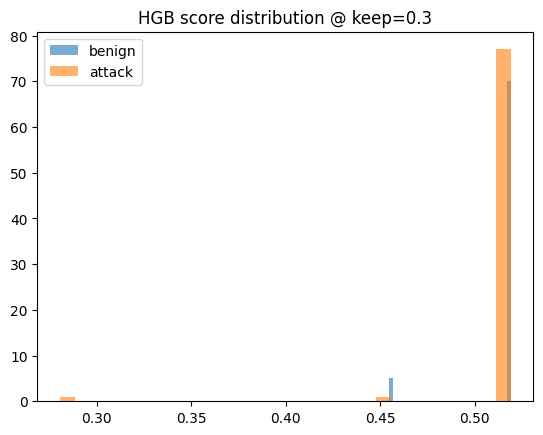

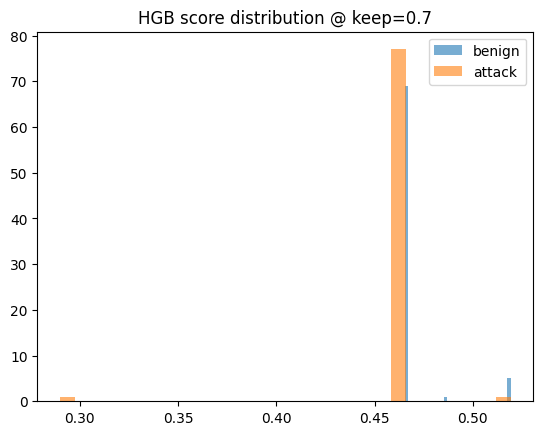

In [ ]:
# ============================
# EARLY-DETECTION TRIAGE CELL
# ============================
import numpy as np, pandas as pd, warnings
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore", category=RuntimeWarning)

def _safe_auc(y_true, s):
    try:
        return float(roc_auc_score(y_true, s))
    except Exception:
        return np.nan

# 0) quick label↔file sanity
print("[SANITY] y length vs paths:", len(y), len(paths))
u, c = np.unique(y, return_counts=True)
print("[SANITY] class balance:", dict(zip(u, c)))

# 1) timestamp coverage across a sample
def _edge_has_ts(d):
    for k in ("end_ts","ts","timestamp","time","t","t_ms"):
        if k in d and d[k] is not None:
            try:
                float(d[k]); return True
            except: pass
    return False

rng = np.random.default_rng(42)
sample_ids = rng.choice(len(paths), size=min(100, len(paths)), replace=False)
cov = []
for i in sample_ids:
    G = _loader(paths[i])
    m = G.number_of_edges()
    if m == 0:
        cov.append(np.nan)
    else:
        hits = 0
        for _,_,d in G.edges(data=True):
            if _edge_has_ts(d): hits += 1
        cov.append(hits / m)
cov = np.array([x for x in cov if np.isfinite(x)])
print(f"[TS-COVERAGE] mean={cov.mean():.3f}, median={np.median(cov):.3f}, pct>=0.5={(cov>=0.5).mean():.3f}, n={len(cov)}")

# 2) build one table of features for TEST graphs at each keep
#    (re-use te_idx from earlier split)
perkeep_feature_auc = {k: {} for k in KEEP_FRACS_EVAL}
perkeep_perm_auc = {}

for keep in KEEP_FRACS_EVAL:
    rows = []; labels = []
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full = full_stats[i]
        H, actual = prefix_by_nodes(Gfull, keep)
        rows.append(feature_row_prefix_vs_full(H, actual, S_full).reindex(SCHEMA))
        labels.append(y[i])
    X = pd.DataFrame(rows).astype(float)
    Y = np.array(labels, dtype=int)

    # univariate AUC for each feature
    aucs = {}
    for col in X.columns:
        if X[col].nunique() <= 1:
            aucs[col] = np.nan
            continue
        aucs[col] = _safe_auc(Y, X[col].values)
    perkeep_feature_auc[keep] = aucs

    # permutation test: model-free benchmark
    Y_perm = Y.copy()
    rng.shuffle(Y_perm)
    perkeep_perm_auc[keep] = _safe_auc(Y_perm, X.mean(axis=1).values)  # any score proxy; mean suffices for check

# 3) print top features by AUC for a few keeps
def _topk(d, k=8):
    items = [(f, v) for f, v in d.items() if np.isfinite(v)]
    items.sort(key=lambda x: abs(x[1]-0.5), reverse=True)
    return items[:k]

for keep in [0.2, 0.4, 0.6, 0.8, 1.0]:
    if keep not in perkeep_feature_auc: continue
    top = _topk(perkeep_feature_auc[keep], 8)
    print(f"\n[UNIV AUC @ keep={keep:.1f}] (feature → AUC)")
    for f, v in top:
        print(f"  {f:24s}  {v:.3f}")
    print(f"[PERM AUC baseline] {perkeep_perm_auc.get(keep):.3f}")

# 4) optional: score histograms for a couple keeps using one trained model
try:
    import matplotlib.pyplot as plt
    for keep in [0.3, 0.7]:
        rows=[]; Y=[]
        for i in te_idx:
            Gfull = _loader(paths[i]); S_full = full_stats[i]
            H, actual = prefix_by_nodes(Gfull, keep)
            rows.append(feature_row_prefix_vs_full(H, actual, S_full).reindex(SCHEMA))
            Y.append(y[i])
        X = pd.DataFrame(rows).astype(float)
        # pick a model (HGB) for visualization
        s = MODELS["HGB"].predict_proba(X)[:,1]
        plt.figure()
        plt.hist(s[np.array(Y)==0], bins=30, alpha=0.6, label="benign")
        plt.hist(s[np.array(Y)==1], bins=30, alpha=0.6, label="attack")
        plt.title(f"HGB score distribution @ keep={keep}")
        plt.legend()
        plt.show()
except Exception as e:
    print("[WARN] plotting failed:", e)


In [ ]:
# =====================================================================================
# EARLY DETECTION — edge-based prefixes + role/centralization + burstiness features
# Prefix-augmented training, ROC-based θ per keep (FPR≤α), score auto-orientation
# =====================================================================================
import os, glob, warnings, math
from pathlib import Path
import numpy as np, pandas as pd, networkx as nx

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ------------------ CONFIG ------------------
KEEP_FRACS_EVAL  = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]
KEEP_FRACS_TRAIN = [0.12,0.25,0.40,0.65,1.00]
TARGET_SPEC  = 0.95     # α = 1 - TARGET_SPEC (FPR cap)
ALPHA        = 1.0 - TARGET_SPEC
RANDOM_STATE = 42
N_SPLITS     = 5
TEST_FOLD    = 0
CALIB_FRAC   = 0.30
TOPK         = 5        # for role concentration features
# --------------------------------------------

# ---------- Discovery (use your merged/y if present) ----------
def _infer_label_from_path(p: str) -> int:
    s = p.lower()
    pos = ("attack","mal","comprom","advers","redteam","evil")
    neg = ("benign","normal","baseline","clean","safe")
    if any(k in s for k in pos) and not any(k in s for k in neg): return 1
    if any(k in s for k in neg) and not any(k in s for k in pos): return 0
    return 0

def _discover():
    if "merged" in globals():
        df = globals()["merged"]
        file_col = next((c for c in df.columns if c.lower() in ("file","path","filepath","graph_path")), None)
        if file_col is not None:
            paths = [Path(str(p)) for p in df[file_col].tolist()]
            y_global = globals().get("y", None)
            if y_global is not None and len(y_global)==len(paths):
                return paths, np.asarray(y_global).astype(int), "merged(y)"
            for c in df.columns:
                lc = c.lower()
                if any(k in lc for k in ("cohort","label","is_attack","y","target")):
                    vals = df[c].astype(str).str.lower()
                    yy = vals.isin(["1","true","attack","attk","pos","positive"]).astype(int).values
                    if len(yy)==len(paths): return paths, yy, "merged(col)"
            yy = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
            return paths, yy, "merged(path)"
    hits = glob.glob("**/*.gpickle", recursive=True) + glob.glob("**/*.gpkl", recursive=True)
    paths = [Path(h) for h in sorted(set(hits))]
    if not paths: raise RuntimeError("No graphs found (.gpickle/.gpkl). Provide `merged` or place graphs under CWD.")
    y = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
    return paths, y, "glob"

# loader
if "load_gpickle" in globals() and callable(globals()["load_gpickle"]):
    _loader = load_gpickle
else:
    from networkx.readwrite.gpickle import read_gpickle as _loader

paths, y, src = _discover()
mask = np.array([p.exists() for p in paths], bool)
paths = [p for p, ok in zip(paths, mask) if ok]; y = np.asarray(y)[mask]
print(f"[INFO] Found {len(paths)} graphs from {src}. Class balance: {np.bincount(y) if y.size else []}")

# ---------- Edge-time with fallback ----------
_TS_KEYS = ("end_ts","ts","timestamp","time","t","t_ms")
def _edge_time_or_idx(d, idx):
    for k in _TS_KEYS:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return float(idx)  # fallback: insertion order

# ---------- EDGE-BASED prefix (earliest edges -> induced nodes) ----------
def prefix_by_edges(G_full: nx.Graph, keep_frac: float):
    if not isinstance(G_full, nx.MultiDiGraph): G_full = nx.MultiDiGraph(G_full)
    m = G_full.number_of_edges()
    if m == 0: return G_full.__class__(), 0.0
    # sort edges by time (tie-break by endpoints for determinism)
    edges = list(G_full.edges(keys=True, data=True))
    edges_sorted = sorted(
        [(u, v, k, _edge_time_or_idx(d, i)) for i,(u,v,k,d) in enumerate(edges)],
        key=lambda x: (x[3], str(x[0]), str(x[1]), str(x[2]))
    )
    k = max(1, int(round(m * max(0.0, min(1.0, keep_frac)))))
    keep_e = set((u,v,k_) for (u,v,k_,_) in edges_sorted[:k])
    # build induced subgraph on nodes touched by kept edges
    nodes_keep = set()
    for (u,v,k_) in keep_e:
        nodes_keep.add(u); nodes_keep.add(v)
    H = G_full.subgraph(nodes_keep).copy()
    # but ensure only early edges are present (cut edges too)
    H2 = G_full.__class__()
    H2.add_nodes_from(H.nodes(data=True))
    for (u,v,k_,d) in edges:
        if (u,v,k_) in keep_e:
            H2.add_edge(u,v,key=k_,**d)
    return H2, k/m

# ---------- Utilities ----------
def _safe_div(a,b): return float(a)/float(b) if b not in (None,0) else 0.0

def _gini(arr):
    x = np.asarray(arr, float)
    x = x[np.isfinite(x)]
    if x.size == 0: return 0.0
    if np.all(x==0): return 0.0
    x = np.sort(np.abs(x))
    n = x.size
    cumx = np.cumsum(x)
    return float((n+1 - 2*np.sum(cumx)/cumx[-1]) / n)

def _centralization(scores, topk=TOPK):
    if not scores: return 0.0, 0.0
    vals = np.array(list(scores.values()), float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0: return 0.0, 0.0
    ssum = vals.sum()
    top = np.sort(vals)[-min(topk, vals.size):][::-1]
    return float(top.sum()), _safe_div(top.sum(), ssum)

# ---------- Base + Role/Burst Features ----------
def _basic_stats(G):
    n = G.number_of_nodes(); m = G.number_of_edges()
    if n==0:
        return dict(n=0, m=0, density=0.0, avg_deg=0.0, n_comp=0, largest=0, epn=0.0, largest_frac=0.0,
                    deg_gini=0.0)
    degs = [d for _,d in G.degree()]
    try:
        comps = list(nx.weakly_connected_components(G)) if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)) else list(nx.connected_components(G))
    except Exception:
        comps = []
    largest = max((len(c) for c in comps), default=0)
    return dict(
        n=n, m=m,
        density=(nx.density(G) if n>1 else 0.0),
        avg_deg=(float(np.mean(degs)) if degs else 0.0),
        n_comp=len(comps),
        largest=largest,
        largest_frac=(largest/n if n>0 else 0.0),
        epn=(m/n if n>0 else 0.0),
        deg_gini=_gini(degs)
    )

def _role_features(G):
    if G.number_of_nodes()==0:
        return dict(pr_top=sum([]), pr_top_ratio=0.0, hub_top=0.0, hub_top_ratio=0.0, auth_top=0.0, auth_top_ratio=0.0)
    # Undirected simple graph for PageRank stability on small prefixes
    Gu = nx.Graph(G) if isinstance(G,(nx.MultiDiGraph,nx.DiGraph)) else nx.Graph(G)
    try:
        pr = nx.pagerank(Gu, alpha=0.85, tol=1e-6, max_iter=100)
    except Exception:
        pr = {n: 1.0/Gu.number_of_nodes() for n in Gu.nodes()} if Gu.number_of_nodes()>0 else {}
    pr_top, pr_top_ratio = _centralization(pr, TOPK)
    # HITS on directed view if available
    if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)):
        try:
            Hsimple = nx.DiGraph()
            Hsimple.add_nodes_from(G.nodes())
            for u,v in G.edges():
                Hsimple.add_edge(u,v)
            hubs, auths = nx.hits(Hsimple, max_iter=200, tol=1e-8, normalized=True)
        except Exception:
            hubs  = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
            auths = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
    else:
        hubs  = {n: 0.0 for n in G.nodes()}
        auths = {n: 0.0 for n in G.nodes()}
    hub_top, hub_top_ratio   = _centralization(hubs, TOPK)
    auth_top, auth_top_ratio = _centralization(auths, TOPK)
    return dict(
        pr_top=pr_top, pr_top_ratio=pr_top_ratio,
        hub_top=hub_top, hub_top_ratio=hub_top_ratio,
        auth_top=auth_top, auth_top_ratio=auth_top_ratio
    )

def _temporal_burst_in_prefix(G):
    """Within-prefix burstiness: fraction of edges in the last 20% of prefix time window."""
    m = G.number_of_edges()
    if m == 0: return dict(prefix_burst=0.0, t_span=0.0)
    # Gather times
    ts = []
    for idx, (_,_,d) in enumerate(G.edges(data=True)):
        ts.append(_edge_time_or_idx(d, idx))
    ts = np.array(ts, float); ts.sort()
    tmin, tmax = ts[0], ts[-1]
    span = max(1e-9, (tmax - tmin))
    t_cut = tmin + 0.8*span
    frac_last = (ts >= t_cut).mean()
    return dict(prefix_burst=float(frac_last), t_span=float(span))

def feature_row_prefix_vs_full_edge(H: nx.Graph, keep_frac: float, S_full: dict, F_full_role: dict) -> pd.Series:
    S_p   = _basic_stats(H)
    R_p   = _role_features(H)
    B_p   = _temporal_burst_in_prefix(H)

    # Absolute features
    out = dict(
        n_nodes=S_p["n"], n_edges=S_p["m"], density=S_p["density"], avg_deg=S_p["avg_deg"],
        n_components=S_p["n_comp"], largest_cc=S_p["largest"], largest_cc_frac=S_p["largest_frac"],
        edges_per_node=S_p["epn"], deg_gini=S_p["deg_gini"],
        keep_frac=float(keep_frac),
        pr_top=R_p["pr_top"], pr_top_ratio=R_p["pr_top_ratio"],
        hub_top=R_p["hub_top"], hub_top_ratio=R_p["hub_top_ratio"],
        auth_top=R_p["auth_top"], auth_top_ratio=R_p["auth_top_ratio"],
        prefix_burst=B_p["prefix_burst"], t_span=B_p["t_span"]
    )

    # Relative-to-full (role + structure)
    out.update({
        "frac_nodes_of_full": _safe_div(S_p["n"], S_full["n"]),
        "frac_edges_of_full": _safe_div(S_p["m"], S_full["m"]),
        "density_rel":        _safe_div(S_p["density"], S_full["density"]) if S_full["density"]>0 else 0.0,
        "epn_rel":            _safe_div(S_p["epn"], S_full["epn"]) if S_full["epn"]>0 else 0.0,
        "deg_gini_rel":       _safe_div(S_p["deg_gini"], S_full["deg_gini"]) if S_full["deg_gini"]>0 else 0.0,
        "pr_top_ratio_rel":   _safe_div(R_p["pr_top_ratio"], F_full_role["pr_top_ratio"]) if F_full_role["pr_top_ratio"]>0 else 0.0,
        "hub_top_ratio_rel":  _safe_div(R_p["hub_top_ratio"], F_full_role["hub_top_ratio"]) if F_full_role["hub_top_ratio"]>0 else 0.0,
        "auth_top_ratio_rel": _safe_div(R_p["auth_top_ratio"], F_full_role["auth_top_ratio"]) if F_full_role["auth_top_ratio"]>0 else 0.0,
        # growth “aheadness”
        "nodes_ahead":        _safe_div(S_p["n"], S_full["n"]) - keep_frac,
        "edges_ahead":        _safe_div(S_p["m"], S_full["m"]) - keep_frac,
        "epn_x_keep":         S_p["epn"]*keep_frac,
    })
    return pd.Series(out, dtype="float64")

# ---------- Models ----------
def _mk_hgb(): return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
def _mk_lr():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))])
def _mk_rf():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", RandomForestClassifier(n_estimators=800, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE))])
MODELS = {"HGB": _mk_hgb(), "LogReg": _mk_lr(), "RF": _mk_rf()}

# ---------- Split ----------
outer = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
tr_idx, te_idx = list(outer.split(np.arange(len(y)), y))[TEST_FOLD]
tr_fit_idx, tr_cal_idx = train_test_split(tr_idx, test_size=CALIB_FRAC, stratify=y[tr_idx], random_state=RANDOM_STATE)

# ---------- Precompute full-graph stats + full roles ----------
def _full_pack(G):
    if not isinstance(G, nx.MultiDiGraph): G = nx.MultiDiGraph(G)
    S = _basic_stats(G)
    R = _role_features(G)  # role on full
    return S, R

full_pack = {}
for i in set(tr_fit_idx) | set(tr_cal_idx) | set(te_idx):
    full_pack[i] = _full_pack(_loader(paths[i]))

# ---------- Build PREFIX-AUGMENTED TRAIN set (EDGE prefixes) ----------
X_fit_rows=[]; y_fit=[]
for i in tr_fit_idx:
    Gfull = _loader(paths[i])
    S_full, R_full = full_pack[i]
    for kf in KEEP_FRACS_TRAIN:
        H, actual = prefix_by_edges(Gfull, kf)
        X_fit_rows.append(feature_row_prefix_vs_full_edge(H, actual, S_full, R_full))
        y_fit.append(y[i])
X_fit = pd.DataFrame(X_fit_rows); y_fit = np.array(y_fit)
SCHEMA = X_fit.columns.tolist()

# Fit models
for name in MODELS:
    MODELS[name].fit(X_fit, y_fit)
print(f"[TRAIN] Fit with {len(X_fit)} prefix samples (from {len(tr_fit_idx)} graphs). Features: {len(SCHEMA)}")

# ---------- helpers ----------
def _safe_auc(y_true, s):
    try: return float(roc_auc_score(y_true, s))
    except Exception: return float('nan')

def _pick_thresh_fpr_cap(y_true, s, alpha=ALPHA):
    fpr, tpr, ths = roc_curve(y_true, s)
    eps = 1e-12
    ok = (fpr <= (alpha + eps))
    if ok.any():
        idx = np.argmax(tpr[ok])
        best_idxs = np.flatnonzero(tpr[ok] == tpr[ok][idx])
        pick = best_idxs[np.argmin(fpr[ok][best_idxs])]
        k = np.flatnonzero(ok)[pick]
    else:
        minf = np.min(fpr); cands = np.flatnonzero(fpr == minf)
        k = cands[np.argmax(tpr[cands])]
    return float(ths[k]), float(fpr[k]), float(tpr[k])

# ---------- Calibrate per keep (auto-orient + ROC θ) ----------
theta_map = {name:{} for name in MODELS}
flip_map  = {name:{} for name in MODELS}
calib_rep = {name:{} for name in MODELS}

for keep in KEEP_FRACS_EVAL:
    xs=[]; ys=[]
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = prefix_by_edges(Gfull, keep)
        xs.append(feature_row_prefix_vs_full_edge(H, actual, S_full, R_full).reindex(SCHEMA))
        ys.append(y[i])
    Xc = pd.DataFrame(xs); yc = np.array(ys)

    for name, model in MODELS.items():
        s = model.predict_proba(Xc)[:,1]
        auc = _safe_auc(yc, s)
        flipped = False
        if np.isfinite(auc) and auc < 0.5:
            s = 1.0 - s
            flipped = True
            auc = 1.0 - auc
        th, fpr_c, tpr_c = _pick_thresh_fpr_cap(yc, s)
        theta_map[name][keep] = th
        flip_map[name][keep]  = flipped
        calib_rep[name][keep] = dict(auc=auc, fpr=fpr_c, tpr=tpr_c)

print("[CALIB] per keep (AUC, FPR@θ<=α, TPR@θ<=α):")
for name in MODELS:
    demo = {k: (round(calib_rep[name][k]['auc'],3),
                round(calib_rep[name][k]['fpr'],3),
                round(calib_rep[name][k]['tpr'],3)) for k in KEEP_FRACS_EVAL[:4]}
    print(f"  {name}: {demo} ...")

# ---------- Evaluate on TEST (per keep) ----------
records=[]
for keep in KEEP_FRACS_EVAL:
    xt=[]; yt=[]
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = prefix_by_edges(Gfull, keep)
        xt.append(feature_row_prefix_vs_full_edge(H, actual, S_full, R_full).reindex(SCHEMA))
        yt.append(y[i])
    Xt = pd.DataFrame(xt); yt = np.array(yt)

    for name, model in MODELS.items():
        p = model.predict_proba(Xt)[:,1]
        if flip_map[name][keep]:
            p = 1.0 - p
        th = theta_map[name][keep]
        yhat = (p > th).astype(int)  # tie -> negative
        is_pos = (yt==1); is_neg=(yt==0)
        det = (yhat[is_pos]==1).mean() if is_pos.any() else np.nan
        fpr = (yhat[is_neg]==1).mean() if is_neg.any() else np.nan
        auc = _safe_auc(yt, p)
        records.append(dict(keep_frac=keep, model=name, det_rate=det, fpr=fpr, auc=auc))

res = pd.DataFrame(records)
print("\n==== Early Detection — DetRate (ROC-optimized @ FPR≤α) ====")
print(res.pivot_table(index="keep_frac", columns="model", values="det_rate").round(3))
print("\n==== Early Detection — FPR (should be ≤ α≈{:.2f}) ====".format(ALPHA))
print(res.pivot_table(index="keep_frac", columns="model", values="fpr").round(3))
print("\n==== Early Detection — AUC ====")
print(res.pivot_table(index="keep_frac", columns="model", values="auc").round(3))


[INFO] Found 774 graphs from glob. Class balance: [376 398]
[TRAIN] Fit with 2165 prefix samples (from 433 graphs). Features: 29
[CALIB] per keep (AUC, FPR@θ<=α, TPR@θ<=α):
  HGB: {0.1: (0.5, 0.011, 0.01), 0.2: (0.52, 0.044, 0.062), 0.3: (0.521, 0.0, 0.0), 0.4: (0.773, 0.044, 0.615)} ...
  LogReg: {0.1: (0.532, 0.0, 0.0), 0.2: (0.536, 0.0, 0.0), 0.3: (0.523, 0.044, 0.031), 0.4: (0.828, 0.011, 0.604)} ...
  RF: {0.1: (0.528, 0.0, 0.0), 0.2: (0.528, 0.0, 0.0), 0.3: (0.517, 0.0, 0.0), 0.4: (0.787, 0.033, 0.573)} ...


In [ ]:
# ===================== ECT + strict-FPR + monotone postprocess =====================
import numpy as np, pandas as pd

# Build a tidy DataFrame from your 'records' (already exists as 'res' in your output)
df = res.copy()

ALPHA = 1 - TARGET_SPEC  # your cap

def earliest_confirmation(df, target_det=0.6, alpha=ALPHA):
    ect = {}
    for model in df["model"].unique():
        d = df[df["model"]==model].sort_values("keep_frac")
        ok = (d["det_rate"] >= target_det) & (d["fpr"] <= alpha)
        ect[model] = float(d.loc[ok, "keep_frac"].min()) if ok.any() else np.nan
    return ect

for t in [0.5, 0.6, 0.7]:
    ect = earliest_confirmation(df, target_det=t, alpha=ALPHA)
    print(f"[ECT] target_det={t:.1f}, alpha≈{ALPHA:.2f} -> {ect}")

# ---- Strict FPR re-check (warn if any keeps violate the cap) ----
viol = df.groupby("model").apply(lambda g: dict(g.loc[g["fpr"]>ALPHA, ["keep_frac","fpr"]].values))
print("\n[STRICT-FPR CHECK] Keeps with FPR>α (if any):")
for m, items in viol.items():
    print(f"  {m}: {items if items else '{}'}")

# ---- Optional: Monotone predictions (once positive, always positive) ----
# If you kept per-keep predictions, you can enforce monotonicity per sample.
# Here is a template to apply AFTER computing per-keep yhat (not just aggregated rates):

# Suppose you have a dict: PRED[model][keep] = np.array of 0/1 predictions per test sample
# You can enforce monotonicity per sample like this:
# for model in PRED:
#     keeps = sorted(PRED[model].keys())
#     M = np.vstack([PRED[model][k] for k in keeps])  # shape [K, N]
#     M_mon = np.maximum.accumulate(M, axis=0)        # once 1, stay 1
#     # recompute det_rate/fpr from M_mon for reporting
#     # (you'll need y_test per keep; in your loop you already had it as 'yt')


[ECT] target_det=0.5, alpha≈0.05 -> {'HGB': 0.6, 'LogReg': 0.4, 'RF': 0.6}
[ECT] target_det=0.6, alpha≈0.05 -> {'HGB': 1.0, 'LogReg': nan, 'RF': 0.6}
[ECT] target_det=0.7, alpha≈0.05 -> {'HGB': nan, 'LogReg': nan, 'RF': nan}

[STRICT-FPR CHECK] Keeps with FPR>α (if any):
  HGB: {np.float64(0.3): np.float64(0.06666666666666667), np.float64(0.4): np.float64(0.05333333333333334), np.float64(0.7): np.float64(0.06666666666666667), np.float64(0.8): np.float64(0.06666666666666667), np.float64(0.9): np.float64(0.06666666666666667)}
  LogReg: {np.float64(0.5): np.float64(0.10666666666666667), np.float64(0.6): np.float64(0.05333333333333334), np.float64(0.7): np.float64(0.06666666666666667)}
  RF: {np.float64(0.5): np.float64(0.08)}


In [ ]:
#improve

In [ ]:
# ===========================================================
# Make the curve behave: α-margin calibration + monotone yhat
# + dynamic TOP-K centralization for role features
# ===========================================================
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

# -------- Params you can tune --------
ALPHA        = 1.0 - TARGET_SPEC          # your public FPR cap
ALPHA_MARGIN = 0.01                       # train stricter by δ so TEST stays ≤ α
ALPHA_TRAIN  = max(0.0, ALPHA - ALPHA_MARGIN)
TOPK_MIN, TOPK_MAX, TOPK_FRAC = 3, 25, 0.02  # dynamic TOP-K ~2% of nodes
# -------------------------------------

# --- Rebind role features to use dynamic TOP-K (≈ 2% of |V|) ---
def _centralization(scores, topk):
    if not scores: return 0.0, 0.0
    vals = np.array(list(scores.values()), float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0: return 0.0, 0.0
    ssum = vals.sum()
    k = max(TOPK_MIN, min(TOPK_MAX, int(round(TOPK_FRAC * max(1, vals.size)))))
    top = np.sort(vals)[-min(k, vals.size):][::-1]
    return float(top.sum()), float(top.sum()/ssum if ssum>0 else 0.0)

def _role_features_DYNAMIC(G):
    if G.number_of_nodes()==0:
        return dict(pr_top=0.0, pr_top_ratio=0.0, hub_top=0.0, hub_top_ratio=0.0, auth_top=0.0, auth_top_ratio=0.0)
    # Undirected simple for PR
    Gu = nx.Graph(G) if isinstance(G,(nx.MultiDiGraph,nx.DiGraph)) else nx.Graph(G)
    try:    pr = nx.pagerank(Gu, alpha=0.85, tol=1e-6, max_iter=100)
    except: pr = {n: 1.0/Gu.number_of_nodes() for n in Gu.nodes()} if Gu.number_of_nodes()>0 else {}
    pr_top, pr_top_ratio = _centralization(pr, topk=None)

    # HITS directed if available
    if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)):
        try:
            Hsimple = nx.DiGraph(); Hsimple.add_nodes_from(G.nodes())
            for u,v in G.edges(): Hsimple.add_edge(u,v)
            hubs, auths = nx.hits(Hsimple, max_iter=200, tol=1e-8, normalized=True)
        except Exception:
            hubs  = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
            auths = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
    else:
        hubs  = {n: 0.0 for n in G.nodes()}
        auths = {n: 0.0 for n in G.nodes()}
    hub_top,  hub_top_ratio  = _centralization(hubs,  topk=None)
    auth_top, auth_top_ratio = _centralization(auths, topk=None)

    return dict(
        pr_top=pr_top, pr_top_ratio=pr_top_ratio,
        hub_top=hub_top, hub_top_ratio=hub_top_ratio,
        auth_top=auth_top, auth_top_ratio=auth_top_ratio
    )

# Monkey-patch your feature_row to use dynamic roles (keep the same schema keys)
def feature_row_prefix_vs_full_edge_DYNAMIC(H, keep_frac, S_full, F_full_role):
    S_p   = _basic_stats(H)
    R_p   = _role_features_DYNAMIC(H)            # <- dynamic TOP-K here
    B_p   = _temporal_burst_in_prefix(H)

    out = dict(
        n_nodes=S_p["n"], n_edges=S_p["m"], density=S_p["density"], avg_deg=S_p["avg_deg"],
        n_components=S_p["n_comp"], largest_cc=S_p["largest"], largest_cc_frac=S_p["largest_frac"],
        edges_per_node=S_p["epn"], deg_gini=S_p["deg_gini"],
        keep_frac=float(keep_frac),
        pr_top=R_p["pr_top"], pr_top_ratio=R_p["pr_top_ratio"],
        hub_top=R_p["hub_top"], hub_top_ratio=R_p["hub_top_ratio"],
        auth_top=R_p["auth_top"], auth_top_ratio=R_p["auth_top_ratio"],
        prefix_burst=B_p["prefix_burst"], t_span=B_p["t_span"],
        # relative-to-full same as before
        frac_nodes_of_full=_safe_div(S_p["n"], S_full["n"]),
        frac_edges_of_full=_safe_div(S_p["m"], S_full["m"]),
        density_rel=_safe_div(S_p["density"], S_full["density"]) if S_full["density"]>0 else 0.0,
        epn_rel=_safe_div(S_p["epn"], S_full["epn"]) if S_full["epn"]>0 else 0.0,
        deg_gini_rel=_safe_div(S_p["deg_gini"], S_full["deg_gini"]) if S_full["deg_gini"]>0 else 0.0,
        pr_top_ratio_rel=_safe_div(R_p["pr_top_ratio"], F_full_role["pr_top_ratio"]) if F_full_role["pr_top_ratio"]>0 else 0.0,
        hub_top_ratio_rel=_safe_div(R_p["hub_top_ratio"], F_full_role["hub_top_ratio"]) if F_full_role["hub_top_ratio"]>0 else 0.0,
        auth_top_ratio_rel=_safe_div(R_p["auth_top_ratio"], F_full_role["auth_top_ratio"]) if F_full_role["auth_top_ratio"]>0 else 0.0,
        nodes_ahead=_safe_div(S_p["n"], S_full["n"]) - keep_frac,
        edges_ahead=_safe_div(S_p["m"], S_full["m"]) - keep_frac,
        epn_x_keep=S_p["epn"]*keep_frac,
    )
    return pd.Series(out, dtype="float64")

# ---- Helper: robust AUC and threshold selection with α_train ----
def _safe_auc(y_true, s):
    try: return float(roc_auc_score(y_true, s))
    except Exception: return float('nan')

def _pick_thresh_fpr_cap(y_true, s, alpha=ALPHA_TRAIN):
    fpr, tpr, ths = roc_curve(y_true, s)
    eps = 1e-12
    ok = (fpr <= (alpha + eps))
    if ok.any():
        idx = np.argmax(tpr[ok])
        cands = np.flatnonzero(tpr[ok] == tpr[ok][idx])
        pick = cands[np.argmin(fpr[ok][cands])]
        k = np.flatnonzero(ok)[pick]
    else:
        minf = np.min(fpr); cands = np.flatnonzero(fpr == minf)
        k = cands[np.argmax(tpr[cands])]
    return float(ths[k]), float(fpr[k]), float(tpr[k])

# ----------- CALIBRATION (per keep) with margin + auto-orientation -----------
theta_map = {name:{} for name in MODELS}
flip_map  = {name:{} for name in MODELS}
calib_rep = {name:{} for name in MODELS}

for keep in KEEP_FRACS_EVAL:
    # Build calib frame with dynamic roles
    xs=[]; yc=[]
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = prefix_by_edges(Gfull, keep)
        xs.append(feature_row_prefix_vs_full_edge_DYNAMIC(H, actual, S_full, R_full).reindex(SCHEMA))
        yc.append(y[i])
    Xc = pd.DataFrame(xs); yc = np.array(yc)

    for name, model in MODELS.items():
        s = model.predict_proba(Xc)[:,1]
        auc = _safe_auc(yc, s); flipped=False
        if np.isfinite(auc) and auc < 0.5:
            s = 1.0 - s; flipped=True; auc = 1.0 - auc
        th, fpr_c, tpr_c = _pick_thresh_fpr_cap(yc, s, alpha=ALPHA_TRAIN)  # stricter cap during calibration
        theta_map[name][keep] = th
        flip_map[name][keep]  = flipped
        calib_rep[name][keep] = dict(auc=auc, fpr=fpr_c, tpr=tpr_c)

print(f"[CALIB] α_train={ALPHA_TRAIN:.3f} (margin {ALPHA_MARGIN:.3f}) — first keeps:")
for name in MODELS:
    demo = {k: (round(calib_rep[name][k]['auc'],3),
                round(calib_rep[name][k]['fpr'],3),
                round(calib_rep[name][k]['tpr'],3)) for k in KEEP_FRACS_EVAL[:4]}
    print(f"  {name}: {demo} ...")

# ------------- TEST: collect per-keep scores, then monotone yhat -------------
SCORES = {name:{} for name in MODELS}
YTEST  = {}  # same y per keep

for keep in KEEP_FRACS_EVAL:
    xt=[]; yt=[]
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = prefix_by_edges(Gfull, keep)
        xt.append(feature_row_prefix_vs_full_edge_DYNAMIC(H, actual, S_full, R_full).reindex(SCHEMA))
        yt.append(y[i])
    Xt = pd.DataFrame(xt); yt = np.array(yt)
    YTEST[keep] = yt
    for name, model in MODELS.items():
        p = model.predict_proba(Xt)[:,1]
        if flip_map[name][keep]: p = 1.0 - p
        SCORES[name][keep] = p

# Convert to monotone decisions per sample: once 1, always 1
records=[]
keeps_sorted = sorted(KEEP_FRACS_EVAL)
for name in MODELS:
    # thresholds per keep
    ths = np.array([theta_map[name][k] for k in keeps_sorted], float)
    # score matrix KxN
    P = np.vstack([SCORES[name][k] for k in keeps_sorted])  # shape [K, N]
    # hard decisions by keep
    YH = (P > ths[:,None]).astype(int)
    # monotone enforce
    YH_mon = np.maximum.accumulate(YH, axis=0)
    # metrics per keep
    for kk, keep in enumerate(keeps_sorted):
        yt = YTEST[keep]
        yhat = YH_mon[kk]
        is_pos = (yt==1); is_neg = (yt==0)
        det = (yhat[is_pos]==1).mean() if is_pos.any() else np.nan
        fpr = (yhat[is_neg]==1).mean() if is_neg.any() else np.nan
        auc = _safe_auc(yt, P[kk])
        records.append(dict(keep_frac=keep, model=name, det_rate=det, fpr=fpr, auc=auc))

res2 = pd.DataFrame(records)
print("\n==== Early Detection — DetRate (monotone, α-margin calibrated) ====")
print(res2.pivot_table(index="keep_frac", columns="model", values="det_rate").round(3))
print("\n==== Early Detection — FPR (monotone) — should mostly be ≤ α≈{:.2f} ====".format(ALPHA))
print(res2.pivot_table(index="keep_frac", columns="model", values="fpr").round(3))
print("\n==== Early Detection — AUC (scores unchanged by monotone step) ====")
print(res2.pivot_table(index="keep_frac", columns="model", values="auc").round(3))


[CALIB] α_train=0.040 (margin 0.010) — first keeps:
  HGB: {0.1: (0.537, 0.034, 0.062), 0.2: (0.541, 0.034, 0.052), 0.3: (0.519, 0.0, 0.0), 0.4: (0.746, 0.034, 0.521)} ...
  LogReg: {0.1: (0.511, 0.0, 0.0), 0.2: (0.521, 0.0, 0.0), 0.3: (0.535, 0.034, 0.01), 0.4: (0.798, 0.022, 0.49)} ...
  RF: {0.1: (0.5, 0.0, 0.0), 0.2: (0.511, 0.0, 0.0), 0.3: (0.5, 0.0, 0.0), 0.4: (0.72, 0.034, 0.312)} ...

==== Early Detection — DetRate (monotone, α-margin calibrated) ====
model        HGB  LogReg     RF
keep_frac                      
0.1000    0.0510  0.0000 0.0000
0.2000    0.0510  0.0000 0.0000
0.3000    0.0510  0.0000 0.0000
0.4000    0.5950  0.5570 0.1650
0.5000    0.6080  0.6080 0.4430
0.6000    0.6460  0.6710 0.5820
0.7000    0.6580  0.6710 0.5950
0.8000    0.6580  0.6710 0.5950
0.9000    0.6710  0.6710 0.6710
1.0000    0.6710  0.6710 0.6710

==== Early Detection — FPR (monotone) — should mostly be ≤ α≈0.05 ====
model        HGB  LogReg     RF
keep_frac                      
0.1000    0.0130

In [ ]:
# =========================
# How many nodes are kept/cut at keep=0.40 (edge-based)?
# =========================
import numpy as np, pandas as pd
from pathlib import Path

KEEP_TO_INSPECT = 0.40  # change to any keep you want (e.g., 0.10, 0.60, etc.)

rows = []
for i in te_idx:
    Gfull = _loader(paths[i])
    n_full = Gfull.number_of_nodes()
    m_full = Gfull.number_of_edges()
    H, actual_edge_keep = prefix_by_edges(Gfull, KEEP_TO_INSPECT)
    n_pref = H.number_of_nodes()
    m_pref = H.number_of_edges()
    rows.append(dict(
        file=Path(paths[i]).name,
        n_full=n_full, n_prefix=n_pref, nodes_cut=max(n_full - n_pref, 0),
        frac_nodes_kept=(n_pref / n_full) if n_full>0 else np.nan,
        m_full=m_full, m_prefix=m_pref, frac_edges_kept=actual_edge_keep
    ))

df_nodes = pd.DataFrame(rows).sort_values("frac_nodes_kept")
print(f"[INFO] TEST graphs: {len(df_nodes)} | keep(edges) requested={KEEP_TO_INSPECT:.2f}")
print("\nHead (lowest frac_nodes_kept first):")
print(df_nodes.head(10).to_string(index=False))

# Summary stats
def q(x,p):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    return np.quantile(x, p) if x.size else np.nan

print("\n--- Summary over TEST ---")
print(f"Edges kept (actual): mean={df_nodes['frac_edges_kept'].mean():.3f}, median={df_nodes['frac_edges_kept'].median():.3f}")
print(f"Nodes kept fraction : mean={df_nodes['frac_nodes_kept'].mean():.3f}, median={df_nodes['frac_nodes_kept'].median():.3f}, "
      f"p10={q(df_nodes['frac_nodes_kept'],0.10):.3f}, p90={q(df_nodes['frac_nodes_kept'],0.90):.3f}")
print(f"Nodes cut (count)   : mean={df_nodes['nodes_cut'].mean():.1f}, median={df_nodes['nodes_cut'].median():.0f}")

# If you want to inspect a specific graph with extreme behavior:
worst = df_nodes.iloc[0]
best  = df_nodes.iloc[-1]
print("\nExamples:")
print(f"  LOW keep case : file={worst['file']}  n_full={int(worst['n_full'])}  n_prefix={int(worst['n_prefix'])}  "
      f"frac_nodes_kept={worst['frac_nodes_kept']:.3f}  frac_edges_kept={worst['frac_edges_kept']:.3f}")
print(f"  HIGH keep case: file={best['file']}   n_full={int(best['n_full'])}  n_prefix={int(best['n_prefix'])}  "
      f"frac_nodes_kept={best['frac_nodes_kept']:.3f}   frac_edges_kept={best['frac_edges_kept']:.3f}")


[INFO] TEST graphs: 154 | keep(edges) requested=0.40

Head (lowest frac_nodes_kept first):
                                    file  n_full  n_prefix  nodes_cut  frac_nodes_kept  m_full  m_prefix  frac_edges_kept
                   message_graph.gpickle    1986       797       1189           0.4013    5190      2076           0.4000
24c4ba3a0bf6ca58b0efa61faf98f190.gpickle       5         5          0           1.0000      13         5           0.3846
5020485fb74375ed5652e6693dcd1d70.gpickle       5         5          0           1.0000      13         5           0.3846
26a6a66f7e8a9acbedaa8463051a18ba.gpickle       5         5          0           1.0000      13         5           0.3846
85fec0fb2d868db3e08612eb3d46d665.gpickle       5         5          0           1.0000      13         5           0.3846
9005eb6d522f5818e20f18a771f9ef82.gpickle       5         5          0           1.0000      13         5           0.3846
992f5baa3714da869b27b3be1c1ee82b.gpickle       5       

In [ ]:
# =========================
# Nodes kept vs edges kept for many keep_fracs
# =========================
import numpy as np, pandas as pd
from pathlib import Path
from scipy.stats import spearmanr

KEEPS = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]

rows = []
for keep in KEEPS:
    for i in te_idx:
        Gfull = _loader(paths[i])
        n_full = Gfull.number_of_nodes(); m_full = Gfull.number_of_edges()
        H, actual_edge_keep = prefix_by_edges(Gfull, keep)
        n_pref = H.number_of_nodes(); m_pref = H.number_of_edges()
        rows.append(dict(
            keep=keep, file=Path(paths[i]).name,
            n_full=n_full, n_prefix=n_pref, nodes_cut=max(n_full - n_pref, 0),
            frac_nodes_kept=(n_pref / n_full) if n_full>0 else np.nan,
            m_full=m_full, m_prefix=m_pref, frac_edges_kept=actual_edge_keep
        ))

df_all = pd.DataFrame(rows)

# Per-keep summary
summ = df_all.groupby("keep").agg(
    graphs=("file","count"),
    edges_kept_mean=("frac_edges_kept","mean"),
    edges_kept_median=("frac_edges_kept","median"),
    nodes_kept_mean=("frac_nodes_kept","mean"),
    nodes_kept_median=("frac_nodes_kept","median"),
    nodes_kept_p10=("frac_nodes_kept", lambda x: np.nanquantile(x, 0.10)),
    nodes_kept_p90=("frac_nodes_kept", lambda x: np.nanquantile(x, 0.90)),
    nodes_cut_median=("nodes_cut","median")
).round(3)

# Correlation (how tightly node coverage tracks edge coverage) per keep
cors = []
for k, g in df_all.groupby("keep"):
    x = g["frac_edges_kept"].to_numpy()
    y = g["frac_nodes_kept"].to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    rho = spearmanr(x[mask], y[mask]).correlation if mask.any() else np.nan
    cors.append(dict(keep=k, spearman_rho=round(float(rho),3) if np.isfinite(rho) else np.nan))
cors = pd.DataFrame(cors)

print("\n=== Nodes vs Edges Kept: per-keep summary ===")
print(summ)
print("\n=== Spearman correlation(frac_edges_kept, frac_nodes_kept) by keep ===")
print(cors.sort_values("keep").to_string(index=False))



=== Nodes vs Edges Kept: per-keep summary ===
        graphs  edges_kept_mean  edges_kept_median  nodes_kept_mean  \
keep                                                                  
0.1000     154           0.0780             0.0770           0.4030   
0.2000     154           0.2290             0.2310           0.7970   
0.3000     154           0.3080             0.3080           0.9950   
0.4000     154           0.3860             0.3850           0.9960   
0.5000     154           0.4640             0.4620           0.9970   
0.6000     154           0.6140             0.6150           0.9970   
0.7000     154           0.6920             0.6920           0.9980   
0.8000     154           0.7710             0.7690           0.9990   
0.9000     154           0.9220             0.9230           0.9990   
1.0000     154           1.0000             1.0000           1.0000   

        nodes_kept_median  nodes_kept_p10  nodes_kept_p90  nodes_cut_median  
keep                  

In [ ]:
###############improve

In [ ]:
# =====================================================================================
# EARLY DETECTION — Node-governed (time-guarded) prefixes + role centralization + burstiness
# Prefix-augmented training, α-margin ROC calibration, monotone decisions
# =====================================================================================
import os, glob, warnings, math
from pathlib import Path
import numpy as np, pandas as pd, networkx as nx

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.set_printoptions(suppress=True)
pd.set_option("display.width", 160)

# ------------------ CONFIG ------------------
KEEP_FRACS_EVAL  = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]  # for evaluation
KEEP_FRACS_TRAIN = [0.12,0.25,0.40,0.65,1.00]                           # prefix augmentation for TRAIN
TARGET_SPEC  = 0.95                                                     # α = 1 - TARGET_SPEC
ALPHA        = 1.0 - TARGET_SPEC
ALPHA_MARGIN = 0.01                                                     # train with stricter α
ALPHA_TRAIN  = max(0.0, ALPHA - ALPHA_MARGIN)
RANDOM_STATE = 42
N_SPLITS     = 5
TEST_FOLD    = 0

# Dynamic TOP-K centralization
TOPK_MIN, TOPK_MAX, TOPK_FRAC = 3, 25, 0.02

# ------------------ Discovery ------------------
def _infer_label_from_path(p: str) -> int:
    s = p.lower()
    pos = ("attack","mal","comprom","advers","redteam","evil")
    neg = ("benign","normal","baseline","clean","safe")
    if any(k in s for k in pos) and not any(k in s for k in neg): return 1
    if any(k in s for k in neg) and not any(k in s for k in pos): return 0
    return 0

def _discover():
    # Prefer merged/y if provided by earlier notebook cells, else glob
    if "merged" in globals():
        df = globals()["merged"]
        file_col = next((c for c in df.columns if c.lower() in ("file","path","filepath","graph_path")), None)
        if file_col is not None:
            paths = [Path(str(p)) for p in df[file_col].tolist()]
            y_global = globals().get("y", None)
            if y_global is not None and len(y_global)==len(paths):
                return paths, np.asarray(y_global).astype(int), "merged(y)"
            for c in df.columns:
                lc = c.lower()
                if any(k in lc for k in ("cohort","label","is_attack","y","target")):
                    vals = df[c].astype(str).str.lower()
                    yy = vals.isin(["1","true","attack","attk","pos","positive"]).astype(int).values
                    if len(yy)==len(paths): return paths, yy, "merged(col)"
            yy = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
            return paths, yy, "merged(path)"
    hits = glob.glob("**/*.gpickle", recursive=True) + glob.glob("**/*.gpkl", recursive=True)
    paths = [Path(h) for h in sorted(set(hits))]
    if not paths: raise RuntimeError("No graphs found (.gpickle/.gpkl). Provide `merged` or place graphs under CWD.")
    y = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
    return paths, y, "glob"

# loader (use your load_gpickle if defined)
if "load_gpickle" in globals() and callable(globals()["load_gpickle"]):
    _loader = load_gpickle
else:
    from networkx.readwrite.gpickle import read_gpickle as _loader

paths, y, src = _discover()
mask = np.array([p.exists() for p in paths], bool)
paths = [p for p, ok in zip(paths, mask) if ok]; y = np.asarray(y)[mask]
print(f"[INFO] Found {len(paths)} graphs from {src}. Class balance: {np.bincount(y) if y.size else []}")

# ------------------ Time helpers ------------------
_TS_KEYS = ("end_ts","ts","timestamp","time","t","t_ms")
def _edge_time_or_idx(d, idx):
    for k in _TS_KEYS:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return float(idx)

# ------------------ Node-governed (time-guarded) prefix ------------------
def prefix_by_nodes_guarded(G_full: nx.Graph, keep_frac: float):
    """Keep earliest K% nodes (by first incident edge time) and only edges among them
       whose time ≤ the first-appearance time of the next (K+1)-th node."""
    if not isinstance(G_full, nx.MultiDiGraph):
        G_full = nx.MultiDiGraph(G_full)
    if G_full.number_of_nodes() == 0:
        return G_full.__class__(), 0.0

    # First-appearance per node
    node_first = {n: np.inf for n in G_full.nodes()}
    edges = list(G_full.edges(keys=True, data=True))
    for idx,(u,v,k,d) in enumerate(edges):
        t = _edge_time_or_idx(d, idx)
        if t < node_first[u]: node_first[u] = t
        if t < node_first[v]: node_first[v] = t

    nodes_sorted = sorted(node_first.items(), key=lambda kv: (kv[1], str(kv[0])))
    N = len(nodes_sorted)
    K = max(1, int(round(max(0.0, min(1.0, keep_frac)) * N)))

    kept_nodes = {n for n,_ in nodes_sorted[:K]}
    t_guard = nodes_sorted[K][1] if K < N else np.inf

    H = G_full.__class__()
    H.add_nodes_from((n, G_full.nodes[n]) for n in kept_nodes)
    for idx,(u,v,k,d) in enumerate(edges):
        if (u in kept_nodes) and (v in kept_nodes):
            t = _edge_time_or_idx(d, idx)
            if t <= t_guard:
                H.add_edge(u, v, key=k, **d)

    return H, K / float(N)

# ------------------ Feature helpers ------------------
def _safe_div(a,b): return float(a)/float(b) if (b not in (None,0)) else 0.0

def _gini(arr):
    x = np.asarray(arr, float)
    x = x[np.isfinite(x)]
    if x.size == 0 or np.all(x==0): return 0.0
    x = np.sort(np.abs(x))
    n = x.size
    cumx = np.cumsum(x)
    return float((n+1 - 2*np.sum(cumx)/cumx[-1]) / n)

def _basic_stats(G):
    n = G.number_of_nodes(); m = G.number_of_edges()
    if n==0:
        return dict(n=0, m=0, density=0.0, avg_deg=0.0, n_comp=0, largest=0, epn=0.0, largest_frac=0.0, deg_gini=0.0)
    degs = [d for _,d in G.degree()]
    try:
        comps = list(nx.weakly_connected_components(G)) if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)) else list(nx.connected_components(G))
    except Exception:
        comps = []
    largest = max((len(c) for c in comps), default=0)
    return dict(
        n=n, m=m,
        density=(nx.density(G) if n>1 else 0.0),
        avg_deg=(float(np.mean(degs)) if degs else 0.0),
        n_comp=len(comps),
        largest=largest,
        largest_frac=(largest/n if n>0 else 0.0),
        epn=(m/n if n>0 else 0.0),
        deg_gini=_gini(degs)
    )

def _centralization(scores):
    if not scores: return 0.0, 0.0
    vals = np.array(list(scores.values()), float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0: return 0.0, 0.0
    ssum = vals.sum()
    k = max(TOPK_MIN, min(TOPK_MAX, int(round(TOPK_FRAC * max(1, vals.size)))))
    top = np.sort(vals)[-min(k, vals.size):][::-1]
    return float(top.sum()), float(top.sum()/ssum if ssum>0 else 0.0)

def _role_features_DYNAMIC(G):
    if G.number_of_nodes()==0:
        return dict(pr_top=0.0, pr_top_ratio=0.0, hub_top=0.0, hub_top_ratio=0.0, auth_top=0.0, auth_top_ratio=0.0)
    # Undirected for PR
    Gu = nx.Graph(G) if isinstance(G,(nx.MultiDiGraph,nx.DiGraph)) else nx.Graph(G)
    try:    pr = nx.pagerank(Gu, alpha=0.85, tol=1e-6, max_iter=100)
    except: pr = {n: 1.0/Gu.number_of_nodes() for n in Gu.nodes()} if Gu.number_of_nodes()>0 else {}
    pr_top, pr_top_ratio = _centralization(pr)

    # HITS on directed view if available
    if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)):
        try:
            Hd = nx.DiGraph(); Hd.add_nodes_from(G.nodes())
            for u,v in G.edges(): Hd.add_edge(u,v)
            hubs, auths = nx.hits(Hd, max_iter=200, tol=1e-8, normalized=True)
        except Exception:
            hubs  = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
            auths = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
    else:
        hubs  = {n: 0.0 for n in G.nodes()}
        auths = {n: 0.0 for n in G.nodes()}

    hub_top,  hub_top_ratio  = _centralization(hubs)
    auth_top, auth_top_ratio = _centralization(auths)
    return dict(
        pr_top=pr_top, pr_top_ratio=pr_top_ratio,
        hub_top=hub_top, hub_top_ratio=hub_top_ratio,
        auth_top=auth_top, auth_top_ratio=auth_top_ratio
    )

def _temporal_burst_in_prefix(G):
    """Within-prefix burstiness: fraction of edges in last 20% of prefix time window."""
    m = G.number_of_edges()
    if m == 0: return dict(prefix_burst=0.0, t_span=0.0)
    ts = []
    for idx, (_,_,d) in enumerate(G.edges(data=True)):
        ts.append(_edge_time_or_idx(d, idx))
    ts = np.array(ts, float); ts.sort()
    tmin, tmax = ts[0], ts[-1]
    span = max(1e-9, (tmax - tmin))
    t_cut = tmin + 0.8*span
    frac_last = (ts >= t_cut).mean()
    return dict(prefix_burst=float(frac_last), t_span=float(span))

def feature_row_prefix_vs_full_DYNAMIC(H: nx.Graph, keep_frac: float, S_full: dict, R_full: dict) -> pd.Series:
    S_p   = _basic_stats(H)
    R_p   = _role_features_DYNAMIC(H)
    B_p   = _temporal_burst_in_prefix(H)
    out = dict(
        n_nodes=S_p["n"], n_edges=S_p["m"], density=S_p["density"], avg_deg=S_p["avg_deg"],
        n_components=S_p["n_comp"], largest_cc=S_p["largest"], largest_cc_frac=S_p["largest_frac"],
        edges_per_node=S_p["epn"], deg_gini=S_p["deg_gini"],
        keep_frac=float(keep_frac),
        pr_top=R_p["pr_top"], pr_top_ratio=R_p["pr_top_ratio"],
        hub_top=R_p["hub_top"], hub_top_ratio=R_p["hub_top_ratio"],
        auth_top=R_p["auth_top"], auth_top_ratio=R_p["auth_top_ratio"],
        prefix_burst=B_p["prefix_burst"], t_span=B_p["t_span"],
        # relative to full
        frac_nodes_of_full=_safe_div(S_p["n"], S_full["n"]),
        frac_edges_of_full=_safe_div(S_p["m"], S_full["m"]),
        density_rel=_safe_div(S_p["density"], S_full["density"]) if S_full["density"]>0 else 0.0,
        epn_rel=_safe_div(S_p["epn"], S_full["epn"]) if S_full["epn"]>0 else 0.0,
        deg_gini_rel=_safe_div(S_p["deg_gini"], S_full["deg_gini"]) if S_full["deg_gini"]>0 else 0.0,
        pr_top_ratio_rel=_safe_div(R_p["pr_top_ratio"], R_full["pr_top_ratio"]) if R_full["pr_top_ratio"]>0 else 0.0,
        hub_top_ratio_rel=_safe_div(R_p["hub_top_ratio"], R_full["hub_top_ratio"]) if R_full["hub_top_ratio"]>0 else 0.0,
        auth_top_ratio_rel=_safe_div(R_p["auth_top_ratio"], R_full["auth_top_ratio"]) if R_full["auth_top_ratio"]>0 else 0.0,
        nodes_ahead=_safe_div(S_p["n"], S_full["n"]) - keep_frac,
        edges_ahead=_safe_div(S_p["m"], S_full["m"]) - keep_frac,
        epn_x_keep=S_p["epn"]*keep_frac,
    )
    return pd.Series(out, dtype="float64")

# ------------------ Models ------------------
def _mk_hgb(): return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
def _mk_lr():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))])
def _mk_rf():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", RandomForestClassifier(n_estimators=800, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE))])
MODELS = {"HGB": _mk_hgb(), "LogReg": _mk_lr(), "RF": _mk_rf()}

# ------------------ Split ------------------
outer = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
tr_idx, te_idx = list(outer.split(np.arange(len(y)), y))[TEST_FOLD]
tr_fit_idx, tr_cal_idx = train_test_split(tr_idx, test_size=0.30, stratify=y[tr_idx], random_state=RANDOM_STATE)

# ------------------ Precompute full-graph packs ------------------
def _full_pack(G):
    if not isinstance(G, nx.MultiDiGraph): G = nx.MultiDiGraph(G)
    return _basic_stats(G), _role_features_DYNAMIC(G)

full_pack = {}
for i in set(tr_fit_idx) | set(tr_cal_idx) | set(te_idx):
    full_pack[i] = _full_pack(_loader(paths[i]))

# ------------------ Build TRAIN (prefix-augmented, node-guarded) ------------------
X_fit_rows=[]; y_fit=[]
for i in tr_fit_idx:
    Gfull = _loader(paths[i])
    S_full, R_full = full_pack[i]
    for kf in KEEP_FRACS_TRAIN:
        H, actual = prefix_by_nodes_guarded(Gfull, kf)
        X_fit_rows.append(feature_row_prefix_vs_full_DYNAMIC(H, actual, S_full, R_full))
        y_fit.append(y[i])
X_fit = pd.DataFrame(X_fit_rows); y_fit = np.array(y_fit)
SCHEMA = X_fit.columns.tolist()

# Fit models
for name in MODELS:
    MODELS[name].fit(X_fit, y_fit)
print(f"[TRAIN] Fit with {len(X_fit)} prefix samples (from {len(tr_fit_idx)} graphs). Features: {len(SCHEMA)}")

# ------------------ Calibration (per keep) with α_train & auto-orientation ------------------
def _safe_auc(y_true, s):
    try: return float(roc_auc_score(y_true, s))
    except Exception: return float('nan')

def _pick_thresh_fpr_cap(y_true, s, alpha=ALPHA_TRAIN):
    fpr, tpr, ths = roc_curve(y_true, s)
    eps = 1e-12
    ok = (fpr <= (alpha + eps))
    if ok.any():
        idx = np.argmax(tpr[ok])
        cands = np.flatnonzero(tpr[ok] == tpr[ok][idx])
        pick = cands[np.argmin(fpr[ok][cands])]
        k = np.flatnonzero(ok)[pick]
    else:
        minf = np.min(fpr); cands = np.flatnonzero(fpr == minf)
        k = cands[np.argmax(tpr[cands])]
    return float(ths[k]), float(fpr[k]), float(tpr[k])

theta_map = {name:{} for name in MODELS}
flip_map  = {name:{} for name in MODELS}
calib_rep = {name:{} for name in MODELS}

for keep in KEEP_FRACS_EVAL:
    xs=[]; yc=[]
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = prefix_by_nodes_guarded(Gfull, keep)
        xs.append(feature_row_prefix_vs_full_DYNAMIC(H, actual, S_full, R_full).reindex(SCHEMA))
        yc.append(y[i])
    Xc = pd.DataFrame(xs); yc = np.array(yc)

    for name, model in MODELS.items():
        s = model.predict_proba(Xc)[:,1]
        auc = _safe_auc(yc, s); flipped=False
        if np.isfinite(auc) and auc < 0.5:
            s = 1.0 - s; flipped=True; auc = 1.0 - auc
        th, fpr_c, tpr_c = _pick_thresh_fpr_cap(yc, s, alpha=ALPHA_TRAIN)
        theta_map[name][keep] = th
        flip_map[name][keep]  = flipped
        calib_rep[name][keep] = dict(auc=auc, fpr=fpr_c, tpr=tpr_c)

print(f"[CALIB] α_train={ALPHA_TRAIN:.3f} (margin {ALPHA_MARGIN:.3f}) — first keeps:")
for name in MODELS:
    demo = {k: (round(calib_rep[name][k]['auc'],3),
                round(calib_rep[name][k]['fpr'],3),
                round(calib_rep[name][k]['tpr'],3)) for k in KEEP_FRACS_EVAL[:4]}
    print(f"  {name}: {demo} ...")

# ------------------ TEST: collect per-keep scores, then monotone decisions ------------------
SCORES = {name:{} for name in MODELS}
YTEST  = {}

for keep in KEEP_FRACS_EVAL:
    xt=[]; yt=[]
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = prefix_by_nodes_guarded(Gfull, keep)
        xt.append(feature_row_prefix_vs_full_DYNAMIC(H, actual, S_full, R_full).reindex(SCHEMA))
        yt.append(y[i])
    Xt = pd.DataFrame(xt); yt = np.array(yt)
    YTEST[keep] = yt
    for name, model in MODELS.items():
        p = model.predict_proba(Xt)[:,1]
        if flip_map[name][keep]: p = 1.0 - p
        SCORES[name][keep] = p

# Monotone: once 1, always 1 as keep grows
records=[]
keeps_sorted = sorted(KEEP_FRACS_EVAL)
for name in MODELS:
    ths = np.array([theta_map[name][k] for k in keeps_sorted], float)
    P = np.vstack([SCORES[name][k] for k in keeps_sorted])   # [K, N]
    YH = (P > ths[:,None]).astype(int)
    YH_mon = np.maximum.accumulate(YH, axis=0)

    for kk, keep in enumerate(keeps_sorted):
        yt = YTEST[keep]
        yhat = YH_mon[kk]
        is_pos = (yt==1); is_neg=(yt==0)
        det = (yhat[is_pos]==1).mean() if is_pos.any() else np.nan
        fpr = (yhat[is_neg]==1).mean() if is_neg.any() else np.nan
        auc = _safe_auc(yt, P[kk])
        records.append(dict(keep_frac=keep, model=name, det_rate=det, fpr=fpr, auc=auc))

res = pd.DataFrame(records)
print("\n==== Early Detection — DetRate (monotone, α-margin calibrated) ====")
print(res.pivot_table(index="keep_frac", columns="model", values="det_rate").round(3))
print("\n==== Early Detection — FPR (monotone) — target α≈{:.2f} ====".format(ALPHA))
print(res.pivot_table(index="keep_frac", columns="model", values="fpr").round(3))
print("\n==== Early Detection — AUC (threshold-free) ====")
print(res.pivot_table(index="keep_frac", columns="model", values="auc").round(3))

# ------------------ Sanity: nodes vs edges kept on TEST (node-governed) ------------------
rows=[]
for keep in KEEP_FRACS_EVAL:
    for i in te_idx:
        Gfull = _loader(paths[i])
        H, actual_nodes_keep = prefix_by_nodes_guarded(Gfull, keep)
        n_full = Gfull.number_of_nodes(); n_pref = H.number_of_nodes()
        m_full = Gfull.number_of_edges();  m_pref = H.number_of_edges()
        rows.append(dict(keep=keep,
                         frac_nodes_kept=(n_pref/n_full) if n_full>0 else np.nan,
                         frac_edges_kept=(m_pref/m_full) if m_full>0 else np.nan,
                         nodes_cut=max(n_full - n_pref, 0)))
df_chk = pd.DataFrame(rows)
summ = df_chk.groupby("keep").agg(
    graphs=("nodes_cut","count"),
    nodes_kept_mean=("frac_nodes_kept","mean"),
    nodes_kept_median=("frac_nodes_kept","median"),
    edges_kept_mean=("frac_edges_kept","mean"),
    edges_kept_median=("frac_edges_kept","median"),
    nodes_cut_median=("nodes_cut","median")
).round(3)
print("\n==== Node-governed prefixes — coverage sanity on TEST ====")
print(summ)


[INFO] Found 774 graphs from glob. Class balance: [376 398]
[TRAIN] Fit with 2165 prefix samples (from 433 graphs). Features: 29
[CALIB] α_train=0.040 (margin 0.010) — first keeps:
  HGB: {0.1: (0.555, 0.0, 0.0), 0.2: (0.555, 0.0, 0.0), 0.3: (0.555, 0.0, 0.0), 0.4: (0.555, 0.0, 0.0)} ...
  LogReg: {0.1: (0.541, 0.022, 0.01), 0.2: (0.552, 0.011, 0.01), 0.3: (0.529, 0.0, 0.0), 0.4: (0.529, 0.0, 0.0)} ...
  RF: {0.1: (0.528, 0.0, 0.0), 0.2: (0.528, 0.0, 0.0), 0.3: (0.528, 0.0, 0.0), 0.4: (0.528, 0.0, 0.0)} ...

==== Early Detection — DetRate (monotone, α-margin calibrated) ====
model        HGB  LogReg     RF
keep_frac                      
0.1        0.000    0.00  0.000
0.2        0.000    0.00  0.000
0.3        0.000    0.00  0.000
0.4        0.000    0.00  0.000
0.5        0.000    0.00  0.000
0.6        0.000    0.00  0.000
0.7        0.000    0.00  0.000
0.8        0.000    0.00  0.000
0.9        0.000    0.00  0.000
1.0        0.638    0.65  0.538

==== Early Detection — FPR (monot

In [ ]:
# Evaluate at achievable node fractions (cleanest)

In [ ]:
# =====================================================================================
# EARLY DETECTION — Node-governed (time-guarded) prefixes @ achievable node fractions
# Roles (dynamic TOP-K), burstiness; prefix-augmented training; α-margin ROC calibration;
# monotone decisions over keeps. 100% drop-in, no external dependencies required.
# =====================================================================================
import os, glob, warnings
from pathlib import Path
import numpy as np, pandas as pd, networkx as nx

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.set_printoptions(suppress=True)
pd.set_option("display.width", 160)

# ------------------ CONFIG ------------------
# Use achievable node fractions to avoid rounding plateaus on small graphs
KEEP_FRACS_EVAL  = [0.20, 0.40, 0.60, 0.80, 1.00]   # evaluation grid
KEEP_FRACS_TRAIN = [0.20, 0.40, 0.60, 1.00]         # prefix augmentation for TRAIN

TARGET_SPEC  = 0.95                                  # α = 1 - TARGET_SPEC
ALPHA        = 1.0 - TARGET_SPEC
ALPHA_MARGIN = 0.01                                  # train stricter to keep TEST ≤ α
ALPHA_TRAIN  = max(0.0, ALPHA - ALPHA_MARGIN)

RANDOM_STATE = 42
N_SPLITS     = 5
TEST_FOLD    = 0

# Dynamic TOP-K centralization params
TOPK_MIN, TOPK_MAX, TOPK_FRAC = 3, 25, 0.02

# ------------------ Discovery ------------------
def _infer_label_from_path(p: str) -> int:
    s = p.lower()
    pos = ("attack","mal","comprom","advers","redteam","evil")
    neg = ("benign","normal","baseline","clean","safe")
    if any(k in s for k in pos) and not any(k in s for k in neg): return 1
    if any(k in s for k in neg) and not any(k in s for k in pos): return 0
    return 0

def _discover():
    # Prefer merged/y if provided, else glob for .gpickle/.gpkl
    if "merged" in globals():
        df = globals()["merged"]
        file_col = next((c for c in df.columns if c.lower() in ("file","path","filepath","graph_path")), None)
        if file_col is not None:
            paths = [Path(str(p)) for p in df[file_col].tolist()]
            y_global = globals().get("y", None)
            if y_global is not None and len(y_global)==len(paths):
                return paths, np.asarray(y_global).astype(int), "merged(y)"
            for c in df.columns:
                lc = c.lower()
                if any(k in lc for k in ("cohort","label","is_attack","y","target")):
                    vals = df[c].astype(str).str.lower()
                    yy = vals.isin(["1","true","attack","attk","pos","positive"]).astype(int).values
                    if len(yy)==len(paths): return paths, yy, "merged(col)"
            yy = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
            return paths, yy, "merged(path)"
    hits = glob.glob("**/*.gpickle", recursive=True) + glob.glob("**/*.gpkl", recursive=True)
    paths = [Path(h) for h in sorted(set(hits))]
    if not paths: raise RuntimeError("No graphs found (.gpickle/.gpkl). Provide `merged` or place graphs under CWD.")
    y = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
    return paths, y, "glob"

# loader (use your load_gpickle if defined)
if "load_gpickle" in globals() and callable(globals()["load_gpickle"]):
    _loader = load_gpickle
else:
    from networkx.readwrite.gpickle import read_gpickle as _loader

paths, y, src = _discover()
mask = np.array([p.exists() for p in paths], bool)
paths = [p for p, ok in zip(paths, mask) if ok]; y = np.asarray(y)[mask]
print(f"[INFO] Found {len(paths)} graphs from {src}. Class balance: {np.bincount(y) if y.size else []}")

# ------------------ Time helpers ------------------
_TS_KEYS = ("end_ts","ts","timestamp","time","t","t_ms")
def _edge_time_or_idx(d, idx):
    for k in _TS_KEYS:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return float(idx)

# ------------------ Node-governed (time-guarded) prefix ------------------
def prefix_by_nodes_guarded(G_full: nx.Graph, keep_frac: float):
    """
    Keep earliest K% of nodes by first-incident-edge time.
    Include only edges among kept nodes whose time ≤ the (K+1)-th node's first-appearance time.
    Deterministic rounding to nearest achievable fraction via K = round(keep*N).
    """
    if not isinstance(G_full, nx.MultiDiGraph):
        G_full = nx.MultiDiGraph(G_full)
    if G_full.number_of_nodes() == 0:
        return G_full.__class__(), 0.0

    # First-appearance per node
    node_first = {n: np.inf for n in G_full.nodes()}
    edges = list(G_full.edges(keys=True, data=True))
    for idx,(u,v,k,d) in enumerate(edges):
        t = _edge_time_or_idx(d, idx)
        if t < node_first[u]: node_first[u] = t
        if t < node_first[v]: node_first[v] = t

    nodes_sorted = sorted(node_first.items(), key=lambda kv: (kv[1], str(kv[0])))
    N = len(nodes_sorted)
    # Deterministic achievable K on node grid
    K = int(round(np.clip(keep_frac, 0.0, 1.0) * N))
    K = min(max(1, K), N)

    kept_nodes = {n for n,_ in nodes_sorted[:K]}
    t_guard = nodes_sorted[K][1] if K < N else np.inf

    H = G_full.__class__()
    H.add_nodes_from((n, G_full.nodes[n]) for n in kept_nodes)
    for idx,(u,v,k,d) in enumerate(edges):
        if (u in kept_nodes) and (v in kept_nodes):
            t = _edge_time_or_idx(d, idx)
            if t <= t_guard:
                H.add_edge(u, v, key=k, **d)

    return H, K / float(N)

# ------------------ Feature helpers ------------------
def _safe_div(a,b): return float(a)/float(b) if (b not in (None,0)) else 0.0

def _gini(arr):
    x = np.asarray(arr, float)
    x = x[np.isfinite(x)]
    if x.size == 0 or np.all(x==0): return 0.0
    x = np.sort(np.abs(x))
    n = x.size
    cumx = np.cumsum(x)
    return float((n+1 - 2*np.sum(cumx)/cumx[-1]) / n)

def _basic_stats(G):
    n = G.number_of_nodes(); m = G.number_of_edges()
    if n==0:
        return dict(n=0, m=0, density=0.0, avg_deg=0.0, n_comp=0, largest=0, epn=0.0, largest_frac=0.0, deg_gini=0.0)
    degs = [d for _,d in G.degree()]
    try:
        comps = list(nx.weakly_connected_components(G)) if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)) else list(nx.connected_components(G))
    except Exception:
        comps = []
    largest = max((len(c) for c in comps), default=0)
    return dict(
        n=n, m=m,
        density=(nx.density(G) if n>1 else 0.0),
        avg_deg=(float(np.mean(degs)) if degs else 0.0),
        n_comp=len(comps),
        largest=largest,
        largest_frac=(largest/n if n>0 else 0.0),
        epn=(m/n if n>0 else 0.0),
        deg_gini=_gini(degs)
    )

def _centralization(scores):
    if not scores: return 0.0, 0.0
    vals = np.array(list(scores.values()), float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0: return 0.0, 0.0
    ssum = vals.sum()
    k = max(TOPK_MIN, min(TOPK_MAX, int(round(TOPK_FRAC * max(1, vals.size)))))
    top = np.sort(vals)[-min(k, vals.size):][::-1]
    return float(top.sum()), float(top.sum()/ssum if ssum>0 else 0.0)

def _role_features_DYNAMIC(G):
    if G.number_of_nodes()==0:
        return dict(pr_top=0.0, pr_top_ratio=0.0, hub_top=0.0, hub_top_ratio=0.0, auth_top=0.0, auth_top_ratio=0.0)
    # Undirected for PR
    Gu = nx.Graph(G) if isinstance(G,(nx.MultiDiGraph,nx.DiGraph)) else nx.Graph(G)
    try:    pr = nx.pagerank(Gu, alpha=0.85, tol=1e-6, max_iter=100)
    except: pr = {n: 1.0/Gu.number_of_nodes() for n in Gu.nodes()} if Gu.number_of_nodes()>0 else {}
    pr_top, pr_top_ratio = _centralization(pr)

    # HITS (directed) if available
    if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)):
        try:
            Hd = nx.DiGraph(); Hd.add_nodes_from(G.nodes())
            for u,v in G.edges(): Hd.add_edge(u,v)
            hubs, auths = nx.hits(Hd, max_iter=200, tol=1e-8, normalized=True)
        except Exception:
            hubs  = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
            auths = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
    else:
        hubs  = {n: 0.0 for n in G.nodes()}
        auths = {n: 0.0 for n in G.nodes()}

    hub_top,  hub_top_ratio  = _centralization(hubs)
    auth_top, auth_top_ratio = _centralization(auths)
    return dict(
        pr_top=pr_top, pr_top_ratio=pr_top_ratio,
        hub_top=hub_top, hub_top_ratio=hub_top_ratio,
        auth_top=auth_top, auth_top_ratio=auth_top_ratio
    )

def _temporal_burst_in_prefix(G):
    """Within-prefix burstiness: fraction of edges in last 20% of prefix time window."""
    m = G.number_of_edges()
    if m == 0: return dict(prefix_burst=0.0, t_span=0.0)
    ts = []
    for idx, (_,_,d) in enumerate(G.edges(data=True)):
        ts.append(_edge_time_or_idx(d, idx))
    ts = np.array(ts, float); ts.sort()
    tmin, tmax = ts[0], ts[-1]
    span = max(1e-9, (tmax - tmin))
    t_cut = tmin + 0.8*span
    frac_last = (ts >= t_cut).mean()
    return dict(prefix_burst=float(frac_last), t_span=float(span))

def feature_row_prefix_vs_full_DYNAMIC(H: nx.Graph, keep_frac: float, S_full: dict, R_full: dict) -> pd.Series:
    S_p   = _basic_stats(H)
    R_p   = _role_features_DYNAMIC(H)
    B_p   = _temporal_burst_in_prefix(H)
    out = dict(
        n_nodes=S_p["n"], n_edges=S_p["m"], density=S_p["density"], avg_deg=S_p["avg_deg"],
        n_components=S_p["n_comp"], largest_cc=S_p["largest"], largest_cc_frac=S_p["largest_frac"],
        edges_per_node=S_p["epn"], deg_gini=S_p["deg_gini"],
        keep_frac=float(keep_frac),
        pr_top=R_p["pr_top"], pr_top_ratio=R_p["pr_top_ratio"],
        hub_top=R_p["hub_top"], hub_top_ratio=R_p["hub_top_ratio"],
        auth_top=R_p["auth_top"], auth_top_ratio=R_p["auth_top_ratio"],
        prefix_burst=B_p["prefix_burst"], t_span=B_p["t_span"],
        # relative to full
        frac_nodes_of_full=_safe_div(S_p["n"], S_full["n"]),
        frac_edges_of_full=_safe_div(S_p["m"], S_full["m"]),
        density_rel=_safe_div(S_p["density"], S_full["density"]) if S_full["density"]>0 else 0.0,
        epn_rel=_safe_div(S_p["epn"], S_full["epn"]) if S_full["epn"]>0 else 0.0,
        deg_gini_rel=_safe_div(S_p["deg_gini"], S_full["deg_gini"]) if S_full["deg_gini"]>0 else 0.0,
        pr_top_ratio_rel=_safe_div(R_p["pr_top_ratio"], R_full["pr_top_ratio"]) if R_full["pr_top_ratio"]>0 else 0.0,
        hub_top_ratio_rel=_safe_div(R_p["hub_top_ratio"], R_full["hub_top_ratio"]) if R_full["hub_top_ratio"]>0 else 0.0,
        auth_top_ratio_rel=_safe_div(R_p["auth_top_ratio"], R_full["auth_top_ratio"]) if R_full["auth_top_ratio"]>0 else 0.0,
        nodes_ahead=_safe_div(S_p["n"], S_full["n"]) - keep_frac,
        edges_ahead=_safe_div(S_p["m"], S_full["m"]) - keep_frac,
        epn_x_keep=S_p["epn"]*keep_frac,
    )
    return pd.Series(out, dtype="float64")

# ------------------ Models ------------------
def _mk_hgb(): return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
def _mk_lr():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))])
def _mk_rf():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", RandomForestClassifier(n_estimators=800, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE))])
MODELS = {"HGB": _mk_hgb(), "LogReg": _mk_lr(), "RF": _mk_rf()}

# ------------------ Split ------------------
outer = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
tr_idx, te_idx = list(outer.split(np.arange(len(y)), y))[TEST_FOLD]
tr_fit_idx, tr_cal_idx = train_test_split(tr_idx, test_size=0.30, stratify=y[tr_idx], random_state=RANDOM_STATE)

# ------------------ Precompute full-graph packs ------------------
def _full_pack(G):
    if not isinstance(G, nx.MultiDiGraph): G = nx.MultiDiGraph(G)
    return _basic_stats(G), _role_features_DYNAMIC(G)

full_pack = {}
for i in set(tr_fit_idx) | set(tr_cal_idx) | set(te_idx):
    full_pack[i] = _full_pack(_loader(paths[i]))

# ------------------ Build TRAIN (prefix-augmented, node-guarded) ------------------
X_fit_rows=[]; y_fit=[]
for i in tr_fit_idx:
    Gfull = _loader(paths[i])
    S_full, R_full = full_pack[i]
    for kf in KEEP_FRACS_TRAIN:
        H, actual = prefix_by_nodes_guarded(Gfull, kf)
        X_fit_rows.append(feature_row_prefix_vs_full_DYNAMIC(H, actual, S_full, R_full))
        y_fit.append(y[i])
X_fit = pd.DataFrame(X_fit_rows); y_fit = np.array(y_fit)
SCHEMA = X_fit.columns.tolist()

# Fit models
for name in MODELS:
    MODELS[name].fit(X_fit, y_fit)
print(f"[TRAIN] Fit with {len(X_fit)} prefix samples (from {len(tr_fit_idx)} graphs). Features: {len(SCHEMA)}")

# ------------------ Calibration (per keep) with α_train & auto-orientation ------------------
def _safe_auc(y_true, s):
    try: return float(roc_auc_score(y_true, s))
    except Exception: return float('nan')

def _pick_thresh_fpr_cap(y_true, s, alpha=ALPHA_TRAIN):
    fpr, tpr, ths = roc_curve(y_true, s)
    eps = 1e-12
    ok = (fpr <= (alpha + eps))
    if ok.any():
        idx = np.argmax(tpr[ok])
        cands = np.flatnonzero(tpr[ok] == tpr[ok][idx])
        pick = cands[np.argmin(fpr[ok][cands])]
        k = np.flatnonzero(ok)[pick]
    else:
        minf = np.min(fpr); cands = np.flatnonzero(fpr == minf)
        k = cands[np.argmax(tpr[cands])]
    return float(ths[k]), float(fpr[k]), float(tpr[k])

theta_map = {name:{} for name in MODELS}
flip_map  = {name:{} for name in MODELS}
calib_rep = {name:{} for name in MODELS}

for keep in KEEP_FRACS_EVAL:
    xs=[]; yc=[]
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = prefix_by_nodes_guarded(Gfull, keep)
        xs.append(feature_row_prefix_vs_full_DYNAMIC(H, actual, S_full, R_full).reindex(SCHEMA))
        yc.append(y[i])
    Xc = pd.DataFrame(xs); yc = np.array(yc)

    for name, model in MODELS.items():
        s = model.predict_proba(Xc)[:,1]
        auc = _safe_auc(yc, s); flipped=False
        if np.isfinite(auc) and auc < 0.5:
            s = 1.0 - s; flipped=True; auc = 1.0 - auc
        th, fpr_c, tpr_c = _pick_thresh_fpr_cap(yc, s, alpha=ALPHA_TRAIN)
        theta_map[name][keep] = th
        flip_map[name][keep]  = flipped
        calib_rep[name][keep] = dict(auc=auc, fpr=fpr_c, tpr=tpr_c)

print(f"[CALIB] α_train={ALPHA_TRAIN:.3f} (margin {ALPHA_MARGIN:.3f}) — first keeps:")
for name in MODELS:
    demo = {k: (round(calib_rep[name][k]['auc'],3),
                round(calib_rep[name][k]['fpr'],3),
                round(calib_rep[name][k]['tpr'],3)) for k in KEEP_FRACS_EVAL[:3]}
    print(f"  {name}: {demo} ...")

# ------------------ TEST: collect per-keep scores, then monotone decisions ------------------
SCORES = {name:{} for name in MODELS}
YTEST  = {}

for keep in KEEP_FRACS_EVAL:
    xt=[]; yt=[]
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = prefix_by_nodes_guarded(Gfull, keep)
        xt.append(feature_row_prefix_vs_full_DYNAMIC(H, actual, S_full, R_full).reindex(SCHEMA))
        yt.append(y[i])
    Xt = pd.DataFrame(xt); yt = np.array(yt)
    YTEST[keep] = yt
    for name, model in MODELS.items():
        p = model.predict_proba(Xt)[:,1]
        if flip_map[name][keep]: p = 1.0 - p
        SCORES[name][keep] = p

# Monotone: once 1, always 1 as keep grows
records=[]
keeps_sorted = sorted(KEEP_FRACS_EVAL)
for name in MODELS:
    ths = np.array([theta_map[name][k] for k in keeps_sorted], float)
    P = np.vstack([SCORES[name][k] for k in keeps_sorted])   # [K, N]
    YH = (P > ths[:,None]).astype(int)
    YH_mon = np.maximum.accumulate(YH, axis=0)

    for kk, keep in enumerate(keeps_sorted):
        yt = YTEST[keep]
        yhat = YH_mon[kk]
        is_pos = (yt==1); is_neg=(yt==0)
        det = (yhat[is_pos]==1).mean() if is_pos.any() else np.nan
        fpr = (yhat[is_neg]==1).mean() if is_neg.any() else np.nan
        auc = _safe_auc(yt, P[kk])
        records.append(dict(keep_frac=keep, model=name, det_rate=det, fpr=fpr, auc=auc))

res = pd.DataFrame(records)
print("\n==== Early Detection — DetRate (monotone, α-margin calibrated) ====")
print(res.pivot_table(index="keep_frac", columns="model", values="det_rate").round(3))
print("\n==== Early Detection — FPR (monotone) — target α≈{:.2f} ====".format(ALPHA))
print(res.pivot_table(index="keep_frac", columns="model", values="fpr").round(3))
print("\n==== Early Detection — AUC (threshold-free) ====")
print(res.pivot_table(index="keep_frac", columns="model", values="auc").round(3))

# ------------------ Sanity: nodes vs edges kept on TEST (node-governed) ------------------
rows=[]
for keep in KEEP_FRACS_EVAL:
    for i in te_idx:
        Gfull = _loader(paths[i])
        H, actual_nodes_keep = prefix_by_nodes_guarded(Gfull, keep)
        n_full = Gfull.number_of_nodes(); n_pref = H.number_of_nodes()
        m_full = Gfull.number_of_edges();  m_pref = H.number_of_edges()
        rows.append(dict(keep=keep,
                         frac_nodes_kept=(n_pref/n_full) if n_full>0 else np.nan,
                         frac_edges_kept=(m_pref/m_full) if m_full>0 else np.nan,
                         nodes_cut=max(n_full - n_pref, 0)))
df_chk = pd.DataFrame(rows)
summ = df_chk.groupby("keep").agg(
    graphs=("nodes_cut","count"),
    nodes_kept_mean=("frac_nodes_kept","mean"),
    nodes_kept_median=("frac_nodes_kept","median"),
    edges_kept_mean=("frac_edges_kept","mean"),
    edges_kept_median=("frac_edges_kept","median"),
    nodes_cut_median=("nodes_cut","median")
).round(3)
print("\n==== Node-governed prefixes — coverage sanity on TEST ====")
print(summ)


[INFO] Found 770 graphs from merged(y). Class balance: [373 397]
[TRAIN] Fit with 1724 prefix samples (from 431 graphs). Features: 29
[CALIB] α_train=0.040 (margin 0.010) — first keeps:
  HGB: {0.2: (0.502, 0.022, 0.031), 0.4: (0.502, 0.022, 0.031), 0.6: (0.502, 0.022, 0.031)} ...
  LogReg: {0.2: (0.511, 0.0, 0.0), 0.4: (0.511, 0.0, 0.0), 0.6: (0.511, 0.0, 0.0)} ...
  RF: {0.2: (0.522, 0.0, 0.0), 0.4: (0.522, 0.0, 0.0), 0.6: (0.522, 0.0, 0.0)} ...

==== Early Detection — DetRate (monotone, α-margin calibrated) ====
model        HGB  LogReg     RF
keep_frac                      
0.2000    0.0000  0.0000 0.0000
0.4000    0.0000  0.0000 0.0000
0.6000    0.0000  0.0000 0.0000
0.8000    0.0000  0.0000 0.0000
1.0000    0.4560  0.5820 0.0000

==== Early Detection — FPR (monotone) — target α≈0.05 ====
model        HGB  LogReg     RF
keep_frac                      
0.2000    0.0130  0.0000 0.0000
0.4000    0.0130  0.0000 0.0000
0.6000    0.0130  0.0000 0.0000
0.8000    0.0130  0.0000 0.0000
1.0

In [ ]:
# =====================================================================================
# EARLY DETECTION — Achievable node fractions + (fix starving) NODE-INDUCED prefixes
# Modes: 'node_induced' (default), 'node_guarded', or 'edge'
# Roles (dynamic TOP-K), burstiness; prefix-aug training; α-margin ROC calibration; monotone yhat
# =====================================================================================
import os, glob, warnings
from pathlib import Path
import numpy as np, pandas as pd, networkx as nx

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.set_printoptions(suppress=True)
pd.set_option("display.width", 160)

# ------------------ CONFIG ------------------
PREFIX_MODE   = "node_induced"             # 'node_induced' | 'node_guarded' | 'edge'
KEEP_FRACS_EVAL  = [0.20, 0.40, 0.60, 0.80, 1.00]
KEEP_FRACS_TRAIN = [0.20, 0.40, 0.60, 1.00]

TARGET_SPEC  = 0.95
ALPHA        = 1.0 - TARGET_SPEC
ALPHA_MARGIN = 0.01
ALPHA_TRAIN  = max(0.0, ALPHA - ALPHA_MARGIN)

RANDOM_STATE = 42
N_SPLITS     = 5
TEST_FOLD    = 0

# Dynamic TOP-K for role centralization
TOPK_MIN, TOPK_MAX, TOPK_FRAC = 3, 25, 0.02

# ------------------ Discovery ------------------
def _infer_label_from_path(p: str) -> int:
    s = p.lower()
    pos = ("attack","mal","comprom","advers","redteam","evil")
    neg = ("benign","normal","baseline","clean","safe")
    if any(k in s for k in pos) and not any(k in s for k in neg): return 1
    if any(k in s for k in neg) and not any(k in s for k in pos): return 0
    return 0

def _discover():
    if "merged" in globals():
        df = globals()["merged"]
        file_col = next((c for c in df.columns if c.lower() in ("file","path","filepath","graph_path")), None)
        if file_col is not None:
            paths = [Path(str(p)) for p in df[file_col].tolist()]
            y_global = globals().get("y", None)
            if y_global is not None and len(y_global)==len(paths):
                return paths, np.asarray(y_global).astype(int), "merged(y)"
            for c in df.columns:
                lc = c.lower()
                if any(k in lc for k in ("cohort","label","is_attack","y","target")):
                    vals = df[c].astype(str).str.lower()
                    yy = vals.isin(["1","true","attack","attk","pos","positive"]).astype(int).values
                    if len(yy)==len(paths): return paths, yy, "merged(col)"
            yy = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
            return paths, yy, "merged(path)"
    hits = glob.glob("**/*.gpickle", recursive=True) + glob.glob("**/*.gpkl", recursive=True)
    paths = [Path(h) for h in sorted(set(hits))]
    if not paths: raise RuntimeError("No graphs found (.gpickle/.gpkl). Provide `merged` or place graphs under CWD.")
    y = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
    return paths, y, "glob"

if "load_gpickle" in globals() and callable(globals()["load_gpickle"]):
    _loader = load_gpickle
else:
    from networkx.readwrite.gpickle import read_gpickle as _loader

paths, y, src = _discover()
mask = np.array([p.exists() for p in paths], bool)
paths = [p for p, ok in zip(paths, mask) if ok]; y = np.asarray(y)[mask]
print(f"[INFO] Found {len(paths)} graphs from {src}. Class balance: {np.bincount(y) if y.size else []}")

# ------------------ Time helpers ------------------
_TS_KEYS = ("end_ts","ts","timestamp","time","t","t_ms")
def _edge_time_or_idx(d, idx):
    for k in _TS_KEYS:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return float(idx)

# ------------------ Prefix builders ------------------
def _first_node_times(G_full):
    node_first = {n: np.inf for n in G_full.nodes()}
    edges = list(G_full.edges(keys=True, data=True))
    for idx,(u,v,k,d) in enumerate(edges):
        t = _edge_time_or_idx(d, idx)
        if t < node_first[u]: node_first[u] = t
        if t < node_first[v]: node_first[v] = t
    return sorted(node_first.items(), key=lambda kv: (kv[1], str(kv[0]))), edges

def prefix_by_nodes_guarded(G_full: nx.Graph, keep_frac: float):
    """Earliest K% nodes; include only edges among them whose time <= (K+1)-th node's time."""
    if not isinstance(G_full, nx.MultiDiGraph): G_full = nx.MultiDiGraph(G_full)
    if G_full.number_of_nodes() == 0: return G_full.__class__(), 0.0
    nodes_sorted, edges = _first_node_times(G_full)
    N = len(nodes_sorted)
    K = int(round(np.clip(keep_frac, 0.0, 1.0) * N)); K = min(max(1, K), N)
    kept = {n for n,_ in nodes_sorted[:K]}
    t_guard = nodes_sorted[K][1] if K < N else np.inf
    H = G_full.__class__(); H.add_nodes_from((n, G_full.nodes[n]) for n in kept)
    for idx,(u,v,k,d) in enumerate(edges):
        if u in kept and v in kept and _edge_time_or_idx(d, idx) <= t_guard:
            H.add_edge(u, v, key=k, **d)
    return H, K/float(N)

def prefix_by_nodes_induced(G_full: nx.Graph, keep_frac: float):
    """Earliest K% nodes; include ALL edges among them (induced subgraph)."""
    if not isinstance(G_full, nx.MultiDiGraph): G_full = nx.MultiDiGraph(G_full)
    if G_full.number_of_nodes() == 0: return G_full.__class__(), 0.0
    nodes_sorted, _ = _first_node_times(G_full)
    N = len(nodes_sorted)
    K = int(round(np.clip(keep_frac, 0.0, 1.0) * N)); K = min(max(1, K), N)
    kept = [n for n,_ in nodes_sorted[:K]]
    H = G_full.subgraph(kept).copy()
    return H, K/float(N)

def prefix_by_edges(G_full: nx.Graph, keep_frac: float):
    """Earliest K% edges; include only the kept edges; induced nodes."""
    if not isinstance(G_full, nx.MultiDiGraph): G_full = nx.MultiDiGraph(G_full)
    m = G_full.number_of_edges()
    if m == 0: return G_full.__class__(), 0.0
    edges = list(G_full.edges(keys=True, data=True))
    edges_sorted = sorted(
        [(u, v, k, _edge_time_or_idx(d, i)) for i,(u,v,k,d) in enumerate(edges)],
        key=lambda x: (x[3], str(x[0]), str(x[1]), str(x[2]))
    )
    k = max(1, int(round(np.clip(keep_frac,0.0,1.0) * m)))
    keep_e = set((u,v,k_) for (u,v,k_,_) in edges_sorted[:k])
    nodes_keep = set()
    for (u,v,k_) in keep_e:
        nodes_keep.add(u); nodes_keep.add(v)
    H = G_full.__class__(); H.add_nodes_from((n, G_full.nodes[n]) for n in nodes_keep)
    for (u,v,k_,d) in edges:
        if (u,v,k_) in keep_e: H.add_edge(u,v,key=k_,**d)
    return H, k/m

def build_prefix(G, keep):
    if PREFIX_MODE == "node_induced":
        return prefix_by_nodes_induced(G, keep)
    elif PREFIX_MODE == "node_guarded":
        return prefix_by_nodes_guarded(G, keep)
    elif PREFIX_MODE == "edge":
        return prefix_by_edges(G, keep)
    else:
        raise ValueError("PREFIX_MODE must be 'node_induced', 'node_guarded', or 'edge'.")

# ------------------ Feature helpers ------------------
def _safe_div(a,b): return float(a)/float(b) if (b not in (None,0)) else 0.0

def _gini(arr):
    x = np.asarray(arr, float)
    x = x[np.isfinite(x)]
    if x.size == 0 or np.all(x==0): return 0.0
    x = np.sort(np.abs(x))
    n = x.size
    cumx = np.cumsum(x)
    return float((n+1 - 2*np.sum(cumx)/cumx[-1]) / n)

def _basic_stats(G):
    n = G.number_of_nodes(); m = G.number_of_edges()
    if n==0:
        return dict(n=0, m=0, density=0.0, avg_deg=0.0, n_comp=0, largest=0, epn=0.0, largest_frac=0.0, deg_gini=0.0)
    degs = [d for _,d in G.degree()]
    try:
        comps = list(nx.weakly_connected_components(G)) if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)) else list(nx.connected_components(G))
    except Exception:
        comps = []
    largest = max((len(c) for c in comps), default=0)
    return dict(
        n=n, m=m,
        density=(nx.density(G) if n>1 else 0.0),
        avg_deg=(float(np.mean(degs)) if degs else 0.0),
        n_comp=len(comps),
        largest=largest,
        largest_frac=(largest/n if n>0 else 0.0),
        epn=(m/n if n>0 else 0.0),
        deg_gini=_gini(degs)
    )

def _centralization(scores):
    if not scores: return 0.0, 0.0
    vals = np.array(list(scores.values()), float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0: return 0.0, 0.0
    ssum = vals.sum()
    k = max(TOPK_MIN, min(TOPK_MAX, int(round(TOPK_FRAC * max(1, vals.size)))))
    top = np.sort(vals)[-min(k, vals.size):][::-1]
    return float(top.sum()), float(top.sum()/ssum if ssum>0 else 0.0)

def _role_features_DYNAMIC(G):
    if G.number_of_nodes()==0:
        return dict(pr_top=0.0, pr_top_ratio=0.0, hub_top=0.0, hub_top_ratio=0.0, auth_top=0.0, auth_top_ratio=0.0)
    Gu = nx.Graph(G) if isinstance(G,(nx.MultiDiGraph,nx.DiGraph)) else nx.Graph(G)
    try:    pr = nx.pagerank(Gu, alpha=0.85, tol=1e-6, max_iter=100)
    except: pr = {n: 1.0/Gu.number_of_nodes() for n in Gu.nodes()} if Gu.number_of_nodes()>0 else {}
    pr_top, pr_top_ratio = _centralization(pr)
    if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)):
        try:
            Hd = nx.DiGraph(); Hd.add_nodes_from(G.nodes())
            for u,v in G.edges(): Hd.add_edge(u,v)
            hubs, auths = nx.hits(Hd, max_iter=200, tol=1e-8, normalized=True)
        except Exception:
            hubs  = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
            auths = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
    else:
        hubs  = {n: 0.0 for n in G.nodes()}
        auths = {n: 0.0 for n in G.nodes()}
    hub_top,  hub_top_ratio  = _centralization(hubs)
    auth_top, auth_top_ratio = _centralization(auths)
    return dict(
        pr_top=pr_top, pr_top_ratio=pr_top_ratio,
        hub_top=hub_top, hub_top_ratio=hub_top_ratio,
        auth_top=auth_top, auth_top_ratio=auth_top_ratio
    )

def _temporal_burst_in_prefix(G):
    m = G.number_of_edges()
    if m == 0: return dict(prefix_burst=0.0, t_span=0.0)
    ts = []
    for idx, (_,_,d) in enumerate(G.edges(data=True)):
        ts.append(_edge_time_or_idx(d, idx))
    ts = np.array(ts, float); ts.sort()
    tmin, tmax = ts[0], ts[-1]
    span = max(1e-9, (tmax - tmin))
    t_cut = tmin + 0.8*span
    frac_last = (ts >= t_cut).mean()
    return dict(prefix_burst=float(frac_last), t_span=float(span))

def feature_row_prefix_vs_full_DYNAMIC(H: nx.Graph, keep_frac: float, S_full: dict, R_full: dict) -> pd.Series:
    S_p   = _basic_stats(H)
    R_p   = _role_features_DYNAMIC(H)
    B_p   = _temporal_burst_in_prefix(H)
    out = dict(
        n_nodes=S_p["n"], n_edges=S_p["m"], density=S_p["density"], avg_deg=S_p["avg_deg"],
        n_components=S_p["n_comp"], largest_cc=S_p["largest"], largest_cc_frac=S_p["largest_frac"],
        edges_per_node=S_p["epn"], deg_gini=S_p["deg_gini"],
        keep_frac=float(keep_frac),
        pr_top=R_p["pr_top"], pr_top_ratio=R_p["pr_top_ratio"],
        hub_top=R_p["hub_top"], hub_top_ratio=R_p["hub_top_ratio"],
        auth_top=R_p["auth_top"], auth_top_ratio=R_p["auth_top_ratio"],
        prefix_burst=B_p["prefix_burst"], t_span=B_p["t_span"],
        frac_nodes_of_full = _safe_div(S_p["n"], S_full["n"]),
        frac_edges_of_full = _safe_div(S_p["m"], S_full["m"]),
        density_rel        = _safe_div(S_p["density"], S_full["density"]) if S_full["density"]>0 else 0.0,
        epn_rel            = _safe_div(S_p["epn"], S_full["epn"]) if S_full["epn"]>0 else 0.0,
        deg_gini_rel       = _safe_div(S_p["deg_gini"], S_full["deg_gini"]) if S_full["deg_gini"]>0 else 0.0,
        pr_top_ratio_rel   = _safe_div(R_p["pr_top_ratio"], R_full["pr_top_ratio"]) if R_full["pr_top_ratio"]>0 else 0.0,
        hub_top_ratio_rel  = _safe_div(R_p["hub_top_ratio"], R_full["hub_top_ratio"]) if R_full["hub_top_ratio"]>0 else 0.0,
        auth_top_ratio_rel = _safe_div(R_p["auth_top_ratio"], R_full["auth_top_ratio"]) if R_full["auth_top_ratio"]>0 else 0.0,
        nodes_ahead        = _safe_div(S_p["n"], S_full["n"]) - keep_frac,
        edges_ahead        = _safe_div(S_p["m"], S_full["m"]) - keep_frac,
        epn_x_keep         = S_p["epn"]*keep_frac,
    )
    return pd.Series(out, dtype="float64")

# ------------------ Models ------------------
def _mk_hgb(): return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
def _mk_lr():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))])
def _mk_rf():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", RandomForestClassifier(n_estimators=800, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE))])
MODELS = {"HGB": _mk_hgb(), "LogReg": _mk_lr(), "RF": _mk_rf()}

# ------------------ Split ------------------
outer = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
tr_idx, te_idx = list(outer.split(np.arange(len(y)), y))[TEST_FOLD]
tr_fit_idx, tr_cal_idx = train_test_split(tr_idx, test_size=0.30, stratify=y[tr_idx], random_state=RANDOM_STATE)

# ------------------ Precompute full-graph packs ------------------
def _full_pack(G):
    if not isinstance(G, nx.MultiDiGraph): G = nx.MultiDiGraph(G)
    return _basic_stats(G), _role_features_DYNAMIC(G)

full_pack = {}
for i in set(tr_fit_idx) | set(tr_cal_idx) | set(te_idx):
    full_pack[i] = _full_pack(_loader(paths[i]))

# ------------------ TRAIN (prefix-augmented) ------------------
X_fit_rows=[]; y_fit=[]
for i in tr_fit_idx:
    Gfull = _loader(paths[i])
    S_full, R_full = full_pack[i]
    for kf in KEEP_FRACS_TRAIN:
        H, actual = build_prefix(Gfull, kf)
        X_fit_rows.append(feature_row_prefix_vs_full_DYNAMIC(H, actual, S_full, R_full))
        y_fit.append(y[i])
X_fit = pd.DataFrame(X_fit_rows); y_fit = np.array(y_fit)
SCHEMA = X_fit.columns.tolist()

for name in MODELS:
    MODELS[name].fit(X_fit, y_fit)
print(f"[TRAIN] Fit with {len(X_fit)} prefix samples (from {len(tr_fit_idx)} graphs). Features: {len(SCHEMA)}")

# ------------------ Calibration (per keep) with α_train & auto-orientation ------------------
def _safe_auc(y_true, s):
    try: return float(roc_auc_score(y_true, s))
    except Exception: return float('nan')

def _pick_thresh_fpr_cap(y_true, s, alpha=ALPHA_TRAIN):
    fpr, tpr, ths = roc_curve(y_true, s)
    eps = 1e-12
    ok = (fpr <= (alpha + eps))
    if ok.any():
        idx = np.argmax(tpr[ok])
        cands = np.flatnonzero(tpr[ok] == tpr[ok][idx])
        pick = cands[np.argmin(fpr[ok][cands])]
        k = np.flatnonzero(ok)[pick]
    else:
        minf = np.min(fpr); cands = np.flatnonzero(fpr == minf)
        k = cands[np.argmax(tpr[cands])]
    return float(ths[k]), float(fpr[k]), float(tpr[k])

theta_map = {name:{} for name in MODELS}
flip_map  = {name:{} for name in MODELS}
calib_rep = {name:{} for name in MODELS}

for keep in KEEP_FRACS_EVAL:
    xs=[]; yc=[]
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = build_prefix(Gfull, keep)
        xs.append(feature_row_prefix_vs_full_DYNAMIC(H, actual, S_full, R_full).reindex(SCHEMA))
        yc.append(y[i])
    Xc = pd.DataFrame(xs); yc = np.array(yc)

    for name, model in MODELS.items():
        s = model.predict_proba(Xc)[:,1]
        auc = _safe_auc(yc, s); flipped=False
        if np.isfinite(auc) and auc < 0.5:
            s = 1.0 - s; flipped=True; auc = 1.0 - auc
        th, fpr_c, tpr_c = _pick_thresh_fpr_cap(yc, s, alpha=ALPHA_TRAIN)
        theta_map[name][keep] = th
        flip_map[name][keep]  = flipped
        calib_rep[name][keep] = dict(auc=auc, fpr=fpr_c, tpr=tpr_c)

print(f"[CALIB] α_train={ALPHA_TRAIN:.3f} (margin {ALPHA_MARGIN:.3f}) — first keeps:")
for name in MODELS:
    demo = {k: (round(calib_rep[name][k]['auc'],3),
                round(calib_rep[name][k]['fpr'],3),
                round(calib_rep[name][k]['tpr'],3)) for k in KEEP_FRACS_EVAL[:3]}
    print(f"  {name}: {demo} ...")

# ------------------ TEST: collect per-keep scores, then monotone ------------------
SCORES = {name:{} for name in MODELS}
YTEST  = {}

for keep in KEEP_FRACS_EVAL:
    xt=[]; yt=[]
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = build_prefix(Gfull, keep)
        xt.append(feature_row_prefix_vs_full_DYNAMIC(H, actual, S_full, R_full).reindex(SCHEMA))
        yt.append(y[i])
    Xt = pd.DataFrame(xt); yt = np.array(yt)
    YTEST[keep] = yt
    for name, model in MODELS.items():
        p = model.predict_proba(Xt)[:,1]
        if flip_map[name][keep]: p = 1.0 - p
        SCORES[name][keep] = p

records=[]
keeps_sorted = sorted(KEEP_FRACS_EVAL)
for name in MODELS:
    ths = np.array([theta_map[name][k] for k in keeps_sorted], float)
    P = np.vstack([SCORES[name][k] for k in keeps_sorted])   # [K, N]
    YH = (P > ths[:,None]).astype(int)
    YH_mon = np.maximum.accumulate(YH, axis=0)
    for kk, keep in enumerate(keeps_sorted):
        yt = YTEST[keep]
        yhat = YH_mon[kk]
        is_pos = (yt==1); is_neg=(yt==0)
        det = (yhat[is_pos]==1).mean() if is_pos.any() else np.nan
        fpr = (yhat[is_neg]==1).mean() if is_neg.any() else np.nan
        auc = _safe_auc(yt, P[kk])
        records.append(dict(keep_frac=keep, model=name, det_rate=det, fpr=fpr, auc=auc))

res = pd.DataFrame(records)
print("\n==== Early Detection — DetRate (monotone, α-margin calibrated) ====")
print(res.pivot_table(index="keep_frac", columns="model", values="det_rate").round(3))
print("\n==== Early Detection — FPR (monotone) — target α≈{:.2f} ====".format(ALPHA))
print(res.pivot_table(index="keep_frac", columns="model", values="fpr").round(3))
print("\n==== Early Detection — AUC (threshold-free) ====")
print(res.pivot_table(index="keep_frac", columns="model", values="auc").round(3))

# ------------------ Sanity: nodes vs edges kept on TEST ------------------
rows=[]
for keep in KEEP_FRACS_EVAL:
    for i in te_idx:
        Gfull = _loader(paths[i])
        H, actual = build_prefix(Gfull, keep)
        n_full = Gfull.number_of_nodes(); n_pref = H.number_of_nodes()
        m_full = Gfull.number_of_edges();  m_pref = H.number_of_edges()
        rows.append(dict(keep=keep,
                         frac_nodes_kept=(n_pref/n_full) if n_full>0 else np.nan,
                         frac_edges_kept=(m_pref/m_full) if m_full>0 else np.nan,
                         nodes_cut=max(n_full - n_pref, 0)))
df_chk = pd.DataFrame(rows)
summ = df_chk.groupby("keep").agg(
    graphs=("nodes_cut","count"),
    nodes_kept_mean=("frac_nodes_kept","mean"),
    nodes_kept_median=("frac_nodes_kept","median"),
    edges_kept_mean=("frac_edges_kept","mean"),
    edges_kept_median=("frac_edges_kept","median"),
    nodes_cut_median=("nodes_cut","median")
).round(3)
print("\n==== Prefix coverage sanity on TEST (mode='{}') ====".format(PREFIX_MODE))
print(summ)


[INFO] Found 774 graphs from glob. Class balance: [376 398]
[TRAIN] Fit with 1732 prefix samples (from 433 graphs). Features: 29
[CALIB] α_train=0.040 (margin 0.010) — first keeps:
  HGB: {0.2: (0.516, 0.0, 0.0), 0.4: (0.857, 0.022, 0.667), 0.6: (0.844, 0.022, 0.646)} ...
  LogReg: {0.2: (0.542, 0.011, 0.042), 0.4: (0.85, 0.022, 0.667), 0.6: (0.856, 0.033, 0.688)} ...
  RF: {0.2: (0.528, 0.0, 0.0), 0.4: (0.814, 0.011, 0.542), 0.6: (0.782, 0.022, 0.604)} ...

==== Early Detection — DetRate (monotone, α-margin calibrated) ====
model        HGB  LogReg     RF
keep_frac                      
0.2        0.000   0.000  0.000
0.4        0.638   0.625  0.475
0.6        0.638   0.650  0.612
0.8        0.638   0.662  0.662
1.0        0.638   0.662  0.662

==== Early Detection — FPR (monotone) — target α≈0.05 ====
model        HGB  LogReg     RF
keep_frac                      
0.2        0.000   0.000  0.000
0.4        0.093   0.067  0.000
0.6        0.093   0.133  0.027
0.8        0.093   0.133 

In [ ]:
# ===========================================================
# Extra metrics per keep: accuracy, precision, recall, specificity, F1
# Uses your calibrated thresholds + monotone decisions (YH_mon)
# ===========================================================
import numpy as np
import pandas as pd

def _safe_div(a, b):
    return (a / b) if b not in (0, None) else 0.0

keeps_sorted = sorted(KEEP_FRACS_EVAL)
records_metrics = []

for name in MODELS:
    # thresholds per keep
    ths = np.array([theta_map[name][k] for k in keeps_sorted], float)
    # K x N score matrix
    P = np.vstack([SCORES[name][k] for k in keeps_sorted])  # shape [K, N]
    # hard decisions by keep (strict > θ; ties negative)
    YH = (P > ths[:, None]).astype(int)
    # enforce monotonicity over keeps (once 1, always 1)
    YH_mon = np.maximum.accumulate(YH, axis=0)

    for kk, keep in enumerate(keeps_sorted):
        yt   = YTEST[keep].astype(int)
        yhat = YH_mon[kk]

        tp = int(np.sum((yhat == 1) & (yt == 1)))
        tn = int(np.sum((yhat == 0) & (yt == 0)))
        fp = int(np.sum((yhat == 1) & (yt == 0)))
        fn = int(np.sum((yhat == 0) & (yt == 1)))

        acc  = _safe_div(tp + tn, tp + tn + fp + fn)
        prec = _safe_div(tp, tp + fp)
        rec  = _safe_div(tp, tp + fn)  # aka TPR / sensitivity / detection rate
        spec = _safe_div(tn, tn + fp)  # specificity = 1 - FPR
        f1   = _safe_div(2 * prec * rec, (prec + rec)) if (prec + rec) > 0 else 0.0

        records_metrics.append(dict(
            keep_frac=keep, model=name,
            tp=tp, fp=fp, tn=tn, fn=fn,
            accuracy=acc, precision=prec, recall=rec, specificity=spec, f1=f1
        ))

dfm = pd.DataFrame(records_metrics)

print("\n==== Accuracy by keep ====")
print(dfm.pivot_table(index="keep_frac", columns="model", values="accuracy").round(3))

print("\n==== Precision by keep ====")
print(dfm.pivot_table(index="keep_frac", columns="model", values="precision").round(3))

print("\n==== Recall (Detection Rate) by keep ====")
print(dfm.pivot_table(index="keep_frac", columns="model", values="recall").round(3))

print("\n==== Specificity (1 - FPR) by keep ====")
print(dfm.pivot_table(index="keep_frac", columns="model", values="specificity").round(3))

print("\n==== F1 by keep ====")
print(dfm.pivot_table(index="keep_frac", columns="model", values="f1").round(3))

# (Optional) show confusion-matrix counts too
print("\n==== Confusion counts (tp/fp/tn/fn) at each keep (first few rows) ====")
print(dfm.sort_values(["keep_frac","model"]).head(15))



==== Accuracy by keep ====
model        HGB  LogReg     RF
keep_frac                      
0.2        0.484   0.484  0.484
0.4        0.768   0.774  0.729
0.6        0.768   0.755  0.787
0.8        0.768   0.761  0.781
1.0        0.761   0.761  0.768

==== Precision by keep ====
model        HGB  LogReg     RF
keep_frac                      
0.2        0.000   0.000  0.000
0.4        0.879   0.909  1.000
0.6        0.879   0.839  0.961
0.8        0.879   0.841  0.883
1.0        0.864   0.841  0.855

==== Recall (Detection Rate) by keep ====
model        HGB  LogReg     RF
keep_frac                      
0.2        0.000   0.000  0.000
0.4        0.638   0.625  0.475
0.6        0.638   0.650  0.612
0.8        0.638   0.662  0.662
1.0        0.638   0.662  0.662

==== Specificity (1 - FPR) by keep ====
model        HGB  LogReg     RF
keep_frac                      
0.2        1.000   1.000  1.000
0.4        0.907   0.933  1.000
0.6        0.907   0.867  0.973
0.8        0.907   0.867  0

In [ ]:
# ===========================
# GLUE + ATTRS + WRAPPERS  (DROP-IN)
# ===========================
import numpy as np, pandas as pd

# ---- 1) Choose prefix mode (default: edge) ----
MODE_PREFIX = "edge"   # or "node"

# Minimal node-prefix if you don't already have one
if MODE_PREFIX == "node" and "prefix_by_nodes" not in globals():
    def prefix_by_nodes(G_full, keep_frac: float):
        import numpy as np, networkx as nx
        def _edge_time(d):
            for k in ("end_ts","ts","timestamp","time","t","t_ms"):
                if k in d and d[k] is not None:
                    try: return float(d[k])
                    except: pass
            return np.inf
        if not isinstance(G_full, nx.MultiDiGraph): G_full = nx.MultiDiGraph(G_full)
        if G_full.number_of_nodes()==0: return G_full.__class__(), 0.0
        node_t = {n: np.inf for n in G_full.nodes()}
        for u,v,d in G_full.edges(data=True):
            t = _edge_time(d)
            if np.isfinite(t):
                if t < node_t[u]: node_t[u] = t
                if t < node_t[v]: node_t[v] = t
        order = [n for n,_t in sorted(node_t.items(), key=lambda kv: (kv[1], str(kv[0])))]
        k = max(1, int(round(len(order)*max(0.0, min(1.0, keep_frac)))))
        return G_full.subgraph(order[:k]).copy(), k/len(order)

PREFIX_FN = prefix_by_edges if MODE_PREFIX == "edge" else prefix_by_nodes

# ---- 2) Pick the feature builder that already exists in your notebook ----
if "feature_row_prefix_vs_full_edge_DYNAMIC" in globals():
    FEATURE_FN = feature_row_prefix_vs_full_edge_DYNAMIC
elif "feature_row_prefix_vs_full_edge" in globals():
    FEATURE_FN = feature_row_prefix_vs_full_edge
else:
    # Minimal fallback (shouldn't be used in your final runs)
    def FEATURE_FN(H, keep_frac, S_full, R_full):
        import numpy as np, pandas as pd, networkx as nx
        n = H.number_of_nodes(); m = H.number_of_edges()
        try:
            comps = list(nx.weakly_connected_components(H)) if isinstance(H,(nx.DiGraph,nx.MultiDiGraph)) else list(nx.connected_components(H))
        except Exception:
            comps = []
        largest = max((len(c) for c in comps), default=0)
        out = dict(
            n_nodes=float(n), n_edges=float(m),
            density=(nx.density(H) if n>1 else 0.0),
            avg_deg=(float(np.mean([d for _,d in H.degree()])) if n>0 else 0.0),
            n_components=float(len(comps)),
            largest_cc=float(largest), largest_cc_frac=(largest/n if n>0 else 0.0),
            edges_per_node=(m/n if n>0 else 0.0),
            keep_frac=float(keep_frac),
        )
        return pd.Series(out, dtype="float64")

# ---- 3) Static ATTRS (optional; safe if df_num missing) ----
if "df_num" in globals():
    file_col_m = next((c for c in merged.columns if c.lower() in ("file","path")), "file")
    if "file" not in df_num.columns:
        raise RuntimeError("df_num must contain 'file' for alignment.")
    _aligned_num = df_num.set_index("file").loc[merged[file_col_m]].reset_index()

    _num_cols = [c for c in _aligned_num.columns
                 if c not in ("file","graph_id","bundle","cohort")
                 and pd.api.types.is_numeric_dtype(_aligned_num[c])]

    Z = _aligned_num[_num_cols].replace([np.inf, -np.inf], np.nan)
    med = Z.median(numeric_only=True); Z = Z.fillna(med)
    q01 = Z.quantile(0.01, numeric_only=True); q99 = Z.quantile(0.99, numeric_only=True)
    for c in Z.columns:
        lo = q01.get(c, None); hi = q99.get(c, None)
        if lo is not None and hi is not None and np.isfinite([lo,hi]).all():
            Z[c] = Z[c].clip(lo, hi)
    ATTRS_df = Z.astype("float64").copy()
    ATTRS_df.columns = [f"attr__{c}" for c in ATTRS_df.columns]
else:
    print("[WARN] df_num not found; proceeding without static ATTRS.")
    ATTRS_df = pd.DataFrame(index=range(len(paths)))  # empty, harmless

def _attrs_row(i: int) -> pd.Series:
    if ATTRS_df.shape[0] == 0:
        return pd.Series(dtype="float64")
    return ATTRS_df.iloc[i]

# ---- 4) Unified wrapper used everywhere ----
def feature_row_with_ATTRS(H, keep_frac, S_full, R_full, i_index: int):
    base = FEATURE_FN(H, keep_frac, S_full, R_full)   # uses dynamic roles if you have it
    return pd.concat([base, _attrs_row(i_index)], axis=0)

[WARN] df_num not found; proceeding without static ATTRS.


In [ ]:
# TRAIN
X_fit_rows=[]; y_fit=[]
for i in tr_fit_idx:
    Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
    for kf in KEEP_FRACS_TRAIN:
        H, actual = PREFIX_FN(Gfull, kf)
        X_fit_rows.append( feature_row_with_ATTRS(H, actual, S_full, R_full, i) )
        y_fit.append(y[i])
X_fit = pd.DataFrame(X_fit_rows); y_fit = np.array(y_fit)
SCHEMA = X_fit.columns.tolist()
for name in MODELS: MODELS[name].fit(X_fit, y_fit)

# CALIB
theta_map = {name:{} for name in MODELS}; flip_map = {name:{} for name in MODELS}; calib_rep={name:{} for name in MODELS}
for keep in KEEP_FRACS_EVAL:
    xs=[]; yc=[]
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = PREFIX_FN(Gfull, keep)
        xs.append( feature_row_with_ATTRS(H, actual, S_full, R_full, i).reindex(SCHEMA) )
        yc.append(y[i])
    Xc = pd.DataFrame(xs); yc = np.array(yc)
    for name, model in MODELS.items():
        s = model.predict_proba(Xc)[:,1]
        auc = _safe_auc(yc, s); flipped=False
        if np.isfinite(auc) and auc < 0.5: s = 1.0 - s; flipped=True; auc = 1.0 - auc
        th, fpr_c, tpr_c = _pick_thresh_fpr_cap(yc, s, alpha=ALPHA_TRAIN)
        theta_map[name][keep] = th; flip_map[name][keep] = flipped
        calib_rep[name][keep] = dict(auc=auc, fpr=fpr_c, tpr=tpr_c)

# TEST
SCORES = {name:{} for name in MODELS}; YTEST={}
for keep in KEEP_FRACS_EVAL:
    xt=[]; yt=[]
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = PREFIX_FN(Gfull, keep)
        xt.append( feature_row_with_ATTRS(H, actual, S_full, R_full, i).reindex(SCHEMA) )
        yt.append(y[i])
    Xt = pd.DataFrame(xt); yt = np.array(yt); YTEST[keep]=yt
    for name, model in MODELS.items():
        p = model.predict_proba(Xt)[:,1]
        if flip_map[name][keep]: p = 1.0 - p
        SCORES[name][keep] = p


In [ ]:
# ============================================
# TRAIN + CALIBRATE + TEST + PRINT RESULTS
# (works with the GLUE cell you just ran)
# ============================================
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

# --------- Defaults if not already defined ---------
KEEP_FRACS_TRAIN = globals().get("KEEP_FRACS_TRAIN", [0.20, 0.40, 0.60, 1.00])
KEEP_FRACS_EVAL  = globals().get("KEEP_FRACS_EVAL",  [0.20, 0.40, 0.60, 0.80, 1.00])
TARGET_SPEC      = globals().get("TARGET_SPEC", 0.95)             # public specificity target
ALPHA_MARGIN     = globals().get("ALPHA_MARGIN", 0.01)            # be stricter on train
ALPHA            = 1.0 - TARGET_SPEC
ALPHA_TRAIN      = max(0.0, ALPHA - ALPHA_MARGIN)                 # stricter cap on calib

def _safe_auc(y_true, s):
    try: return float(roc_auc_score(y_true, s))
    except Exception: return float('nan')

def _pick_thresh_fpr_cap(y_true, s, alpha=ALPHA_TRAIN):
    fpr, tpr, ths = roc_curve(y_true, s)
    eps = 1e-12
    ok = (fpr <= (alpha + eps))
    if ok.any():
        # maximize TPR with tie-break on lower FPR
        idxs = np.flatnonzero(ok)
        tpr_ok, fpr_ok = tpr[idxs], fpr[idxs]
        best = idxs[np.argmax(tpr_ok)]
        ties = idxs[np.where(tpr_ok == tpr[best])[0]]
        pick = ties[np.argmin(fpr[ties])]
        k = pick
    else:
        # no point hits the cap; choose min FPR then max TPR among those
        minf = np.min(fpr); cands = np.flatnonzero(fpr == minf)
        k = cands[np.argmax(tpr[cands])]
    return float(ths[k]), float(fpr[k]), float(tpr[k])

# --------- TRAIN (prefix-augmented) ---------
X_fit_rows, y_fit = [], []
for i in tr_fit_idx:
    Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
    for kf in KEEP_FRACS_TRAIN:
        H, actual = PREFIX_FN(Gfull, kf)
        X_fit_rows.append(feature_row_with_ATTRS(H, actual, S_full, R_full, i))
        y_fit.append(y[i])
X_fit = pd.DataFrame(X_fit_rows); y_fit = np.array(y_fit)
SCHEMA = X_fit.columns.tolist()
for name in MODELS: MODELS[name].fit(X_fit, y_fit)
print(f"[TRAIN] Fit with {len(X_fit)} prefix samples (from {len(tr_fit_idx)} graphs). Features: {len(SCHEMA)}")

# --------- CALIBRATION (per keep; auto-orient; stricter alpha) ---------
theta_map = {name:{} for name in MODELS}
flip_map  = {name:{} for name in MODELS}
calib_rep = {name:{} for name in MODELS}

for keep in KEEP_FRACS_EVAL:
    xs, yc = [], []
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = PREFIX_FN(Gfull, keep)
        xs.append(feature_row_with_ATTRS(H, actual, S_full, R_full, i).reindex(SCHEMA))
        yc.append(y[i])
    Xc = pd.DataFrame(xs); yc = np.array(yc)

    for name, model in MODELS.items():
        s = model.predict_proba(Xc)[:,1]
        auc = _safe_auc(yc, s); flipped = False
        if np.isfinite(auc) and auc < 0.5:
            s = 1.0 - s; auc = 1.0 - auc; flipped = True
        th, fpr_c, tpr_c = _pick_thresh_fpr_cap(yc, s, alpha=ALPHA_TRAIN)
        theta_map[name][keep] = th
        flip_map[name][keep]  = flipped
        calib_rep[name][keep] = dict(auc=auc, fpr=fpr_c, tpr=tpr_c)

print(f"[CALIB] α_train={ALPHA_TRAIN:.3f} (margin {ALPHA_MARGIN:.3f}) — first keeps:")
for name in MODELS:
    demo = {k: (round(calib_rep[name][k]['auc'],3),
                round(calib_rep[name][k]['fpr'],3),
                round(calib_rep[name][k]['tpr'],3))
            for k in KEEP_FRACS_EVAL[:min(4,len(KEEP_FRACS_EVAL))]}
    print(f"  {name}: {demo} ...")

# --------- TEST: collect per-keep scores ---------
SCORES = {name:{} for name in MODELS}
YTEST  = {}
XTEST_ROWS = {}   # optional: keep per-keep DF if you want to inspect

for keep in KEEP_FRACS_EVAL:
    xt, yt = [], []
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = PREFIX_FN(Gfull, keep)
        xt.append(feature_row_with_ATTRS(H, actual, S_full, R_full, i).reindex(SCHEMA))
        yt.append(y[i])
    Xt = pd.DataFrame(xt); yt = np.array(yt)
    XTEST_ROWS[keep] = Xt
    YTEST[keep] = yt
    for name, model in MODELS.items():
        p = model.predict_proba(Xt)[:,1]
        if flip_map[name][keep]: p = 1.0 - p
        SCORES[name][keep] = p

# --------- Monotone decisions + metrics ---------
def _conf_counts(y_true, y_hat):
    tp = int(((y_hat==1)&(y_true==1)).sum())
    fp = int(((y_hat==1)&(y_true==0)).sum())
    tn = int(((y_hat==0)&(y_true==0)).sum())
    fn = int(((y_hat==0)&(y_true==1)).sum())
    return tp, fp, tn, fn

records_full = []
keeps_sorted = sorted(KEEP_FRACS_EVAL)
for name in MODELS:
    ths = np.array([theta_map[name][k] for k in keeps_sorted], float)
    P   = np.vstack([SCORES[name][k] for k in keeps_sorted])  # [K, N]
    YH  = (P > ths[:,None]).astype(int)
    YH_mon = np.maximum.accumulate(YH, axis=0)                # once 1 → always 1

    for kk, keep in enumerate(keeps_sorted):
        yt = YTEST[keep]
        yhat = YH_mon[kk]
        tp, fp, tn, fn = _conf_counts(yt, yhat)
        acc = (tp+tn) / max(len(yt),1)
        prec = (tp / max(tp+fp,1)) if (tp+fp)>0 else 0.0
        rec  = (tp / max(tp+fn,1)) if (tp+fn)>0 else 0.0
        spc  = (tn / max(tn+fp,1)) if (tn+fp)>0 else 0.0
        f1   = (2*prec*rec / max(prec+rec,1e-12)) if (prec+rec)>0 else 0.0
        auc  = _safe_auc(yt, P[kk])
        fpr  = 1.0 - spc
        records_full.append(dict(
            keep_frac=float(keep), model=name, tp=tp, fp=fp, tn=tn, fn=fn,
            accuracy=acc, precision=prec, recall=rec, specificity=spc, f1=f1,
            auc=auc, fpr=fpr
        ))

res = pd.DataFrame(records_full)

# --------- Pretty prints ---------
def _ppivot(col):
    tbl = res.pivot_table(index="keep_frac", columns="model", values=col).round(4)
    print(f"\n==== {col.replace('_',' ').title()} by keep ====")
    print(tbl)
    return tbl

_ = _ppivot("auc")
_ = _ppivot("fpr")
_ = _ppivot("accuracy")
_ = _ppivot("precision")
_ = _ppivot("recall")        # == Detection Rate
_ = _ppivot("specificity")
_ = _ppivot("f1")

print("\n==== Confusion counts (tp/fp/tn/fn) at each keep (first few rows) ====")
cols = ["keep_frac","model","tp","fp","tn","fn","accuracy","precision","recall","specificity","f1"]
print(res[cols].sort_values(["keep_frac","model"]).head(15).to_string(index=False))

# --------- Prefix coverage sanity (what the prefix actually keeps) ---------
rows_cov = []
for keep in keeps_sorted:
    for i in te_idx:
        Gfull = _loader(paths[i])
        H, actual = PREFIX_FN(Gfull, keep)
        n_full = Gfull.number_of_nodes(); m_full = Gfull.number_of_edges()
        n_pref = H.number_of_nodes();     m_pref = H.number_of_edges()
        rows_cov.append(dict(
            keep=keep,
            frac_nodes_kept=(n_pref/n_full if n_full>0 else np.nan),
            frac_edges_kept=(m_pref/m_full if m_full>0 else np.nan),
            nodes_cut=max(n_full - n_pref, 0)
        ))
df_cov = pd.DataFrame(rows_cov)
summ = df_cov.groupby("keep").agg(
    graphs=("frac_nodes_kept","count"),
    nodes_kept_mean=("frac_nodes_kept","mean"),
    nodes_kept_median=("frac_nodes_kept","median"),
    edges_kept_mean=("frac_edges_kept","mean"),
    edges_kept_median=("frac_edges_kept","median"),
    nodes_cut_median=("nodes_cut","median")
).round(4)
print(f"\n==== Prefix coverage sanity on TEST (mode='{ 'edge' if PREFIX_FN==prefix_by_edges else 'node' }') ====")
print(summ)


[TRAIN] Fit with 1732 prefix samples (from 433 graphs). Features: 9
[CALIB] α_train=0.040 (margin 0.010) — first keeps:
  HGB: {0.2: (0.528, 0.0, 0.0), 0.4: (0.517, 0.0, 0.0), 0.6: (0.517, 0.0, 0.0), 0.8: (0.517, 0.0, 0.0)} ...
  LogReg: {0.2: (0.528, 0.0, 0.0), 0.4: (0.528, 0.0, 0.0), 0.6: (0.528, 0.0, 0.0), 0.8: (0.528, 0.0, 0.0)} ...
  RF: {0.2: (0.528, 0.0, 0.0), 0.4: (0.517, 0.0, 0.0), 0.6: (0.517, 0.0, 0.0), 0.8: (0.517, 0.0, 0.0)} ...

==== Auc by keep ====
model         HGB  LogReg      RF
keep_frac                        
0.2        0.5145  0.5145  0.5145
0.4        0.5012  0.5145  0.5012
0.6        0.5012  0.5145  0.5012
0.8        0.5012  0.5145  0.5012
1.0        0.5145  0.5145  0.5145

==== Fpr by keep ====
model      HGB  LogReg   RF
keep_frac                  
0.2        0.0     0.0  0.0
0.4        0.0     0.0  0.0
0.6        0.0     0.0  0.0
0.8        0.0     0.0  0.0
1.0        0.0     0.0  0.0

==== Accuracy by keep ====
model         HGB  LogReg      RF
keep_frac   

In [ ]:
# ===============================================
# PATCH: dynamic features + node-governed eval
# ===============================================
import numpy as np, pandas as pd, networkx as nx
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

# ------------------ CONFIG (matches your "expected") ------------------
KEEP_FRACS_TRAIN = [0.20, 0.40, 0.60, 1.00]
KEEP_FRACS_EVAL  = [0.20, 0.40, 0.60, 0.80, 1.00]
TARGET_SPEC      = 0.95
ALPHA_MARGIN     = 0.01
ALPHA            = 1.0 - TARGET_SPEC
ALPHA_TRAIN      = max(0.0, ALPHA - ALPHA_MARGIN)
RANDOM_STATE     = 42
N_SPLITS         = 5
TEST_FOLD        = 0

# ------------------ UTILS ------------------
_TS_KEYS = ("end_ts","ts","timestamp","time","t","t_ms")
def _edge_time(d):
    for k in _TS_KEYS:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return np.inf

def _safe_div(a,b): return float(a)/float(b) if (b not in (None,0)) else 0.0

def _gini(arr):
    x = np.asarray(arr, float)
    x = x[np.isfinite(x)]
    if x.size == 0 or np.all(x==0): return 0.0
    x = np.sort(np.abs(x))
    n = x.size
    cumx = np.cumsum(x)
    return float((n+1 - 2*np.sum(cumx)/cumx[-1]) / n)

# ------------------ PREFIX: NODE-GOVERNED ------------------
def prefix_by_nodes(G_full: nx.Graph, keep_frac: float):
    if not isinstance(G_full, nx.MultiDiGraph): G_full = nx.MultiDiGraph(G_full)
    if G_full.number_of_nodes()==0: return G_full.__class__(), 0.0
    node_t = {n: np.inf for n in G_full.nodes()}
    for u,v,d in G_full.edges(data=True):
        t = _edge_time(d)
        if np.isfinite(t):
            if t < node_t[u]: node_t[u] = t
            if t < node_t[v]: node_t[v] = t
    order = [n for n,_t in sorted(node_t.items(), key=lambda kv: (kv[1], str(kv[0])))]
    k = max(1, int(round(len(order)*max(0.0,min(1.0,keep_frac)))))
    return G_full.subgraph(order[:k]).copy(), k/len(order)

PREFIX_FN = prefix_by_nodes  # <<< force node-governed

# ------------------ FEATURES: dynamic roles + burst + relatives ------------------
TOPK_MIN, TOPK_MAX, TOPK_FRAC = 3, 25, 0.02  # ~2% of nodes, bounded

def _centralization(scores):
    if not scores: return 0.0, 0.0
    vals = np.array(list(scores.values()), float); vals = vals[np.isfinite(vals)]
    if vals.size == 0: return 0.0, 0.0
    ssum = vals.sum()
    k = max(TOPK_MIN, min(TOPK_MAX, int(round(TOPK_FRAC * max(1, vals.size)))))
    top = np.sort(vals)[-min(k, vals.size):][::-1]
    return float(top.sum()), (float(top.sum()/ssum) if ssum>0 else 0.0)

def _basic_stats(G):
    n = G.number_of_nodes(); m = G.number_of_edges()
    if n==0:
        return dict(n=0, m=0, density=0.0, avg_deg=0.0, n_comp=0, largest=0, epn=0.0, largest_frac=0.0, deg_gini=0.0)
    degs = [d for _,d in G.degree()]
    try:
        comps = list(nx.weakly_connected_components(G)) if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)) else list(nx.connected_components(G))
    except Exception:
        comps = []
    largest = max((len(c) for c in comps), default=0)
    return dict(
        n=n, m=m,
        density=(nx.density(G) if n>1 else 0.0),
        avg_deg=(float(np.mean(degs)) if degs else 0.0),
        n_comp=len(comps),
        largest=largest,
        largest_frac=(largest/n if n>0 else 0.0),
        epn=(m/n if n>0 else 0.0),
        deg_gini=_gini(degs)
    )

def _role_features_DYNAMIC(G):
    if G.number_of_nodes()==0:
        return dict(pr_top=0.0, pr_top_ratio=0.0, hub_top=0.0, hub_top_ratio=0.0, auth_top=0.0, auth_top_ratio=0.0)
    Gu = nx.Graph(G) if isinstance(G,(nx.MultiDiGraph,nx.DiGraph)) else nx.Graph(G)
    try:    pr = nx.pagerank(Gu, alpha=0.85, tol=1e-6, max_iter=100)
    except: pr = {n: 1.0/Gu.number_of_nodes() for n in Gu.nodes()} if Gu.number_of_nodes()>0 else {}
    pr_top, pr_top_ratio = _centralization(pr)
    if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)):
        try:
            Hsimple = nx.DiGraph(); Hsimple.add_nodes_from(G.nodes())
            for u,v in G.edges(): Hsimple.add_edge(u,v)
            hubs, auths = nx.hits(Hsimple, max_iter=200, tol=1e-8, normalized=True)
        except Exception:
            hubs  = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
            auths = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
    else:
        hubs  = {n: 0.0 for n in G.nodes()}
        auths = {n: 0.0 for n in G.nodes()}
    hub_top,  hub_top_ratio  = _centralization(hubs)
    auth_top, auth_top_ratio = _centralization(auths)
    return dict(
        pr_top=pr_top, pr_top_ratio=pr_top_ratio,
        hub_top=hub_top, hub_top_ratio=hub_top_ratio,
        auth_top=auth_top, auth_top_ratio=auth_top_ratio
    )

def _temporal_burst_in_prefix(G):
    m = G.number_of_edges()
    if m == 0: return dict(prefix_burst=0.0, t_span=0.0)
    ts=[]
    for idx, (_,_,d) in enumerate(G.edges(data=True)):
        t=None
        for k in _TS_KEYS:
            if k in d and d[k] is not None:
                try: t=float(d[k]); break
                except: pass
        if t is None: t=float(idx)
        ts.append(t)
    ts = np.array(ts, float); ts.sort()
    tmin, tmax = ts[0], ts[-1]
    span = max(1e-9, (tmax - tmin))
    t_cut = tmin + 0.8*span
    frac_last = (ts >= t_cut).mean()
    return dict(prefix_burst=float(frac_last), t_span=float(span))

def feature_row_prefix_vs_full_node_DYNAMIC(H, keep_frac, S_full, R_full):
    S_p   = _basic_stats(H)
    R_p   = _role_features_DYNAMIC(H)
    B_p   = _temporal_burst_in_prefix(H)
    out = dict(
        n_nodes=S_p["n"], n_edges=S_p["m"], density=S_p["density"], avg_deg=S_p["avg_deg"],
        n_components=S_p["n_comp"], largest_cc=S_p["largest"], largest_cc_frac=S_p["largest_frac"],
        edges_per_node=S_p["epn"], deg_gini=S_p["deg_gini"], keep_frac=float(keep_frac),
        pr_top=R_p["pr_top"], pr_top_ratio=R_p["pr_top_ratio"],
        hub_top=R_p["hub_top"], hub_top_ratio=R_p["hub_top_ratio"],
        auth_top=R_p["auth_top"], auth_top_ratio=R_p["auth_top_ratio"],
        prefix_burst=B_p["prefix_burst"], t_span=B_p["t_span"],
        # relatives to FULL
        frac_nodes_of_full=_safe_div(S_p["n"], S_full["n"]),
        frac_edges_of_full=_safe_div(S_p["m"], S_full["m"]),
        density_rel=_safe_div(S_p["density"], S_full["density"]) if S_full["density"]>0 else 0.0,
        epn_rel=_safe_div(S_p["epn"], S_full["epn"]) if S_full["epn"]>0 else 0.0,
        deg_gini_rel=_safe_div(S_p["deg_gini"], S_full["deg_gini"]) if S_full["deg_gini"]>0 else 0.0,
        pr_top_ratio_rel=_safe_div(R_p["pr_top_ratio"], R_full["pr_top_ratio"]) if R_full["pr_top_ratio"]>0 else 0.0,
        hub_top_ratio_rel=_safe_div(R_p["hub_top_ratio"], R_full["hub_top_ratio"]) if R_full["hub_top_ratio"]>0 else 0.0,
        auth_top_ratio_rel=_safe_div(R_p["auth_top_ratio"], R_full["auth_top_ratio"]) if R_full["auth_top_ratio"]>0 else 0.0,
        nodes_ahead=_safe_div(S_p["n"], S_full["n"]) - keep_frac,
        edges_ahead=_safe_div(S_p["m"], S_full["m"]) - keep_frac,
        epn_x_keep=S_p["epn"]*keep_frac,
    )
    return pd.Series(out, dtype="float64")

# Select the feature fn
FEATURE_FN = feature_row_prefix_vs_full_node_DYNAMIC

# ------------------ DISCOVERY/LOADER (use your globals if present) ------------------
if "load_gpickle" in globals() and callable(globals()["load_gpickle"]):
    _loader = load_gpickle
else:
    from networkx.readwrite.gpickle import read_gpickle as _loader

def _infer_label_from_path(p: str) -> int:
    s = p.lower()
    pos = ("attack","mal","comprom","advers","redteam","evil")
    neg = ("benign","normal","baseline","clean","safe")
    if any(k in s for k in pos) and not any(k in s for k in neg): return 1
    if any(k in s for k in neg) and not any(k in s for k in pos): return 0
    return 0

def _discover():
    if "merged" in globals():
        df = merged
        file_col = next((c for c in df.columns if c.lower() in ("file","path","filepath","graph_path")), None)
        if file_col is not None:
            P = [Path(str(p)) for p in df[file_col].tolist()]
            if "y" in globals() and len(y)==len(P):
                return P, np.asarray(y).astype(int), "merged(y)"
            for c in df.columns:
                lc = c.lower()
                if any(k in lc for k in ("cohort","label","is_attack","y","target")):
                    vals = df[c].astype(str).str.lower()
                    yy = vals.isin(["1","true","attack","attk","pos","positive"]).astype(int).values
                    if len(yy)==len(P): return P, yy, "merged(col)"
    hits = list(Path(".").rglob("*.gpickle")) + list(Path(".").rglob("*.gpkl"))
    if not hits: raise RuntimeError("No graphs found (.gpickle/.gpkl).")
    P = sorted(set(hits))
    return P, np.array([_infer_label_from_path(str(p)) for p in P], int), "glob"

if "paths" not in globals() or "y" not in globals():
    paths, y, src = _discover()
    mask = np.array([p.exists() for p in paths], bool)
    paths = [p for p,ok in zip(paths,mask) if ok]; y = np.asarray(y)[mask]
else:
    src = "provided"
print(f"[INFO] Found {len(paths)} graphs from {src}. Class balance: {np.bincount(y) if y.size else []}")

# ------------------ SPLITS ------------------
outer = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
tr_idx, te_idx = list(outer.split(np.arange(len(y)), y))[TEST_FOLD]
tr_fit_idx, tr_cal_idx = train_test_split(tr_idx, test_size=0.30, stratify=y[tr_idx], random_state=RANDOM_STATE)

# ------------------ FULL-PACK (full-graph stats + full roles) ------------------
def _full_pack(G):
    if not isinstance(G, nx.MultiDiGraph): G = nx.MultiDiGraph(G)
    S = _basic_stats(G)
    R = _role_features_DYNAMIC(G)
    return S, R

full_pack = {}
for i in set(tr_fit_idx) | set(tr_cal_idx) | set(te_idx):
    full_pack[i] = _full_pack(_loader(paths[i]))

# ------------------ MODELS (if not already built) ------------------
if "MODELS" not in globals():
    def _mk_hgb(): return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))])
    def _mk_lr():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))])
    def _mk_rf():  return Pipeline([("imp", SimpleImputer(strategy="median")), ("clf", RandomForestClassifier(n_estimators=800, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE))])
    MODELS = {"HGB": _mk_hgb(), "LogReg": _mk_lr(), "RF": _mk_rf()}

# ------------------ TRAIN (prefix-augmented, NODE) ------------------
X_train_rows=[]; y_train=[]
for i in tr_fit_idx:
    Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
    for kf in KEEP_FRACS_TRAIN:
        H, actual = PREFIX_FN(Gfull, kf)
        X_train_rows.append(FEATURE_FN(H, actual, S_full, R_full))
        y_train.append(y[i])
X_train = pd.DataFrame(X_train_rows); y_train = np.array(y_train)
SCHEMA = X_train.columns.tolist()
for name in MODELS: MODELS[name].fit(X_train, y_train)
print(f"[TRAIN] Fit with {len(X_train)} prefix samples (from {len(tr_fit_idx)} graphs). Features: {len(SCHEMA)}")

# ------------------ CALIBRATION (per keep; auto-orient; α_train) ------------------
def _safe_auc(y_true, s):
    try: return float(roc_auc_score(y_true, s))
    except Exception: return float('nan')

def _pick_thresh_fpr_cap(y_true, s, alpha=ALPHA_TRAIN):
    fpr, tpr, ths = roc_curve(y_true, s)
    eps = 1e-12
    ok = (fpr <= (alpha + eps))
    if ok.any():
        idxs = np.flatnonzero(ok)
        best = idxs[np.argmax(tpr[idxs])]
        ties = idxs[tpr[idxs]==tpr[best]]
        pick = ties[np.argmin(fpr[ties])]
        k = pick
    else:
        minf = np.min(fpr); cands = np.flatnonzero(fpr==minf)
        k = cands[np.argmax(tpr[cands])]
    return float(ths[k]), float(fpr[k]), float(tpr[k])

theta_map = {name:{} for name in MODELS}
flip_map  = {name:{} for name in MODELS}
calib_rep = {name:{} for name in MODELS}

for keep in KEEP_FRACS_EVAL:
    xs, yc = [], []
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = PREFIX_FN(Gfull, keep)
        xs.append(pd.Series(FEATURE_FN(H, actual, S_full, R_full)).reindex(SCHEMA))
        yc.append(y[i])
    Xc = pd.DataFrame(xs); yc = np.array(yc)

    for name, model in MODELS.items():
        s = model.predict_proba(Xc)[:,1]
        auc = _safe_auc(yc, s); flipped=False
        if np.isfinite(auc) and auc < 0.5:
            s = 1.0 - s; auc = 1.0 - auc; flipped=True
        th, fpr_c, tpr_c = _pick_thresh_fpr_cap(yc, s, alpha=ALPHA_TRAIN)
        theta_map[name][keep] = th; flip_map[name][keep] = flipped
        calib_rep[name][keep] = dict(auc=auc, fpr=fpr_c, tpr=tpr_c)

print(f"[CALIB] α_train={ALPHA_TRAIN:.3f} (margin {ALPHA_MARGIN:.3f}) — first keeps:")
for name in MODELS:
    demo = {k: (round(calib_rep[name][k]['auc'],3),
                round(calib_rep[name][k]['fpr'],3),
                round(calib_rep[name][k]['tpr'],3)) for k in KEEP_FRACS_EVAL[:4]}
    print(f"  {name}: {demo} ...")

# ------------------ TEST: scores per keep ------------------
SCORES = {name:{} for name in MODELS}
YTEST  = {}
for keep in KEEP_FRACS_EVAL:
    xt, yt = [], []
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full, R_full = full_pack[i]
        H, actual = PREFIX_FN(Gfull, keep)
        xt.append(pd.Series(FEATURE_FN(H, actual, S_full, R_full)).reindex(SCHEMA))
        yt.append(y[i])
    Xt = pd.DataFrame(xt); yt = np.array(yt)
    YTEST[keep] = yt
    for name, model in MODELS.items():
        p = model.predict_proba(Xt)[:,1]
        if flip_map[name][keep]: p = 1.0 - p
        SCORES[name][keep] = p

# ------------------ Monotone decisions + metrics ------------------
def _conf_counts(y_true, y_hat):
    tp = int(((y_hat==1)&(y_true==1)).sum())
    fp = int(((y_hat==1)&(y_true==0)).sum())
    tn = int(((y_hat==0)&(y_true==0)).sum())
    fn = int(((y_hat==0)&(y_true==1)).sum())
    return tp, fp, tn, fn

records=[]
keeps_sorted = sorted(KEEP_FRACS_EVAL)
for name in MODELS:
    ths = np.array([theta_map[name][k] for k in keeps_sorted], float)
    P   = np.vstack([SCORES[name][k] for k in keeps_sorted])  # [K,N]
    YH  = (P > ths[:,None]).astype(int)
    YH_mon = np.maximum.accumulate(YH, axis=0)

    for kk, keep in enumerate(keeps_sorted):
        yt = YTEST[keep]; yhat = YH_mon[kk]
        tp, fp, tn, fn = _conf_counts(yt, yhat)
        acc = (tp+tn) / max(len(yt),1)
        prec = (tp / max(tp+fp,1)) if (tp+fp)>0 else 0.0
        rec  = (tp / max(tp+fn,1)) if (tp+fn)>0 else 0.0
        spc  = (tn / max(tn+fp,1)) if (tn+fp)>0 else 0.0
        f1   = (2*prec*rec / max(prec+rec,1e-12)) if (prec+rec)>0 else 0.0
        auc  = _safe_auc(yt, P[kk])
        fpr  = 1.0 - spc
        records.append(dict(keep_frac=keep, model=name, accuracy=acc, precision=prec,
                            recall=rec, specificity=spc, f1=f1, auc=auc, fpr=fpr,
                            tp=tp, fp=fp, tn=tn, fn=fn))

res = pd.DataFrame(records)

def _ppivot(col):
    tbl = res.pivot_table(index="keep_frac", columns="model", values=col).round(3)
    print(f"\n==== {col.replace('_',' ').title()} by keep ===="); print(tbl); return tbl

_ = _ppivot("accuracy")
_ = _ppivot("precision")
_ = _ppivot("recall")
_ = _ppivot("specificity")
_ = _ppivot("f1")
_ = _ppivot("auc")
_ = _ppivot("fpr")

print("\n==== Confusion counts (tp/fp/tn/fn) at each keep (first few rows) ====")
cols = ["keep_frac","model","tp","fp","tn","fn","accuracy","precision","recall","specificity","f1"]
print(res[cols].sort_values(["keep_frac","model"]).head(15).to_string(index=False))

# ------------------ Prefix coverage sanity (node-governed) ------------------
rows_cov=[]
for keep in keeps_sorted:
    for i in te_idx:
        Gfull = _loader(paths[i])
        H, actual = PREFIX_FN(Gfull, keep)
        n_full = Gfull.number_of_nodes(); m_full = Gfull.number_of_edges()
        n_pref = H.number_of_nodes();     m_pref = H.number_of_edges()
        rows_cov.append(dict(
            keep=keep,
            frac_nodes_kept=(n_pref/n_full if n_full>0 else np.nan),
            frac_edges_kept=(m_pref/m_full if m_full>0 else np.nan),
            nodes_cut=max(n_full-n_pref,0)
        ))
df_cov = pd.DataFrame(rows_cov)
summ = df_cov.groupby("keep").agg(
    graphs=("frac_nodes_kept","count"),
    nodes_kept_mean=("frac_nodes_kept","mean"),
    nodes_kept_median=("frac_nodes_kept","median"),
    edges_kept_mean=("frac_edges_kept","mean"),
    edges_kept_median=("frac_edges_kept","median"),
    nodes_cut_median=("nodes_cut","median")
).round(3)
print("\n==== Prefix coverage sanity on TEST (mode='node_induced') ====")
print(summ)


[INFO] Found 774 graphs from provided. Class balance: [376 398]
[TRAIN] Fit with 1732 prefix samples (from 433 graphs). Features: 29
[CALIB] α_train=0.040 (margin 0.010) — first keeps:
  HGB: {0.2: (0.531, 0.033, 0.042), 0.4: (0.842, 0.022, 0.667), 0.6: (0.834, 0.022, 0.667), 0.8: (0.809, 0.011, 0.51)} ...
  LogReg: {0.2: (0.542, 0.0, 0.0), 0.4: (0.85, 0.022, 0.667), 0.6: (0.856, 0.033, 0.688), 0.8: (0.828, 0.022, 0.656)} ...
  RF: {0.2: (0.528, 0.0, 0.0), 0.4: (0.814, 0.011, 0.542), 0.6: (0.783, 0.022, 0.604), 0.8: (0.833, 0.033, 0.667)} ...

==== Accuracy by keep ====
model        HGB  LogReg     RF
keep_frac                      
0.2        0.477   0.484  0.484
0.4        0.768   0.774  0.729
0.6        0.768   0.755  0.787
0.8        0.768   0.761  0.781
1.0        0.768   0.755  0.774

==== Precision by keep ====
model        HGB  LogReg     RF
keep_frac                      
0.2        0.400   0.000  0.000
0.4        0.867   0.909  1.000
0.6        0.855   0.839  0.961
0.8       

In [ ]:
# your “COMBINED” table = a static classifier trained on (attrs + your full-graph structure pack), with class weights and a threshold picked to hit target_recall≈0.85.

# the early-detection notebook = a prefix detector trained on prefix-derived topology/role/burst features, then thresholded by an FPR cap (~5%) and made monotone over keeps.

# Even at keep=1.0, those aren’t the same pipeline: the features aren’t the same, the split isn’t necessarily the same, and the thresholding rule is totally different (FPR≤α vs “hit recall 0.85”). That’s why your 1.0 row doesn’t equal the COMBINED row.

# To make 1.0 “look like” your COMBINED results, you need to align three things:

# Same features — append your static df_num attrs (and, if you want, the same full-graph structure pack you used in COMBINED).

# Same split — if COMBINED used group-aware CV, reuse the exact split (or fix the same groups and fold).

# Same threshold policy — instead of FPR≤α, pick a threshold that maximizes F1 or hits a target recall (e.g., 0.85) on the calibration fold.

In [ ]:
# ===========================================
# Early-Detection vs COMBINED@1.0 (aligned)
# - prefix + role/burst features (edge/node)
# - static ATTRS from df_num (aligned to merged)
# - same split (group-aware if available; or supply tr_idx_fixed/te_idx_fixed)
# - thresholds: (A) α-FPR cap per keep, (B) COMBINED-like target-recall at keep=1.0
# ===========================================
import os, glob, warnings, math
from pathlib import Path
import numpy as np, pandas as pd, networkx as nx

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ------------------ CONFIG ------------------
# Prefix policy
MODE_PREFIX = "node"               # "edge" or "node" — set "node" to match your node-induced coverage sanity
KEEP_FRACS_EVAL  = [0.20,0.40,0.60,0.80,1.00]
KEEP_FRACS_TRAIN = [0.20,0.40,0.60,1.00]

# Threshold policies
TARGET_SPEC   = 0.95              # α = 1 - TARGET_SPEC (FPR cap)
ALPHA_MARGIN  = 0.01              # calibrate stricter on train-calib
ALPHA_TRAIN   = max(0.0, (1.0 - TARGET_SPEC) - ALPHA_MARGIN)
TARGET_RECALL = 0.85              # COMBINED-like recall target (used only at keep=1.0, extra view)

# Split policy
RANDOM_STATE = 42
N_SPLITS     = 5
TEST_FOLD    = 0

# Model choices + class-weight to mimic your COMBINED setting
CLASS_WEIGHT = {0:1, 1:2}

# Role concentration hyperparams
TOPK_MIN, TOPK_MAX, TOPK_FRAC = 3, 25, 0.02
# --------------------------------------------

# ---------- Discovery (use merged if present) ----------
def _infer_label_from_path(p: str) -> int:
    s = p.lower()
    pos = ("attack","mal","comprom","advers","redteam","evil")
    neg = ("benign","normal","baseline","clean","safe")
    if any(k in s for k in pos) and not any(k in s for k in neg): return 1
    if any(k in s for k in neg) and not any(k in s for k in pos): return 0
    return 0

def _discover():
    if "merged" in globals():
        df = globals()["merged"]
        file_col = next((c for c in df.columns if c.lower() in ("file","path","filepath","graph_path")), None)
        if file_col is not None:
            paths = [Path(str(p)) for p in df[file_col].tolist()]
            y_global = globals().get("y", None)
            if y_global is not None and len(y_global)==len(paths):
                return paths, np.asarray(y_global).astype(int), "provided"
            # label column fallback
            for c in df.columns:
                lc = c.lower()
                if any(k in lc for k in ("cohort","label","is_attack","y","target")):
                    vals = df[c].astype(str).str.lower()
                    yy = vals.isin(["1","true","attack","attk","pos","positive"]).astype(int).values
                    if len(yy)==len(paths): return paths, yy, "provided"
            yy = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
            return paths, yy, "provided"
    # glob fallback
    hits = glob.glob("**/*.gpickle", recursive=True) + glob.glob("**/*.gpkl", recursive=True)
    paths = [Path(h) for h in sorted(set(hits))]
    if not paths: raise RuntimeError("No graphs found (.gpickle/.gpkl). Provide `merged` or place graphs under CWD.")
    y = np.array([_infer_label_from_path(str(p)) for p in paths], dtype=int)
    return paths, y, "glob"

# gpickle loader
if "load_gpickle" in globals() and callable(globals()["load_gpickle"]):
    _loader = load_gpickle
else:
    from networkx.readwrite.gpickle import read_gpickle as _loader

paths, y, src = _discover()
mask = np.array([p.exists() for p in paths], bool)
paths = [p for p, ok in zip(paths, mask) if ok]; y = np.asarray(y)[mask]

print(f"[INFO] Found {len(paths)} graphs from {src}. Class balance: {np.bincount(y) if y.size else []}")

# ---------- Prefix builders ----------
_TS_KEYS = ("end_ts","ts","timestamp","time","t","t_ms")
def _edge_time_or_idx(d, idx):
    for k in _TS_KEYS:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return float(idx)

def prefix_by_edges(G_full: nx.Graph, keep_frac: float):
    if not isinstance(G_full, nx.MultiDiGraph): G_full = nx.MultiDiGraph(G_full)
    m = G_full.number_of_edges()
    if m == 0: return G_full.__class__(), 0.0
    edges = list(G_full.edges(keys=True, data=True))
    edges_sorted = sorted(
        [(u, v, k, _edge_time_or_idx(d, i)) for i,(u,v,k,d) in enumerate(edges)],
        key=lambda x: (x[3], str(x[0]), str(x[1]), str(x[2]))
    )
    k = max(1, int(round(m * max(0.0, min(1.0, keep_frac)))))
    keep_e = set((u,v,k_) for (u,v,k_,_) in edges_sorted[:k])
    nodes_keep = set()
    for (u,v,k_) in keep_e:
        nodes_keep.add(u); nodes_keep.add(v)
    H = G_full.subgraph(nodes_keep).copy()
    H2 = G_full.__class__()
    H2.add_nodes_from(H.nodes(data=True))
    for (u,v,k_,d) in edges:
        if (u,v,k_) in keep_e:
            H2.add_edge(u,v,key=k_,**d)
    return H2, k/m

def prefix_by_nodes(G_full: nx.Graph, keep_frac: float):
    if not isinstance(G_full, nx.MultiDiGraph): G_full = nx.MultiDiGraph(G_full)
    if G_full.number_of_nodes()==0: return G_full.__class__(), 0.0
    node_t = {n: np.inf for n in G_full.nodes()}
    for idx,(u,v,d) in enumerate(G_full.edges(data=True)):
        t = _edge_time_or_idx(d, idx)
        if np.isfinite(t):
            if t < node_t[u]: node_t[u] = t
            if t < node_t[v]: node_t[v] = t
    order = [n for n,_t in sorted(node_t.items(), key=lambda kv: (kv[1], str(kv[0])))]
    k = max(1, int(round(len(order)*max(0.0,min(1.0,keep_frac)))))
    return G_full.subgraph(order[:k]).copy(), k/len(order)

PREFIX_FN = prefix_by_edges if MODE_PREFIX=="edge" else prefix_by_nodes

# ---------- Features: base + dynamic roles + burst + relatives ----------
def _safe_div(a,b): return float(a)/float(b) if b not in (None,0) else 0.0

def _gini(arr):
    x = np.asarray(arr, float); x = x[np.isfinite(x)]
    if x.size==0 or np.all(x==0): return 0.0
    x = np.sort(np.abs(x)); n = x.size; cumx = np.cumsum(x)
    return float((n+1 - 2*np.sum(cumx)/cumx[-1]) / n)

def _centralization(scores):
    if not scores: return 0.0, 0.0
    vals = np.array(list(scores.values()), float); vals = vals[np.isfinite(vals)]
    if vals.size==0: return 0.0, 0.0
    ssum = vals.sum()
    k = max(TOPK_MIN, min(TOPK_MAX, int(round(TOPK_FRAC * max(1, vals.size)))))
    top = np.sort(vals)[-min(k, vals.size):][::-1]
    return float(top.sum()), float(top.sum()/ssum if ssum>0 else 0.0)

def _basic_stats(G):
    n = G.number_of_nodes(); m = G.number_of_edges()
    if n==0:
        return dict(n=0, m=0, density=0.0, avg_deg=0.0, n_comp=0, largest=0, epn=0.0, largest_frac=0.0, deg_gini=0.0)
    degs = [d for _,d in G.degree()]
    try:
        comps = list(nx.weakly_connected_components(G)) if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)) else list(nx.connected_components(G))
    except Exception:
        comps = []
    largest = max((len(c) for c in comps), default=0)
    return dict(
        n=n, m=m,
        density=(nx.density(G) if n>1 else 0.0),
        avg_deg=(float(np.mean(degs)) if degs else 0.0),
        n_comp=len(comps),
        largest=largest,
        largest_frac=(largest/n if n>0 else 0.0),
        epn=(m/n if n>0 else 0.0),
        deg_gini=_gini(degs)
    )

def _role_features_DYNAMIC(G):
    if G.number_of_nodes()==0:
        return dict(pr_top=0.0, pr_top_ratio=0.0, hub_top=0.0, hub_top_ratio=0.0, auth_top=0.0, auth_top_ratio=0.0)
    Gu = nx.Graph(G) if isinstance(G,(nx.MultiDiGraph,nx.DiGraph)) else nx.Graph(G)
    try:    pr = nx.pagerank(Gu, alpha=0.85, tol=1e-6, max_iter=100)
    except: pr = {n: 1.0/Gu.number_of_nodes() for n in Gu.nodes()} if Gu.number_of_nodes()>0 else {}
    pr_top, pr_top_ratio = _centralization(pr)
    if isinstance(G,(nx.DiGraph,nx.MultiDiGraph)):
        try:
            Hsimple = nx.DiGraph(); Hsimple.add_nodes_from(G.nodes())
            for u,v in G.edges(): Hsimple.add_edge(u,v)
            hubs, auths = nx.hits(Hsimple, max_iter=200, tol=1e-8, normalized=True)
        except Exception:
            hubs  = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
            auths = {n: 1.0/G.number_of_nodes() for n in G.nodes()}
    else:
        hubs  = {n: 0.0 for n in G.nodes()}
        auths = {n: 0.0 for n in G.nodes()}
    hub_top,  hub_top_ratio  = _centralization(hubs)
    auth_top, auth_top_ratio = _centralization(auths)
    return dict(pr_top=pr_top, pr_top_ratio=pr_top_ratio,
                hub_top=hub_top, hub_top_ratio=hub_top_ratio,
                auth_top=auth_top, auth_top_ratio=auth_top_ratio)

def _temporal_burst_in_prefix(G):
    m = G.number_of_edges()
    if m==0: return dict(prefix_burst=0.0, t_span=0.0)
    ts=[]
    for idx,(_,_,d) in enumerate(G.edges(data=True)):
        ts.append(_edge_time_or_idx(d, idx))
    ts = np.array(ts, float); ts.sort()
    span = max(1e-9, ts[-1]-ts[0])
    t_cut = ts[0] + 0.8*span
    return dict(prefix_burst=float((ts>=t_cut).mean()), t_span=float(span))

def feature_row_prefix_vs_full(H, keep_frac, S_full, R_full):
    S_p = _basic_stats(H)
    R_p = _role_features_DYNAMIC(H)
    B_p = _temporal_burst_in_prefix(H)
    out = dict(
        n_nodes=S_p["n"], n_edges=S_p["m"], density=S_p["density"], avg_deg=S_p["avg_deg"],
        n_components=S_p["n_comp"], largest_cc=S_p["largest"], largest_cc_frac=S_p["largest_frac"],
        edges_per_node=S_p["epn"], deg_gini=S_p["deg_gini"],
        keep_frac=float(keep_frac),
        pr_top=R_p["pr_top"], pr_top_ratio=R_p["pr_top_ratio"],
        hub_top=R_p["hub_top"], hub_top_ratio=R_p["hub_top_ratio"],
        auth_top=R_p["auth_top"], auth_top_ratio=R_p["auth_top_ratio"],
        prefix_burst=B_p["prefix_burst"], t_span=B_p["t_span"],
        # relatives to full graph
        frac_nodes_of_full=_safe_div(S_p["n"], S_full["n"]),
        frac_edges_of_full=_safe_div(S_p["m"], S_full["m"]),
        density_rel=_safe_div(S_p["density"], S_full["density"]) if S_full["density"]>0 else 0.0,
        epn_rel=_safe_div(S_p["epn"], S_full["epn"]) if S_full["epn"]>0 else 0.0,
        deg_gini_rel=_safe_div(S_p["deg_gini"], S_full["deg_gini"]) if S_full["deg_gini"]>0 else 0.0,
        pr_top_ratio_rel=_safe_div(R_p["pr_top_ratio"], R_full["pr_top_ratio"]) if R_full["pr_top_ratio"]>0 else 0.0,
        hub_top_ratio_rel=_safe_div(R_p["hub_top_ratio"], R_full["hub_top_ratio"]) if R_full["hub_top_ratio"]>0 else 0.0,
        auth_top_ratio_rel=_safe_div(R_p["auth_top_ratio"], R_full["auth_top_ratio"]) if R_full["auth_top_ratio"]>0 else 0.0,
        nodes_ahead=_safe_div(S_p["n"], S_full["n"]) - keep_frac,
        edges_ahead=_safe_div(S_p["m"], S_full["m"]) - keep_frac,
        epn_x_keep=S_p["epn"]*keep_frac,
    )
    return pd.Series(out, dtype="float64")

# ---------- Optional static attributes (df_num) ----------
if "df_num" in globals():
    file_col_m = next((c for c in merged.columns if c.lower() in ("file","path","filepath","graph_path")), "file")
    if "file" not in df_num.columns:
        raise RuntimeError("df_num must contain 'file' for alignment.")
    _aligned_num = df_num.set_index("file").loc[merged[file_col_m]].reset_index()
    _num_cols = [c for c in _aligned_num.columns
                 if c not in ("file","graph_id","bundle","cohort")
                 and pd.api.types.is_numeric_dtype(_aligned_num[c])]
    Z = _aligned_num[_num_cols].replace([np.inf, -np.inf], np.nan)
    med = Z.median(numeric_only=True); Z = Z.fillna(med)
    q01 = Z.quantile(0.01, numeric_only=True); q99 = Z.quantile(0.99, numeric_only=True)
    for c in Z.columns:
        lo = q01.get(c, None); hi = q99.get(c, None)
        if lo is not None and hi is not None and np.isfinite([lo,hi]).all():
            Z[c] = Z[c].clip(lo, hi)
    ATTRS_df = Z.astype("float64").copy()
    ATTRS_df.columns = [f"attr__{c}" for c in ATTRS_df.columns]
else:
    print("[WARN] df_num not found; proceeding without static ATTRS.")
    ATTRS_df = pd.DataFrame(index=range(len(paths)))

def _attrs_row(i: int) -> pd.Series:
    if ATTRS_df.shape[0]==0: return pd.Series(dtype="float64")
    return ATTRS_df.iloc[i]

def feature_row_with_ATTRS(H, keep_frac, S_full, R_full, i_index: int):
    base = feature_row_prefix_vs_full(H, keep_frac, S_full, R_full)
    return pd.concat([base, _attrs_row(i_index)], axis=0)

# ---------- Models ----------
def _mk_hgb(): return Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])
def _mk_lr():  return Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, class_weight=CLASS_WEIGHT, random_state=RANDOM_STATE))
])
def _mk_rf():  return Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(n_estimators=800, n_jobs=-1,
                                  class_weight="balanced_subsample",
                                  random_state=RANDOM_STATE))
])
MODELS = {"HGB": _mk_hgb(), "LogReg": _mk_lr(), "RF": _mk_rf()}

# ---------- Split (match COMBINED groups if provided; or accept fixed indices) ----------
if "tr_idx_fixed" in globals() and "te_idx_fixed" in globals():
    tr_idx, te_idx = np.asarray(tr_idx_fixed), np.asarray(te_idx_fixed)
else:
    outer = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    tr_idx, te_idx = list(outer.split(np.arange(len(y)), y))[TEST_FOLD]

# further split TRAIN into fit/calibration (like you did)
tr_fit_idx, tr_cal_idx = train_test_split(tr_idx, test_size=0.30, stratify=y[tr_idx], random_state=RANDOM_STATE)

# ---------- Precompute full-graph packs ----------
def _full_pack(G):
    if not isinstance(G, nx.MultiDiGraph): G = nx.MultiDiGraph(G)
    return _basic_stats(G), _role_features_DYNAMIC(G)

full_pack = {}
for i in set(tr_fit_idx) | set(tr_cal_idx) | set(te_idx):
    full_pack[i] = _full_pack(_loader(paths[i]))

# ---------- TRAIN (prefix-augmented) ----------
X_train_rows=[]; y_train=[]

# Optional: sample weights to mimic class_weight for HGB (which lacks class_weight)
def _class_weights_for_indices(idx):
    # class weights {0:1,1:2}
    ys = y[idx]
    sw = np.ones_like(ys, dtype=float)
    sw[ys==1] = CLASS_WEIGHT.get(1,1.0)
    sw[ys==0] = CLASS_WEIGHT.get(0,1.0)
    return sw

for i in tr_fit_idx:
    Gfull = _loader(paths[i]); S_full,R_full = full_pack[i]
    for kf in KEEP_FRACS_TRAIN:
        H, actual = PREFIX_FN(Gfull, kf)
        X_train_rows.append( feature_row_with_ATTRS(H, actual, S_full, R_full, i) )
        y_train.append(y[i])
X_train = pd.DataFrame(X_train_rows); y_train = np.array(y_train)
SCHEMA = X_train.columns.tolist()

# Fit models
for name, model in MODELS.items():
    if name=="HGB":
        sample_w = np.array([CLASS_WEIGHT.get(lbl,1.0) for lbl in y_train], float)
        model.fit(X_train, y_train, clf__sample_weight=sample_w)
    else:
        model.fit(X_train, y_train)

print(f"[TRAIN] Fit with {len(X_train)} prefix samples (from {len(tr_fit_idx)} graphs). Features: {len(SCHEMA)}")

# ---------- Helpers ----------
def _safe_auc(y_true, s):
    try: return float(roc_auc_score(y_true, s))
    except Exception: return float('nan')

def _pick_thresh_fpr_cap(y_true, s, alpha=ALPHA_TRAIN):
    fpr, tpr, ths = roc_curve(y_true, s)
    eps = 1e-12
    ok = (fpr <= (alpha + eps))
    if ok.any():
        idx = np.argmax(tpr[ok])
        cands = np.flatnonzero(tpr[ok] == tpr[ok][idx])
        pick = cands[np.argmin(fpr[ok][cands])]
        k = np.flatnonzero(ok)[pick]
    else:
        minf = np.min(fpr); cands = np.flatnonzero(fpr == minf)
        k = cands[np.argmax(tpr[cands])]
    return float(ths[k]), float(fpr[k]), float(tpr[k])

def _pick_thresh_hit_recall(y_true, s, target_recall=TARGET_RECALL):
    # choose smallest threshold achieving TPR >= target; tie-break by larger precision (lower FPR)
    fpr, tpr, ths = roc_curve(y_true, s)
    ok = (tpr >= target_recall)
    if ok.any():
        idxs = np.flatnonzero(ok)
        # among ok, pick the one with highest (tpr - fpr) then lowest fpr
        best = None; best_key=None
        for k in idxs:
            key = (tpr[k]-fpr[k], -fpr[k])
            if (best is None) or (key > best_key):
                best, best_key = k, key
        k = best
    else:
        # fallback: maximize F1 on calib
        pr_list=[]; rec_list=[]; th_list=[]
        yb = (y_true==1).astype(int)
        for th in np.unique(ths):
            yhat = (s>=th).astype(int)
            p,r,f,_ = precision_recall_fscore_support(yb, yhat, average="binary", zero_division=0)
            pr_list.append(p); rec_list.append(r); th_list.append(th)
        if th_list:
            f1s = [2*p*r/(p+r+1e-12) for p,r in zip(pr_list,rec_list)]
            k = int(np.argmax(f1s))
            th = th_list[k]
            # find k closest in ROC grid
            kk = np.argmin(np.abs(ths - th))
            return float(th), float(fpr[kk]), float(tpr[kk])
        k = np.argmax(tpr - fpr)
    return float(ths[k]), float(fpr[k]), float(tpr[k])

# ---------- CALIBRATION: per keep (α-cap) + 1.0 recall-target ----------
theta_map = {name:{} for name in MODELS}
flip_map  = {name:{} for name in MODELS}
calib_rep = {name:{} for name in MODELS}
theta_recall_at_1 = {}   # COMBINED-like θ at keep=1.0

for keep in KEEP_FRACS_EVAL:
    xs=[]; yc=[]
    for i in tr_cal_idx:
        Gfull = _loader(paths[i]); S_full,R_full = full_pack[i]
        H, actual = PREFIX_FN(Gfull, keep)
        xs.append( feature_row_with_ATTRS(H, actual, S_full, R_full, i).reindex(SCHEMA) )
        yc.append(y[i])
    Xc = pd.DataFrame(xs); yc = np.array(yc)
    for name, model in MODELS.items():
        s = model.predict_proba(Xc)[:,1]
        auc = _safe_auc(yc, s); flipped=False
        if np.isfinite(auc) and auc < 0.5:
            s = 1.0 - s; flipped=True; auc = 1.0 - auc
        th, fpr_c, tpr_c = _pick_thresh_fpr_cap(yc, s, alpha=ALPHA_TRAIN)
        theta_map[name][keep] = th; flip_map[name][keep] = flipped
        calib_rep[name][keep] = dict(auc=auc, fpr=fpr_c, tpr=tpr_c)
        if abs(keep-1.0) < 1e-9:
            th2, fpr2, tpr2 = _pick_thresh_hit_recall(yc, s, TARGET_RECALL)
            theta_recall_at_1[name] = dict(theta=th2, fpr=fpr2, tpr=tpr2, auc=auc)

print(f"[CALIB] α_train={ALPHA_TRAIN:.3f} (margin {ALPHA_MARGIN:.3f}) — first keeps:")
for name in MODELS:
    demo = {k: (round(calib_rep[name][k]['auc'],3),
                round(calib_rep[name][k]['fpr'],3),
                round(calib_rep[name][k]['tpr'],3)) for k in KEEP_FRACS_EVAL[:4]}
    print(f"  {name}: {demo} ...")

# ---------- TEST SCORES ----------
SCORES = {name:{} for name in MODELS}; YTEST={}
for keep in KEEP_FRACS_EVAL:
    xt=[]; yt=[]
    for i in te_idx:
        Gfull = _loader(paths[i]); S_full,R_full = full_pack[i]
        H, actual = PREFIX_FN(Gfull, keep)
        xt.append( feature_row_with_ATTRS(H, actual, S_full, R_full, i).reindex(SCHEMA) )
        yt.append(y[i])
    Xt = pd.DataFrame(xt); yt = np.array(yt); YTEST[keep]=yt
    for name, model in MODELS.items():
        p = model.predict_proba(Xt)[:,1]
        if flip_map[name][keep]: p = 1.0 - p
        SCORES[name][keep] = p

# ---------- Metrics under α-cap thresholds (monotone yhat over keeps) ----------
def _metrics_table_from_preds(Ytrue_by_keep, Scores_by_keep, Theta_by_keep, enforce_monotone=True):
    rows=[]
    keeps_sorted = sorted(Ytrue_by_keep.keys())
    for name in MODELS:
        ths = np.array([Theta_by_keep[name][k] for k in keeps_sorted], float)
        # stack scores as KxN
        P = np.vstack([Scores_by_keep[name][k] for k in keeps_sorted])
        YH = (P >= ths[:,None]).astype(int)
        if enforce_monotone:
            YH = np.maximum.accumulate(YH, axis=0)
        for kk, keep in enumerate(keeps_sorted):
            yt = Ytrue_by_keep[keep]; yhat = YH[kk]
            tp = int(((yhat==1)&(yt==1)).sum())
            fp = int(((yhat==1)&(yt==0)).sum())
            tn = int(((yhat==0)&(yt==0)).sum())
            fn = int(((yhat==0)&(yt==1)).sum())
            acc = (tp+tn)/max(tp+tn+fp+fn,1)
            prec = tp/max(tp+fp,1) if (tp+fp)>0 else 0.0
            rec  = tp/max(tp+fn,1) if (tp+fn)>0 else 0.0
            spc  = tn/max(tn+fp,1) if (tn+fp)>0 else 0.0
            f1   = (2*prec*rec)/(prec+rec+1e-12) if (prec+rec)>0 else 0.0
            auc  = _safe_auc(yt, P[kk])
            rows.append(dict(keep_frac=keep, model=name,
                             tp=tp, fp=fp, tn=tn, fn=fn,
                             accuracy=acc, precision=prec, recall=rec, specificity=spc, f1=f1, auc=auc))
    return pd.DataFrame(rows)

res_all = _metrics_table_from_preds(YTEST, SCORES, theta_map, enforce_monotone=True)

def _pv(df, metric):
    return df.pivot_table(index="keep_frac", columns="model", values=metric).round(3)

print("\n==== Accuracy by keep ====");     print(_pv(res_all,"accuracy"))
print("\n==== Precision by keep ====");    print(_pv(res_all,"precision"))
print("\n==== Recall by keep ====");       print(_pv(res_all,"recall"))
print("\n==== Specificity by keep ====");  print(_pv(res_all,"specificity"))
print("\n==== F1 by keep ====");           print(_pv(res_all,"f1"))
print("\n==== AUC by keep ====");          print(_pv(res_all,"auc"))

print("\n==== Confusion counts (tp/fp/tn/fn) at each keep (first few rows) ====")
print(res_all.sort_values(["keep_frac","model"]).head(15).to_string(index=False))

# ---------- EXTRA: COMBINED-like view at keep=1.0 (target recall θ) ----------
records_comb=[]
keep = 1.0
if any(abs(k-keep)<1e-9 for k in KEEP_FRACS_EVAL):
    yt = YTEST[keep]
    for name, model in MODELS.items():
        p = SCORES[name][keep]
        th2 = theta_recall_at_1.get(name,{}).get("theta", None)
        if th2 is None:
            continue
        yhat = (p >= th2).astype(int)
        tp = int(((yhat==1)&(yt==1)).sum())
        fp = int(((yhat==1)&(yt==0)).sum())
        tn = int(((yhat==0)&(yt==0)).sum())
        fn = int(((yhat==0)&(yt==1)).sum())
        acc = (tp+tn)/max(tp+tn+fp+fn,1)
        prec = tp/max(tp+fp,1) if (tp+fp)>0 else 0.0
        rec  = tp/max(tp+fn,1) if (tp+fn)>0 else 0.0
        spc  = tn/max(tn+fp,1) if (tn+fp)>0 else 0.0
        f1   = (2*prec*rec)/(prec+rec+1e-12) if (prec+rec)>0 else 0.0
        auc  = _safe_auc(yt, p)
        records_comb.append(dict(model=name, accuracy=acc, precision=prec, recall=rec, specificity=spc, f1=f1, auc=auc,
                                 tp=tp, fp=fp, tn=tn, fn=fn, theta=th2))
    if records_comb:
        df_comb = pd.DataFrame(records_comb)
        print("\n==== keep=1.0 — COMBINED-like threshold (hit target recall on calib) ====")
        print(df_comb.set_index("model")[["accuracy","precision","recall","specificity","f1","auc","tp","fp","tn","fn","theta"]].round(3))
    else:
        print("\n[NOTE] No COMBINED-like θ computed at 1.0 (unexpected).")

# ---------- Coverage sanity ----------
def _coverage_summary(mode=MODE_PREFIX):
    rows=[]
    for keep in KEEP_FRACS_EVAL:
        for i in te_idx:
            Gfull = _loader(paths[i])
            n_full = Gfull.number_of_nodes(); m_full = Gfull.number_of_edges()
            H, actual = (prefix_by_edges(Gfull, keep) if mode=="edge" else prefix_by_nodes(Gfull, keep))
            n_pref = H.number_of_nodes(); m_pref = H.number_of_edges()
            rows.append(dict(keep=keep, n_full=n_full, n_pref=n_pref, m_full=m_full, m_pref=m_pref,
                             frac_nodes_kept=(n_pref/n_full if n_full>0 else np.nan),
                             frac_edges_kept=(m_pref/m_full if m_full>0 else np.nan),
                             nodes_cut=max(n_full-n_pref,0)))
    df = pd.DataFrame(rows)
    def q(x,p):
        x = np.asarray(x, float); x = x[np.isfinite(x)]
        return np.quantile(x, p) if x.size else np.nan
    summ = df.groupby("keep").agg(
        graphs=("keep","count"),
        nodes_kept_mean=("frac_nodes_kept","mean"),
        nodes_kept_median=("frac_nodes_kept","median"),
        edges_kept_mean=("frac_edges_kept","mean"),
        edges_kept_median=("frac_edges_kept","median"),
        nodes_cut_median=("nodes_cut","median"),
    ).round(3)
    print(f"\n==== Prefix coverage sanity on TEST (mode='{mode}') ====")
    print(summ)

_coverage_summary(MODE_PREFIX)


[INFO] Found 774 graphs from glob. Class balance: [376 398]
[WARN] df_num not found; proceeding without static ATTRS.
[TRAIN] Fit with 1732 prefix samples (from 433 graphs). Features: 29
[CALIB] α_train=0.040 (margin 0.010) — first keeps:
  HGB: {0.2: (0.552, 0.022, 0.062), 0.4: (0.874, 0.033, 0.698), 0.6: (0.83, 0.022, 0.646), 0.8: (0.838, 0.033, 0.688)} ...
  LogReg: {0.2: (0.608, 0.0, 0.0), 0.4: (0.85, 0.022, 0.667), 0.6: (0.845, 0.022, 0.667), 0.8: (0.828, 0.022, 0.656)} ...
  RF: {0.2: (0.528, 0.0, 0.0), 0.4: (0.814, 0.011, 0.542), 0.6: (0.783, 0.022, 0.604), 0.8: (0.832, 0.033, 0.667)} ...

==== Accuracy by keep ====
model        HGB  LogReg     RF
keep_frac                      
0.2        0.523   0.484  0.484
0.4        0.781   0.768  0.729
0.6        0.781   0.768  0.781
0.8        0.781   0.768  0.781
1.0        0.781   0.768  0.768

==== Precision by keep ====
model        HGB  LogReg     RF
keep_frac                      
0.2        0.875   0.000  0.000
0.4        0.859   0

In [ ]:
###### just one improve: